In [1]:
# imports required for the algorithm
import os

import time

from pandas import read_csv
from pandas import DataFrame
from pandas import concat

from datetime import datetime
from math import sqrt
import numpy as np

from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
def getFileNameIn(path):
    files_names = []
    for dirname, dirnames, filenames in os.walk(path):
        # print path to all subdirectories first.
        for subdirname in dirnames:
            files_names.append(os.path.join(dirname, subdirname))

        # print path to all filenames.
        for filename in filenames:
            files_names.append(os.path.join(dirname, filename))
        
        return files_names

In [3]:
# transform date into appropriate format
def parse(x):
	return datetime.strptime(x, '%d/%m/%Y')

In [4]:
# load the input dataset and save like a output dataset
def format_dataset(data_input_path):
    try:
        print('a')
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1')
        print('dataset')
    except:
        dataset = read_csv(data_input_path, parse_dates=['Data'], index_col=1, date_parser=parse, encoding='latin-1', skiprows=2)
    
    dataset.index.name = 'date'

    dataset.drop('Unnamed: 11', axis=1, inplace=True)
    dataset.drop('Estacao', axis=1, inplace=True)
    
    dataset['TempMinima'] = dataset['TempMinima'].shift(-1)
    dataset['Precipitacao'] = dataset['Precipitacao'].shift(-1)
    
    dataset.drop('Hora', axis=1, inplace=True)
    
    dataset = dataset.loc[~dataset.index.duplicated(keep='first')]
    
    # replaces first line NA values with next line value
    dataset.iloc[0,:].fillna(dataset.iloc[1,:], inplace=True)
    
    # replace all NA values with prev line value
    dataset.ffill(axis=0, inplace=True)
    
    dataset.fillna(0, inplace=True)

    # show the first 5 lines on the dataset
    print(dataset)
    
    output_path = '../data_out/' + data_input_path[11:]
    # save file
    dataset.to_csv(output_path)
    
    return output_path

In [5]:
# load dataset
def load_dataset(input_path):
    return read_csv(input_path, header=0, index_col=0)

In [6]:
# plot each column in a graph
def plot_columns(dataset, values):
    groups = list(range(0,len(values[0])))
    i = 1
    
    pyplot.figure(dpi=120)
    for group in groups:
        pyplot.subplot(len(groups), 1, i)
        pyplot.plot(values[:, group])
        pyplot.title(dataset.columns[group], y=0.1, loc='right')
        i += 1
    pyplot.show()

In [7]:
# convert series to supervised learning
def series_to_supervised(dataset, day):
    y_test = np.array([dataset.loc[day]['TempMaxima'], dataset.loc[day]['TempMinima']])
    y_test = y_test.reshape(1,2)
    
    dataset = dataset[:-1]
    
    x_test = np.array(dataset[-60:])
    x_test = x_test.reshape(1,60,8)
    
    lista = []
    
    for i in list(dataset.index):
        lista.append([dataset.loc[i]['TempMaxima'], dataset.loc[i]['TempMinima']])
    y_train = np.array(lista[60:])
    
    dataset = dataset[:-1]
    
    x_train = np.array(dataset[-60:])
    x_train = x_train.reshape(1,60,8)
    dataset = dataset[:-1]
    
    while len(dataset) >= 60:
        array_aux = np.array(dataset[-60:])
        array_aux = array_aux.reshape(1,60,8)
        x_train = np.concatenate((x_train, array_aux), axis=0)
        dataset = dataset[:-1]
    
    return [x_train, y_train, x_test, y_test]

In [8]:
# inner loop
def myLSTM(x_train, y_train, x_test, y_test):
    x_val = x_train[-1]
    y_val = y_train[-1]
    x_val = x_val.reshape(1,60,8)
    y_val = y_val.reshape(1,2)
    x_train = x_train[:-1]
    y_train = y_train[:-1]
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dense(16, activation='relu'))   # worth it?
    model.add(Dense(2))
    model.compile(loss='mae', optimizer='adam', metrics=['mse'])
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
    ]
    
    # fit network
    history = model.fit(x_train, y_train,
                        epochs=1000, 
                        batch_size=72, 
                        validation_data=(x_val, y_val), 
                        verbose=2, 
                        shuffle=True, 
                        callbacks=callbacks)
    
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    y = inverseScale(model, x_test, y_test)
    inv_y_hat = y[0]
    inv_y_test = y[1]
    
    print('\npredict: {}'.format(inv_y_hat))
    print('real:      {}\n'.format(inv_y_test))
    
    return [inv_y_hat, inv_y_test]

In [9]:
def inverseScale(model, x_test, y_test):
    # make a prediction
    y_hat = model.predict(x_test)
    
    new_x_test = x_test[:,-1,:]
    new_x_test = new_x_test.reshape((x_test.shape[0], x_test.shape[2]))
    new_x_test = np.concatenate((new_x_test[:, 0:1], new_x_test[:, 3:]), axis=1)
    
    # invert scaling for forecast
    inv_y_hat = np.concatenate((y_hat, new_x_test), axis=1)
    inv_y_hat = np.expm1(inv_y_hat)
    inv_y_hat = inv_y_hat[:,:2]
    
    # invert scaling for actual value
    new_test_y = y_test.reshape((len(y_test), 2))
    inv_y_test = np.concatenate((new_test_y, new_x_test), axis=1)
    inv_y_test = np.expm1(inv_y_test)
    inv_y_test = inv_y_test[:,:2]
    
    return [inv_y_hat, inv_y_test]

In [10]:
# Nested Cross Validation
def NCV(dataset, days_to_predict):
    i = len(days_to_predict) - 1
    y_hats = []
    y_tests = []
    
    # outer loop
    while(i >= 0):
        data = series_to_supervised(dataset, days_to_predict[i])
        x_train = data[0]
        y_train = data[1]
        x_test = data[2]
        y_test = data[3]
        
        result = myLSTM(x_train, y_train, x_test, y_test)
        
        y_hats += result[0].tolist()
        y_tests += result[1].tolist()
        
        i -= 1
        dataset = dataset[:-1]
    
    return [y_hats, y_tests]

In [11]:
def metrics(y_hats, y_tests, days_to_predict):
    temps_splited = splitTemperature(y_hats, y_tests)
    y_hats_max = temps_splited[0]
    y_tests_max = temps_splited[1]
    y_hats_min = temps_splited[2]
    y_tests_min = temps_splited[3]
    
    errors_max = abs(np.subtract(y_hats_max,y_tests_max))
    errors_min = abs(np.subtract(y_hats_min,y_tests_min))
    
    print('Maximum temperatures metrics')
    printMetrics(errors_max)
    day_errors(days_to_predict, errors_max)
    accuracy(errors_max)
    
    print('\nMinimum temperatures metrics')
    printMetrics(errors_min)
    day_errors(days_to_predict, errors_min)
    accuracy(errors_min)

In [12]:
def splitTemperature(y_hats, y_tests):
    y_hats_max = []
    y_hats_min = []
    y_tests_max = []
    y_tests_min = []
    
    for y in y_hats:
        y_hats_max += [y[0]]
        y_hats_min += [y[1]]
        
    for y in y_tests:
        y_tests_max += [y[0]]
        y_tests_min += [y[1]]
    
    return [y_hats_max, y_tests_max, y_hats_min, y_tests_min]

In [13]:
def printMetrics(errors):
    mse = np.mean(np.square(errors))
    std = np.std(errors)
    meanAbsolutError = np.mean(errors)
    medianAbsoluteError = np.median(errors)
    
    print('Test MEAN-SQUARED-ERROR ------------ {:.4}'.format(mse))
    print('Test STANDART-DEVIATION ------------ {:.4}'.format(std))
    print('Test MEAN-ABSOLUTE-ERROR ----------- {:.4}'.format(meanAbsolutError))
    print('Test MEDIAN-ABSOLUTE-ERROR --------- {:.4}'.format(medianAbsoluteError))

In [14]:
def accuracy(errors):
    j = 1
    sum_percentual = 0
    
    print('\nAccuracy')
    while sum_percentual <= 99:
        count = 0
        n = len(errors)
        
        for error in errors:
            if  error > j-1 and error <= j:
                count += 1
        
        percentual = (count/n)*100
        sum_percentual += percentual
        if percentual > 0:
            print('{:.2f}% of predictions missed between ({}, {}] point(s)'.format(percentual, j-1, j))
        j += 1
    print('\n')

In [15]:
def day_errors(days_to_predict, errors):
    i = 0

    print('\nErrors')
    for error in errors:
        print('{} = {}'.format(days_to_predict[29-i],error))
        i += 1

a
dataset
            Precipitacao  TempMaxima  TempMinima  Insolacao  Evaporacao Piche  \
date                                                                            
2014-01-01           0.0        30.8        22.4        3.8               1.7   
2014-01-02           0.0        30.8        22.6        3.8               1.7   
2014-01-03           0.0        32.4        21.8        2.7               1.5   
2014-01-04           0.0        31.8        22.4        5.2               1.9   
2014-01-05           0.0        32.4        22.2        3.5               0.9   
...                  ...         ...         ...        ...               ...   
2018-12-27           0.0        33.9        21.8        7.1               4.9   
2018-12-28           0.0        33.9        21.2        6.8               4.9   
2018-12-29           0.0        33.9        21.2        6.8               4.9   
2018-12-30           0.0        33.9        21.2        6.8               4.9   
2018-12-31        

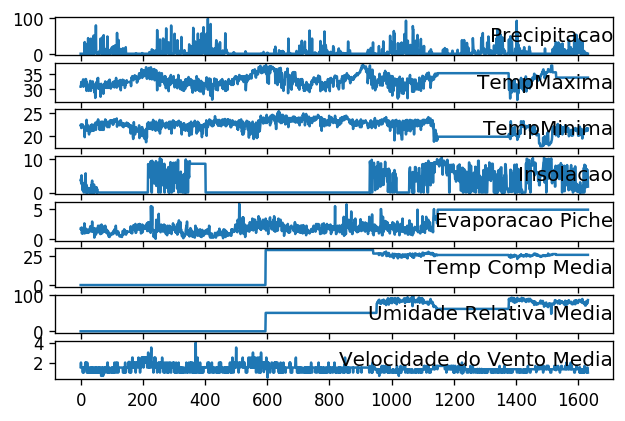

Train on 1570 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.4950 - mean_squared_error: 6.6483 - val_loss: 1.5829 - val_mean_squared_error: 2.5218
Epoch 2/1000
 - 0s - loss: 0.4161 - mean_squared_error: 0.3232 - val_loss: 0.2222 - val_mean_squared_error: 0.0494
Epoch 3/1000
 - 0s - loss: 0.0945 - mean_squared_error: 0.0141 - val_loss: 0.0372 - val_mean_squared_error: 0.0016
Epoch 4/1000
 - 0s - loss: 0.0559 - mean_squared_error: 0.0052 - val_loss: 0.0263 - val_mean_squared_error: 8.9711e-04
Epoch 5/1000
 - 0s - loss: 0.0467 - mean_squared_error: 0.0038 - val_loss: 0.0263 - val_mean_squared_error: 7.9454e-04
Epoch 6/1000
 - 0s - loss: 0.0441 - mean_squared_error: 0.0035 - val_loss: 0.0298 - val_mean_squared_error: 9.2381e-04
Epoch 7/1000
 - 1s - loss: 0.0425 - mean_squared_error: 0.0033 - val_loss: 0.0378 - val_mean_squared_error: 0.0015
Epoch 8/1000
 - 1s - loss: 0.0419 - mean_squared_error: 0.0032 - val_loss: 0.0481 - val_mean_squared_error: 0.0023
Epoch 9/1000
 - 1s - lo

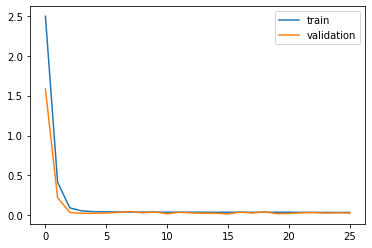


predict: [[31.94034004 22.76830762]]
real:      [[33.9 21.7]]

Train on 1569 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.1614 - mean_squared_error: 5.2582 - val_loss: 1.5890 - val_mean_squared_error: 2.5259
Epoch 2/1000
 - 0s - loss: 0.3684 - mean_squared_error: 0.2611 - val_loss: 0.2394 - val_mean_squared_error: 0.0577
Epoch 3/1000
 - 0s - loss: 0.0822 - mean_squared_error: 0.0113 - val_loss: 0.0578 - val_mean_squared_error: 0.0033
Epoch 4/1000
 - 0s - loss: 0.0531 - mean_squared_error: 0.0047 - val_loss: 0.0022 - val_mean_squared_error: 6.3587e-06
Epoch 5/1000
 - 0s - loss: 0.0468 - mean_squared_error: 0.0038 - val_loss: 0.0200 - val_mean_squared_error: 4.6612e-04
Epoch 6/1000
 - 0s - loss: 0.0450 - mean_squared_error: 0.0036 - val_loss: 0.0364 - val_mean_squared_error: 0.0015
Epoch 7/1000
 - 0s - loss: 0.0435 - mean_squared_error: 0.0034 - val_loss: 0.0275 - val_mean_squared_error: 7.5430e-04
Epoch 8/1000
 - 0s - loss: 0.0421 - mean_squared_error: 0.0032 - val_loss:

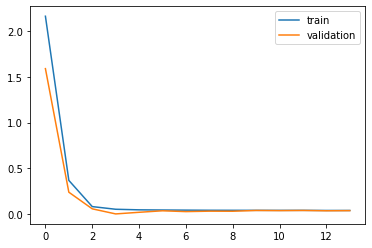


predict: [[32.49555088 23.39329455]]
real:      [[33.9 21.2]]

Train on 1568 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.5139 - mean_squared_error: 2.9978 - val_loss: 0.5838 - val_mean_squared_error: 0.4555
Epoch 2/1000
 - 0s - loss: 0.2335 - mean_squared_error: 0.1053 - val_loss: 0.0258 - val_mean_squared_error: 0.0013
Epoch 3/1000
 - 0s - loss: 0.0670 - mean_squared_error: 0.0071 - val_loss: 0.0408 - val_mean_squared_error: 0.0018
Epoch 4/1000
 - 0s - loss: 0.0452 - mean_squared_error: 0.0034 - val_loss: 0.0207 - val_mean_squared_error: 7.2162e-04
Epoch 5/1000
 - 1s - loss: 0.0411 - mean_squared_error: 0.0031 - val_loss: 0.0353 - val_mean_squared_error: 0.0021
Epoch 6/1000
 - 1s - loss: 0.0409 - mean_squared_error: 0.0031 - val_loss: 0.0436 - val_mean_squared_error: 0.0023
Epoch 7/1000
 - 1s - loss: 0.0403 - mean_squared_error: 0.0030 - val_loss: 0.0388 - val_mean_squared_error: 0.0018
Epoch 8/1000
 - 0s - loss: 0.0412 - mean_squared_error: 0.0031 - val_loss: 0.0321 

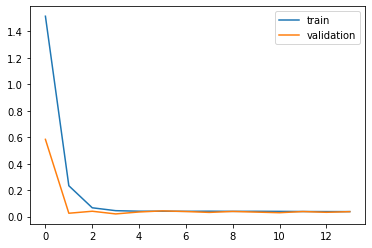


predict: [[32.87838094 22.72384783]]
real:      [[33.9 21.2]]

Train on 1567 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.8317 - mean_squared_error: 8.1737 - val_loss: 2.2253 - val_mean_squared_error: 5.0108
Epoch 2/1000
 - 0s - loss: 1.4358 - mean_squared_error: 2.5331 - val_loss: 0.6892 - val_mean_squared_error: 0.6049
Epoch 3/1000
 - 0s - loss: 0.2948 - mean_squared_error: 0.1574 - val_loss: 0.1128 - val_mean_squared_error: 0.0185
Epoch 4/1000
 - 0s - loss: 0.0733 - mean_squared_error: 0.0087 - val_loss: 0.0118 - val_mean_squared_error: 1.4217e-04
Epoch 5/1000
 - 0s - loss: 0.0489 - mean_squared_error: 0.0040 - val_loss: 0.0329 - val_mean_squared_error: 0.0015
Epoch 6/1000
 - 0s - loss: 0.0430 - mean_squared_error: 0.0033 - val_loss: 0.0447 - val_mean_squared_error: 0.0027
Epoch 7/1000
 - 0s - loss: 0.0418 - mean_squared_error: 0.0032 - val_loss: 0.0345 - val_mean_squared_error: 0.0021
Epoch 8/1000
 - 0s - loss: 0.0424 - mean_squared_error: 0.0032 - val_loss: 0.0372 

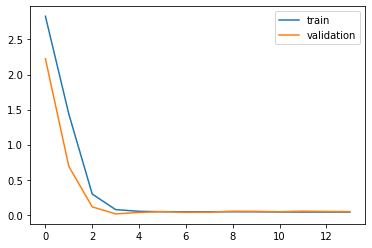


predict: [[32.65401464 23.2591392 ]]
real:      [[33.9 21.2]]

Train on 1566 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.8322 - mean_squared_error: 4.0103 - val_loss: 0.7137 - val_mean_squared_error: 0.5435
Epoch 2/1000
 - 1s - loss: 0.2402 - mean_squared_error: 0.0921 - val_loss: 0.0846 - val_mean_squared_error: 0.0080
Epoch 3/1000
 - 0s - loss: 0.0667 - mean_squared_error: 0.0072 - val_loss: 0.0384 - val_mean_squared_error: 0.0015
Epoch 4/1000
 - 0s - loss: 0.0486 - mean_squared_error: 0.0040 - val_loss: 0.0087 - val_mean_squared_error: 1.0520e-04
Epoch 5/1000
 - 0s - loss: 0.0447 - mean_squared_error: 0.0036 - val_loss: 0.0141 - val_mean_squared_error: 2.2385e-04
Epoch 6/1000
 - 0s - loss: 0.0430 - mean_squared_error: 0.0033 - val_loss: 0.0198 - val_mean_squared_error: 5.8247e-04
Epoch 7/1000
 - 0s - loss: 0.0408 - mean_squared_error: 0.0030 - val_loss: 0.0160 - val_mean_squared_error: 4.6621e-04
Epoch 8/1000
 - 0s - loss: 0.0402 - mean_squared_error: 0.0029 - val_l

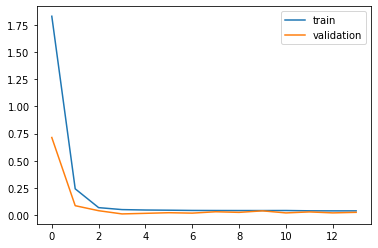


predict: [[33.11641746 22.64441525]]
real:      [[33.9 21.8]]

Train on 1565 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.1403 - mean_squared_error: 5.4798 - val_loss: 0.6849 - val_mean_squared_error: 0.7299
Epoch 2/1000
 - 0s - loss: 0.2855 - mean_squared_error: 0.1597 - val_loss: 0.1535 - val_mean_squared_error: 0.0240
Epoch 3/1000
 - 0s - loss: 0.0792 - mean_squared_error: 0.0105 - val_loss: 0.0316 - val_mean_squared_error: 0.0011
Epoch 4/1000
 - 0s - loss: 0.0491 - mean_squared_error: 0.0043 - val_loss: 0.0459 - val_mean_squared_error: 0.0026
Epoch 5/1000
 - 0s - loss: 0.0450 - mean_squared_error: 0.0038 - val_loss: 0.0572 - val_mean_squared_error: 0.0037
Epoch 6/1000
 - 1s - loss: 0.0449 - mean_squared_error: 0.0037 - val_loss: 0.0429 - val_mean_squared_error: 0.0023
Epoch 7/1000
 - 0s - loss: 0.0433 - mean_squared_error: 0.0036 - val_loss: 0.0435 - val_mean_squared_error: 0.0023
Epoch 8/1000
 - 1s - loss: 0.0427 - mean_squared_error: 0.0034 - val_loss: 0.0502 - va

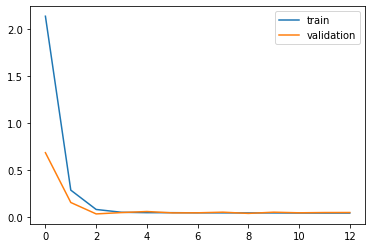


predict: [[32.25801617 23.44051809]]
real:      [[33.9 21.2]]

Train on 1564 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.8093 - mean_squared_error: 8.4894 - val_loss: 1.8602 - val_mean_squared_error: 4.5452
Epoch 2/1000
 - 0s - loss: 1.0767 - mean_squared_error: 2.1714 - val_loss: 0.4766 - val_mean_squared_error: 0.4280
Epoch 3/1000
 - 1s - loss: 0.1653 - mean_squared_error: 0.0594 - val_loss: 0.1148 - val_mean_squared_error: 0.0236
Epoch 4/1000
 - 0s - loss: 0.0705 - mean_squared_error: 0.0093 - val_loss: 0.0392 - val_mean_squared_error: 0.0020
Epoch 5/1000
 - 1s - loss: 0.0481 - mean_squared_error: 0.0040 - val_loss: 0.0495 - val_mean_squared_error: 0.0025
Epoch 6/1000
 - 1s - loss: 0.0455 - mean_squared_error: 0.0036 - val_loss: 0.0157 - val_mean_squared_error: 3.8270e-04
Epoch 7/1000
 - 0s - loss: 0.0440 - mean_squared_error: 0.0034 - val_loss: 0.0262 - val_mean_squared_error: 6.9463e-04
Epoch 8/1000
 - 0s - loss: 0.0423 - mean_squared_error: 0.0033 - val_loss: 0.0

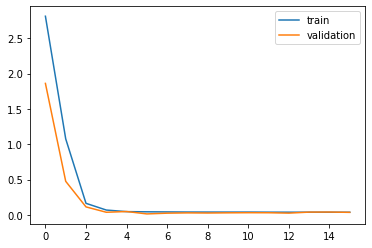


predict: [[33.04017344 23.2600762 ]]
real:      [[33.9 21.6]]

Train on 1563 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.2874 - mean_squared_error: 5.8037 - val_loss: 1.2146 - val_mean_squared_error: 2.3052
Epoch 2/1000
 - 1s - loss: 0.4553 - mean_squared_error: 0.4574 - val_loss: 0.2330 - val_mean_squared_error: 0.0565
Epoch 3/1000
 - 1s - loss: 0.1116 - mean_squared_error: 0.0225 - val_loss: 0.1042 - val_mean_squared_error: 0.0145
Epoch 4/1000
 - 0s - loss: 0.0526 - mean_squared_error: 0.0046 - val_loss: 0.0207 - val_mean_squared_error: 5.2527e-04
Epoch 5/1000
 - 1s - loss: 0.0433 - mean_squared_error: 0.0033 - val_loss: 0.0374 - val_mean_squared_error: 0.0019
Epoch 6/1000
 - 0s - loss: 0.0416 - mean_squared_error: 0.0031 - val_loss: 0.0335 - val_mean_squared_error: 0.0013
Epoch 7/1000
 - 0s - loss: 0.0407 - mean_squared_error: 0.0030 - val_loss: 0.0295 - val_mean_squared_error: 0.0010
Epoch 8/1000
 - 0s - loss: 0.0414 - mean_squared_error: 0.0030 - val_loss: 0.0320 

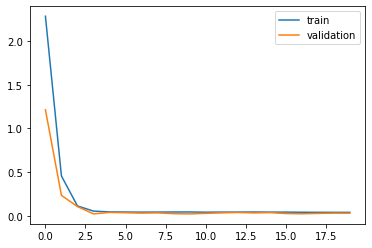


predict: [[32.57112731 22.02638626]]
real:      [[33.9 21.1]]

Train on 1562 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.8583 - mean_squared_error: 4.3705 - val_loss: 0.8290 - val_mean_squared_error: 0.8871
Epoch 2/1000
 - 1s - loss: 0.5403 - mean_squared_error: 0.3969 - val_loss: 0.1532 - val_mean_squared_error: 0.0235
Epoch 3/1000
 - 0s - loss: 0.0989 - mean_squared_error: 0.0150 - val_loss: 0.0425 - val_mean_squared_error: 0.0030
Epoch 4/1000
 - 0s - loss: 0.0569 - mean_squared_error: 0.0053 - val_loss: 0.0226 - val_mean_squared_error: 8.8500e-04
Epoch 5/1000
 - 0s - loss: 0.0481 - mean_squared_error: 0.0040 - val_loss: 0.0273 - val_mean_squared_error: 7.7438e-04
Epoch 6/1000
 - 0s - loss: 0.0450 - mean_squared_error: 0.0036 - val_loss: 0.0308 - val_mean_squared_error: 0.0011
Epoch 7/1000
 - 1s - loss: 0.0434 - mean_squared_error: 0.0034 - val_loss: 0.0345 - val_mean_squared_error: 0.0013
Epoch 8/1000
 - 0s - loss: 0.0423 - mean_squared_error: 0.0032 - val_loss: 0.0

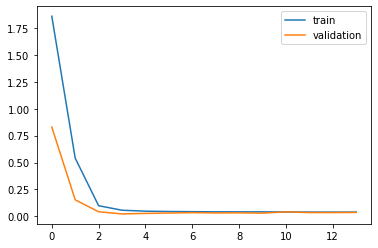


predict: [[33.0363998  22.92716101]]
real:      [[33.9 21.1]]

Train on 1561 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.2909 - mean_squared_error: 5.7956 - val_loss: 1.0798 - val_mean_squared_error: 1.3495
Epoch 2/1000
 - 0s - loss: 0.3951 - mean_squared_error: 0.3067 - val_loss: 0.1626 - val_mean_squared_error: 0.0303
Epoch 3/1000
 - 0s - loss: 0.0902 - mean_squared_error: 0.0127 - val_loss: 0.0418 - val_mean_squared_error: 0.0019
Epoch 4/1000
 - 0s - loss: 0.0544 - mean_squared_error: 0.0050 - val_loss: 0.0459 - val_mean_squared_error: 0.0021
Epoch 5/1000
 - 0s - loss: 0.0457 - mean_squared_error: 0.0037 - val_loss: 0.0388 - val_mean_squared_error: 0.0016
Epoch 6/1000
 - 0s - loss: 0.0448 - mean_squared_error: 0.0036 - val_loss: 0.0374 - val_mean_squared_error: 0.0014
Epoch 7/1000
 - 0s - loss: 0.0437 - mean_squared_error: 0.0034 - val_loss: 0.0370 - val_mean_squared_error: 0.0015
Epoch 8/1000
 - 0s - loss: 0.0430 - mean_squared_error: 0.0034 - val_loss: 0.0337 - va

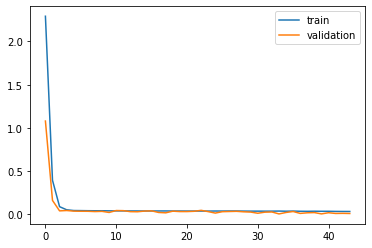


predict: [[32.6829607 23.1815866]]
real:      [[33.9 21.1]]

Train on 1560 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.9857 - mean_squared_error: 9.1087 - val_loss: 2.3691 - val_mean_squared_error: 5.9542
Epoch 2/1000
 - 0s - loss: 1.4969 - mean_squared_error: 3.3075 - val_loss: 1.0039 - val_mean_squared_error: 1.7637
Epoch 3/1000
 - 0s - loss: 0.5479 - mean_squared_error: 0.6364 - val_loss: 0.1166 - val_mean_squared_error: 0.0162
Epoch 4/1000
 - 1s - loss: 0.0863 - mean_squared_error: 0.0119 - val_loss: 0.0655 - val_mean_squared_error: 0.0043
Epoch 5/1000
 - 1s - loss: 0.0551 - mean_squared_error: 0.0049 - val_loss: 0.0123 - val_mean_squared_error: 1.6658e-04
Epoch 6/1000
 - 1s - loss: 0.0456 - mean_squared_error: 0.0035 - val_loss: 0.0200 - val_mean_squared_error: 6.9171e-04
Epoch 7/1000
 - 0s - loss: 0.0436 - mean_squared_error: 0.0033 - val_loss: 0.0264 - val_mean_squared_error: 8.4499e-04
Epoch 8/1000
 - 0s - loss: 0.0424 - mean_squared_error: 0.0032 - val_loss: 0

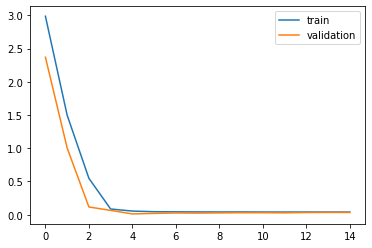


predict: [[33.69342799 22.77186664]]
real:      [[33.9 21.2]]

Train on 1559 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.2579 - mean_squared_error: 5.5765 - val_loss: 0.9878 - val_mean_squared_error: 1.0563
Epoch 2/1000
 - 0s - loss: 0.3445 - mean_squared_error: 0.2039 - val_loss: 0.2059 - val_mean_squared_error: 0.0424
Epoch 3/1000
 - 1s - loss: 0.0911 - mean_squared_error: 0.0136 - val_loss: 0.0355 - val_mean_squared_error: 0.0022
Epoch 4/1000
 - 0s - loss: 0.0521 - mean_squared_error: 0.0044 - val_loss: 0.0229 - val_mean_squared_error: 5.8309e-04
Epoch 5/1000
 - 0s - loss: 0.0459 - mean_squared_error: 0.0037 - val_loss: 0.0348 - val_mean_squared_error: 0.0013
Epoch 6/1000
 - 0s - loss: 0.0430 - mean_squared_error: 0.0033 - val_loss: 0.0319 - val_mean_squared_error: 0.0013
Epoch 7/1000
 - 0s - loss: 0.0424 - mean_squared_error: 0.0033 - val_loss: 0.0335 - val_mean_squared_error: 0.0016
Epoch 8/1000
 - 0s - loss: 0.0431 - mean_squared_error: 0.0033 - val_loss: 0.0305 

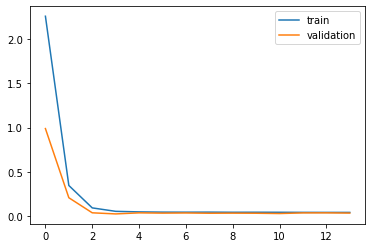


predict: [[32.78680408 24.54379305]]
real:      [[33.9 21.2]]

Train on 1558 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.2025 - mean_squared_error: 5.3443 - val_loss: 1.3724 - val_mean_squared_error: 2.3095
Epoch 2/1000
 - 0s - loss: 0.4675 - mean_squared_error: 0.4667 - val_loss: 0.0457 - val_mean_squared_error: 0.0033
Epoch 3/1000
 - 0s - loss: 0.1009 - mean_squared_error: 0.0209 - val_loss: 0.0301 - val_mean_squared_error: 9.7805e-04
Epoch 4/1000
 - 0s - loss: 0.0531 - mean_squared_error: 0.0050 - val_loss: 0.0509 - val_mean_squared_error: 0.0030
Epoch 5/1000
 - 0s - loss: 0.0444 - mean_squared_error: 0.0036 - val_loss: 0.0429 - val_mean_squared_error: 0.0020
Epoch 6/1000
 - 0s - loss: 0.0427 - mean_squared_error: 0.0034 - val_loss: 0.0472 - val_mean_squared_error: 0.0027
Epoch 7/1000
 - 0s - loss: 0.0428 - mean_squared_error: 0.0034 - val_loss: 0.0412 - val_mean_squared_error: 0.0029
Epoch 8/1000
 - 0s - loss: 0.0428 - mean_squared_error: 0.0034 - val_loss: 0.0273 

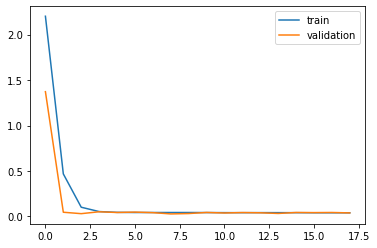


predict: [[32.92279443 22.64606139]]
real:      [[33.9 21.2]]

Train on 1557 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.8751 - mean_squared_error: 4.3781 - val_loss: 1.0032 - val_mean_squared_error: 1.2823
Epoch 2/1000
 - 0s - loss: 0.3993 - mean_squared_error: 0.2761 - val_loss: 0.1599 - val_mean_squared_error: 0.0322
Epoch 3/1000
 - 0s - loss: 0.0870 - mean_squared_error: 0.0127 - val_loss: 0.0259 - val_mean_squared_error: 6.9369e-04
Epoch 4/1000
 - 0s - loss: 0.0507 - mean_squared_error: 0.0043 - val_loss: 0.0294 - val_mean_squared_error: 0.0017
Epoch 5/1000
 - 0s - loss: 0.0446 - mean_squared_error: 0.0035 - val_loss: 0.0053 - val_mean_squared_error: 4.6113e-05
Epoch 6/1000
 - 0s - loss: 0.0428 - mean_squared_error: 0.0033 - val_loss: 0.0221 - val_mean_squared_error: 5.5071e-04
Epoch 7/1000
 - 0s - loss: 0.0419 - mean_squared_error: 0.0032 - val_loss: 0.0257 - val_mean_squared_error: 8.3177e-04
Epoch 8/1000
 - 0s - loss: 0.0421 - mean_squared_error: 0.0032 - val_l

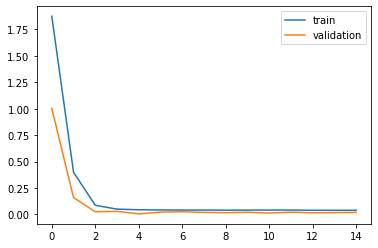


predict: [[31.44328148 22.81299267]]
real:      [[33.9 21.4]]

Train on 1556 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.0103 - mean_squared_error: 4.5964 - val_loss: 0.6911 - val_mean_squared_error: 0.4784
Epoch 2/1000
 - 0s - loss: 0.2670 - mean_squared_error: 0.1158 - val_loss: 0.0322 - val_mean_squared_error: 0.0020
Epoch 3/1000
 - 0s - loss: 0.0791 - mean_squared_error: 0.0103 - val_loss: 0.0199 - val_mean_squared_error: 4.0317e-04
Epoch 4/1000
 - 0s - loss: 0.0515 - mean_squared_error: 0.0046 - val_loss: 0.0127 - val_mean_squared_error: 2.5318e-04
Epoch 5/1000
 - 0s - loss: 0.0457 - mean_squared_error: 0.0036 - val_loss: 0.0207 - val_mean_squared_error: 7.0338e-04
Epoch 6/1000
 - 0s - loss: 0.0440 - mean_squared_error: 0.0034 - val_loss: 0.0048 - val_mean_squared_error: 2.7928e-05
Epoch 7/1000
 - 0s - loss: 0.0444 - mean_squared_error: 0.0035 - val_loss: 0.0264 - val_mean_squared_error: 0.0014
Epoch 8/1000
 - 0s - loss: 0.0426 - mean_squared_error: 0.0033 - val_l

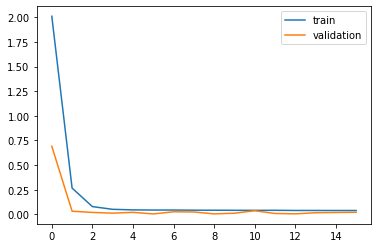


predict: [[32.1740714  22.78325002]]
real:      [[33.9 20.4]]

Train on 1555 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.5543 - mean_squared_error: 8.4135 - val_loss: 1.9719 - val_mean_squared_error: 6.7093
Epoch 2/1000
 - 0s - loss: 1.4860 - mean_squared_error: 4.1943 - val_loss: 1.0839 - val_mean_squared_error: 2.2997
Epoch 3/1000
 - 0s - loss: 0.5923 - mean_squared_error: 0.8154 - val_loss: 0.0462 - val_mean_squared_error: 0.0028
Epoch 4/1000
 - 0s - loss: 0.1032 - mean_squared_error: 0.0196 - val_loss: 0.0895 - val_mean_squared_error: 0.0089
Epoch 5/1000
 - 0s - loss: 0.0575 - mean_squared_error: 0.0055 - val_loss: 0.0350 - val_mean_squared_error: 0.0013
Epoch 6/1000
 - 0s - loss: 0.0455 - mean_squared_error: 0.0035 - val_loss: 0.0130 - val_mean_squared_error: 1.7559e-04
Epoch 7/1000
 - 0s - loss: 0.0442 - mean_squared_error: 0.0034 - val_loss: 0.0282 - val_mean_squared_error: 8.2198e-04
Epoch 8/1000
 - 0s - loss: 0.0440 - mean_squared_error: 0.0034 - val_loss: 0.0

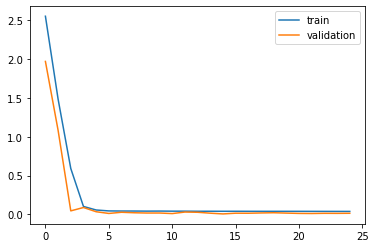


predict: [[32.28682797 22.96580145]]
real:      [[33.9 20.4]]

Train on 1554 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 1.9027 - mean_squared_error: 4.6523 - val_loss: 0.9019 - val_mean_squared_error: 1.5524
Epoch 2/1000
 - 0s - loss: 0.3467 - mean_squared_error: 0.3024 - val_loss: 0.0760 - val_mean_squared_error: 0.0064
Epoch 3/1000
 - 0s - loss: 0.0905 - mean_squared_error: 0.0156 - val_loss: 0.0544 - val_mean_squared_error: 0.0030
Epoch 4/1000
 - 0s - loss: 0.0539 - mean_squared_error: 0.0052 - val_loss: 0.0626 - val_mean_squared_error: 0.0040
Epoch 5/1000
 - 0s - loss: 0.0460 - mean_squared_error: 0.0038 - val_loss: 0.0418 - val_mean_squared_error: 0.0020
Epoch 6/1000
 - 0s - loss: 0.0427 - mean_squared_error: 0.0034 - val_loss: 0.0460 - val_mean_squared_error: 0.0026
Epoch 7/1000
 - 0s - loss: 0.0422 - mean_squared_error: 0.0033 - val_loss: 0.0201 - val_mean_squared_error: 6.0681e-04
Epoch 8/1000
 - 0s - loss: 0.0417 - mean_squared_error: 0.0033 - val_loss: 0.0298 

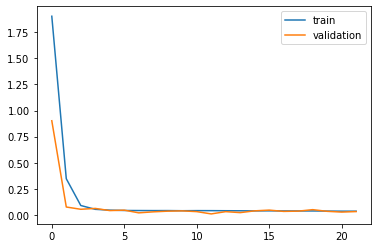


predict: [[32.81896043 23.44157864]]
real:      [[33.9 20.4]]

Train on 1553 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.9589 - mean_squared_error: 8.9913 - val_loss: 1.7242 - val_mean_squared_error: 3.0382
Epoch 2/1000
 - 0s - loss: 0.7472 - mean_squared_error: 0.9051 - val_loss: 0.1160 - val_mean_squared_error: 0.0135
Epoch 3/1000
 - 0s - loss: 0.1095 - mean_squared_error: 0.0193 - val_loss: 0.0259 - val_mean_squared_error: 6.6938e-04
Epoch 4/1000
 - 0s - loss: 0.0592 - mean_squared_error: 0.0057 - val_loss: 0.0383 - val_mean_squared_error: 0.0027
Epoch 5/1000
 - 0s - loss: 0.0469 - mean_squared_error: 0.0038 - val_loss: 0.0363 - val_mean_squared_error: 0.0014
Epoch 6/1000
 - 0s - loss: 0.0439 - mean_squared_error: 0.0034 - val_loss: 0.0461 - val_mean_squared_error: 0.0021
Epoch 7/1000
 - 0s - loss: 0.0432 - mean_squared_error: 0.0034 - val_loss: 0.0403 - val_mean_squared_error: 0.0017
Epoch 8/1000
 - 0s - loss: 0.0428 - mean_squared_error: 0.0033 - val_loss: 0.0418 

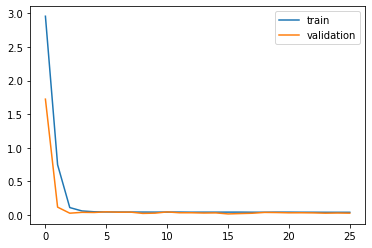


predict: [[31.85190973 22.41840503]]
real:      [[33.9 21.2]]

Train on 1552 samples, validate on 1 samples
Epoch 1/1000
 - 1s - loss: 2.2134 - mean_squared_error: 5.6498 - val_loss: 1.2310 - val_mean_squared_error: 2.4777
Epoch 2/1000
 - 0s - loss: 0.4507 - mean_squared_error: 0.4775 - val_loss: 0.1096 - val_mean_squared_error: 0.0137
Epoch 3/1000
 - 0s - loss: 0.1035 - mean_squared_error: 0.0187 - val_loss: 0.0132 - val_mean_squared_error: 1.8108e-04
Epoch 4/1000
 - 0s - loss: 0.0569 - mean_squared_error: 0.0053 - val_loss: 0.0551 - val_mean_squared_error: 0.0031
Epoch 5/1000
 - 0s - loss: 0.0492 - mean_squared_error: 0.0040 - val_loss: 0.0330 - val_mean_squared_error: 0.0014
Epoch 6/1000
 - 0s - loss: 0.0466 - mean_squared_error: 0.0038 - val_loss: 0.0152 - val_mean_squared_error: 3.2028e-04
Epoch 7/1000
 - 0s - loss: 0.0450 - mean_squared_error: 0.0036 - val_loss: 0.0214 - val_mean_squared_error: 4.7449e-04
Epoch 8/1000
 - 0s - loss: 0.0431 - mean_squared_error: 0.0033 - val_loss:

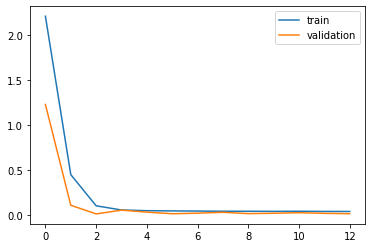


predict: [[37.73531176 23.86261024]]
real:      [[33.9 19.5]]

Train on 1551 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.0107 - mean_squared_error: 5.1031 - val_loss: 0.9843 - val_mean_squared_error: 1.7409
Epoch 2/1000
 - 0s - loss: 0.4283 - mean_squared_error: 0.4322 - val_loss: 0.1246 - val_mean_squared_error: 0.0163
Epoch 3/1000
 - 0s - loss: 0.0792 - mean_squared_error: 0.0099 - val_loss: 0.0234 - val_mean_squared_error: 6.1282e-04
Epoch 4/1000
 - 0s - loss: 0.0481 - mean_squared_error: 0.0039 - val_loss: 0.0367 - val_mean_squared_error: 0.0021
Epoch 5/1000
 - 0s - loss: 0.0456 - mean_squared_error: 0.0036 - val_loss: 0.0389 - val_mean_squared_error: 0.0018
Epoch 6/1000
 - 0s - loss: 0.0423 - mean_squared_error: 0.0033 - val_loss: 0.0293 - val_mean_squared_error: 0.0013
Epoch 7/1000
 - 0s - loss: 0.0416 - mean_squared_error: 0.0032 - val_loss: 0.0335 - val_mean_squared_error: 0.0017
Epoch 8/1000
 - 0s - loss: 0.0412 - mean_squared_error: 0.0032 - val_loss: 0.0367 

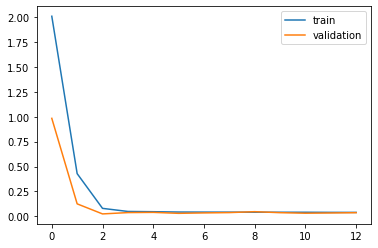


predict: [[32.57984478 23.00801281]]
real:      [[33.9 20.2]]

Train on 1550 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 1.2936 - mean_squared_error: 2.7383 - val_loss: 0.2131 - val_mean_squared_error: 0.0600
Epoch 2/1000
 - 0s - loss: 0.1337 - mean_squared_error: 0.0278 - val_loss: 0.0337 - val_mean_squared_error: 0.0011
Epoch 3/1000
 - 0s - loss: 0.0551 - mean_squared_error: 0.0051 - val_loss: 0.0063 - val_mean_squared_error: 6.1518e-05
Epoch 4/1000
 - 0s - loss: 0.0452 - mean_squared_error: 0.0034 - val_loss: 0.0161 - val_mean_squared_error: 4.4697e-04
Epoch 5/1000
 - 0s - loss: 0.0431 - mean_squared_error: 0.0032 - val_loss: 0.0195 - val_mean_squared_error: 4.3701e-04
Epoch 6/1000
 - 0s - loss: 0.0424 - mean_squared_error: 0.0031 - val_loss: 0.0084 - val_mean_squared_error: 8.8891e-05
Epoch 7/1000
 - 0s - loss: 0.0420 - mean_squared_error: 0.0031 - val_loss: 0.0302 - val_mean_squared_error: 0.0011
Epoch 8/1000
 - 0s - loss: 0.0412 - mean_squared_error: 0.0030 - val_l

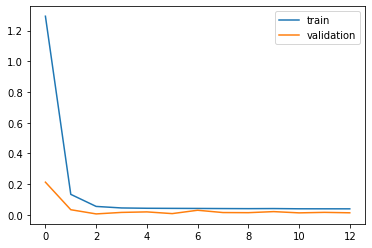


predict: [[32.41540398 23.61494167]]
real:      [[33.9 21.6]]

Train on 1549 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.3049 - mean_squared_error: 5.7987 - val_loss: 1.2906 - val_mean_squared_error: 2.0452
Epoch 2/1000
 - 0s - loss: 0.7349 - mean_squared_error: 0.9975 - val_loss: 0.2118 - val_mean_squared_error: 0.0567
Epoch 3/1000
 - 0s - loss: 0.1030 - mean_squared_error: 0.0183 - val_loss: 0.0509 - val_mean_squared_error: 0.0027
Epoch 4/1000
 - 0s - loss: 0.0498 - mean_squared_error: 0.0041 - val_loss: 0.0184 - val_mean_squared_error: 6.3577e-04
Epoch 5/1000
 - 0s - loss: 0.0409 - mean_squared_error: 0.0031 - val_loss: 0.0198 - val_mean_squared_error: 4.6503e-04
Epoch 6/1000
 - 0s - loss: 0.0402 - mean_squared_error: 0.0031 - val_loss: 0.0148 - val_mean_squared_error: 2.3855e-04
Epoch 7/1000
 - 0s - loss: 0.0406 - mean_squared_error: 0.0031 - val_loss: 0.0202 - val_mean_squared_error: 4.1765e-04
Epoch 8/1000
 - 0s - loss: 0.0401 - mean_squared_error: 0.0031 - val_l

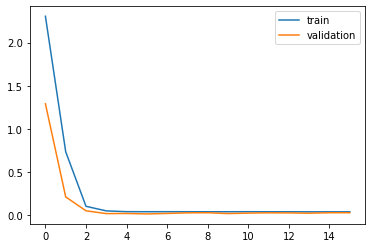


predict: [[32.55901147 22.77493871]]
real:      [[33.9 20.6]]

Train on 1548 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 1.8456 - mean_squared_error: 4.3267 - val_loss: 0.9442 - val_mean_squared_error: 1.3472
Epoch 2/1000
 - 0s - loss: 0.3745 - mean_squared_error: 0.2659 - val_loss: 0.0912 - val_mean_squared_error: 0.0099
Epoch 3/1000
 - 0s - loss: 0.0828 - mean_squared_error: 0.0112 - val_loss: 0.0140 - val_mean_squared_error: 1.9572e-04
Epoch 4/1000
 - 0s - loss: 0.0559 - mean_squared_error: 0.0051 - val_loss: 0.0148 - val_mean_squared_error: 2.2612e-04
Epoch 5/1000
 - 0s - loss: 0.0481 - mean_squared_error: 0.0040 - val_loss: 0.0221 - val_mean_squared_error: 6.3743e-04
Epoch 6/1000
 - 0s - loss: 0.0458 - mean_squared_error: 0.0038 - val_loss: 0.0090 - val_mean_squared_error: 1.0398e-04
Epoch 7/1000
 - 0s - loss: 0.0450 - mean_squared_error: 0.0037 - val_loss: 0.0094 - val_mean_squared_error: 9.2936e-05
Epoch 8/1000
 - 0s - loss: 0.0433 - mean_squared_error: 0.0034 - v

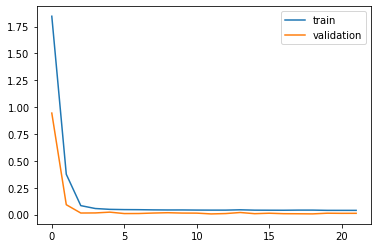


predict: [[32.32745433 22.7954104 ]]
real:      [[33.9 20.6]]

Train on 1547 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 1.7493 - mean_squared_error: 4.0486 - val_loss: 0.4323 - val_mean_squared_error: 0.2097
Epoch 2/1000
 - 0s - loss: 0.2253 - mean_squared_error: 0.0787 - val_loss: 0.0765 - val_mean_squared_error: 0.0060
Epoch 3/1000
 - 0s - loss: 0.0680 - mean_squared_error: 0.0075 - val_loss: 0.0230 - val_mean_squared_error: 9.5564e-04
Epoch 4/1000
 - 0s - loss: 0.0453 - mean_squared_error: 0.0036 - val_loss: 0.0360 - val_mean_squared_error: 0.0013
Epoch 5/1000
 - 0s - loss: 0.0434 - mean_squared_error: 0.0034 - val_loss: 0.0327 - val_mean_squared_error: 0.0012
Epoch 6/1000
 - 0s - loss: 0.0424 - mean_squared_error: 0.0033 - val_loss: 0.0275 - val_mean_squared_error: 7.6679e-04
Epoch 7/1000
 - 0s - loss: 0.0418 - mean_squared_error: 0.0033 - val_loss: 0.0342 - val_mean_squared_error: 0.0012
Epoch 8/1000
 - 0s - loss: 0.0424 - mean_squared_error: 0.0033 - val_loss: 0.0

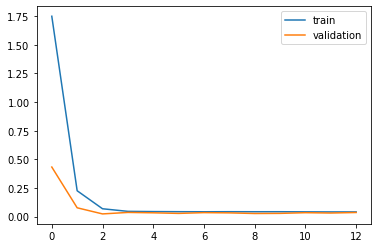


predict: [[31.43623559 23.01702974]]
real:      [[33.9 20.6]]

Train on 1546 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 3.0194 - mean_squared_error: 9.4244 - val_loss: 2.2308 - val_mean_squared_error: 5.1732
Epoch 2/1000
 - 0s - loss: 1.3772 - mean_squared_error: 2.5254 - val_loss: 0.7601 - val_mean_squared_error: 0.8815
Epoch 3/1000
 - 0s - loss: 0.3234 - mean_squared_error: 0.2124 - val_loss: 0.0538 - val_mean_squared_error: 0.0030
Epoch 4/1000
 - 0s - loss: 0.0789 - mean_squared_error: 0.0105 - val_loss: 0.0115 - val_mean_squared_error: 1.3795e-04
Epoch 5/1000
 - 0s - loss: 0.0487 - mean_squared_error: 0.0041 - val_loss: 0.0128 - val_mean_squared_error: 1.6623e-04
Epoch 6/1000
 - 0s - loss: 0.0446 - mean_squared_error: 0.0036 - val_loss: 0.0196 - val_mean_squared_error: 6.2431e-04
Epoch 7/1000
 - 0s - loss: 0.0430 - mean_squared_error: 0.0034 - val_loss: 0.0155 - val_mean_squared_error: 3.2884e-04
Epoch 8/1000
 - 0s - loss: 0.0416 - mean_squared_error: 0.0032 - val_l

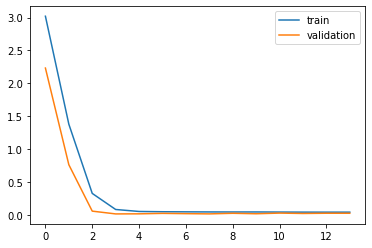


predict: [[32.02345716 23.86215381]]
real:      [[33.9 21. ]]

Train on 1545 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 1.8019 - mean_squared_error: 4.0891 - val_loss: 0.5430 - val_mean_squared_error: 0.4279
Epoch 2/1000
 - 0s - loss: 0.2509 - mean_squared_error: 0.0983 - val_loss: 0.1268 - val_mean_squared_error: 0.0201
Epoch 3/1000
 - 0s - loss: 0.0672 - mean_squared_error: 0.0073 - val_loss: 0.0492 - val_mean_squared_error: 0.0034
Epoch 4/1000
 - 0s - loss: 0.0492 - mean_squared_error: 0.0042 - val_loss: 0.0330 - val_mean_squared_error: 0.0015
Epoch 5/1000
 - 0s - loss: 0.0450 - mean_squared_error: 0.0037 - val_loss: 0.0484 - val_mean_squared_error: 0.0028
Epoch 6/1000
 - 0s - loss: 0.0441 - mean_squared_error: 0.0035 - val_loss: 0.0538 - val_mean_squared_error: 0.0049
Epoch 7/1000
 - 0s - loss: 0.0431 - mean_squared_error: 0.0034 - val_loss: 0.0495 - val_mean_squared_error: 0.0032
Epoch 8/1000
 - 0s - loss: 0.0427 - mean_squared_error: 0.0034 - val_loss: 0.0551 - va

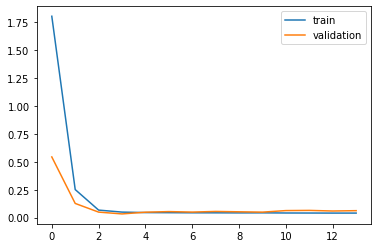


predict: [[33.20373349 23.81336425]]
real:      [[33.9 20.4]]

Train on 1544 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.3761 - mean_squared_error: 6.2830 - val_loss: 1.3476 - val_mean_squared_error: 2.3104
Epoch 2/1000
 - 0s - loss: 0.7096 - mean_squared_error: 0.8579 - val_loss: 0.2760 - val_mean_squared_error: 0.0764
Epoch 3/1000
 - 0s - loss: 0.1267 - mean_squared_error: 0.0253 - val_loss: 0.0431 - val_mean_squared_error: 0.0023
Epoch 4/1000
 - 0s - loss: 0.0512 - mean_squared_error: 0.0045 - val_loss: 0.0113 - val_mean_squared_error: 1.7425e-04
Epoch 5/1000
 - 0s - loss: 0.0433 - mean_squared_error: 0.0034 - val_loss: 0.0192 - val_mean_squared_error: 3.7224e-04
Epoch 6/1000
 - 0s - loss: 0.0426 - mean_squared_error: 0.0033 - val_loss: 0.0098 - val_mean_squared_error: 1.5161e-04
Epoch 7/1000
 - 0s - loss: 0.0412 - mean_squared_error: 0.0032 - val_loss: 0.0083 - val_mean_squared_error: 1.2556e-04
Epoch 8/1000
 - 0s - loss: 0.0411 - mean_squared_error: 0.0032 - val_l

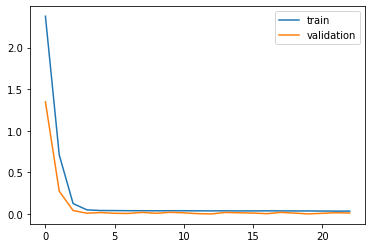


predict: [[31.03363308 22.51144101]]
real:      [[33.9 22.1]]

Train on 1543 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.3312 - mean_squared_error: 6.3155 - val_loss: 1.2021 - val_mean_squared_error: 1.9864
Epoch 2/1000
 - 0s - loss: 0.9015 - mean_squared_error: 1.0297 - val_loss: 0.6927 - val_mean_squared_error: 0.8025
Epoch 3/1000
 - 0s - loss: 0.4626 - mean_squared_error: 0.3546 - val_loss: 0.2323 - val_mean_squared_error: 0.0974
Epoch 4/1000
 - 0s - loss: 0.1083 - mean_squared_error: 0.0216 - val_loss: 0.0427 - val_mean_squared_error: 0.0023
Epoch 5/1000
 - 0s - loss: 0.0538 - mean_squared_error: 0.0047 - val_loss: 0.0398 - val_mean_squared_error: 0.0023
Epoch 6/1000
 - 0s - loss: 0.0489 - mean_squared_error: 0.0040 - val_loss: 0.0353 - val_mean_squared_error: 0.0023
Epoch 7/1000
 - 0s - loss: 0.0434 - mean_squared_error: 0.0033 - val_loss: 0.0415 - val_mean_squared_error: 0.0028
Epoch 8/1000
 - 0s - loss: 0.0423 - mean_squared_error: 0.0033 - val_loss: 0.0436 - va

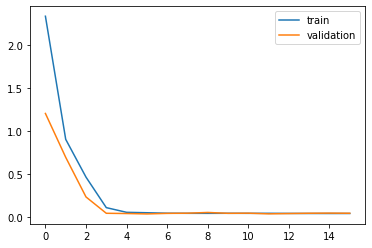


predict: [[32.74143432 22.86682465]]
real:      [[33.9 20.2]]

Train on 1542 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.7984 - mean_squared_error: 8.0404 - val_loss: 2.4098 - val_mean_squared_error: 5.8251
Epoch 2/1000
 - 0s - loss: 1.1927 - mean_squared_error: 1.8631 - val_loss: 0.5554 - val_mean_squared_error: 0.3525
Epoch 3/1000
 - 0s - loss: 0.2457 - mean_squared_error: 0.0953 - val_loss: 0.1282 - val_mean_squared_error: 0.0167
Epoch 4/1000
 - 0s - loss: 0.0740 - mean_squared_error: 0.0086 - val_loss: 0.0271 - val_mean_squared_error: 7.7536e-04
Epoch 5/1000
 - 0s - loss: 0.0511 - mean_squared_error: 0.0042 - val_loss: 0.0293 - val_mean_squared_error: 9.1904e-04
Epoch 6/1000
 - 0s - loss: 0.0465 - mean_squared_error: 0.0035 - val_loss: 0.0346 - val_mean_squared_error: 0.0016
Epoch 7/1000
 - 0s - loss: 0.0448 - mean_squared_error: 0.0034 - val_loss: 0.0455 - val_mean_squared_error: 0.0021
Epoch 8/1000
 - 0s - loss: 0.0437 - mean_squared_error: 0.0034 - val_loss: 0.0

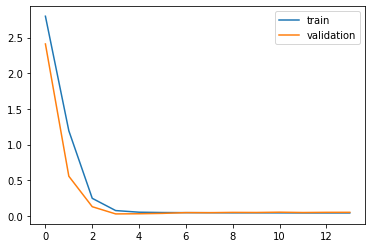


predict: [[33.41869816 23.27049552]]
real:      [[33.9 21.9]]

Train on 1541 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.4756 - mean_squared_error: 6.9046 - val_loss: 1.6654 - val_mean_squared_error: 3.6949
Epoch 2/1000
 - 0s - loss: 0.6132 - mean_squared_error: 0.8766 - val_loss: 0.2512 - val_mean_squared_error: 0.0714
Epoch 3/1000
 - 0s - loss: 0.0997 - mean_squared_error: 0.0172 - val_loss: 0.0196 - val_mean_squared_error: 4.4444e-04
Epoch 4/1000
 - 0s - loss: 0.0549 - mean_squared_error: 0.0051 - val_loss: 0.0635 - val_mean_squared_error: 0.0040
Epoch 5/1000
 - 0s - loss: 0.0473 - mean_squared_error: 0.0039 - val_loss: 0.0489 - val_mean_squared_error: 0.0026
Epoch 6/1000
 - 0s - loss: 0.0451 - mean_squared_error: 0.0036 - val_loss: 0.0625 - val_mean_squared_error: 0.0044
Epoch 7/1000
 - 0s - loss: 0.0437 - mean_squared_error: 0.0035 - val_loss: 0.0417 - val_mean_squared_error: 0.0030
Epoch 8/1000
 - 0s - loss: 0.0430 - mean_squared_error: 0.0034 - val_loss: 0.0566 

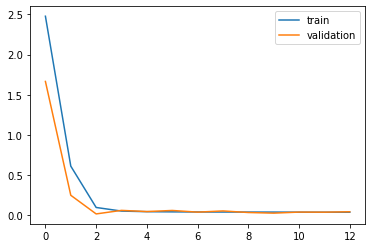


predict: [[34.02751815 24.59971271]]
real:      [[33.9 21.9]]

Train and validation time: 5.76 minutes

Maximum temperatures metrics
Test MEAN-SQUARED-ERROR ------------ 2.616
Test STANDART-DEVIATION ------------ 0.7637
Test MEAN-ABSOLUTE-ERROR ----------- 1.426
Test MEDIAN-ABSOLUTE-ERROR --------- 1.325

Errors
2018-12-31 = 1.9596599622995399
2018-12-30 = 1.4044491171320743
2018-12-29 = 1.0216190610338955
2018-12-28 = 1.2459853611101295
2018-12-27 = 0.7835825373018181
2018-12-26 = 1.6419838268791338
2018-12-24 = 0.859826555651594
2018-12-23 = 1.328872687690982
2018-12-22 = 0.8636001980159875
2018-12-21 = 1.217039304970946
2018-12-20 = 0.2065720106650204
2018-12-19 = 1.1131959205663833
2018-12-18 = 0.9772055653277008
2018-12-17 = 2.4567185168272587
2018-12-16 = 1.725928595013798
2018-12-15 = 1.613172031308224
2018-12-14 = 1.0810395747183605
2018-12-13 = 2.048090267952947
2018-12-12 = 3.835311764029875
2018-12-11 = 1.3201552213132075
2018-12-10 = 1.4845960202797102
2018-12-09 = 1.34098

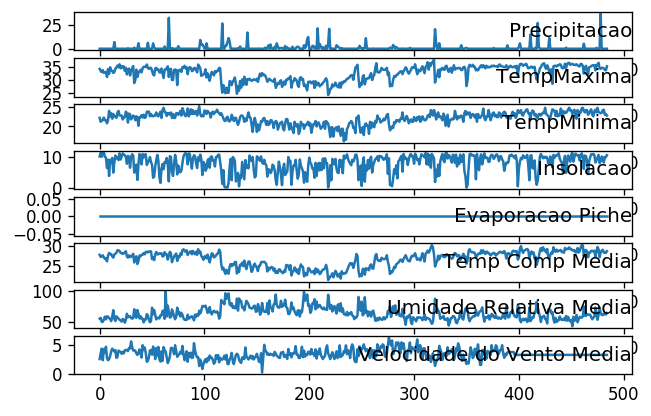

Train on 423 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.8289 - mean_squared_error: 8.2150 - val_loss: 2.2361 - val_mean_squared_error: 5.1030
Epoch 2/1000
 - 0s - loss: 1.7731 - mean_squared_error: 3.3317 - val_loss: 1.1778 - val_mean_squared_error: 1.4827
Epoch 3/1000
 - 0s - loss: 0.6980 - mean_squared_error: 0.6696 - val_loss: 0.2327 - val_mean_squared_error: 0.0597
Epoch 4/1000
 - 0s - loss: 0.3013 - mean_squared_error: 0.1222 - val_loss: 0.3134 - val_mean_squared_error: 0.1100
Epoch 5/1000
 - 0s - loss: 0.2101 - mean_squared_error: 0.0665 - val_loss: 0.1214 - val_mean_squared_error: 0.0162
Epoch 6/1000
 - 0s - loss: 0.1612 - mean_squared_error: 0.0338 - val_loss: 0.1512 - val_mean_squared_error: 0.0238
Epoch 7/1000
 - 0s - loss: 0.1010 - mean_squared_error: 0.0153 - val_loss: 0.0886 - val_mean_squared_error: 0.0101
Epoch 8/1000
 - 0s - loss: 0.0978 - mean_squared_error: 0.0164 - val_loss: 0.0756 - val_mean_squared_error: 0.0063
Epoch 9/1000
 - 0s - loss: 0.0876 - 

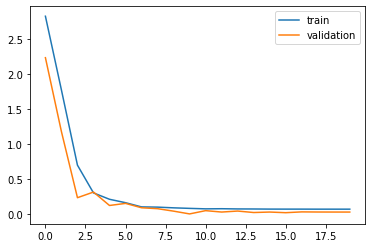


predict: [[33.63141371 23.44167188]]
real:      [[35.4 22.8]]

Train on 422 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.9478 - mean_squared_error: 8.8271 - val_loss: 2.5483 - val_mean_squared_error: 6.5014
Epoch 2/1000
 - 0s - loss: 2.3369 - mean_squared_error: 5.4847 - val_loss: 2.1255 - val_mean_squared_error: 4.5208
Epoch 3/1000
 - 0s - loss: 1.8805 - mean_squared_error: 3.5708 - val_loss: 1.6379 - val_mean_squared_error: 2.6961
Epoch 4/1000
 - 0s - loss: 1.3605 - mean_squared_error: 1.9010 - val_loss: 1.0756 - val_mean_squared_error: 1.1822
Epoch 5/1000
 - 0s - loss: 0.7634 - mean_squared_error: 0.6406 - val_loss: 0.4335 - val_mean_squared_error: 0.1944
Epoch 6/1000
 - 0s - loss: 0.1920 - mean_squared_error: 0.0545 - val_loss: 0.1898 - val_mean_squared_error: 0.0372
Epoch 7/1000
 - 0s - loss: 0.2673 - mean_squared_error: 0.0801 - val_loss: 0.1107 - val_mean_squared_error: 0.0132
Epoch 8/1000
 - 0s - loss: 0.1089 - mean_squared_error: 0.0173 - val_loss: 0.1762 - val

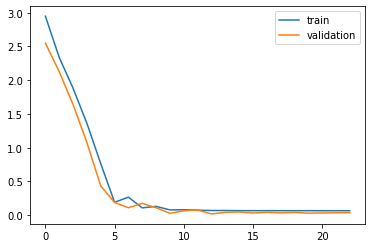


predict: [[34.65202006 22.235458  ]]
real:      [[33.8 23.2]]

Train on 421 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 3.3530 - mean_squared_error: 11.2612 - val_loss: 3.3093 - val_mean_squared_error: 10.9539
Epoch 2/1000
 - 0s - loss: 3.1904 - mean_squared_error: 10.1904 - val_loss: 3.2003 - val_mean_squared_error: 10.2482
Epoch 3/1000
 - 0s - loss: 3.0729 - mean_squared_error: 9.4538 - val_loss: 3.0755 - val_mean_squared_error: 9.4585
Epoch 4/1000
 - 0s - loss: 2.9380 - mean_squared_error: 8.6473 - val_loss: 2.9260 - val_mean_squared_error: 8.5818
Epoch 5/1000
 - 0s - loss: 2.7766 - mean_squared_error: 7.7538 - val_loss: 2.7480 - val_mean_squared_error: 7.5996
Epoch 6/1000
 - 0s - loss: 2.5778 - mean_squared_error: 6.7122 - val_loss: 2.5154 - val_mean_squared_error: 6.3782
Epoch 7/1000
 - 0s - loss: 2.3175 - mean_squared_error: 5.4362 - val_loss: 2.2204 - val_mean_squared_error: 4.9676
Epoch 8/1000
 - 0s - loss: 1.9976 - mean_squared_error: 4.0423 - val_loss: 1.8653 -

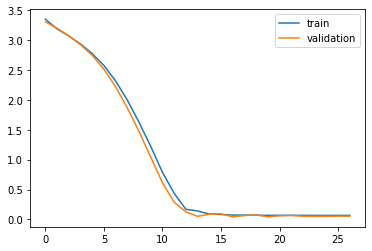


predict: [[34.72894387 22.38700283]]
real:      [[34. 23.]]

Train on 420 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 3.4124 - mean_squared_error: 11.6916 - val_loss: 3.2116 - val_mean_squared_error: 10.3490
Epoch 2/1000
 - 0s - loss: 2.9891 - mean_squared_error: 8.9929 - val_loss: 2.8445 - val_mean_squared_error: 8.1056
Epoch 3/1000
 - 0s - loss: 2.6017 - mean_squared_error: 6.8203 - val_loss: 2.4249 - val_mean_squared_error: 5.9043
Epoch 4/1000
 - 0s - loss: 2.1535 - mean_squared_error: 4.7110 - val_loss: 1.9257 - val_mean_squared_error: 3.7443
Epoch 5/1000
 - 0s - loss: 1.6169 - mean_squared_error: 2.7002 - val_loss: 1.3360 - val_mean_squared_error: 1.8222
Epoch 6/1000
 - 0s - loss: 0.9742 - mean_squared_error: 1.0342 - val_loss: 0.6007 - val_mean_squared_error: 0.3827
Epoch 7/1000
 - 0s - loss: 0.2696 - mean_squared_error: 0.1140 - val_loss: 0.1590 - val_mean_squared_error: 0.0268
Epoch 8/1000
 - 0s - loss: 0.2827 - mean_squared_error: 0.0889 - val_loss: 0.1083 - val

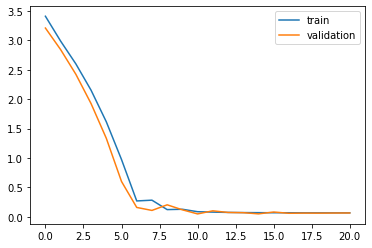


predict: [[36.24690043 22.6307601 ]]
real:      [[34.6 24.3]]

Train on 419 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 3.1506 - mean_squared_error: 10.0128 - val_loss: 2.8420 - val_mean_squared_error: 8.2270
Epoch 2/1000
 - 0s - loss: 2.6018 - mean_squared_error: 7.1034 - val_loss: 2.3716 - val_mean_squared_error: 6.2105
Epoch 3/1000
 - 0s - loss: 2.1381 - mean_squared_error: 5.3610 - val_loss: 1.9180 - val_mean_squared_error: 4.7314
Epoch 4/1000
 - 0s - loss: 1.6660 - mean_squared_error: 4.0540 - val_loss: 1.4250 - val_mean_squared_error: 3.6094
Epoch 5/1000
 - 0s - loss: 1.3204 - mean_squared_error: 3.1067 - val_loss: 1.2454 - val_mean_squared_error: 2.6824
Epoch 6/1000
 - 0s - loss: 1.1176 - mean_squared_error: 2.1815 - val_loss: 0.9902 - val_mean_squared_error: 1.7701
Epoch 7/1000
 - 0s - loss: 0.8726 - mean_squared_error: 1.3539 - val_loss: 0.7759 - val_mean_squared_error: 1.0102
Epoch 8/1000
 - 0s - loss: 0.6155 - mean_squared_error: 0.6797 - val_loss: 0.4771 - va

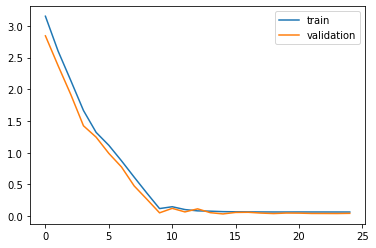


predict: [[35.28685156 22.35155587]]
real:      [[34.8 24.2]]

Train on 418 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 3.1109 - mean_squared_error: 9.7236 - val_loss: 2.8589 - val_mean_squared_error: 8.2013
Epoch 2/1000
 - 0s - loss: 2.5607 - mean_squared_error: 6.6705 - val_loss: 2.3115 - val_mean_squared_error: 5.5238
Epoch 3/1000
 - 0s - loss: 2.0187 - mean_squared_error: 4.4091 - val_loss: 1.7512 - val_mean_squared_error: 3.5614
Epoch 4/1000
 - 0s - loss: 1.4525 - mean_squared_error: 2.8305 - val_loss: 1.1718 - val_mean_squared_error: 2.3592
Epoch 5/1000
 - 0s - loss: 1.0720 - mean_squared_error: 1.9446 - val_loss: 0.9850 - val_mean_squared_error: 1.5829
Epoch 6/1000
 - 0s - loss: 0.8605 - mean_squared_error: 1.2144 - val_loss: 0.7401 - val_mean_squared_error: 0.9263
Epoch 7/1000
 - 0s - loss: 0.6209 - mean_squared_error: 0.6467 - val_loss: 0.5329 - val_mean_squared_error: 0.4296
Epoch 8/1000
 - 0s - loss: 0.3732 - mean_squared_error: 0.2346 - val_loss: 0.2229 - val

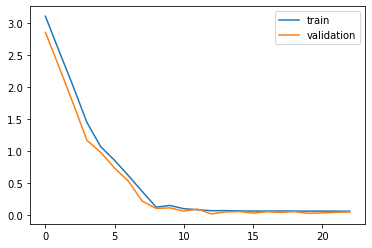


predict: [[36.50692367 24.01375608]]
real:      [[34.8 23.5]]

Train on 417 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.8788 - mean_squared_error: 8.3234 - val_loss: 2.6766 - val_mean_squared_error: 7.1941
Epoch 2/1000
 - 0s - loss: 2.4177 - mean_squared_error: 5.9585 - val_loss: 2.1641 - val_mean_squared_error: 4.8811
Epoch 3/1000
 - 0s - loss: 1.8819 - mean_squared_error: 3.8917 - val_loss: 1.6188 - val_mean_squared_error: 3.1348
Epoch 4/1000
 - 0s - loss: 1.3059 - mean_squared_error: 2.4558 - val_loss: 1.0145 - val_mean_squared_error: 2.0542
Epoch 5/1000
 - 0s - loss: 1.0799 - mean_squared_error: 1.7830 - val_loss: 1.0786 - val_mean_squared_error: 1.6927
Epoch 6/1000
 - 0s - loss: 1.0260 - mean_squared_error: 1.5063 - val_loss: 0.9041 - val_mean_squared_error: 1.4735
Epoch 7/1000
 - 0s - loss: 0.8642 - mean_squared_error: 1.3197 - val_loss: 0.9027 - val_mean_squared_error: 1.3342
Epoch 8/1000
 - 0s - loss: 0.7873 - mean_squared_error: 1.0902 - val_loss: 0.7004 - val

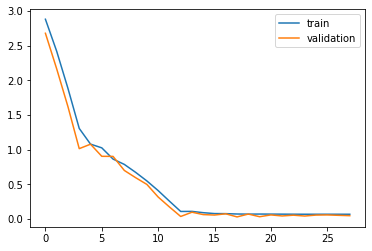


predict: [[33.16761863 22.94561705]]
real:      [[34.4 23.4]]

Train on 416 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.9378 - mean_squared_error: 8.7032 - val_loss: 2.5813 - val_mean_squared_error: 6.6966
Epoch 2/1000
 - 0s - loss: 2.2350 - mean_squared_error: 5.0889 - val_loss: 1.9499 - val_mean_squared_error: 3.9169
Epoch 3/1000
 - 0s - loss: 1.5645 - mean_squared_error: 2.6788 - val_loss: 1.2335 - val_mean_squared_error: 1.8188
Epoch 4/1000
 - 0s - loss: 0.8666 - mean_squared_error: 1.1433 - val_loss: 0.6693 - val_mean_squared_error: 0.7142
Epoch 5/1000
 - 0s - loss: 0.4639 - mean_squared_error: 0.3481 - val_loss: 0.2025 - val_mean_squared_error: 0.0745
Epoch 6/1000
 - 0s - loss: 0.1453 - mean_squared_error: 0.0317 - val_loss: 0.2024 - val_mean_squared_error: 0.0410
Epoch 7/1000
 - 0s - loss: 0.1856 - mean_squared_error: 0.0455 - val_loss: 0.0873 - val_mean_squared_error: 0.0135
Epoch 8/1000
 - 0s - loss: 0.0950 - mean_squared_error: 0.0137 - val_loss: 0.1399 - val

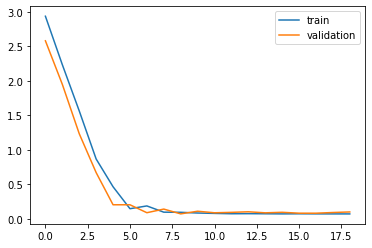


predict: [[33.49603674 23.68574892]]
real:      [[34.6 23.5]]

Train on 415 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.9658 - mean_squared_error: 8.8844 - val_loss: 2.6612 - val_mean_squared_error: 7.1218
Epoch 2/1000
 - 0s - loss: 2.3071 - mean_squared_error: 5.3992 - val_loss: 2.0597 - val_mean_squared_error: 4.2788
Epoch 3/1000
 - 0s - loss: 1.6731 - mean_squared_error: 2.8856 - val_loss: 1.4027 - val_mean_squared_error: 2.0157
Epoch 4/1000
 - 0s - loss: 0.9836 - mean_squared_error: 1.0782 - val_loss: 0.6717 - val_mean_squared_error: 0.5228
Epoch 5/1000
 - 0s - loss: 0.3606 - mean_squared_error: 0.1912 - val_loss: 0.2586 - val_mean_squared_error: 0.0670
Epoch 6/1000
 - 0s - loss: 0.2982 - mean_squared_error: 0.1289 - val_loss: 0.1543 - val_mean_squared_error: 0.0412
Epoch 7/1000
 - 0s - loss: 0.1841 - mean_squared_error: 0.0534 - val_loss: 0.1787 - val_mean_squared_error: 0.0336
Epoch 8/1000
 - 0s - loss: 0.1308 - mean_squared_error: 0.0231 - val_loss: 0.2400 - val

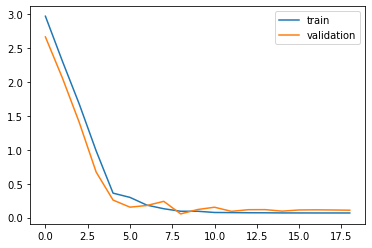


predict: [[37.54783945 22.84454617]]
real:      [[36.8 23.8]]

Train on 414 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 3.0942 - mean_squared_error: 9.7185 - val_loss: 2.5594 - val_mean_squared_error: 6.6173
Epoch 2/1000
 - 0s - loss: 2.0276 - mean_squared_error: 4.3039 - val_loss: 1.5426 - val_mean_squared_error: 2.4735
Epoch 3/1000
 - 0s - loss: 1.1218 - mean_squared_error: 1.4282 - val_loss: 0.7264 - val_mean_squared_error: 0.5907
Epoch 4/1000
 - 0s - loss: 0.3814 - mean_squared_error: 0.2253 - val_loss: 0.1798 - val_mean_squared_error: 0.0337
Epoch 5/1000
 - 0s - loss: 0.2366 - mean_squared_error: 0.0814 - val_loss: 0.1495 - val_mean_squared_error: 0.0322
Epoch 6/1000
 - 0s - loss: 0.1629 - mean_squared_error: 0.0441 - val_loss: 0.1348 - val_mean_squared_error: 0.0190
Epoch 7/1000
 - 0s - loss: 0.1162 - mean_squared_error: 0.0177 - val_loss: 0.1844 - val_mean_squared_error: 0.0359
Epoch 8/1000
 - 0s - loss: 0.0904 - mean_squared_error: 0.0119 - val_loss: 0.0646 - val

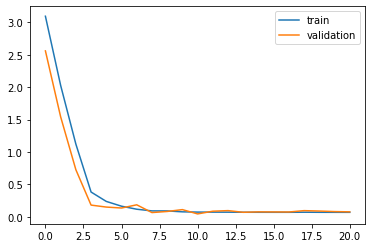


predict: [[35.50068571 22.94455519]]
real:      [[35.8 24.8]]

Train on 413 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 3.3148 - mean_squared_error: 12.7904 - val_loss: 2.9514 - val_mean_squared_error: 10.7298
Epoch 2/1000
 - 0s - loss: 2.6929 - mean_squared_error: 10.1443 - val_loss: 2.4499 - val_mean_squared_error: 10.1075
Epoch 3/1000
 - 0s - loss: 2.2974 - mean_squared_error: 9.8041 - val_loss: 2.1348 - val_mean_squared_error: 8.9451
Epoch 4/1000
 - 0s - loss: 2.0681 - mean_squared_error: 7.9381 - val_loss: 2.0481 - val_mean_squared_error: 7.1088
Epoch 5/1000
 - 0s - loss: 1.8989 - mean_squared_error: 6.6747 - val_loss: 1.8106 - val_mean_squared_error: 6.4061
Epoch 6/1000
 - 0s - loss: 1.7335 - mean_squared_error: 5.7675 - val_loss: 1.6935 - val_mean_squared_error: 5.1785
Epoch 7/1000
 - 0s - loss: 1.5681 - mean_squared_error: 4.7035 - val_loss: 1.4944 - val_mean_squared_error: 4.3276
Epoch 8/1000
 - 0s - loss: 1.4341 - mean_squared_error: 3.9493 - val_loss: 1.4078 -

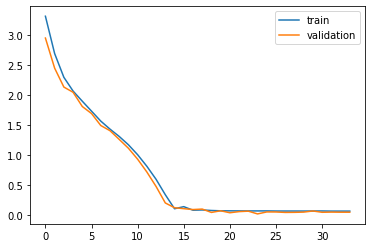


predict: [[33.5551392  23.22410873]]
real:      [[36.  23.6]]

Train on 412 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.1470 - mean_squared_error: 4.8247 - val_loss: 1.2909 - val_mean_squared_error: 1.6739
Epoch 2/1000
 - 0s - loss: 0.6701 - mean_squared_error: 0.6006 - val_loss: 0.0452 - val_mean_squared_error: 0.0038
Epoch 3/1000
 - 0s - loss: 0.3050 - mean_squared_error: 0.1145 - val_loss: 0.1934 - val_mean_squared_error: 0.0381
Epoch 4/1000
 - 0s - loss: 0.1581 - mean_squared_error: 0.0376 - val_loss: 0.2477 - val_mean_squared_error: 0.0629
Epoch 5/1000
 - 0s - loss: 0.1689 - mean_squared_error: 0.0376 - val_loss: 0.1357 - val_mean_squared_error: 0.0184
Epoch 6/1000
 - 0s - loss: 0.1003 - mean_squared_error: 0.0164 - val_loss: 0.0103 - val_mean_squared_error: 1.4340e-04
Epoch 7/1000
 - 0s - loss: 0.0909 - mean_squared_error: 0.0135 - val_loss: 0.1408 - val_mean_squared_error: 0.0209
Epoch 8/1000
 - 0s - loss: 0.0883 - mean_squared_error: 0.0114 - val_loss: 0.0726 -

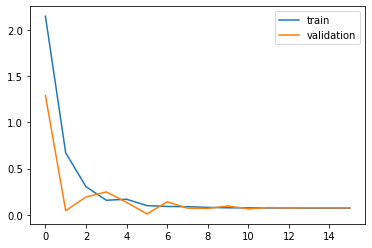


predict: [[36.35341242 24.49223752]]
real:      [[33.8 24.3]]

Train on 411 samples, validate on 1 samples
Epoch 1/1000
 - 2s - loss: 2.3236 - mean_squared_error: 6.2876 - val_loss: 1.8090 - val_mean_squared_error: 4.4919
Epoch 2/1000
 - 0s - loss: 1.4531 - mean_squared_error: 3.4409 - val_loss: 1.3128 - val_mean_squared_error: 2.8184
Epoch 3/1000
 - 0s - loss: 1.2343 - mean_squared_error: 2.2397 - val_loss: 1.1433 - val_mean_squared_error: 1.9383
Epoch 4/1000
 - 0s - loss: 0.9880 - mean_squared_error: 1.5217 - val_loss: 0.8596 - val_mean_squared_error: 1.4529
Epoch 5/1000
 - 0s - loss: 0.8052 - mean_squared_error: 1.1993 - val_loss: 0.7528 - val_mean_squared_error: 1.1316
Epoch 6/1000
 - 0s - loss: 0.6918 - mean_squared_error: 0.8484 - val_loss: 0.6376 - val_mean_squared_error: 0.7733
Epoch 7/1000
 - 0s - loss: 0.5574 - mean_squared_error: 0.5622 - val_loss: 0.4938 - val_mean_squared_error: 0.4728
Epoch 8/1000
 - 0s - loss: 0.4298 - mean_squared_error: 0.2951 - val_loss: 0.4137 - val

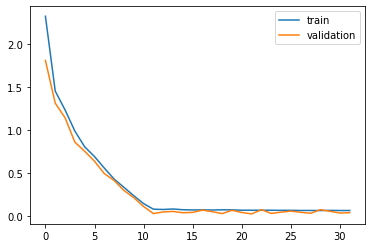


predict: [[33.86079178 22.38976863]]
real:      [[35.8 23.9]]

Train on 410 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 3.3635 - mean_squared_error: 11.7492 - val_loss: 3.0125 - val_mean_squared_error: 9.4865
Epoch 2/1000
 - 0s - loss: 2.7878 - mean_squared_error: 8.1812 - val_loss: 2.6603 - val_mean_squared_error: 7.5680
Epoch 3/1000
 - 0s - loss: 2.4428 - mean_squared_error: 6.4721 - val_loss: 2.2975 - val_mean_squared_error: 5.9010
Epoch 4/1000
 - 0s - loss: 2.0637 - mean_squared_error: 4.9290 - val_loss: 1.8949 - val_mean_squared_error: 4.4062
Epoch 5/1000
 - 0s - loss: 1.6410 - mean_squared_error: 3.5879 - val_loss: 1.4427 - val_mean_squared_error: 3.1489
Epoch 6/1000
 - 0s - loss: 1.1862 - mean_squared_error: 2.4677 - val_loss: 0.9914 - val_mean_squared_error: 1.9043
Epoch 7/1000
 - 0s - loss: 0.7890 - mean_squared_error: 1.1600 - val_loss: 0.6089 - val_mean_squared_error: 0.5412
Epoch 8/1000
 - 0s - loss: 0.3540 - mean_squared_error: 0.2101 - val_loss: 0.1275 - va

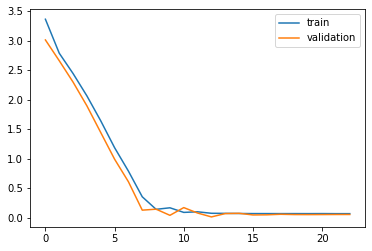


predict: [[34.27901149 23.45467032]]
real:      [[35.8 22.6]]

Train on 409 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 3.0231 - mean_squared_error: 9.4354 - val_loss: 2.5332 - val_mean_squared_error: 6.7565
Epoch 2/1000
 - 0s - loss: 2.1884 - mean_squared_error: 5.3462 - val_loss: 1.9084 - val_mean_squared_error: 4.4608
Epoch 3/1000
 - 0s - loss: 1.5474 - mean_squared_error: 3.5483 - val_loss: 1.2306 - val_mean_squared_error: 3.0068
Epoch 4/1000
 - 0s - loss: 1.1981 - mean_squared_error: 2.4072 - val_loss: 0.9990 - val_mean_squared_error: 1.9071
Epoch 5/1000
 - 0s - loss: 0.8997 - mean_squared_error: 1.4665 - val_loss: 0.8500 - val_mean_squared_error: 1.1890
Epoch 6/1000
 - 0s - loss: 0.6608 - mean_squared_error: 0.7971 - val_loss: 0.5449 - val_mean_squared_error: 0.5379
Epoch 7/1000
 - 0s - loss: 0.4152 - mean_squared_error: 0.3039 - val_loss: 0.3192 - val_mean_squared_error: 0.1515
Epoch 8/1000
 - 0s - loss: 0.1569 - mean_squared_error: 0.0471 - val_loss: 0.0573 - val

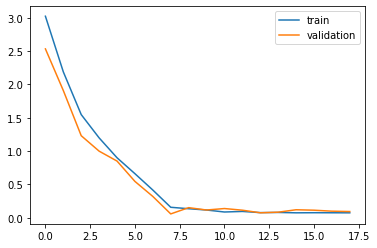


predict: [[37.12987612 22.5073549 ]]
real:      [[35.8 23. ]]

Train on 408 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 2.8901 - mean_squared_error: 8.3855 - val_loss: 2.6464 - val_mean_squared_error: 7.0244
Epoch 2/1000
 - 0s - loss: 2.3482 - mean_squared_error: 5.6282 - val_loss: 2.0836 - val_mean_squared_error: 4.5471
Epoch 3/1000
 - 0s - loss: 1.7780 - mean_squared_error: 3.5625 - val_loss: 1.4924 - val_mean_squared_error: 2.8509
Epoch 4/1000
 - 0s - loss: 1.1873 - mean_squared_error: 2.2541 - val_loss: 0.9825 - val_mean_squared_error: 1.7493
Epoch 5/1000
 - 0s - loss: 0.8120 - mean_squared_error: 1.1438 - val_loss: 0.6352 - val_mean_squared_error: 0.6106
Epoch 6/1000
 - 0s - loss: 0.4191 - mean_squared_error: 0.2873 - val_loss: 0.2281 - val_mean_squared_error: 0.0654
Epoch 7/1000
 - 0s - loss: 0.1270 - mean_squared_error: 0.0249 - val_loss: 0.1012 - val_mean_squared_error: 0.0191
Epoch 8/1000
 - 0s - loss: 0.1803 - mean_squared_error: 0.0474 - val_loss: 0.1013 - val

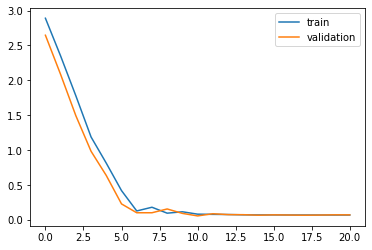


predict: [[31.4273434 24.3387804]]
real:      [[35.4 24.4]]

Train on 407 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 3.0203 - mean_squared_error: 9.1792 - val_loss: 2.7159 - val_mean_squared_error: 7.4312
Epoch 2/1000
 - 0s - loss: 2.3728 - mean_squared_error: 5.7483 - val_loss: 2.0348 - val_mean_squared_error: 4.2754
Epoch 3/1000
 - 0s - loss: 1.6657 - mean_squared_error: 2.9967 - val_loss: 1.2893 - val_mean_squared_error: 1.9201
Epoch 4/1000
 - 0s - loss: 0.8886 - mean_squared_error: 1.1268 - val_loss: 0.6059 - val_mean_squared_error: 0.5508
Epoch 5/1000
 - 0s - loss: 0.5487 - mean_squared_error: 0.3468 - val_loss: 0.4121 - val_mean_squared_error: 0.1907
Epoch 6/1000
 - 0s - loss: 0.3493 - mean_squared_error: 0.1772 - val_loss: 0.1175 - val_mean_squared_error: 0.0178
Epoch 7/1000
 - 0s - loss: 0.1308 - mean_squared_error: 0.0253 - val_loss: 0.2491 - val_mean_squared_error: 0.0669
Epoch 8/1000
 - 0s - loss: 0.1528 - mean_squared_error: 0.0315 - val_loss: 0.0811 - val_m

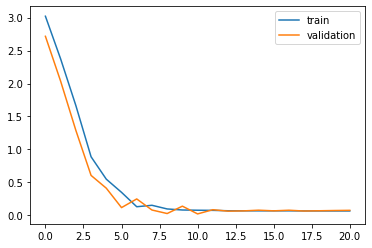


predict: [[34.76269284 23.41250593]]
real:      [[35.2 24. ]]

Train on 406 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 2.3074 - mean_squared_error: 5.4602 - val_loss: 1.6138 - val_mean_squared_error: 2.6303
Epoch 2/1000
 - 0s - loss: 1.1779 - mean_squared_error: 1.5391 - val_loss: 0.5622 - val_mean_squared_error: 0.4311
Epoch 3/1000
 - 0s - loss: 0.3962 - mean_squared_error: 0.2170 - val_loss: 0.3386 - val_mean_squared_error: 0.1497
Epoch 4/1000
 - 0s - loss: 0.3192 - mean_squared_error: 0.1592 - val_loss: 0.1775 - val_mean_squared_error: 0.0550
Epoch 5/1000
 - 0s - loss: 0.1324 - mean_squared_error: 0.0298 - val_loss: 0.1575 - val_mean_squared_error: 0.0248
Epoch 6/1000
 - 0s - loss: 0.1203 - mean_squared_error: 0.0212 - val_loss: 0.0673 - val_mean_squared_error: 0.0046
Epoch 7/1000
 - 0s - loss: 0.0964 - mean_squared_error: 0.0140 - val_loss: 0.0303 - val_mean_squared_error: 0.0012
Epoch 8/1000
 - 0s - loss: 0.0793 - mean_squared_error: 0.0094 - val_loss: 0.0807 - val

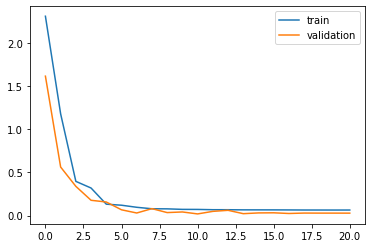


predict: [[32.15218564 22.11717037]]
real:      [[35.  23.4]]

Train on 405 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 3.0642 - mean_squared_error: 9.5878 - val_loss: 2.6775 - val_mean_squared_error: 7.2388
Epoch 2/1000
 - 0s - loss: 2.3820 - mean_squared_error: 5.7823 - val_loss: 2.0785 - val_mean_squared_error: 4.3741
Epoch 3/1000
 - 0s - loss: 1.7255 - mean_squared_error: 3.0963 - val_loss: 1.3204 - val_mean_squared_error: 1.8098
Epoch 4/1000
 - 0s - loss: 0.9194 - mean_squared_error: 0.9955 - val_loss: 0.4677 - val_mean_squared_error: 0.2963
Epoch 5/1000
 - 0s - loss: 0.2949 - mean_squared_error: 0.1293 - val_loss: 0.2017 - val_mean_squared_error: 0.0506
Epoch 6/1000
 - 0s - loss: 0.2852 - mean_squared_error: 0.0952 - val_loss: 0.1113 - val_mean_squared_error: 0.0153
Epoch 7/1000
 - 0s - loss: 0.1254 - mean_squared_error: 0.0234 - val_loss: 0.2327 - val_mean_squared_error: 0.0580
Epoch 8/1000
 - 0s - loss: 0.1320 - mean_squared_error: 0.0234 - val_loss: 0.0781 - val

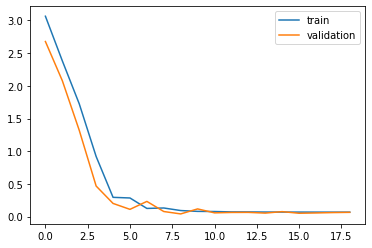


predict: [[35.14586513 23.25388806]]
real:      [[32.3 23. ]]

Train on 404 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 3.4628 - mean_squared_error: 12.3041 - val_loss: 3.1920 - val_mean_squared_error: 10.5276
Epoch 2/1000
 - 0s - loss: 2.9189 - mean_squared_error: 8.9776 - val_loss: 2.7574 - val_mean_squared_error: 8.1296
Epoch 3/1000
 - 0s - loss: 2.5519 - mean_squared_error: 7.1761 - val_loss: 2.4484 - val_mean_squared_error: 6.7869
Epoch 4/1000
 - 0s - loss: 2.2254 - mean_squared_error: 5.9094 - val_loss: 2.1027 - val_mean_squared_error: 5.5816
Epoch 5/1000
 - 0s - loss: 1.8553 - mean_squared_error: 4.8513 - val_loss: 1.6517 - val_mean_squared_error: 4.4223
Epoch 6/1000
 - 0s - loss: 1.4338 - mean_squared_error: 3.6869 - val_loss: 1.3262 - val_mean_squared_error: 3.0942
Epoch 7/1000
 - 0s - loss: 1.2006 - mean_squared_error: 2.3870 - val_loss: 0.9615 - val_mean_squared_error: 1.8232
Epoch 8/1000
 - 0s - loss: 0.8424 - mean_squared_error: 1.2917 - val_loss: 0.7566 - v

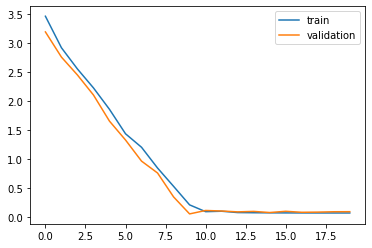


predict: [[32.98878239 24.27369129]]
real:      [[34.1 24.2]]

Train on 403 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 2.8031 - mean_squared_error: 8.1009 - val_loss: 2.4962 - val_mean_squared_error: 6.5382
Epoch 2/1000
 - 0s - loss: 2.2097 - mean_squared_error: 5.3585 - val_loss: 1.9279 - val_mean_squared_error: 4.4139
Epoch 3/1000
 - 0s - loss: 1.6169 - mean_squared_error: 3.5381 - val_loss: 1.2921 - val_mean_squared_error: 2.8660
Epoch 4/1000
 - 0s - loss: 1.1564 - mean_squared_error: 2.2772 - val_loss: 0.9949 - val_mean_squared_error: 1.7276
Epoch 5/1000
 - 0s - loss: 0.8351 - mean_squared_error: 1.2121 - val_loss: 0.7326 - val_mean_squared_error: 0.7860
Epoch 6/1000
 - 0s - loss: 0.4955 - mean_squared_error: 0.4273 - val_loss: 0.3244 - val_mean_squared_error: 0.1783
Epoch 7/1000
 - 0s - loss: 0.1956 - mean_squared_error: 0.0637 - val_loss: 0.0754 - val_mean_squared_error: 0.0105
Epoch 8/1000
 - 0s - loss: 0.1548 - mean_squared_error: 0.0365 - val_loss: 0.1497 - val

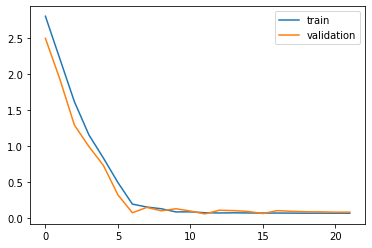


predict: [[35.54979178 21.91817154]]
real:      [[35.6 24.2]]

Train on 402 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 3.6652 - mean_squared_error: 13.7718 - val_loss: 3.4792 - val_mean_squared_error: 12.3666
Epoch 2/1000
 - 0s - loss: 3.3115 - mean_squared_error: 11.3275 - val_loss: 3.1769 - val_mean_squared_error: 10.5093
Epoch 3/1000
 - 0s - loss: 3.0288 - mean_squared_error: 9.7207 - val_loss: 2.9267 - val_mean_squared_error: 9.1516
Epoch 4/1000
 - 0s - loss: 2.7943 - mean_squared_error: 8.6119 - val_loss: 2.7166 - val_mean_squared_error: 8.3759
Epoch 5/1000
 - 0s - loss: 2.5789 - mean_squared_error: 7.9288 - val_loss: 2.4845 - val_mean_squared_error: 7.6781
Epoch 6/1000
 - 0s - loss: 2.3350 - mean_squared_error: 7.3483 - val_loss: 2.2147 - val_mean_squared_error: 7.2042
Epoch 7/1000
 - 0s - loss: 2.0526 - mean_squared_error: 7.0832 - val_loss: 1.9070 - val_mean_squared_error: 7.1289
Epoch 8/1000
 - 0s - loss: 1.8953 - mean_squared_error: 6.8042 - val_loss: 1.8060 -

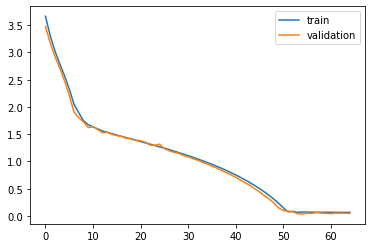


predict: [[31.86625418 23.25280096]]
real:      [[35.  23.6]]

Train on 401 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 3.0556 - mean_squared_error: 9.5071 - val_loss: 2.8588 - val_mean_squared_error: 8.4340
Epoch 2/1000
 - 0s - loss: 2.5663 - mean_squared_error: 6.9772 - val_loss: 2.4097 - val_mean_squared_error: 6.2641
Epoch 3/1000
 - 0s - loss: 2.1217 - mean_squared_error: 5.1450 - val_loss: 1.9453 - val_mean_squared_error: 4.6228
Epoch 4/1000
 - 0s - loss: 1.6412 - mean_squared_error: 3.7793 - val_loss: 1.4430 - val_mean_squared_error: 3.4076
Epoch 5/1000
 - 0s - loss: 1.2646 - mean_squared_error: 2.8443 - val_loss: 1.1731 - val_mean_squared_error: 2.4971
Epoch 6/1000
 - 0s - loss: 1.0815 - mean_squared_error: 1.9944 - val_loss: 0.9771 - val_mean_squared_error: 1.6796
Epoch 7/1000
 - 0s - loss: 0.8373 - mean_squared_error: 1.2546 - val_loss: 0.8102 - val_mean_squared_error: 0.9972
Epoch 8/1000
 - 0s - loss: 0.5971 - mean_squared_error: 0.6370 - val_loss: 0.4640 - val

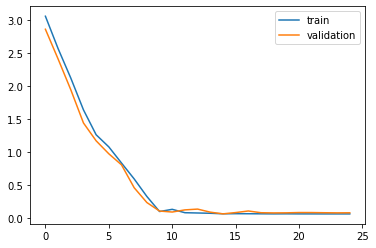


predict: [[34.91669642 21.82628584]]
real:      [[32.5 24. ]]

Train on 400 samples, validate on 1 samples
Epoch 1/1000
 - 4s - loss: 2.4245 - mean_squared_error: 6.0837 - val_loss: 1.8228 - val_mean_squared_error: 3.4593
Epoch 2/1000
 - 0s - loss: 1.2582 - mean_squared_error: 1.8519 - val_loss: 0.6531 - val_mean_squared_error: 0.6138
Epoch 3/1000
 - 0s - loss: 0.3820 - mean_squared_error: 0.2244 - val_loss: 0.1267 - val_mean_squared_error: 0.0200
Epoch 4/1000
 - 0s - loss: 0.2291 - mean_squared_error: 0.0700 - val_loss: 0.1852 - val_mean_squared_error: 0.0541
Epoch 5/1000
 - 0s - loss: 0.1568 - mean_squared_error: 0.0337 - val_loss: 0.2302 - val_mean_squared_error: 0.0532
Epoch 6/1000
 - 0s - loss: 0.1104 - mean_squared_error: 0.0178 - val_loss: 0.0587 - val_mean_squared_error: 0.0064
Epoch 7/1000
 - 0s - loss: 0.0909 - mean_squared_error: 0.0134 - val_loss: 0.1658 - val_mean_squared_error: 0.0334
Epoch 8/1000
 - 0s - loss: 0.0905 - mean_squared_error: 0.0123 - val_loss: 0.0837 - val

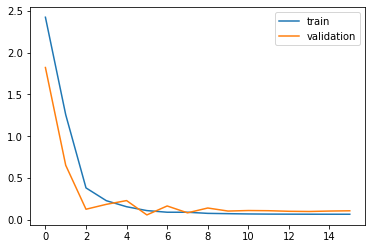


predict: [[32.53334579 24.790137  ]]
real:      [[35.6 24.8]]

Train on 399 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 3.3427 - mean_squared_error: 11.1830 - val_loss: 3.3400 - val_mean_squared_error: 11.1554
Epoch 2/1000
 - 0s - loss: 3.1582 - mean_squared_error: 9.9875 - val_loss: 3.1365 - val_mean_squared_error: 9.8517
Epoch 3/1000
 - 0s - loss: 2.9488 - mean_squared_error: 8.7888 - val_loss: 2.8960 - val_mean_squared_error: 8.6101
Epoch 4/1000
 - 0s - loss: 2.6919 - mean_squared_error: 7.7622 - val_loss: 2.5853 - val_mean_squared_error: 7.5858
Epoch 5/1000
 - 0s - loss: 2.2902 - mean_squared_error: 6.6428 - val_loss: 2.0511 - val_mean_squared_error: 6.2178
Epoch 6/1000
 - 0s - loss: 1.7845 - mean_squared_error: 5.5906 - val_loss: 1.6482 - val_mean_squared_error: 5.0998
Epoch 7/1000
 - 0s - loss: 1.5417 - mean_squared_error: 4.2836 - val_loss: 1.4382 - val_mean_squared_error: 3.5111
Epoch 8/1000
 - 0s - loss: 1.2643 - mean_squared_error: 2.7853 - val_loss: 1.1862 - v

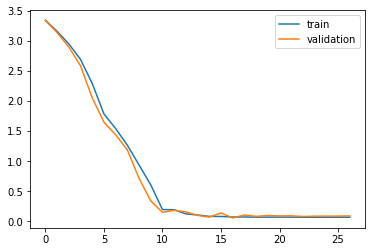


predict: [[34.69182275 22.34311158]]
real:      [[36.2 24.7]]

Train on 398 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 2.8057 - mean_squared_error: 7.9303 - val_loss: 2.5118 - val_mean_squared_error: 6.3428
Epoch 2/1000
 - 0s - loss: 2.2088 - mean_squared_error: 4.9443 - val_loss: 1.9172 - val_mean_squared_error: 3.6824
Epoch 3/1000
 - 0s - loss: 1.5908 - mean_squared_error: 2.5735 - val_loss: 1.2729 - val_mean_squared_error: 1.6250
Epoch 4/1000
 - 0s - loss: 0.9119 - mean_squared_error: 0.8888 - val_loss: 0.5428 - val_mean_squared_error: 0.3145
Epoch 5/1000
 - 0s - loss: 0.2519 - mean_squared_error: 0.0983 - val_loss: 0.1198 - val_mean_squared_error: 0.0144
Epoch 6/1000
 - 0s - loss: 0.2357 - mean_squared_error: 0.0742 - val_loss: 0.1908 - val_mean_squared_error: 0.0435
Epoch 7/1000
 - 0s - loss: 0.1421 - mean_squared_error: 0.0325 - val_loss: 0.1245 - val_mean_squared_error: 0.0181
Epoch 8/1000
 - 0s - loss: 0.1207 - mean_squared_error: 0.0205 - val_loss: 0.1304 - val

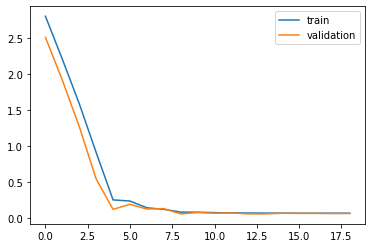


predict: [[32.93499307 24.65577925]]
real:      [[36.4 23.6]]

Train on 397 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 2.8600 - mean_squared_error: 8.2183 - val_loss: 2.5854 - val_mean_squared_error: 6.6967
Epoch 2/1000
 - 0s - loss: 2.3420 - mean_squared_error: 5.5184 - val_loss: 2.0660 - val_mean_squared_error: 4.2708
Epoch 3/1000
 - 0s - loss: 1.7948 - mean_squared_error: 3.2550 - val_loss: 1.4897 - val_mean_squared_error: 2.2319
Epoch 4/1000
 - 0s - loss: 1.1946 - mean_squared_error: 1.5167 - val_loss: 0.8400 - val_mean_squared_error: 0.8026
Epoch 5/1000
 - 0s - loss: 0.5791 - mean_squared_error: 0.4822 - val_loss: 0.4263 - val_mean_squared_error: 0.2163
Epoch 6/1000
 - 0s - loss: 0.4447 - mean_squared_error: 0.2109 - val_loss: 0.3821 - val_mean_squared_error: 0.1487
Epoch 7/1000
 - 0s - loss: 0.3697 - mean_squared_error: 0.1595 - val_loss: 0.2576 - val_mean_squared_error: 0.0682
Epoch 8/1000
 - 0s - loss: 0.2317 - mean_squared_error: 0.0662 - val_loss: 0.1050 - val

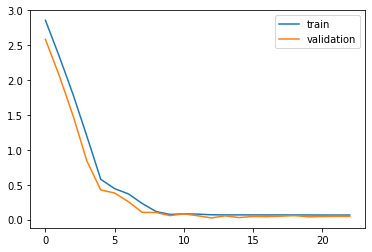


predict: [[33.44408886 22.56216996]]
real:      [[35.4 23.8]]

Train on 396 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 3.0714 - mean_squared_error: 9.4802 - val_loss: 2.8668 - val_mean_squared_error: 8.2816
Epoch 2/1000
 - 0s - loss: 2.5810 - mean_squared_error: 6.8187 - val_loss: 2.3943 - val_mean_squared_error: 5.9894
Epoch 3/1000
 - 0s - loss: 2.1114 - mean_squared_error: 4.8440 - val_loss: 1.9155 - val_mean_squared_error: 4.2398
Epoch 4/1000
 - 0s - loss: 1.6122 - mean_squared_error: 3.3874 - val_loss: 1.3747 - val_mean_squared_error: 2.9859
Epoch 5/1000
 - 0s - loss: 1.1998 - mean_squared_error: 2.4724 - val_loss: 1.1422 - val_mean_squared_error: 2.2401
Epoch 6/1000
 - 0s - loss: 1.0429 - mean_squared_error: 1.8216 - val_loss: 0.9930 - val_mean_squared_error: 1.6470
Epoch 7/1000
 - 0s - loss: 0.8467 - mean_squared_error: 1.2637 - val_loss: 0.7841 - val_mean_squared_error: 1.0591
Epoch 8/1000
 - 0s - loss: 0.6522 - mean_squared_error: 0.7406 - val_loss: 0.5571 - val

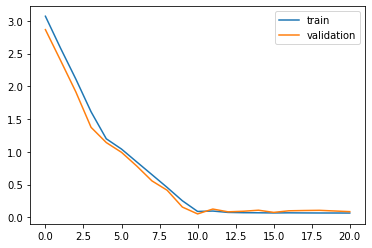


predict: [[32.73285184 24.67288756]]
real:      [[35.4 22.6]]

Train on 395 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 2.8291 - mean_squared_error: 8.1969 - val_loss: 2.4489 - val_mean_squared_error: 6.3661
Epoch 2/1000
 - 0s - loss: 2.1051 - mean_squared_error: 4.8835 - val_loss: 1.6862 - val_mean_squared_error: 3.5432
Epoch 3/1000
 - 0s - loss: 1.3395 - mean_squared_error: 2.5479 - val_loss: 1.0070 - val_mean_squared_error: 1.8742
Epoch 4/1000
 - 0s - loss: 0.8909 - mean_squared_error: 1.2634 - val_loss: 0.7283 - val_mean_squared_error: 0.7902
Epoch 5/1000
 - 0s - loss: 0.4873 - mean_squared_error: 0.3901 - val_loss: 0.3052 - val_mean_squared_error: 0.1213
Epoch 6/1000
 - 0s - loss: 0.1602 - mean_squared_error: 0.0390 - val_loss: 0.1297 - val_mean_squared_error: 0.0221
Epoch 7/1000
 - 0s - loss: 0.1839 - mean_squared_error: 0.0540 - val_loss: 0.0408 - val_mean_squared_error: 0.0019
Epoch 8/1000
 - 0s - loss: 0.0893 - mean_squared_error: 0.0119 - val_loss: 0.1352 - val

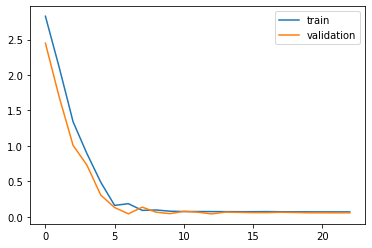


predict: [[34.05262253 22.18155776]]
real:      [[35.8 24.2]]

Train on 394 samples, validate on 1 samples
Epoch 1/1000
 - 3s - loss: 3.2498 - mean_squared_error: 10.6216 - val_loss: 2.9848 - val_mean_squared_error: 8.9757
Epoch 2/1000
 - 0s - loss: 2.7477 - mean_squared_error: 7.6339 - val_loss: 2.5157 - val_mean_squared_error: 6.4556
Epoch 3/1000
 - 0s - loss: 2.2439 - mean_squared_error: 5.2033 - val_loss: 1.9329 - val_mean_squared_error: 3.9809
Epoch 4/1000
 - 0s - loss: 1.6107 - mean_squared_error: 2.9028 - val_loss: 1.2258 - val_mean_squared_error: 1.9394
Epoch 5/1000
 - 0s - loss: 0.8900 - mean_squared_error: 1.2176 - val_loss: 0.7201 - val_mean_squared_error: 0.7037
Epoch 6/1000
 - 0s - loss: 0.5554 - mean_squared_error: 0.3762 - val_loss: 0.3382 - val_mean_squared_error: 0.1170
Epoch 7/1000
 - 0s - loss: 0.1626 - mean_squared_error: 0.0390 - val_loss: 0.1533 - val_mean_squared_error: 0.0241
Epoch 8/1000
 - 0s - loss: 0.2166 - mean_squared_error: 0.0551 - val_loss: 0.0899 - va

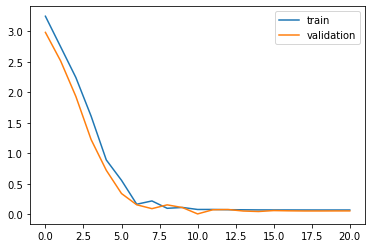


predict: [[35.85555345 22.41065658]]
real:      [[36.2 22. ]]

Train and validation time: 4.97 minutes

Maximum temperatures metrics
Test MEAN-SQUARED-ERROR ------------ 4.028
Test STANDART-DEVIATION ------------ 1.016
Test MEAN-ABSOLUTE-ERROR ----------- 1.731
Test MEDIAN-ABSOLUTE-ERROR --------- 1.677

Errors
2015-04-30 = 1.768586289238641
2015-04-29 = 0.8520200632586779
2015-04-28 = 0.7289438704223841
2015-04-27 = 1.6469004254349855
2015-04-26 = 0.486851557022149
2015-04-25 = 1.706923666004215
2015-04-24 = 1.232381371802532
2015-04-23 = 1.103963255749413
2015-04-22 = 0.7478394492731937
2015-04-21 = 0.29931428741638655
2015-04-20 = 2.444860801301836
2015-04-19 = 2.5534124164321526
2015-04-18 = 1.9392082220140523
2015-04-17 = 1.5209885076226186
2015-04-16 = 1.3298761237173267
2015-04-15 = 3.9726566027633687
2015-04-14 = 0.4373071618900539
2015-04-13 = 2.8478143563757925
2015-04-12 = 2.845865125851944
2015-04-11 = 1.1112176101764177
2015-04-10 = 0.05020821635510231
2015-04-09 = 3.1337

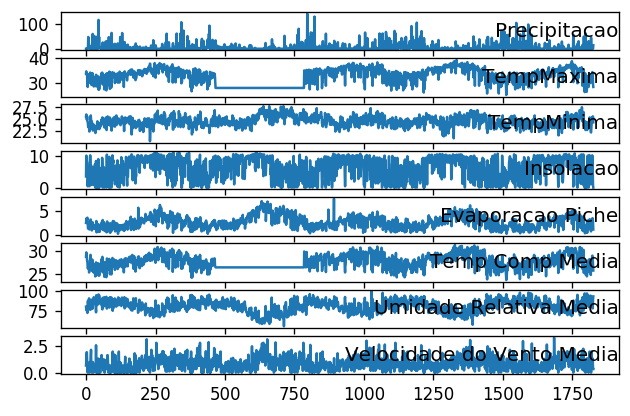

Train on 1764 samples, validate on 1 samples
Epoch 1/1000
 - 4s - loss: 2.7766 - mean_squared_error: 8.9261 - val_loss: 2.0323 - val_mean_squared_error: 6.6700
Epoch 2/1000
 - 1s - loss: 1.5746 - mean_squared_error: 4.7836 - val_loss: 0.9856 - val_mean_squared_error: 1.7732
Epoch 3/1000
 - 1s - loss: 0.5283 - mean_squared_error: 0.6879 - val_loss: 0.1337 - val_mean_squared_error: 0.0263
Epoch 4/1000
 - 1s - loss: 0.0734 - mean_squared_error: 0.0107 - val_loss: 0.0787 - val_mean_squared_error: 0.0069
Epoch 5/1000
 - 1s - loss: 0.0576 - mean_squared_error: 0.0060 - val_loss: 0.0763 - val_mean_squared_error: 0.0088
Epoch 6/1000
 - 1s - loss: 0.0561 - mean_squared_error: 0.0060 - val_loss: 0.0782 - val_mean_squared_error: 0.0073
Epoch 7/1000
 - 1s - loss: 0.0563 - mean_squared_error: 0.0059 - val_loss: 0.0768 - val_mean_squared_error: 0.0076
Epoch 8/1000
 - 1s - loss: 0.0565 - mean_squared_error: 0.0059 - val_loss: 0.0616 - val_mean_squared_error: 0.0056
Epoch 9/1000
 - 1s - loss: 0.0558 -

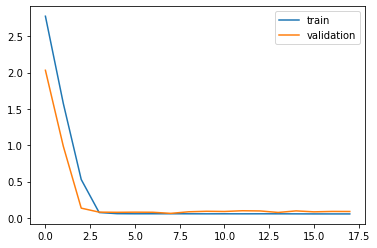


predict: [[32.03709672 24.8729224 ]]
real:      [[28.2 24.3]]

Train on 1763 samples, validate on 1 samples
Epoch 1/1000
 - 4s - loss: 2.4612 - mean_squared_error: 6.7044 - val_loss: 1.5090 - val_mean_squared_error: 3.2923
Epoch 2/1000
 - 1s - loss: 0.7851 - mean_squared_error: 1.3310 - val_loss: 0.1353 - val_mean_squared_error: 0.0234
Epoch 3/1000
 - 1s - loss: 0.1177 - mean_squared_error: 0.0224 - val_loss: 0.0602 - val_mean_squared_error: 0.0040
Epoch 4/1000
 - 1s - loss: 0.0671 - mean_squared_error: 0.0073 - val_loss: 0.0468 - val_mean_squared_error: 0.0023
Epoch 5/1000
 - 1s - loss: 0.0587 - mean_squared_error: 0.0063 - val_loss: 0.0161 - val_mean_squared_error: 4.1499e-04
Epoch 6/1000
 - 1s - loss: 0.0573 - mean_squared_error: 0.0061 - val_loss: 0.0404 - val_mean_squared_error: 0.0018
Epoch 7/1000
 - 1s - loss: 0.0570 - mean_squared_error: 0.0061 - val_loss: 0.0246 - val_mean_squared_error: 8.1168e-04
Epoch 8/1000
 - 1s - loss: 0.0566 - mean_squared_error: 0.0060 - val_loss: 0.0

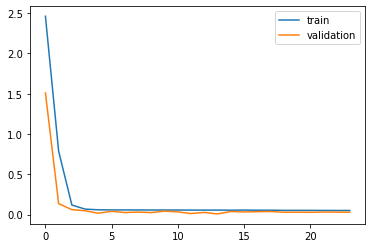


predict: [[32.96259368 25.19195716]]
real:      [[29.3 25.5]]

Train on 1762 samples, validate on 1 samples
Epoch 1/1000
 - 4s - loss: 2.2273 - mean_squared_error: 5.4389 - val_loss: 0.9249 - val_mean_squared_error: 1.2788
Epoch 2/1000
 - 1s - loss: 0.4131 - mean_squared_error: 0.3426 - val_loss: 0.1185 - val_mean_squared_error: 0.0257
Epoch 3/1000
 - 1s - loss: 0.0844 - mean_squared_error: 0.0113 - val_loss: 0.0392 - val_mean_squared_error: 0.0017
Epoch 4/1000
 - 1s - loss: 0.0628 - mean_squared_error: 0.0070 - val_loss: 0.0365 - val_mean_squared_error: 0.0017
Epoch 5/1000
 - 1s - loss: 0.0607 - mean_squared_error: 0.0066 - val_loss: 0.0106 - val_mean_squared_error: 1.2236e-04
Epoch 6/1000
 - 1s - loss: 0.0587 - mean_squared_error: 0.0063 - val_loss: 0.0256 - val_mean_squared_error: 0.0010
Epoch 7/1000
 - 1s - loss: 0.0586 - mean_squared_error: 0.0062 - val_loss: 0.0161 - val_mean_squared_error: 4.0517e-04
Epoch 8/1000
 - 1s - loss: 0.0575 - mean_squared_error: 0.0061 - val_loss: 0.0

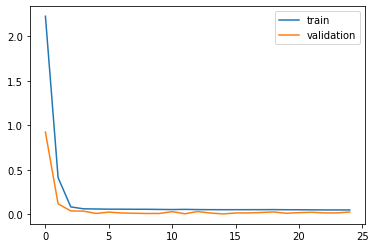


predict: [[33.76293726 24.24231679]]
real:      [[32.7 25.4]]

Train on 1761 samples, validate on 1 samples
Epoch 1/1000
 - 4s - loss: 1.7535 - mean_squared_error: 3.9660 - val_loss: 0.6696 - val_mean_squared_error: 0.5918
Epoch 2/1000
 - 1s - loss: 0.2369 - mean_squared_error: 0.1230 - val_loss: 0.0526 - val_mean_squared_error: 0.0049
Epoch 3/1000
 - 1s - loss: 0.0650 - mean_squared_error: 0.0069 - val_loss: 0.0377 - val_mean_squared_error: 0.0020
Epoch 4/1000
 - 1s - loss: 0.0577 - mean_squared_error: 0.0063 - val_loss: 0.0092 - val_mean_squared_error: 9.2701e-05
Epoch 5/1000
 - 1s - loss: 0.0566 - mean_squared_error: 0.0059 - val_loss: 0.0229 - val_mean_squared_error: 6.4016e-04
Epoch 6/1000
 - 1s - loss: 0.0555 - mean_squared_error: 0.0059 - val_loss: 0.0220 - val_mean_squared_error: 6.5656e-04
Epoch 7/1000
 - 1s - loss: 0.0552 - mean_squared_error: 0.0059 - val_loss: 0.0395 - val_mean_squared_error: 0.0016
Epoch 8/1000
 - 1s - loss: 0.0550 - mean_squared_error: 0.0058 - val_loss:

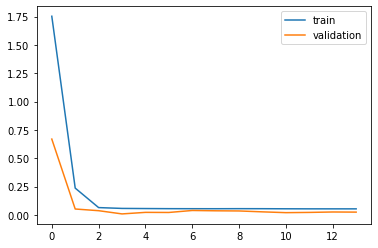


predict: [[34.0340327  25.19226315]]
real:      [[34.3 24.3]]

Train on 1760 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 1.5124 - mean_squared_error: 3.4065 - val_loss: 0.2793 - val_mean_squared_error: 0.0783
Epoch 2/1000
 - 1s - loss: 0.1585 - mean_squared_error: 0.0396 - val_loss: 0.0429 - val_mean_squared_error: 0.0029
Epoch 3/1000
 - 1s - loss: 0.0783 - mean_squared_error: 0.0098 - val_loss: 0.0076 - val_mean_squared_error: 6.8138e-05
Epoch 4/1000
 - 1s - loss: 0.0633 - mean_squared_error: 0.0071 - val_loss: 0.0311 - val_mean_squared_error: 9.7671e-04
Epoch 5/1000
 - 1s - loss: 0.0606 - mean_squared_error: 0.0066 - val_loss: 0.0211 - val_mean_squared_error: 5.0118e-04
Epoch 6/1000
 - 1s - loss: 0.0590 - mean_squared_error: 0.0064 - val_loss: 0.0308 - val_mean_squared_error: 9.5010e-04
Epoch 7/1000
 - 1s - loss: 0.0582 - mean_squared_error: 0.0064 - val_loss: 0.0234 - val_mean_squared_error: 5.4655e-04
Epoch 8/1000
 - 1s - loss: 0.0575 - mean_squared_error: 0.0061 - v

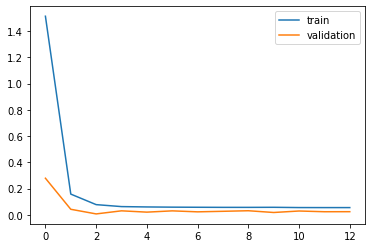


predict: [[33.75643997 25.53870594]]
real:      [[34.2 25.4]]

Train on 1759 samples, validate on 1 samples
Epoch 1/1000
 - 4s - loss: 1.8832 - mean_squared_error: 4.4494 - val_loss: 0.2744 - val_mean_squared_error: 0.0836
Epoch 2/1000
 - 1s - loss: 0.1828 - mean_squared_error: 0.0599 - val_loss: 0.1015 - val_mean_squared_error: 0.0106
Epoch 3/1000
 - 1s - loss: 0.0666 - mean_squared_error: 0.0077 - val_loss: 0.0523 - val_mean_squared_error: 0.0030
Epoch 4/1000
 - 1s - loss: 0.0583 - mean_squared_error: 0.0062 - val_loss: 0.0229 - val_mean_squared_error: 7.7443e-04
Epoch 5/1000
 - 1s - loss: 0.0571 - mean_squared_error: 0.0060 - val_loss: 0.0304 - val_mean_squared_error: 0.0012
Epoch 6/1000
 - 1s - loss: 0.0566 - mean_squared_error: 0.0060 - val_loss: 0.0438 - val_mean_squared_error: 0.0021
Epoch 7/1000
 - 1s - loss: 0.0558 - mean_squared_error: 0.0059 - val_loss: 0.0302 - val_mean_squared_error: 0.0013
Epoch 8/1000
 - 1s - loss: 0.0559 - mean_squared_error: 0.0059 - val_loss: 0.0264 

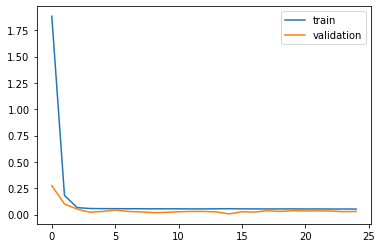


predict: [[32.08110138 24.07729087]]
real:      [[32.7 25.1]]

Train on 1758 samples, validate on 1 samples
Epoch 1/1000
 - 4s - loss: 2.7972 - mean_squared_error: 8.3742 - val_loss: 1.7765 - val_mean_squared_error: 4.7203
Epoch 2/1000
 - 1s - loss: 1.1763 - mean_squared_error: 2.6608 - val_loss: 0.5344 - val_mean_squared_error: 0.5498
Epoch 3/1000
 - 1s - loss: 0.1834 - mean_squared_error: 0.0930 - val_loss: 0.0956 - val_mean_squared_error: 0.0130
Epoch 4/1000
 - 1s - loss: 0.0680 - mean_squared_error: 0.0083 - val_loss: 0.0594 - val_mean_squared_error: 0.0037
Epoch 5/1000
 - 1s - loss: 0.0578 - mean_squared_error: 0.0062 - val_loss: 0.0319 - val_mean_squared_error: 0.0018
Epoch 6/1000
 - 1s - loss: 0.0577 - mean_squared_error: 0.0063 - val_loss: 0.0377 - val_mean_squared_error: 0.0017
Epoch 7/1000
 - 1s - loss: 0.0561 - mean_squared_error: 0.0059 - val_loss: 0.0315 - val_mean_squared_error: 0.0019
Epoch 8/1000
 - 1s - loss: 0.0556 - mean_squared_error: 0.0058 - val_loss: 0.0277 - va

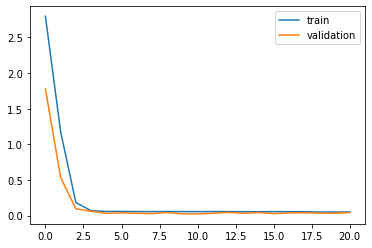


predict: [[33.32073443 23.58277311]]
real:      [[32.5 24.1]]

Train on 1757 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 1.5159 - mean_squared_error: 3.0516 - val_loss: 0.3336 - val_mean_squared_error: 0.1113
Epoch 2/1000
 - 1s - loss: 0.1595 - mean_squared_error: 0.0371 - val_loss: 0.1212 - val_mean_squared_error: 0.0156
Epoch 3/1000
 - 1s - loss: 0.0745 - mean_squared_error: 0.0093 - val_loss: 0.0418 - val_mean_squared_error: 0.0034
Epoch 4/1000
 - 1s - loss: 0.0629 - mean_squared_error: 0.0071 - val_loss: 0.0521 - val_mean_squared_error: 0.0043
Epoch 5/1000
 - 1s - loss: 0.0612 - mean_squared_error: 0.0068 - val_loss: 0.0449 - val_mean_squared_error: 0.0030
Epoch 6/1000
 - 1s - loss: 0.0597 - mean_squared_error: 0.0064 - val_loss: 0.0577 - val_mean_squared_error: 0.0046
Epoch 7/1000
 - 1s - loss: 0.0582 - mean_squared_error: 0.0063 - val_loss: 0.0490 - val_mean_squared_error: 0.0045
Epoch 8/1000
 - 1s - loss: 0.0577 - mean_squared_error: 0.0062 - val_loss: 0.0515 - va

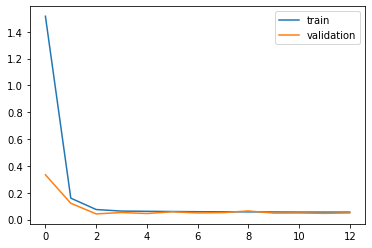


predict: [[34.8384541 25.9599077]]
real:      [[33.  23.1]]

Train on 1756 samples, validate on 1 samples
Epoch 1/1000
 - 4s - loss: 2.9072 - mean_squared_error: 9.2794 - val_loss: 2.0175 - val_mean_squared_error: 4.9450
Epoch 2/1000
 - 1s - loss: 1.0998 - mean_squared_error: 2.2035 - val_loss: 0.0582 - val_mean_squared_error: 0.0059
Epoch 3/1000
 - 1s - loss: 0.1206 - mean_squared_error: 0.0252 - val_loss: 0.0887 - val_mean_squared_error: 0.0088
Epoch 4/1000
 - 1s - loss: 0.0608 - mean_squared_error: 0.0071 - val_loss: 0.0719 - val_mean_squared_error: 0.0052
Epoch 5/1000
 - 1s - loss: 0.0565 - mean_squared_error: 0.0059 - val_loss: 0.0874 - val_mean_squared_error: 0.0077
Epoch 6/1000
 - 1s - loss: 0.0563 - mean_squared_error: 0.0059 - val_loss: 0.0928 - val_mean_squared_error: 0.0086
Epoch 7/1000
 - 1s - loss: 0.0554 - mean_squared_error: 0.0058 - val_loss: 0.0913 - val_mean_squared_error: 0.0084
Epoch 8/1000
 - 1s - loss: 0.0561 - mean_squared_error: 0.0059 - val_loss: 0.0950 - val_

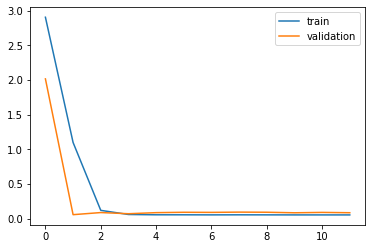


predict: [[33.10866665 21.74152878]]
real:      [[33.2 22.2]]

Train on 1755 samples, validate on 1 samples
Epoch 1/1000
 - 4s - loss: 1.4410 - mean_squared_error: 2.8592 - val_loss: 0.5302 - val_mean_squared_error: 0.2877
Epoch 2/1000
 - 1s - loss: 0.1865 - mean_squared_error: 0.0610 - val_loss: 0.0545 - val_mean_squared_error: 0.0044
Epoch 3/1000
 - 1s - loss: 0.0744 - mean_squared_error: 0.0093 - val_loss: 0.0975 - val_mean_squared_error: 0.0113
Epoch 4/1000
 - 1s - loss: 0.0594 - mean_squared_error: 0.0063 - val_loss: 0.0961 - val_mean_squared_error: 0.0094
Epoch 5/1000
 - 1s - loss: 0.0561 - mean_squared_error: 0.0059 - val_loss: 0.0860 - val_mean_squared_error: 0.0076
Epoch 6/1000
 - 1s - loss: 0.0560 - mean_squared_error: 0.0059 - val_loss: 0.0817 - val_mean_squared_error: 0.0076
Epoch 7/1000
 - 1s - loss: 0.0549 - mean_squared_error: 0.0057 - val_loss: 0.0795 - val_mean_squared_error: 0.0071
Epoch 8/1000
 - 1s - loss: 0.0544 - mean_squared_error: 0.0056 - val_loss: 0.1036 - va

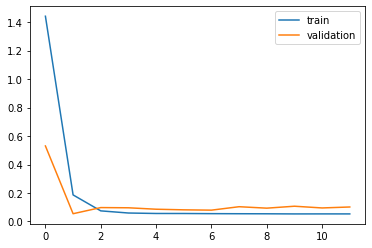


predict: [[32.31188404 20.68385313]]
real:      [[30.2 22.3]]

Train on 1754 samples, validate on 1 samples
Epoch 1/1000
 - 4s - loss: 1.8310 - mean_squared_error: 5.1333 - val_loss: 1.1409 - val_mean_squared_error: 2.4365
Epoch 2/1000
 - 1s - loss: 0.6929 - mean_squared_error: 1.0006 - val_loss: 0.1904 - val_mean_squared_error: 0.0398
Epoch 3/1000
 - 1s - loss: 0.0929 - mean_squared_error: 0.0143 - val_loss: 0.0601 - val_mean_squared_error: 0.0037
Epoch 4/1000
 - 1s - loss: 0.0632 - mean_squared_error: 0.0069 - val_loss: 0.0266 - val_mean_squared_error: 7.1061e-04
Epoch 5/1000
 - 1s - loss: 0.0595 - mean_squared_error: 0.0064 - val_loss: 0.0299 - val_mean_squared_error: 9.6018e-04
Epoch 6/1000
 - 1s - loss: 0.0580 - mean_squared_error: 0.0063 - val_loss: 0.0482 - val_mean_squared_error: 0.0023
Epoch 7/1000
 - 1s - loss: 0.0570 - mean_squared_error: 0.0061 - val_loss: 0.0450 - val_mean_squared_error: 0.0020
Epoch 8/1000
 - 1s - loss: 0.0575 - mean_squared_error: 0.0062 - val_loss: 0.0

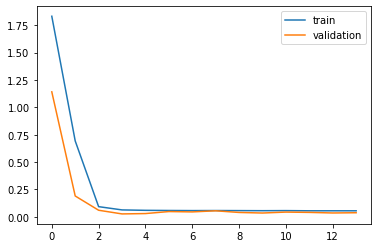


predict: [[32.94350559 23.75143641]]
real:      [[29.8 23.1]]

Train on 1753 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 1.9219 - mean_squared_error: 4.4813 - val_loss: 0.6541 - val_mean_squared_error: 0.5909
Epoch 2/1000
 - 1s - loss: 0.2214 - mean_squared_error: 0.1132 - val_loss: 0.0717 - val_mean_squared_error: 0.0063
Epoch 3/1000
 - 1s - loss: 0.0748 - mean_squared_error: 0.0100 - val_loss: 0.0862 - val_mean_squared_error: 0.0078
Epoch 4/1000
 - 1s - loss: 0.0611 - mean_squared_error: 0.0068 - val_loss: 0.0541 - val_mean_squared_error: 0.0037
Epoch 5/1000
 - 1s - loss: 0.0583 - mean_squared_error: 0.0062 - val_loss: 0.0566 - val_mean_squared_error: 0.0037
Epoch 6/1000
 - 1s - loss: 0.0575 - mean_squared_error: 0.0060 - val_loss: 0.0676 - val_mean_squared_error: 0.0065
Epoch 7/1000
 - 1s - loss: 0.0576 - mean_squared_error: 0.0061 - val_loss: 0.0630 - val_mean_squared_error: 0.0054
Epoch 8/1000
 - 1s - loss: 0.0564 - mean_squared_error: 0.0059 - val_loss: 0.0748 - va

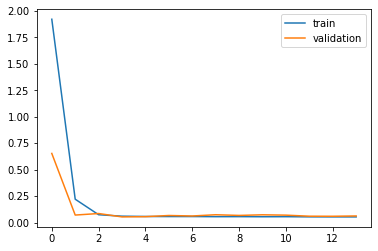


predict: [[33.2042554  24.31934112]]
real:      [[32.7 23.4]]

Train on 1752 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 1.4540 - mean_squared_error: 2.9725 - val_loss: 0.1786 - val_mean_squared_error: 0.0319
Epoch 2/1000
 - 1s - loss: 0.1438 - mean_squared_error: 0.0345 - val_loss: 0.0261 - val_mean_squared_error: 0.0013
Epoch 3/1000
 - 1s - loss: 0.0662 - mean_squared_error: 0.0075 - val_loss: 0.0165 - val_mean_squared_error: 2.7923e-04
Epoch 4/1000
 - 1s - loss: 0.0597 - mean_squared_error: 0.0065 - val_loss: 0.0371 - val_mean_squared_error: 0.0014
Epoch 5/1000
 - 1s - loss: 0.0579 - mean_squared_error: 0.0063 - val_loss: 0.0332 - val_mean_squared_error: 0.0012
Epoch 6/1000
 - 1s - loss: 0.0575 - mean_squared_error: 0.0061 - val_loss: 0.0463 - val_mean_squared_error: 0.0021
Epoch 7/1000
 - 1s - loss: 0.0570 - mean_squared_error: 0.0061 - val_loss: 0.0321 - val_mean_squared_error: 0.0012
Epoch 8/1000
 - 1s - loss: 0.0563 - mean_squared_error: 0.0060 - val_loss: 0.0392 

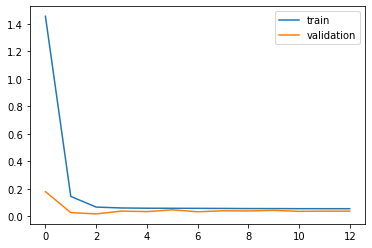


predict: [[32.81696084 24.98320434]]
real:      [[30.2 23.5]]

Train on 1751 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 1.4500 - mean_squared_error: 2.9079 - val_loss: 0.3494 - val_mean_squared_error: 0.1386
Epoch 2/1000
 - 1s - loss: 0.1771 - mean_squared_error: 0.0571 - val_loss: 0.0432 - val_mean_squared_error: 0.0022
Epoch 3/1000
 - 1s - loss: 0.0738 - mean_squared_error: 0.0089 - val_loss: 0.0234 - val_mean_squared_error: 8.7182e-04
Epoch 4/1000
 - 1s - loss: 0.0608 - mean_squared_error: 0.0066 - val_loss: 0.0061 - val_mean_squared_error: 6.6379e-05
Epoch 5/1000
 - 1s - loss: 0.0577 - mean_squared_error: 0.0062 - val_loss: 0.0198 - val_mean_squared_error: 3.9801e-04
Epoch 6/1000
 - 1s - loss: 0.0575 - mean_squared_error: 0.0061 - val_loss: 0.0186 - val_mean_squared_error: 3.6759e-04
Epoch 7/1000
 - 1s - loss: 0.0575 - mean_squared_error: 0.0062 - val_loss: 0.0035 - val_mean_squared_error: 1.3584e-05
Epoch 8/1000
 - 1s - loss: 0.0569 - mean_squared_error: 0.0061 - v

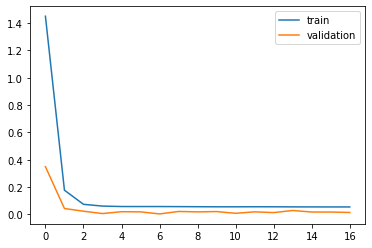


predict: [[32.44184846 24.05766985]]
real:      [[32.3 25.3]]

Train on 1750 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 3.0267 - mean_squared_error: 9.4517 - val_loss: 2.5543 - val_mean_squared_error: 7.0228
Epoch 2/1000
 - 1s - loss: 1.9400 - mean_squared_error: 4.7668 - val_loss: 1.2401 - val_mean_squared_error: 2.7489
Epoch 3/1000
 - 1s - loss: 0.7105 - mean_squared_error: 1.0706 - val_loss: 0.1549 - val_mean_squared_error: 0.0470
Epoch 4/1000
 - 1s - loss: 0.0915 - mean_squared_error: 0.0170 - val_loss: 0.0548 - val_mean_squared_error: 0.0055
Epoch 5/1000
 - 1s - loss: 0.0606 - mean_squared_error: 0.0067 - val_loss: 0.0213 - val_mean_squared_error: 5.2563e-04
Epoch 6/1000
 - 1s - loss: 0.0563 - mean_squared_error: 0.0059 - val_loss: 0.0078 - val_mean_squared_error: 9.9586e-05
Epoch 7/1000
 - 1s - loss: 0.0575 - mean_squared_error: 0.0060 - val_loss: 0.0113 - val_mean_squared_error: 1.3323e-04
Epoch 8/1000
 - 1s - loss: 0.0562 - mean_squared_error: 0.0059 - val_loss:

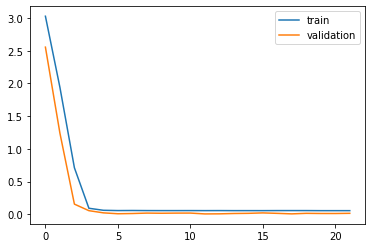


predict: [[33.15877301 24.04030285]]
real:      [[32.7 24.1]]

Train on 1749 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 2.1245 - mean_squared_error: 5.5496 - val_loss: 0.6992 - val_mean_squared_error: 0.6355
Epoch 2/1000
 - 1s - loss: 0.2285 - mean_squared_error: 0.1181 - val_loss: 0.0782 - val_mean_squared_error: 0.0074
Epoch 3/1000
 - 1s - loss: 0.0758 - mean_squared_error: 0.0100 - val_loss: 0.0484 - val_mean_squared_error: 0.0024
Epoch 4/1000
 - 1s - loss: 0.0615 - mean_squared_error: 0.0068 - val_loss: 0.0278 - val_mean_squared_error: 0.0011
Epoch 5/1000
 - 1s - loss: 0.0607 - mean_squared_error: 0.0064 - val_loss: 0.0529 - val_mean_squared_error: 0.0035
Epoch 6/1000
 - 1s - loss: 0.0585 - mean_squared_error: 0.0062 - val_loss: 0.0377 - val_mean_squared_error: 0.0019
Epoch 7/1000
 - 1s - loss: 0.0581 - mean_squared_error: 0.0062 - val_loss: 0.0463 - val_mean_squared_error: 0.0021
Epoch 8/1000
 - 1s - loss: 0.0578 - mean_squared_error: 0.0062 - val_loss: 0.0162 - va

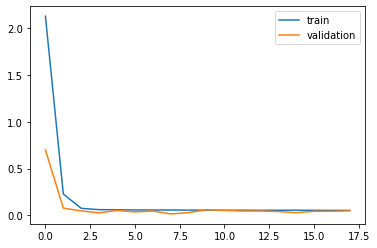


predict: [[31.56097486 24.5167855 ]]
real:      [[33.3 23.9]]

Train on 1748 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 2.9401 - mean_squared_error: 8.9751 - val_loss: 2.1487 - val_mean_squared_error: 5.1026
Epoch 2/1000
 - 1s - loss: 1.2636 - mean_squared_error: 2.3198 - val_loss: 0.2663 - val_mean_squared_error: 0.0742
Epoch 3/1000
 - 1s - loss: 0.1353 - mean_squared_error: 0.0270 - val_loss: 0.1493 - val_mean_squared_error: 0.0245
Epoch 4/1000
 - 1s - loss: 0.0666 - mean_squared_error: 0.0077 - val_loss: 0.1131 - val_mean_squared_error: 0.0141
Epoch 5/1000
 - 1s - loss: 0.0577 - mean_squared_error: 0.0062 - val_loss: 0.0920 - val_mean_squared_error: 0.0106
Epoch 6/1000
 - 1s - loss: 0.0571 - mean_squared_error: 0.0060 - val_loss: 0.1258 - val_mean_squared_error: 0.0203
Epoch 7/1000
 - 1s - loss: 0.0570 - mean_squared_error: 0.0062 - val_loss: 0.1042 - val_mean_squared_error: 0.0136
Epoch 8/1000
 - 1s - loss: 0.0559 - mean_squared_error: 0.0059 - val_loss: 0.1103 - va

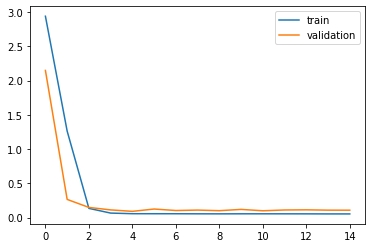


predict: [[31.64215413 24.49915502]]
real:      [[31.7 23.5]]

Train on 1747 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 1.6692 - mean_squared_error: 3.4943 - val_loss: 0.1957 - val_mean_squared_error: 0.0383
Epoch 2/1000
 - 1s - loss: 0.1601 - mean_squared_error: 0.0453 - val_loss: 0.0169 - val_mean_squared_error: 2.8673e-04
Epoch 3/1000
 - 1s - loss: 0.0683 - mean_squared_error: 0.0080 - val_loss: 0.0320 - val_mean_squared_error: 0.0010
Epoch 4/1000
 - 1s - loss: 0.0611 - mean_squared_error: 0.0064 - val_loss: 0.0279 - val_mean_squared_error: 7.8865e-04
Epoch 5/1000
 - 1s - loss: 0.0607 - mean_squared_error: 0.0063 - val_loss: 0.0298 - val_mean_squared_error: 0.0014
Epoch 6/1000
 - 1s - loss: 0.0599 - mean_squared_error: 0.0063 - val_loss: 0.0232 - val_mean_squared_error: 5.4204e-04
Epoch 7/1000
 - 1s - loss: 0.0596 - mean_squared_error: 0.0064 - val_loss: 0.0206 - val_mean_squared_error: 7.5082e-04
Epoch 8/1000
 - 1s - loss: 0.0573 - mean_squared_error: 0.0060 - val_l

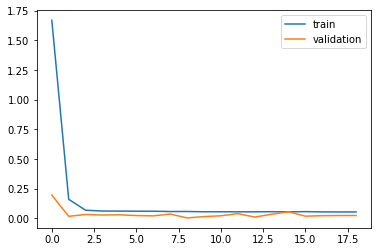


predict: [[32.379071   24.32782397]]
real:      [[28.2 23.1]]

Train on 1746 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 2.1856 - mean_squared_error: 5.5813 - val_loss: 0.6142 - val_mean_squared_error: 0.3772
Epoch 2/1000
 - 1s - loss: 0.2162 - mean_squared_error: 0.0758 - val_loss: 0.0540 - val_mean_squared_error: 0.0056
Epoch 3/1000
 - 1s - loss: 0.0710 - mean_squared_error: 0.0095 - val_loss: 0.0842 - val_mean_squared_error: 0.0095
Epoch 4/1000
 - 1s - loss: 0.0599 - mean_squared_error: 0.0068 - val_loss: 0.0440 - val_mean_squared_error: 0.0022
Epoch 5/1000
 - 1s - loss: 0.0593 - mean_squared_error: 0.0064 - val_loss: 0.0799 - val_mean_squared_error: 0.0068
Epoch 6/1000
 - 1s - loss: 0.0594 - mean_squared_error: 0.0065 - val_loss: 0.0573 - val_mean_squared_error: 0.0036
Epoch 7/1000
 - 1s - loss: 0.0578 - mean_squared_error: 0.0062 - val_loss: 0.0647 - val_mean_squared_error: 0.0042
Epoch 8/1000
 - 1s - loss: 0.0574 - mean_squared_error: 0.0062 - val_loss: 0.0483 - va

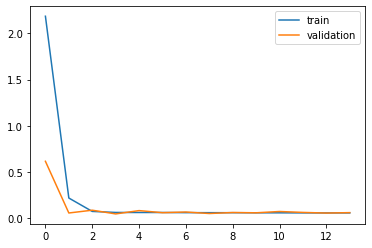


predict: [[32.72891123 24.58236649]]
real:      [[32.3 24. ]]

Train on 1745 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 1.6108 - mean_squared_error: 3.6948 - val_loss: 0.3471 - val_mean_squared_error: 0.1206
Epoch 2/1000
 - 1s - loss: 0.1656 - mean_squared_error: 0.0423 - val_loss: 0.0303 - val_mean_squared_error: 9.6273e-04
Epoch 3/1000
 - 1s - loss: 0.0671 - mean_squared_error: 0.0075 - val_loss: 0.0259 - val_mean_squared_error: 6.8258e-04
Epoch 4/1000
 - 1s - loss: 0.0616 - mean_squared_error: 0.0067 - val_loss: 0.0195 - val_mean_squared_error: 3.8165e-04
Epoch 5/1000
 - 1s - loss: 0.0598 - mean_squared_error: 0.0065 - val_loss: 0.0161 - val_mean_squared_error: 3.2477e-04
Epoch 6/1000
 - 1s - loss: 0.0590 - mean_squared_error: 0.0064 - val_loss: 0.0052 - val_mean_squared_error: 3.7030e-05
Epoch 7/1000
 - 1s - loss: 0.0590 - mean_squared_error: 0.0063 - val_loss: 0.0237 - val_mean_squared_error: 5.8921e-04
Epoch 8/1000
 - 1s - loss: 0.0579 - mean_squared_error: 0.0062

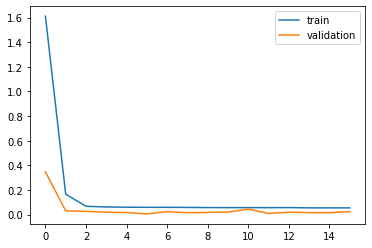


predict: [[32.71048492 24.67379959]]
real:      [[30.7 23.6]]

Train on 1744 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 2.7237 - mean_squared_error: 7.7478 - val_loss: 1.8927 - val_mean_squared_error: 3.8017
Epoch 2/1000
 - 1s - loss: 1.2387 - mean_squared_error: 2.1208 - val_loss: 0.4352 - val_mean_squared_error: 0.3138
Epoch 3/1000
 - 1s - loss: 0.1706 - mean_squared_error: 0.0630 - val_loss: 0.0970 - val_mean_squared_error: 0.0094
Epoch 4/1000
 - 1s - loss: 0.0712 - mean_squared_error: 0.0081 - val_loss: 0.0472 - val_mean_squared_error: 0.0044
Epoch 5/1000
 - 1s - loss: 0.0566 - mean_squared_error: 0.0060 - val_loss: 0.0690 - val_mean_squared_error: 0.0094
Epoch 6/1000
 - 1s - loss: 0.0562 - mean_squared_error: 0.0059 - val_loss: 0.0861 - val_mean_squared_error: 0.0125
Epoch 7/1000
 - 1s - loss: 0.0569 - mean_squared_error: 0.0062 - val_loss: 0.0687 - val_mean_squared_error: 0.0080
Epoch 8/1000
 - 1s - loss: 0.0563 - mean_squared_error: 0.0059 - val_loss: 0.0637 - va

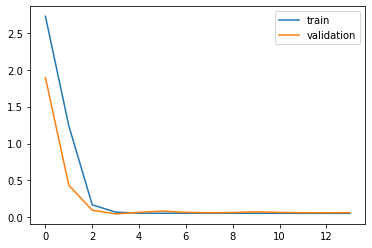


predict: [[31.67816803 24.3028183 ]]
real:      [[32.7 24.1]]

Train on 1743 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 1.5948 - mean_squared_error: 3.4338 - val_loss: 0.5971 - val_mean_squared_error: 0.3850
Epoch 2/1000
 - 1s - loss: 0.2090 - mean_squared_error: 0.0763 - val_loss: 0.1001 - val_mean_squared_error: 0.0162
Epoch 3/1000
 - 1s - loss: 0.0719 - mean_squared_error: 0.0085 - val_loss: 0.0716 - val_mean_squared_error: 0.0058
Epoch 4/1000
 - 1s - loss: 0.0591 - mean_squared_error: 0.0064 - val_loss: 0.0459 - val_mean_squared_error: 0.0021
Epoch 5/1000
 - 1s - loss: 0.0583 - mean_squared_error: 0.0063 - val_loss: 0.0634 - val_mean_squared_error: 0.0042
Epoch 6/1000
 - 1s - loss: 0.0574 - mean_squared_error: 0.0062 - val_loss: 0.0595 - val_mean_squared_error: 0.0038
Epoch 7/1000
 - 1s - loss: 0.0574 - mean_squared_error: 0.0062 - val_loss: 0.0688 - val_mean_squared_error: 0.0048
Epoch 8/1000
 - 1s - loss: 0.0569 - mean_squared_error: 0.0060 - val_loss: 0.0698 - va

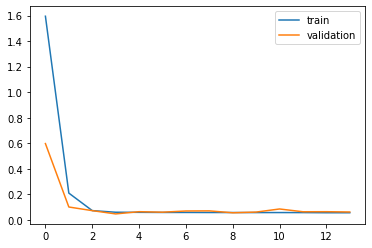


predict: [[33.32765769 24.38321636]]
real:      [[29.3 24.3]]

Train on 1742 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 1.5018 - mean_squared_error: 3.0965 - val_loss: 0.4532 - val_mean_squared_error: 0.2484
Epoch 2/1000
 - 1s - loss: 0.1857 - mean_squared_error: 0.0652 - val_loss: 0.1112 - val_mean_squared_error: 0.0201
Epoch 3/1000
 - 1s - loss: 0.0703 - mean_squared_error: 0.0081 - val_loss: 0.0924 - val_mean_squared_error: 0.0153
Epoch 4/1000
 - 1s - loss: 0.0621 - mean_squared_error: 0.0068 - val_loss: 0.1356 - val_mean_squared_error: 0.0266
Epoch 5/1000
 - 1s - loss: 0.0593 - mean_squared_error: 0.0064 - val_loss: 0.1212 - val_mean_squared_error: 0.0236
Epoch 6/1000
 - 1s - loss: 0.0567 - mean_squared_error: 0.0061 - val_loss: 0.1543 - val_mean_squared_error: 0.0312
Epoch 7/1000
 - 1s - loss: 0.0589 - mean_squared_error: 0.0064 - val_loss: 0.1369 - val_mean_squared_error: 0.0275
Epoch 8/1000
 - 1s - loss: 0.0565 - mean_squared_error: 0.0060 - val_loss: 0.1623 - va

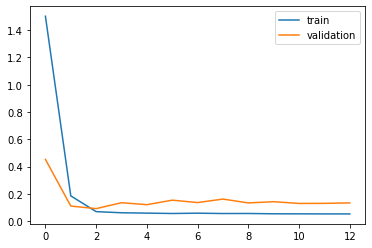


predict: [[31.23449792 22.21028234]]
real:      [[31.7 22.7]]

Train on 1741 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 2.1347 - mean_squared_error: 5.3475 - val_loss: 0.7470 - val_mean_squared_error: 0.6234
Epoch 2/1000
 - 1s - loss: 0.2379 - mean_squared_error: 0.0994 - val_loss: 0.1656 - val_mean_squared_error: 0.0277
Epoch 3/1000
 - 1s - loss: 0.0819 - mean_squared_error: 0.0101 - val_loss: 0.1071 - val_mean_squared_error: 0.0218
Epoch 4/1000
 - 1s - loss: 0.0648 - mean_squared_error: 0.0073 - val_loss: 0.1015 - val_mean_squared_error: 0.0195
Epoch 5/1000
 - 1s - loss: 0.0620 - mean_squared_error: 0.0068 - val_loss: 0.1087 - val_mean_squared_error: 0.0212
Epoch 6/1000
 - 1s - loss: 0.0602 - mean_squared_error: 0.0065 - val_loss: 0.1039 - val_mean_squared_error: 0.0190
Epoch 7/1000
 - 1s - loss: 0.0604 - mean_squared_error: 0.0066 - val_loss: 0.1118 - val_mean_squared_error: 0.0231
Epoch 8/1000
 - 1s - loss: 0.0578 - mean_squared_error: 0.0062 - val_loss: 0.1195 - va

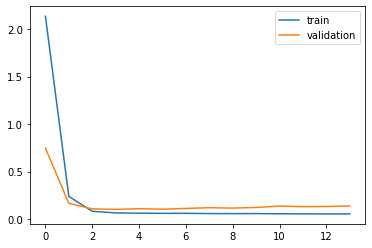


predict: [[32.88006912 24.6221466 ]]
real:      [[27.2 23.6]]

Train on 1740 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 1.3668 - mean_squared_error: 2.7795 - val_loss: 0.4695 - val_mean_squared_error: 0.3323
Epoch 2/1000
 - 1s - loss: 0.1674 - mean_squared_error: 0.0619 - val_loss: 0.0553 - val_mean_squared_error: 0.0047
Epoch 3/1000
 - 1s - loss: 0.0712 - mean_squared_error: 0.0092 - val_loss: 0.0115 - val_mean_squared_error: 1.4948e-04
Epoch 4/1000
 - 1s - loss: 0.0629 - mean_squared_error: 0.0070 - val_loss: 0.0210 - val_mean_squared_error: 4.8193e-04
Epoch 5/1000
 - 1s - loss: 0.0590 - mean_squared_error: 0.0066 - val_loss: 0.0253 - val_mean_squared_error: 0.0010
Epoch 6/1000
 - 1s - loss: 0.0578 - mean_squared_error: 0.0062 - val_loss: 0.0315 - val_mean_squared_error: 0.0010
Epoch 7/1000
 - 1s - loss: 0.0580 - mean_squared_error: 0.0062 - val_loss: 0.0278 - val_mean_squared_error: 0.0012
Epoch 8/1000
 - 1s - loss: 0.0575 - mean_squared_error: 0.0062 - val_loss: 0.0

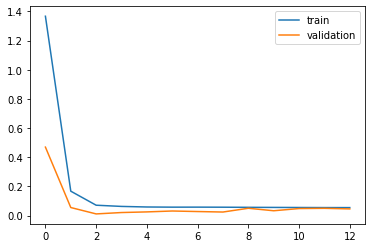


predict: [[30.60391249 24.35158501]]
real:      [[26.2 24. ]]

Train on 1739 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 2.5416 - mean_squared_error: 6.6957 - val_loss: 1.5944 - val_mean_squared_error: 2.6003
Epoch 2/1000
 - 1s - loss: 0.7120 - mean_squared_error: 0.8149 - val_loss: 0.2155 - val_mean_squared_error: 0.0807
Epoch 3/1000
 - 1s - loss: 0.0920 - mean_squared_error: 0.0172 - val_loss: 0.0959 - val_mean_squared_error: 0.0105
Epoch 4/1000
 - 1s - loss: 0.0579 - mean_squared_error: 0.0062 - val_loss: 0.0503 - val_mean_squared_error: 0.0028
Epoch 5/1000
 - 1s - loss: 0.0558 - mean_squared_error: 0.0059 - val_loss: 0.0434 - val_mean_squared_error: 0.0021
Epoch 6/1000
 - 1s - loss: 0.0570 - mean_squared_error: 0.0060 - val_loss: 0.0552 - val_mean_squared_error: 0.0033
Epoch 7/1000
 - 1s - loss: 0.0557 - mean_squared_error: 0.0059 - val_loss: 0.0483 - val_mean_squared_error: 0.0027
Epoch 8/1000
 - 1s - loss: 0.0560 - mean_squared_error: 0.0058 - val_loss: 0.0533 - va

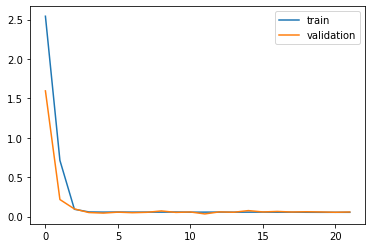


predict: [[32.48697506 23.87495479]]
real:      [[31.9 24. ]]

Train on 1738 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 2.6026 - mean_squared_error: 7.2029 - val_loss: 1.3402 - val_mean_squared_error: 1.8527
Epoch 2/1000
 - 1s - loss: 0.5643 - mean_squared_error: 0.6005 - val_loss: 0.2595 - val_mean_squared_error: 0.1006
Epoch 3/1000
 - 1s - loss: 0.0876 - mean_squared_error: 0.0147 - val_loss: 0.1518 - val_mean_squared_error: 0.0305
Epoch 4/1000
 - 1s - loss: 0.0593 - mean_squared_error: 0.0065 - val_loss: 0.0972 - val_mean_squared_error: 0.0115
Epoch 5/1000
 - 1s - loss: 0.0573 - mean_squared_error: 0.0060 - val_loss: 0.1023 - val_mean_squared_error: 0.0145
Epoch 6/1000
 - 1s - loss: 0.0564 - mean_squared_error: 0.0059 - val_loss: 0.1122 - val_mean_squared_error: 0.0163
Epoch 7/1000
 - 1s - loss: 0.0572 - mean_squared_error: 0.0059 - val_loss: 0.1289 - val_mean_squared_error: 0.0187
Epoch 8/1000
 - 1s - loss: 0.0566 - mean_squared_error: 0.0060 - val_loss: 0.1222 - va

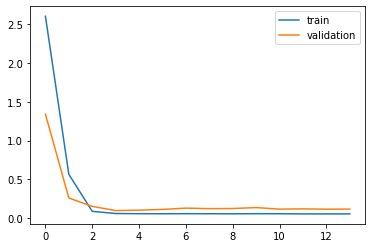


predict: [[30.20669271 24.04911026]]
real:      [[31.  23.3]]

Train on 1737 samples, validate on 1 samples
Epoch 1/1000
 - 5s - loss: 2.4153 - mean_squared_error: 7.2696 - val_loss: 1.6166 - val_mean_squared_error: 3.8401
Epoch 2/1000
 - 1s - loss: 0.9116 - mean_squared_error: 1.6831 - val_loss: 0.1106 - val_mean_squared_error: 0.0125
Epoch 3/1000
 - 1s - loss: 0.1253 - mean_squared_error: 0.0251 - val_loss: 0.1487 - val_mean_squared_error: 0.0241
Epoch 4/1000
 - 1s - loss: 0.0677 - mean_squared_error: 0.0076 - val_loss: 0.0687 - val_mean_squared_error: 0.0073
Epoch 5/1000
 - 1s - loss: 0.0579 - mean_squared_error: 0.0062 - val_loss: 0.1193 - val_mean_squared_error: 0.0176
Epoch 6/1000
 - 1s - loss: 0.0569 - mean_squared_error: 0.0061 - val_loss: 0.1184 - val_mean_squared_error: 0.0153
Epoch 7/1000
 - 1s - loss: 0.0561 - mean_squared_error: 0.0059 - val_loss: 0.0997 - val_mean_squared_error: 0.0109
Epoch 8/1000
 - 1s - loss: 0.0563 - mean_squared_error: 0.0059 - val_loss: 0.1168 - va

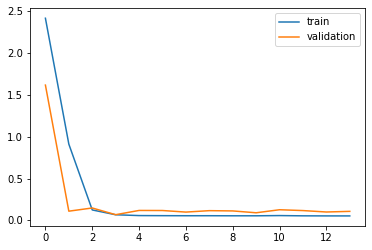


predict: [[32.90109366 24.44404952]]
real:      [[27.9 23.1]]

Train on 1736 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 2.4181 - mean_squared_error: 6.2232 - val_loss: 1.2977 - val_mean_squared_error: 1.7012
Epoch 2/1000
 - 1s - loss: 0.4643 - mean_squared_error: 0.3677 - val_loss: 0.1440 - val_mean_squared_error: 0.0220
Epoch 3/1000
 - 1s - loss: 0.0883 - mean_squared_error: 0.0121 - val_loss: 0.0449 - val_mean_squared_error: 0.0020
Epoch 4/1000
 - 1s - loss: 0.0638 - mean_squared_error: 0.0071 - val_loss: 0.0113 - val_mean_squared_error: 1.4031e-04
Epoch 5/1000
 - 1s - loss: 0.0609 - mean_squared_error: 0.0066 - val_loss: 0.0071 - val_mean_squared_error: 6.6428e-05
Epoch 6/1000
 - 1s - loss: 0.0596 - mean_squared_error: 0.0064 - val_loss: 0.0222 - val_mean_squared_error: 5.1904e-04
Epoch 7/1000
 - 1s - loss: 0.0602 - mean_squared_error: 0.0066 - val_loss: 0.0110 - val_mean_squared_error: 1.7912e-04
Epoch 8/1000
 - 1s - loss: 0.0583 - mean_squared_error: 0.0063 - val_l

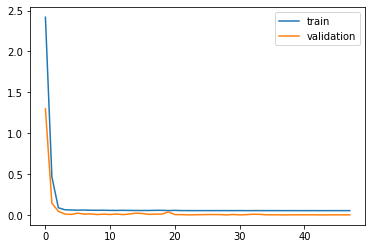


predict: [[33.53483705 24.77845684]]
real:      [[28.5 22.7]]

Train on 1735 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 2.6507 - mean_squared_error: 8.5223 - val_loss: 1.7937 - val_mean_squared_error: 5.3279
Epoch 2/1000
 - 1s - loss: 1.2079 - mean_squared_error: 2.8869 - val_loss: 0.5090 - val_mean_squared_error: 0.4977
Epoch 3/1000
 - 1s - loss: 0.1799 - mean_squared_error: 0.0902 - val_loss: 0.0561 - val_mean_squared_error: 0.0051
Epoch 4/1000
 - 1s - loss: 0.0685 - mean_squared_error: 0.0090 - val_loss: 0.0158 - val_mean_squared_error: 2.5098e-04
Epoch 5/1000
 - 1s - loss: 0.0584 - mean_squared_error: 0.0061 - val_loss: 0.0284 - val_mean_squared_error: 8.0442e-04
Epoch 6/1000
 - 1s - loss: 0.0572 - mean_squared_error: 0.0061 - val_loss: 0.0211 - val_mean_squared_error: 4.5879e-04
Epoch 7/1000
 - 1s - loss: 0.0575 - mean_squared_error: 0.0061 - val_loss: 0.0135 - val_mean_squared_error: 2.5288e-04
Epoch 8/1000
 - 1s - loss: 0.0570 - mean_squared_error: 0.0061 - val_l

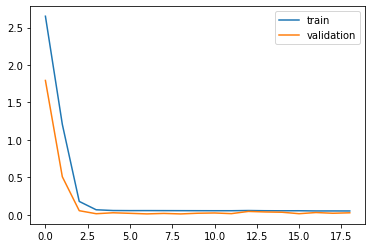


predict: [[32.92137909 24.85028743]]
real:      [[33.8 24.5]]

Train and validation time: 10.75 minutes

Maximum temperatures metrics
Test MEAN-SQUARED-ERROR ------------ 6.721
Test STANDART-DEVIATION ------------ 1.73
Test MEAN-ABSOLUTE-ERROR ----------- 1.931
Test MEDIAN-ABSOLUTE-ERROR --------- 1.042

Errors
2018-12-31 = 3.83709671593358
2018-12-30 = 3.662593683906067
2018-12-29 = 1.0629372561379427
2018-12-28 = 0.26596729638851
2018-12-27 = 0.44356003060928373
2018-12-26 = 0.6188986237645935
2018-12-25 = 0.8207344292127985
2018-12-24 = 1.8384541018456204
2018-12-23 = 0.09133334707651386
2018-12-22 = 2.1118840358210846
2018-12-21 = 3.143505585158433
2018-12-20 = 0.5042554032567566
2018-12-19 = 2.6169608434118388
2018-12-18 = 0.14184845680349412
2018-12-17 = 0.45877300555068956
2018-12-16 = 1.7390251442828841
2018-12-15 = 0.057845867901093584
2018-12-14 = 4.179070995838668
2018-12-13 = 0.42891122984573116
2018-12-12 = 2.010484919768004
2018-12-11 = 1.0218319715095454
2018-12-10 = 4.

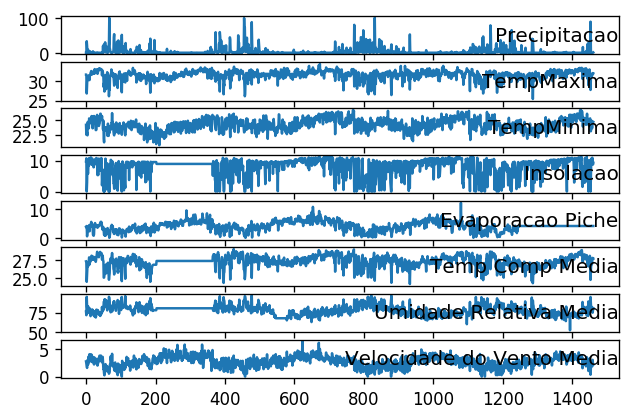

Train on 1399 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 1.6825 - mean_squared_error: 3.5062 - val_loss: 0.2061 - val_mean_squared_error: 0.0436
Epoch 2/1000
 - 0s - loss: 0.1917 - mean_squared_error: 0.0511 - val_loss: 0.0349 - val_mean_squared_error: 0.0012
Epoch 3/1000
 - 0s - loss: 0.0661 - mean_squared_error: 0.0069 - val_loss: 0.0099 - val_mean_squared_error: 1.1248e-04
Epoch 4/1000
 - 0s - loss: 0.0377 - mean_squared_error: 0.0024 - val_loss: 0.0260 - val_mean_squared_error: 7.0776e-04
Epoch 5/1000
 - 0s - loss: 0.0337 - mean_squared_error: 0.0020 - val_loss: 0.0172 - val_mean_squared_error: 2.9486e-04
Epoch 6/1000
 - 0s - loss: 0.0330 - mean_squared_error: 0.0019 - val_loss: 0.0270 - val_mean_squared_error: 7.5907e-04
Epoch 7/1000
 - 0s - loss: 0.0317 - mean_squared_error: 0.0018 - val_loss: 0.0254 - val_mean_squared_error: 7.9980e-04
Epoch 8/1000
 - 0s - loss: 0.0312 - mean_squared_error: 0.0017 - val_loss: 0.0238 - val_mean_squared_error: 5.7153e-04
Epoch 9/100

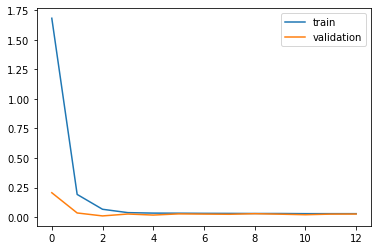


predict: [[31.64069884 23.90339071]]
real:      [[31.9 24.7]]

Train on 1398 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 2.4401 - mean_squared_error: 6.9196 - val_loss: 1.4156 - val_mean_squared_error: 3.9309
Epoch 2/1000
 - 0s - loss: 1.2824 - mean_squared_error: 2.9496 - val_loss: 1.0480 - val_mean_squared_error: 2.0884
Epoch 3/1000
 - 0s - loss: 0.8664 - mean_squared_error: 1.4370 - val_loss: 0.6792 - val_mean_squared_error: 0.9068
Epoch 4/1000
 - 0s - loss: 0.5911 - mean_squared_error: 0.6664 - val_loss: 0.4754 - val_mean_squared_error: 0.4344
Epoch 5/1000
 - 0s - loss: 0.3598 - mean_squared_error: 0.2487 - val_loss: 0.2168 - val_mean_squared_error: 0.0822
Epoch 6/1000
 - 0s - loss: 0.0984 - mean_squared_error: 0.0219 - val_loss: 0.0345 - val_mean_squared_error: 0.0012
Epoch 7/1000
 - 0s - loss: 0.0361 - mean_squared_error: 0.0021 - val_loss: 0.0155 - val_mean_squared_error: 4.7121e-04
Epoch 8/1000
 - 0s - loss: 0.0303 - mean_squared_error: 0.0016 - val_loss: 0.0142 

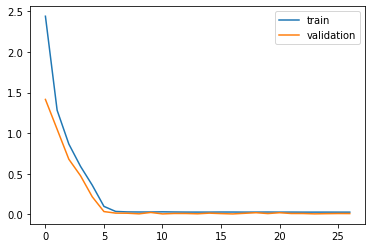


predict: [[31.1757666  24.03441705]]
real:      [[31.7 24.6]]

Train on 1397 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 3.1141 - mean_squared_error: 9.8359 - val_loss: 2.6063 - val_mean_squared_error: 6.9533
Epoch 2/1000
 - 0s - loss: 2.1221 - mean_squared_error: 4.7572 - val_loss: 1.2701 - val_mean_squared_error: 1.6623
Epoch 3/1000
 - 0s - loss: 0.5110 - mean_squared_error: 0.4274 - val_loss: 0.2143 - val_mean_squared_error: 0.0461
Epoch 4/1000
 - 0s - loss: 0.0831 - mean_squared_error: 0.0101 - val_loss: 0.0607 - val_mean_squared_error: 0.0043
Epoch 5/1000
 - 0s - loss: 0.0380 - mean_squared_error: 0.0024 - val_loss: 0.0139 - val_mean_squared_error: 1.9220e-04
Epoch 6/1000
 - 0s - loss: 0.0320 - mean_squared_error: 0.0017 - val_loss: 0.0338 - val_mean_squared_error: 0.0014
Epoch 7/1000
 - 0s - loss: 0.0302 - mean_squared_error: 0.0016 - val_loss: 0.0339 - val_mean_squared_error: 0.0016
Epoch 8/1000
 - 0s - loss: 0.0297 - mean_squared_error: 0.0015 - val_loss: 0.0257 

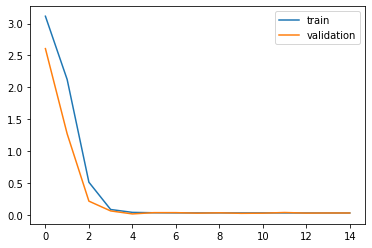


predict: [[30.89913878 23.55513651]]
real:      [[31.9 24.7]]

Train on 1396 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 2.1344 - mean_squared_error: 5.3539 - val_loss: 0.6531 - val_mean_squared_error: 0.7554
Epoch 2/1000
 - 0s - loss: 0.3152 - mean_squared_error: 0.1940 - val_loss: 0.0783 - val_mean_squared_error: 0.0092
Epoch 3/1000
 - 0s - loss: 0.0685 - mean_squared_error: 0.0071 - val_loss: 0.0185 - val_mean_squared_error: 4.3845e-04
Epoch 4/1000
 - 0s - loss: 0.0391 - mean_squared_error: 0.0025 - val_loss: 0.0391 - val_mean_squared_error: 0.0016
Epoch 5/1000
 - 0s - loss: 0.0335 - mean_squared_error: 0.0020 - val_loss: 0.0362 - val_mean_squared_error: 0.0013
Epoch 6/1000
 - 0s - loss: 0.0318 - mean_squared_error: 0.0018 - val_loss: 0.0398 - val_mean_squared_error: 0.0017
Epoch 7/1000
 - 0s - loss: 0.0306 - mean_squared_error: 0.0017 - val_loss: 0.0341 - val_mean_squared_error: 0.0013
Epoch 8/1000
 - 0s - loss: 0.0301 - mean_squared_error: 0.0016 - val_loss: 0.0369 

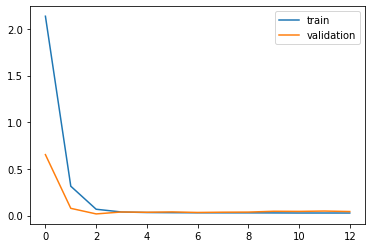


predict: [[30.3910092  24.09211094]]
real:      [[31.8 23.7]]

Train on 1395 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 2.3682 - mean_squared_error: 6.8711 - val_loss: 1.4857 - val_mean_squared_error: 3.6574
Epoch 2/1000
 - 0s - loss: 0.9715 - mean_squared_error: 1.7761 - val_loss: 0.3945 - val_mean_squared_error: 0.2087
Epoch 3/1000
 - 0s - loss: 0.1271 - mean_squared_error: 0.0362 - val_loss: 0.0523 - val_mean_squared_error: 0.0028
Epoch 4/1000
 - 0s - loss: 0.0440 - mean_squared_error: 0.0032 - val_loss: 0.0566 - val_mean_squared_error: 0.0034
Epoch 5/1000
 - 0s - loss: 0.0348 - mean_squared_error: 0.0021 - val_loss: 0.0262 - val_mean_squared_error: 8.7783e-04
Epoch 6/1000
 - 0s - loss: 0.0323 - mean_squared_error: 0.0018 - val_loss: 0.0323 - val_mean_squared_error: 0.0013
Epoch 7/1000
 - 0s - loss: 0.0324 - mean_squared_error: 0.0018 - val_loss: 0.0319 - val_mean_squared_error: 0.0019
Epoch 8/1000
 - 0s - loss: 0.0301 - mean_squared_error: 0.0016 - val_loss: 0.0480 

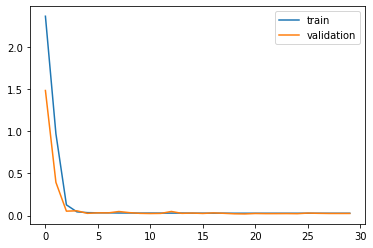


predict: [[31.75878034 24.34467733]]
real:      [[31.2 23.6]]

Train on 1394 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 2.3452 - mean_squared_error: 6.7485 - val_loss: 1.3299 - val_mean_squared_error: 3.4184
Epoch 2/1000
 - 0s - loss: 0.7268 - mean_squared_error: 1.2448 - val_loss: 0.1590 - val_mean_squared_error: 0.0299
Epoch 3/1000
 - 0s - loss: 0.1190 - mean_squared_error: 0.0255 - val_loss: 0.0336 - val_mean_squared_error: 0.0017
Epoch 4/1000
 - 0s - loss: 0.0430 - mean_squared_error: 0.0030 - val_loss: 0.0139 - val_mean_squared_error: 1.9339e-04
Epoch 5/1000
 - 0s - loss: 0.0344 - mean_squared_error: 0.0020 - val_loss: 0.0254 - val_mean_squared_error: 6.7536e-04
Epoch 6/1000
 - 0s - loss: 0.0317 - mean_squared_error: 0.0018 - val_loss: 0.0218 - val_mean_squared_error: 5.1411e-04
Epoch 7/1000
 - 0s - loss: 0.0312 - mean_squared_error: 0.0017 - val_loss: 0.0106 - val_mean_squared_error: 1.8628e-04
Epoch 8/1000
 - 0s - loss: 0.0315 - mean_squared_error: 0.0017 - val_l

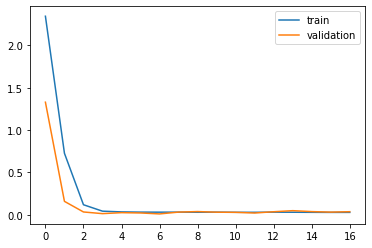


predict: [[30.74631154 23.55541166]]
real:      [[31.  24.9]]

Train on 1393 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 2.2376 - mean_squared_error: 5.5134 - val_loss: 0.8191 - val_mean_squared_error: 0.6883
Epoch 2/1000
 - 0s - loss: 0.3123 - mean_squared_error: 0.1619 - val_loss: 0.0470 - val_mean_squared_error: 0.0026
Epoch 3/1000
 - 0s - loss: 0.0765 - mean_squared_error: 0.0088 - val_loss: 0.0430 - val_mean_squared_error: 0.0024
Epoch 4/1000
 - 0s - loss: 0.0359 - mean_squared_error: 0.0021 - val_loss: 0.0754 - val_mean_squared_error: 0.0060
Epoch 5/1000
 - 0s - loss: 0.0298 - mean_squared_error: 0.0016 - val_loss: 0.0666 - val_mean_squared_error: 0.0047
Epoch 6/1000
 - 0s - loss: 0.0287 - mean_squared_error: 0.0015 - val_loss: 0.0555 - val_mean_squared_error: 0.0033
Epoch 7/1000
 - 0s - loss: 0.0291 - mean_squared_error: 0.0015 - val_loss: 0.0680 - val_mean_squared_error: 0.0049
Epoch 8/1000
 - 0s - loss: 0.0292 - mean_squared_error: 0.0015 - val_loss: 0.0775 - va

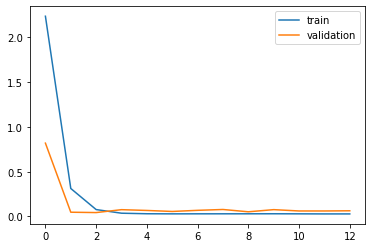


predict: [[32.28714542 23.47524296]]
real:      [[31.  23.5]]

Train on 1392 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 2.3160 - mean_squared_error: 5.8786 - val_loss: 0.9989 - val_mean_squared_error: 1.4299
Epoch 2/1000
 - 0s - loss: 0.4202 - mean_squared_error: 0.4115 - val_loss: 0.2403 - val_mean_squared_error: 0.0636
Epoch 3/1000
 - 0s - loss: 0.0794 - mean_squared_error: 0.0108 - val_loss: 0.1310 - val_mean_squared_error: 0.0173
Epoch 4/1000
 - 0s - loss: 0.0378 - mean_squared_error: 0.0026 - val_loss: 0.0965 - val_mean_squared_error: 0.0126
Epoch 5/1000
 - 0s - loss: 0.0322 - mean_squared_error: 0.0019 - val_loss: 0.1046 - val_mean_squared_error: 0.0136
Epoch 6/1000
 - 0s - loss: 0.0312 - mean_squared_error: 0.0018 - val_loss: 0.1048 - val_mean_squared_error: 0.0125
Epoch 7/1000
 - 0s - loss: 0.0311 - mean_squared_error: 0.0018 - val_loss: 0.1114 - val_mean_squared_error: 0.0145
Epoch 8/1000
 - 0s - loss: 0.0312 - mean_squared_error: 0.0018 - val_loss: 0.1023 - va

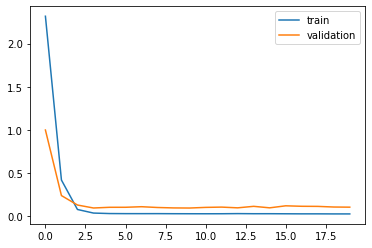


predict: [[30.88434981 24.89454616]]
real:      [[30.6 23.1]]

Train on 1391 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 1.8581 - mean_squared_error: 4.1170 - val_loss: 0.2950 - val_mean_squared_error: 0.1106
Epoch 2/1000
 - 0s - loss: 0.2142 - mean_squared_error: 0.0656 - val_loss: 0.1141 - val_mean_squared_error: 0.0161
Epoch 3/1000
 - 0s - loss: 0.0684 - mean_squared_error: 0.0073 - val_loss: 0.0246 - val_mean_squared_error: 8.3447e-04
Epoch 4/1000
 - 0s - loss: 0.0375 - mean_squared_error: 0.0024 - val_loss: 0.0100 - val_mean_squared_error: 1.0299e-04
Epoch 5/1000
 - 0s - loss: 0.0315 - mean_squared_error: 0.0017 - val_loss: 0.0143 - val_mean_squared_error: 2.8784e-04
Epoch 6/1000
 - 0s - loss: 0.0305 - mean_squared_error: 0.0017 - val_loss: 0.0066 - val_mean_squared_error: 5.4148e-05
Epoch 7/1000
 - 0s - loss: 0.0311 - mean_squared_error: 0.0017 - val_loss: 0.0138 - val_mean_squared_error: 1.9822e-04
Epoch 8/1000
 - 0s - loss: 0.0288 - mean_squared_error: 0.0015 - v

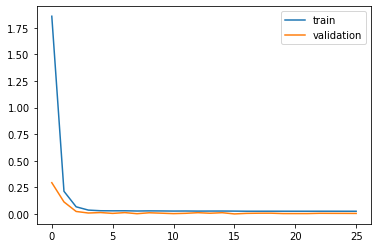


predict: [[31.37685881 23.94524317]]
real:      [[27.7 23.1]]

Train on 1390 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 2.1242 - mean_squared_error: 5.0389 - val_loss: 0.6618 - val_mean_squared_error: 0.4441
Epoch 2/1000
 - 0s - loss: 0.2274 - mean_squared_error: 0.0798 - val_loss: 0.1772 - val_mean_squared_error: 0.0320
Epoch 3/1000
 - 0s - loss: 0.0635 - mean_squared_error: 0.0063 - val_loss: 0.0111 - val_mean_squared_error: 2.1778e-04
Epoch 4/1000
 - 0s - loss: 0.0328 - mean_squared_error: 0.0019 - val_loss: 0.0254 - val_mean_squared_error: 6.4817e-04
Epoch 5/1000
 - 0s - loss: 0.0289 - mean_squared_error: 0.0015 - val_loss: 0.0152 - val_mean_squared_error: 2.3802e-04
Epoch 6/1000
 - 0s - loss: 0.0287 - mean_squared_error: 0.0015 - val_loss: 0.0182 - val_mean_squared_error: 3.4124e-04
Epoch 7/1000
 - 0s - loss: 0.0284 - mean_squared_error: 0.0014 - val_loss: 0.0204 - val_mean_squared_error: 4.3127e-04
Epoch 8/1000
 - 0s - loss: 0.0282 - mean_squared_error: 0.0014 - v

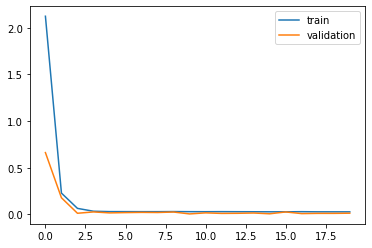


predict: [[31.9437958  24.57741433]]
real:      [[32.  25.3]]

Train on 1389 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 2.3872 - mean_squared_error: 7.4887 - val_loss: 1.6915 - val_mean_squared_error: 5.2773
Epoch 2/1000
 - 0s - loss: 1.3003 - mean_squared_error: 3.2459 - val_loss: 0.8650 - val_mean_squared_error: 1.4018
Epoch 3/1000
 - 0s - loss: 0.4027 - mean_squared_error: 0.4254 - val_loss: 0.1293 - val_mean_squared_error: 0.0265
Epoch 4/1000
 - 0s - loss: 0.0831 - mean_squared_error: 0.0135 - val_loss: 0.0291 - val_mean_squared_error: 8.6865e-04
Epoch 5/1000
 - 0s - loss: 0.0371 - mean_squared_error: 0.0022 - val_loss: 0.0308 - val_mean_squared_error: 0.0011
Epoch 6/1000
 - 0s - loss: 0.0306 - mean_squared_error: 0.0017 - val_loss: 0.0314 - val_mean_squared_error: 9.8844e-04
Epoch 7/1000
 - 0s - loss: 0.0299 - mean_squared_error: 0.0016 - val_loss: 0.0333 - val_mean_squared_error: 0.0011
Epoch 8/1000
 - 0s - loss: 0.0295 - mean_squared_error: 0.0016 - val_loss: 0.0

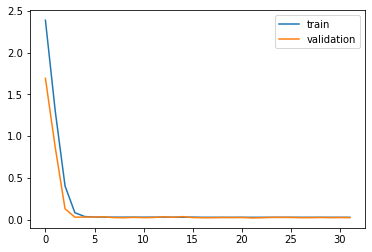


predict: [[31.47179004 24.30447734]]
real:      [[32.2 25.2]]

Train on 1388 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 2.3783 - mean_squared_error: 6.0075 - val_loss: 1.2157 - val_mean_squared_error: 1.4783
Epoch 2/1000
 - 0s - loss: 0.4787 - mean_squared_error: 0.3499 - val_loss: 0.1335 - val_mean_squared_error: 0.0186
Epoch 3/1000
 - 0s - loss: 0.0882 - mean_squared_error: 0.0112 - val_loss: 0.0378 - val_mean_squared_error: 0.0016
Epoch 4/1000
 - 0s - loss: 0.0448 - mean_squared_error: 0.0033 - val_loss: 0.0367 - val_mean_squared_error: 0.0019
Epoch 5/1000
 - 0s - loss: 0.0355 - mean_squared_error: 0.0022 - val_loss: 0.0283 - val_mean_squared_error: 8.0206e-04
Epoch 6/1000
 - 0s - loss: 0.0323 - mean_squared_error: 0.0018 - val_loss: 0.0230 - val_mean_squared_error: 5.3356e-04
Epoch 7/1000
 - 0s - loss: 0.0322 - mean_squared_error: 0.0018 - val_loss: 0.0129 - val_mean_squared_error: 1.7955e-04
Epoch 8/1000
 - 0s - loss: 0.0310 - mean_squared_error: 0.0017 - val_loss:

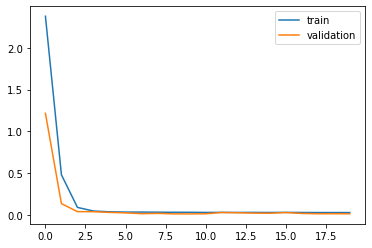


predict: [[31.57446222 24.0718148 ]]
real:      [[32.9 24.5]]

Train on 1387 samples, validate on 1 samples
Epoch 1/1000
 - 6s - loss: 2.4528 - mean_squared_error: 6.3775 - val_loss: 1.3967 - val_mean_squared_error: 2.0193
Epoch 2/1000
 - 0s - loss: 0.5680 - mean_squared_error: 0.5170 - val_loss: 0.2561 - val_mean_squared_error: 0.0660
Epoch 3/1000
 - 0s - loss: 0.0975 - mean_squared_error: 0.0135 - val_loss: 0.0874 - val_mean_squared_error: 0.0083
Epoch 4/1000
 - 0s - loss: 0.0457 - mean_squared_error: 0.0033 - val_loss: 0.0047 - val_mean_squared_error: 2.6852e-05
Epoch 5/1000
 - 0s - loss: 0.0348 - mean_squared_error: 0.0021 - val_loss: 0.0181 - val_mean_squared_error: 3.3495e-04
Epoch 6/1000
 - 0s - loss: 0.0323 - mean_squared_error: 0.0018 - val_loss: 0.0128 - val_mean_squared_error: 2.0398e-04
Epoch 7/1000
 - 0s - loss: 0.0323 - mean_squared_error: 0.0018 - val_loss: 0.0155 - val_mean_squared_error: 2.5506e-04
Epoch 8/1000
 - 0s - loss: 0.0308 - mean_squared_error: 0.0017 - val_l

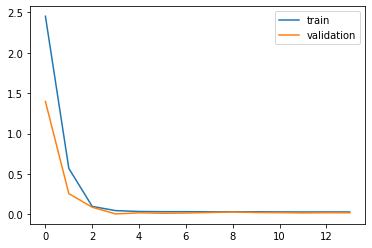


predict: [[33.69315503 25.28796934]]
real:      [[31.4 24.7]]

Train on 1386 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 2.6658 - mean_squared_error: 7.3641 - val_loss: 1.8443 - val_mean_squared_error: 3.4031
Epoch 2/1000
 - 0s - loss: 1.2639 - mean_squared_error: 1.7618 - val_loss: 0.4139 - val_mean_squared_error: 0.1965
Epoch 3/1000
 - 0s - loss: 0.1808 - mean_squared_error: 0.0563 - val_loss: 0.1016 - val_mean_squared_error: 0.0171
Epoch 4/1000
 - 0s - loss: 0.0478 - mean_squared_error: 0.0035 - val_loss: 0.0802 - val_mean_squared_error: 0.0079
Epoch 5/1000
 - 0s - loss: 0.0304 - mean_squared_error: 0.0016 - val_loss: 0.0490 - val_mean_squared_error: 0.0045
Epoch 6/1000
 - 0s - loss: 0.0285 - mean_squared_error: 0.0014 - val_loss: 0.0595 - val_mean_squared_error: 0.0065
Epoch 7/1000
 - 0s - loss: 0.0282 - mean_squared_error: 0.0014 - val_loss: 0.0613 - val_mean_squared_error: 0.0059
Epoch 8/1000
 - 0s - loss: 0.0279 - mean_squared_error: 0.0014 - val_loss: 0.0522 - va

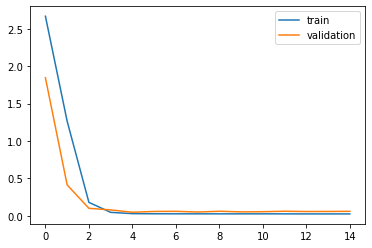


predict: [[31.52031364 24.90967624]]
real:      [[31.5 24.1]]

Train on 1385 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 2.8562 - mean_squared_error: 8.4039 - val_loss: 1.9665 - val_mean_squared_error: 4.2654
Epoch 2/1000
 - 1s - loss: 1.2380 - mean_squared_error: 2.2986 - val_loss: 0.5477 - val_mean_squared_error: 0.5358
Epoch 3/1000
 - 1s - loss: 0.2360 - mean_squared_error: 0.1135 - val_loss: 0.0687 - val_mean_squared_error: 0.0048
Epoch 4/1000
 - 1s - loss: 0.0552 - mean_squared_error: 0.0051 - val_loss: 0.0306 - val_mean_squared_error: 0.0013
Epoch 5/1000
 - 1s - loss: 0.0351 - mean_squared_error: 0.0022 - val_loss: 0.0233 - val_mean_squared_error: 6.2927e-04
Epoch 6/1000
 - 0s - loss: 0.0306 - mean_squared_error: 0.0016 - val_loss: 0.0144 - val_mean_squared_error: 3.5317e-04
Epoch 7/1000
 - 0s - loss: 0.0294 - mean_squared_error: 0.0015 - val_loss: 0.0091 - val_mean_squared_error: 9.0229e-05
Epoch 8/1000
 - 1s - loss: 0.0295 - mean_squared_error: 0.0015 - val_loss:

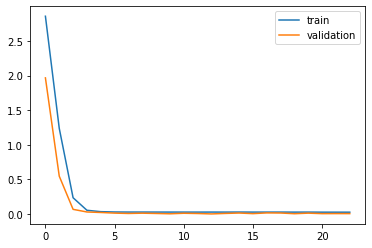


predict: [[31.56024513 24.46395488]]
real:      [[28.9 25.2]]

Train on 1384 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 2.7069 - mean_squared_error: 7.5878 - val_loss: 1.9880 - val_mean_squared_error: 4.1045
Epoch 2/1000
 - 0s - loss: 1.2557 - mean_squared_error: 2.1005 - val_loss: 0.7170 - val_mean_squared_error: 0.7634
Epoch 3/1000
 - 0s - loss: 0.4148 - mean_squared_error: 0.3082 - val_loss: 0.0204 - val_mean_squared_error: 5.2770e-04
Epoch 4/1000
 - 0s - loss: 0.0856 - mean_squared_error: 0.0113 - val_loss: 0.0853 - val_mean_squared_error: 0.0086
Epoch 5/1000
 - 0s - loss: 0.0466 - mean_squared_error: 0.0037 - val_loss: 0.0417 - val_mean_squared_error: 0.0026
Epoch 6/1000
 - 0s - loss: 0.0382 - mean_squared_error: 0.0024 - val_loss: 0.0057 - val_mean_squared_error: 3.2012e-05
Epoch 7/1000
 - 0s - loss: 0.0349 - mean_squared_error: 0.0020 - val_loss: 0.0267 - val_mean_squared_error: 7.1560e-04
Epoch 8/1000
 - 0s - loss: 0.0349 - mean_squared_error: 0.0020 - val_loss:

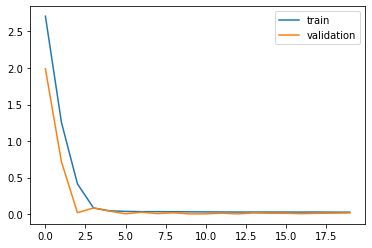


predict: [[33.2989181  24.95613444]]
real:      [[31.7 24.7]]

Train on 1383 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 2.6242 - mean_squared_error: 7.0683 - val_loss: 1.7775 - val_mean_squared_error: 3.2122
Epoch 2/1000
 - 0s - loss: 0.9991 - mean_squared_error: 1.3745 - val_loss: 0.2702 - val_mean_squared_error: 0.1153
Epoch 3/1000
 - 0s - loss: 0.1273 - mean_squared_error: 0.0309 - val_loss: 0.0309 - val_mean_squared_error: 0.0011
Epoch 4/1000
 - 0s - loss: 0.0453 - mean_squared_error: 0.0033 - val_loss: 0.0341 - val_mean_squared_error: 0.0012
Epoch 5/1000
 - 0s - loss: 0.0318 - mean_squared_error: 0.0017 - val_loss: 0.0342 - val_mean_squared_error: 0.0013
Epoch 6/1000
 - 0s - loss: 0.0303 - mean_squared_error: 0.0016 - val_loss: 0.0293 - val_mean_squared_error: 0.0010
Epoch 7/1000
 - 0s - loss: 0.0293 - mean_squared_error: 0.0015 - val_loss: 0.0338 - val_mean_squared_error: 0.0015
Epoch 8/1000
 - 0s - loss: 0.0294 - mean_squared_error: 0.0015 - val_loss: 0.0395 - va

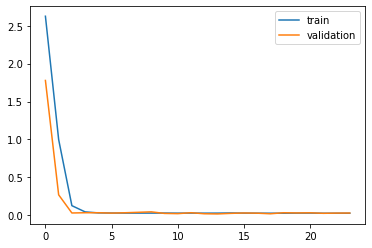


predict: [[31.64112686 23.80188993]]
real:      [[31.9 24.4]]

Train on 1382 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 2.3879 - mean_squared_error: 6.2450 - val_loss: 1.0342 - val_mean_squared_error: 1.0717
Epoch 2/1000
 - 0s - loss: 0.3944 - mean_squared_error: 0.2417 - val_loss: 0.0706 - val_mean_squared_error: 0.0050
Epoch 3/1000
 - 0s - loss: 0.0818 - mean_squared_error: 0.0100 - val_loss: 0.0366 - val_mean_squared_error: 0.0018
Epoch 4/1000
 - 0s - loss: 0.0386 - mean_squared_error: 0.0025 - val_loss: 0.0322 - val_mean_squared_error: 0.0015
Epoch 5/1000
 - 0s - loss: 0.0330 - mean_squared_error: 0.0018 - val_loss: 0.0347 - val_mean_squared_error: 0.0019
Epoch 6/1000
 - 0s - loss: 0.0306 - mean_squared_error: 0.0016 - val_loss: 0.0451 - val_mean_squared_error: 0.0022
Epoch 7/1000
 - 0s - loss: 0.0298 - mean_squared_error: 0.0015 - val_loss: 0.0363 - val_mean_squared_error: 0.0014
Epoch 8/1000
 - 0s - loss: 0.0298 - mean_squared_error: 0.0016 - val_loss: 0.0495 - va

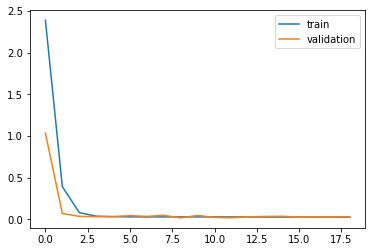


predict: [[32.39206129 24.3044713 ]]
real:      [[30.6 24.5]]

Train on 1381 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 2.5731 - mean_squared_error: 6.9664 - val_loss: 1.7477 - val_mean_squared_error: 3.4465
Epoch 2/1000
 - 0s - loss: 1.0766 - mean_squared_error: 1.8503 - val_loss: 0.5347 - val_mean_squared_error: 0.4093
Epoch 3/1000
 - 0s - loss: 0.1848 - mean_squared_error: 0.0839 - val_loss: 0.0773 - val_mean_squared_error: 0.0072
Epoch 4/1000
 - 0s - loss: 0.0427 - mean_squared_error: 0.0029 - val_loss: 0.0213 - val_mean_squared_error: 7.4622e-04
Epoch 5/1000
 - 0s - loss: 0.0319 - mean_squared_error: 0.0017 - val_loss: 0.0226 - val_mean_squared_error: 5.1160e-04
Epoch 6/1000
 - 0s - loss: 0.0302 - mean_squared_error: 0.0016 - val_loss: 0.0265 - val_mean_squared_error: 7.8193e-04
Epoch 7/1000
 - 0s - loss: 0.0292 - mean_squared_error: 0.0015 - val_loss: 0.0061 - val_mean_squared_error: 3.8594e-05
Epoch 8/1000
 - 0s - loss: 0.0300 - mean_squared_error: 0.0015 - val_l

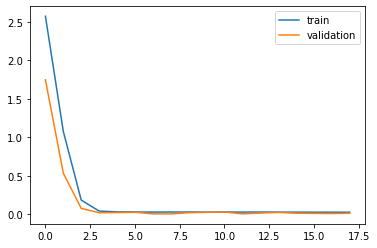


predict: [[32.00552641 24.35819228]]
real:      [[32.8 26.1]]

Train on 1380 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 2.0741 - mean_squared_error: 5.2257 - val_loss: 1.0507 - val_mean_squared_error: 1.7302
Epoch 2/1000
 - 0s - loss: 0.6327 - mean_squared_error: 0.7297 - val_loss: 0.1422 - val_mean_squared_error: 0.0218
Epoch 3/1000
 - 0s - loss: 0.0798 - mean_squared_error: 0.0096 - val_loss: 0.0383 - val_mean_squared_error: 0.0015
Epoch 4/1000
 - 0s - loss: 0.0393 - mean_squared_error: 0.0025 - val_loss: 0.0058 - val_mean_squared_error: 3.9060e-05
Epoch 5/1000
 - 0s - loss: 0.0311 - mean_squared_error: 0.0017 - val_loss: 0.0098 - val_mean_squared_error: 1.4536e-04
Epoch 6/1000
 - 0s - loss: 0.0309 - mean_squared_error: 0.0017 - val_loss: 0.0111 - val_mean_squared_error: 1.3231e-04
Epoch 7/1000
 - 0s - loss: 0.0306 - mean_squared_error: 0.0016 - val_loss: 0.0058 - val_mean_squared_error: 3.3629e-05
Epoch 8/1000
 - 0s - loss: 0.0290 - mean_squared_error: 0.0015 - val_l

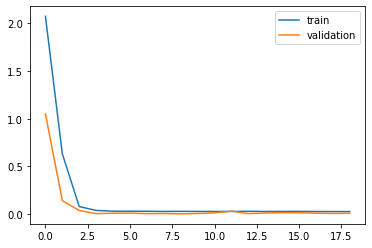


predict: [[32.00001061 24.54439598]]
real:      [[32.6 25.1]]

Train on 1379 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 2.9978 - mean_squared_error: 9.1430 - val_loss: 2.2621 - val_mean_squared_error: 5.1173
Epoch 2/1000
 - 0s - loss: 1.4613 - mean_squared_error: 2.5272 - val_loss: 0.4940 - val_mean_squared_error: 0.4338
Epoch 3/1000
 - 0s - loss: 0.1906 - mean_squared_error: 0.0735 - val_loss: 0.1221 - val_mean_squared_error: 0.0157
Epoch 4/1000
 - 0s - loss: 0.0614 - mean_squared_error: 0.0060 - val_loss: 0.0689 - val_mean_squared_error: 0.0052
Epoch 5/1000
 - 0s - loss: 0.0356 - mean_squared_error: 0.0022 - val_loss: 0.0302 - val_mean_squared_error: 0.0011
Epoch 6/1000
 - 0s - loss: 0.0309 - mean_squared_error: 0.0017 - val_loss: 0.0378 - val_mean_squared_error: 0.0016
Epoch 7/1000
 - 0s - loss: 0.0299 - mean_squared_error: 0.0016 - val_loss: 0.0354 - val_mean_squared_error: 0.0014
Epoch 8/1000
 - 0s - loss: 0.0296 - mean_squared_error: 0.0016 - val_loss: 0.0317 - va

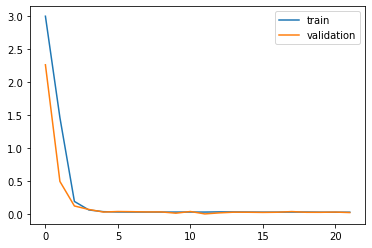


predict: [[32.75374478 24.28073031]]
real:      [[31.8 24.8]]

Train on 1378 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 1.6507 - mean_squared_error: 3.6405 - val_loss: 0.1645 - val_mean_squared_error: 0.0283
Epoch 2/1000
 - 0s - loss: 0.1901 - mean_squared_error: 0.0512 - val_loss: 0.0517 - val_mean_squared_error: 0.0036
Epoch 3/1000
 - 0s - loss: 0.0573 - mean_squared_error: 0.0051 - val_loss: 0.0208 - val_mean_squared_error: 4.6143e-04
Epoch 4/1000
 - 0s - loss: 0.0361 - mean_squared_error: 0.0021 - val_loss: 0.0206 - val_mean_squared_error: 5.2550e-04
Epoch 5/1000
 - 0s - loss: 0.0315 - mean_squared_error: 0.0017 - val_loss: 0.0251 - val_mean_squared_error: 9.2221e-04
Epoch 6/1000
 - 0s - loss: 0.0298 - mean_squared_error: 0.0016 - val_loss: 0.0203 - val_mean_squared_error: 4.3935e-04
Epoch 7/1000
 - 0s - loss: 0.0290 - mean_squared_error: 0.0015 - val_loss: 0.0251 - val_mean_squared_error: 7.3324e-04
Epoch 8/1000
 - 0s - loss: 0.0298 - mean_squared_error: 0.0016 - v

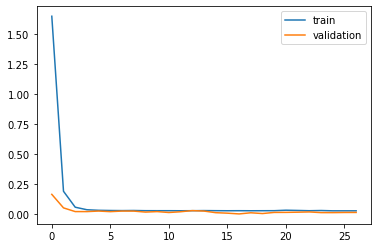


predict: [[31.88824914 24.50021895]]
real:      [[33.2 24.2]]

Train on 1377 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 2.8277 - mean_squared_error: 8.1534 - val_loss: 2.0923 - val_mean_squared_error: 4.3792
Epoch 2/1000
 - 0s - loss: 0.9697 - mean_squared_error: 1.3527 - val_loss: 0.2232 - val_mean_squared_error: 0.0501
Epoch 3/1000
 - 0s - loss: 0.1557 - mean_squared_error: 0.0374 - val_loss: 0.0034 - val_mean_squared_error: 1.4380e-05
Epoch 4/1000
 - 0s - loss: 0.0645 - mean_squared_error: 0.0068 - val_loss: 0.0901 - val_mean_squared_error: 0.0088
Epoch 5/1000
 - 0s - loss: 0.0370 - mean_squared_error: 0.0024 - val_loss: 0.0148 - val_mean_squared_error: 2.2851e-04
Epoch 6/1000
 - 0s - loss: 0.0297 - mean_squared_error: 0.0015 - val_loss: 0.0269 - val_mean_squared_error: 7.5442e-04
Epoch 7/1000
 - 0s - loss: 0.0303 - mean_squared_error: 0.0016 - val_loss: 0.0069 - val_mean_squared_error: 8.4272e-05
Epoch 8/1000
 - 0s - loss: 0.0295 - mean_squared_error: 0.0015 - val_l

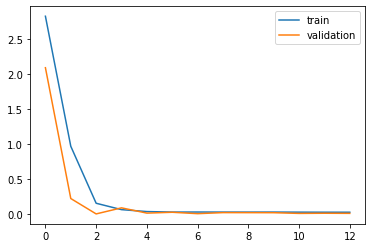


predict: [[36.42575252 26.19168646]]
real:      [[32.4 25.3]]

Train on 1376 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 1.6749 - mean_squared_error: 3.9984 - val_loss: 0.7027 - val_mean_squared_error: 0.6923
Epoch 2/1000
 - 0s - loss: 0.2269 - mean_squared_error: 0.1085 - val_loss: 0.0469 - val_mean_squared_error: 0.0023
Epoch 3/1000
 - 0s - loss: 0.0507 - mean_squared_error: 0.0041 - val_loss: 0.0226 - val_mean_squared_error: 8.6066e-04
Epoch 4/1000
 - 0s - loss: 0.0331 - mean_squared_error: 0.0019 - val_loss: 0.0183 - val_mean_squared_error: 3.8887e-04
Epoch 5/1000
 - 0s - loss: 0.0308 - mean_squared_error: 0.0017 - val_loss: 0.0165 - val_mean_squared_error: 2.8057e-04
Epoch 6/1000
 - 0s - loss: 0.0308 - mean_squared_error: 0.0016 - val_loss: 0.0329 - val_mean_squared_error: 0.0011
Epoch 7/1000
 - 0s - loss: 0.0321 - mean_squared_error: 0.0017 - val_loss: 0.0108 - val_mean_squared_error: 1.1886e-04
Epoch 8/1000
 - 0s - loss: 0.0320 - mean_squared_error: 0.0017 - val_l

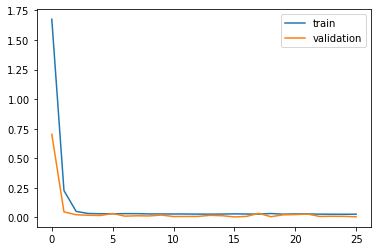


predict: [[31.69072187 24.41247566]]
real:      [[32.2 25.3]]

Train on 1375 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 2.9834 - mean_squared_error: 9.0463 - val_loss: 2.5488 - val_mean_squared_error: 6.7712
Epoch 2/1000
 - 0s - loss: 2.1272 - mean_squared_error: 5.2179 - val_loss: 1.5610 - val_mean_squared_error: 3.8046
Epoch 3/1000
 - 0s - loss: 1.3591 - mean_squared_error: 3.2007 - val_loss: 1.2588 - val_mean_squared_error: 3.0757
Epoch 4/1000
 - 0s - loss: 1.1970 - mean_squared_error: 2.7368 - val_loss: 1.1592 - val_mean_squared_error: 2.6148
Epoch 5/1000
 - 0s - loss: 1.0904 - mean_squared_error: 2.2994 - val_loss: 1.0580 - val_mean_squared_error: 2.1580
Epoch 6/1000
 - 0s - loss: 0.9896 - mean_squared_error: 1.9017 - val_loss: 0.9538 - val_mean_squared_error: 1.7768
Epoch 7/1000
 - 0s - loss: 0.8887 - mean_squared_error: 1.5307 - val_loss: 0.8522 - val_mean_squared_error: 1.4039
Epoch 8/1000
 - 0s - loss: 0.7812 - mean_squared_error: 1.1788 - val_loss: 0.7415 - va

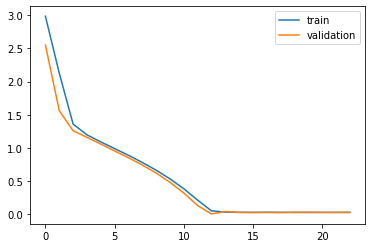


predict: [[31.03150995 25.4598962 ]]
real:      [[32.4 25.3]]

Train on 1374 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 2.4452 - mean_squared_error: 6.3783 - val_loss: 1.5299 - val_mean_squared_error: 2.3823
Epoch 2/1000
 - 0s - loss: 0.6734 - mean_squared_error: 0.7017 - val_loss: 0.1259 - val_mean_squared_error: 0.0256
Epoch 3/1000
 - 0s - loss: 0.1238 - mean_squared_error: 0.0241 - val_loss: 0.0752 - val_mean_squared_error: 0.0077
Epoch 4/1000
 - 0s - loss: 0.0544 - mean_squared_error: 0.0053 - val_loss: 0.0542 - val_mean_squared_error: 0.0032
Epoch 5/1000
 - 0s - loss: 0.0384 - mean_squared_error: 0.0025 - val_loss: 0.0159 - val_mean_squared_error: 3.3305e-04
Epoch 6/1000
 - 0s - loss: 0.0348 - mean_squared_error: 0.0021 - val_loss: 0.0135 - val_mean_squared_error: 1.8220e-04
Epoch 7/1000
 - 0s - loss: 0.0340 - mean_squared_error: 0.0020 - val_loss: 0.0342 - val_mean_squared_error: 0.0012
Epoch 8/1000
 - 0s - loss: 0.0355 - mean_squared_error: 0.0022 - val_loss: 0.0

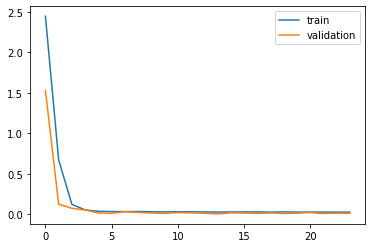


predict: [[32.09736868 24.02261977]]
real:      [[31.2 25.3]]

Train on 1373 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 1.7258 - mean_squared_error: 3.7740 - val_loss: 0.4819 - val_mean_squared_error: 0.2545
Epoch 2/1000
 - 0s - loss: 0.1892 - mean_squared_error: 0.0532 - val_loss: 0.1267 - val_mean_squared_error: 0.0168
Epoch 3/1000
 - 0s - loss: 0.0647 - mean_squared_error: 0.0069 - val_loss: 0.0363 - val_mean_squared_error: 0.0013
Epoch 4/1000
 - 0s - loss: 0.0431 - mean_squared_error: 0.0032 - val_loss: 0.0207 - val_mean_squared_error: 4.5124e-04
Epoch 5/1000
 - 0s - loss: 0.0369 - mean_squared_error: 0.0023 - val_loss: 0.0526 - val_mean_squared_error: 0.0029
Epoch 6/1000
 - 0s - loss: 0.0354 - mean_squared_error: 0.0022 - val_loss: 0.0484 - val_mean_squared_error: 0.0025
Epoch 7/1000
 - 0s - loss: 0.0330 - mean_squared_error: 0.0019 - val_loss: 0.0290 - val_mean_squared_error: 9.2864e-04
Epoch 8/1000
 - 0s - loss: 0.0322 - mean_squared_error: 0.0018 - val_loss: 0.0

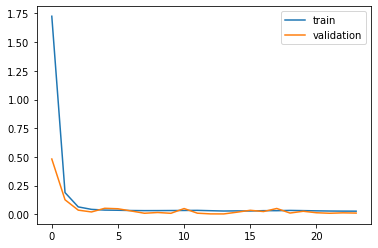


predict: [[31.91027452 24.354964  ]]
real:      [[33.1 25.2]]

Train on 1372 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 2.4667 - mean_squared_error: 6.2364 - val_loss: 1.7338 - val_mean_squared_error: 3.0063
Epoch 2/1000
 - 0s - loss: 0.8759 - mean_squared_error: 1.0749 - val_loss: 0.2315 - val_mean_squared_error: 0.0541
Epoch 3/1000
 - 0s - loss: 0.1377 - mean_squared_error: 0.0278 - val_loss: 0.0206 - val_mean_squared_error: 4.8209e-04
Epoch 4/1000
 - 1s - loss: 0.0482 - mean_squared_error: 0.0037 - val_loss: 0.0071 - val_mean_squared_error: 7.5823e-05
Epoch 5/1000
 - 0s - loss: 0.0338 - mean_squared_error: 0.0019 - val_loss: 0.0168 - val_mean_squared_error: 4.6796e-04
Epoch 6/1000
 - 0s - loss: 0.0317 - mean_squared_error: 0.0017 - val_loss: 0.0257 - val_mean_squared_error: 0.0011
Epoch 7/1000
 - 0s - loss: 0.0307 - mean_squared_error: 0.0017 - val_loss: 0.0154 - val_mean_squared_error: 2.8510e-04
Epoch 8/1000
 - 0s - loss: 0.0304 - mean_squared_error: 0.0016 - val_l

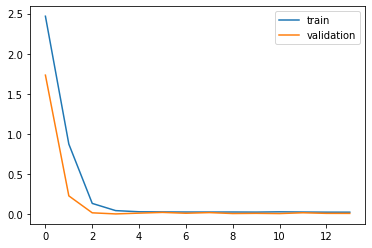


predict: [[31.43890372 24.32198529]]
real:      [[32.7 25.4]]

Train on 1371 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 2.9580 - mean_squared_error: 8.8772 - val_loss: 2.5512 - val_mean_squared_error: 6.8052
Epoch 2/1000
 - 0s - loss: 2.0618 - mean_squared_error: 4.8763 - val_loss: 1.3236 - val_mean_squared_error: 2.3264
Epoch 3/1000
 - 0s - loss: 0.6511 - mean_squared_error: 0.8906 - val_loss: 0.0890 - val_mean_squared_error: 0.0107
Epoch 4/1000
 - 0s - loss: 0.1096 - mean_squared_error: 0.0165 - val_loss: 0.0319 - val_mean_squared_error: 0.0015
Epoch 5/1000
 - 0s - loss: 0.0372 - mean_squared_error: 0.0024 - val_loss: 0.0212 - val_mean_squared_error: 4.9916e-04
Epoch 6/1000
 - 0s - loss: 0.0314 - mean_squared_error: 0.0017 - val_loss: 0.0119 - val_mean_squared_error: 2.3596e-04
Epoch 7/1000
 - 0s - loss: 0.0287 - mean_squared_error: 0.0015 - val_loss: 0.0088 - val_mean_squared_error: 1.4127e-04
Epoch 8/1000
 - 0s - loss: 0.0301 - mean_squared_error: 0.0016 - val_loss:

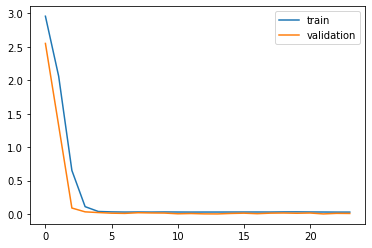


predict: [[31.58521264 24.40194763]]
real:      [[32.2 25.4]]

Train on 1370 samples, validate on 1 samples
Epoch 1/1000
 - 7s - loss: 3.1414 - mean_squared_error: 9.9413 - val_loss: 2.6473 - val_mean_squared_error: 7.0761
Epoch 2/1000
 - 0s - loss: 1.9894 - mean_squared_error: 4.4270 - val_loss: 1.0155 - val_mean_squared_error: 1.7172
Epoch 3/1000
 - 0s - loss: 0.4320 - mean_squared_error: 0.4903 - val_loss: 0.2185 - val_mean_squared_error: 0.0526
Epoch 4/1000
 - 0s - loss: 0.0840 - mean_squared_error: 0.0122 - val_loss: 0.0746 - val_mean_squared_error: 0.0068
Epoch 5/1000
 - 0s - loss: 0.0391 - mean_squared_error: 0.0026 - val_loss: 0.0167 - val_mean_squared_error: 4.6278e-04
Epoch 6/1000
 - 0s - loss: 0.0317 - mean_squared_error: 0.0017 - val_loss: 0.0348 - val_mean_squared_error: 0.0012
Epoch 7/1000
 - 0s - loss: 0.0329 - mean_squared_error: 0.0019 - val_loss: 0.0080 - val_mean_squared_error: 6.8945e-05
Epoch 8/1000
 - 0s - loss: 0.0309 - mean_squared_error: 0.0017 - val_loss: 0.0

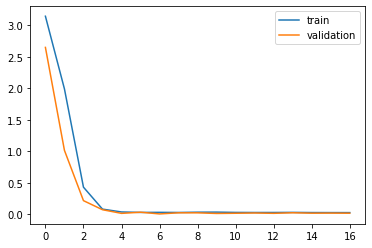


predict: [[32.2299265  24.43542465]]
real:      [[31.9 24.8]]

Train and validation time: 12.56 minutes

Maximum temperatures metrics
Test MEAN-SQUARED-ERROR ------------ 2.189
Test STANDART-DEVIATION ------------ 0.9575
Test MEAN-ABSOLUTE-ERROR ----------- 1.128
Test MEDIAN-ABSOLUTE-ERROR --------- 0.9256

Errors
2018-12-31 = 0.2593011622125374
2018-12-30 = 0.5242333991095762
2018-12-29 = 1.000861220544916
2018-12-28 = 1.4089908027870557
2018-12-27 = 0.5587803401352325
2018-12-26 = 0.25368846455367233
2018-12-25 = 1.2871454181345783
2018-12-24 = 0.28434980814067856
2018-12-23 = 3.6768588143617613
2018-12-22 = 0.056204201851411284
2018-12-21 = 0.7282099599705241
2018-12-20 = 1.3255377751518118
2018-12-19 = 2.293155029001216
2018-12-18 = 0.02031364129013724
2018-12-17 = 2.6602451286064586
2018-12-16 = 1.5989181031742348
2018-12-15 = 0.25887314120913985
2018-12-14 = 1.7920612901182231
2018-12-13 = 0.7944735873364479
2018-12-12 = 0.5999893870194697
2018-12-11 = 0.9537447838406727
2018-12

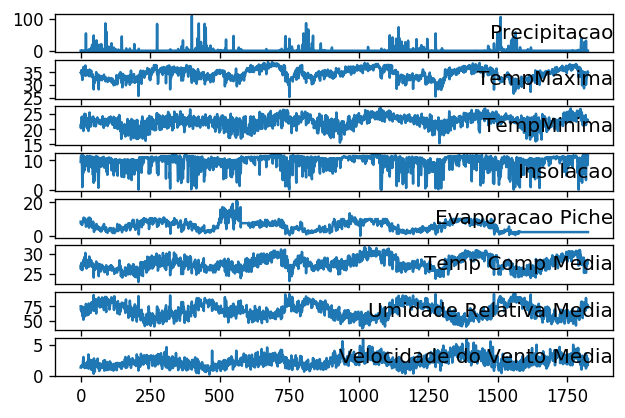

Train on 1764 samples, validate on 1 samples
Epoch 1/1000
 - 8s - loss: 2.1849 - mean_squared_error: 5.3018 - val_loss: 1.0144 - val_mean_squared_error: 1.1227
Epoch 2/1000
 - 1s - loss: 0.4162 - mean_squared_error: 0.2745 - val_loss: 0.1005 - val_mean_squared_error: 0.0102
Epoch 3/1000
 - 1s - loss: 0.0770 - mean_squared_error: 0.0099 - val_loss: 0.0474 - val_mean_squared_error: 0.0028
Epoch 4/1000
 - 1s - loss: 0.0605 - mean_squared_error: 0.0061 - val_loss: 0.0263 - val_mean_squared_error: 7.0846e-04
Epoch 5/1000
 - 1s - loss: 0.0596 - mean_squared_error: 0.0060 - val_loss: 0.0393 - val_mean_squared_error: 0.0016
Epoch 6/1000
 - 1s - loss: 0.0587 - mean_squared_error: 0.0058 - val_loss: 0.0305 - val_mean_squared_error: 9.3937e-04
Epoch 7/1000
 - 1s - loss: 0.0589 - mean_squared_error: 0.0059 - val_loss: 0.0188 - val_mean_squared_error: 3.6301e-04
Epoch 8/1000
 - 1s - loss: 0.0577 - mean_squared_error: 0.0057 - val_loss: 0.0335 - val_mean_squared_error: 0.0011
Epoch 9/1000
 - 1s - lo

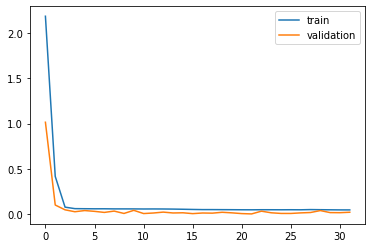


predict: [[34.80395926 22.82557725]]
real:      [[35.  22.8]]

Train on 1763 samples, validate on 1 samples
Epoch 1/1000
 - 8s - loss: 2.9392 - mean_squared_error: 8.7954 - val_loss: 2.3520 - val_mean_squared_error: 5.5548
Epoch 2/1000
 - 1s - loss: 1.4760 - mean_squared_error: 2.6269 - val_loss: 0.0703 - val_mean_squared_error: 0.0061
Epoch 3/1000
 - 1s - loss: 0.1442 - mean_squared_error: 0.0322 - val_loss: 0.0600 - val_mean_squared_error: 0.0037
Epoch 4/1000
 - 1s - loss: 0.0655 - mean_squared_error: 0.0071 - val_loss: 0.0100 - val_mean_squared_error: 1.1910e-04
Epoch 5/1000
 - 1s - loss: 0.0581 - mean_squared_error: 0.0056 - val_loss: 0.0178 - val_mean_squared_error: 3.7053e-04
Epoch 6/1000
 - 1s - loss: 0.0570 - mean_squared_error: 0.0055 - val_loss: 0.0194 - val_mean_squared_error: 5.7231e-04
Epoch 7/1000
 - 1s - loss: 0.0561 - mean_squared_error: 0.0053 - val_loss: 0.0144 - val_mean_squared_error: 2.7645e-04
Epoch 8/1000
 - 1s - loss: 0.0546 - mean_squared_error: 0.0051 - val_l

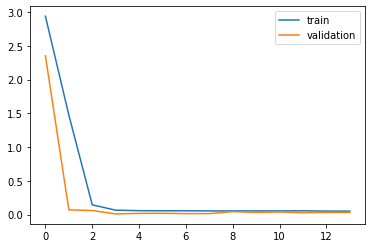


predict: [[33.45403516 22.4766786 ]]
real:      [[35.3 23.1]]

Train on 1762 samples, validate on 1 samples
Epoch 1/1000
 - 8s - loss: 1.8841 - mean_squared_error: 4.4267 - val_loss: 0.8654 - val_mean_squared_error: 1.0458
Epoch 2/1000
 - 1s - loss: 0.3266 - mean_squared_error: 0.2500 - val_loss: 0.0532 - val_mean_squared_error: 0.0037
Epoch 3/1000
 - 1s - loss: 0.0723 - mean_squared_error: 0.0089 - val_loss: 0.0341 - val_mean_squared_error: 0.0015
Epoch 4/1000
 - 1s - loss: 0.0578 - mean_squared_error: 0.0057 - val_loss: 0.0250 - val_mean_squared_error: 7.3418e-04
Epoch 5/1000
 - 1s - loss: 0.0561 - mean_squared_error: 0.0055 - val_loss: 0.0067 - val_mean_squared_error: 7.4535e-05
Epoch 6/1000
 - 1s - loss: 0.0551 - mean_squared_error: 0.0053 - val_loss: 0.0191 - val_mean_squared_error: 5.8415e-04
Epoch 7/1000
 - 1s - loss: 0.0549 - mean_squared_error: 0.0053 - val_loss: 0.0225 - val_mean_squared_error: 9.6566e-04
Epoch 8/1000
 - 1s - loss: 0.0548 - mean_squared_error: 0.0053 - val_l

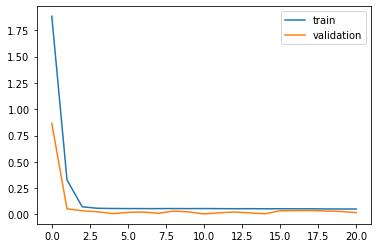


predict: [[34.53415737 22.81153929]]
real:      [[33.8 22.7]]

Train on 1761 samples, validate on 1 samples
Epoch 1/1000
 - 8s - loss: 2.1355 - mean_squared_error: 5.2066 - val_loss: 0.7469 - val_mean_squared_error: 0.9162
Epoch 2/1000
 - 1s - loss: 0.3118 - mean_squared_error: 0.2004 - val_loss: 0.0352 - val_mean_squared_error: 0.0014
Epoch 3/1000
 - 1s - loss: 0.0729 - mean_squared_error: 0.0088 - val_loss: 0.0523 - val_mean_squared_error: 0.0029
Epoch 4/1000
 - 1s - loss: 0.0587 - mean_squared_error: 0.0058 - val_loss: 0.0231 - val_mean_squared_error: 9.3184e-04
Epoch 5/1000
 - 1s - loss: 0.0562 - mean_squared_error: 0.0055 - val_loss: 0.0305 - val_mean_squared_error: 0.0017
Epoch 6/1000
 - 1s - loss: 0.0563 - mean_squared_error: 0.0055 - val_loss: 0.0353 - val_mean_squared_error: 0.0015
Epoch 7/1000
 - 1s - loss: 0.0557 - mean_squared_error: 0.0055 - val_loss: 0.0324 - val_mean_squared_error: 0.0021
Epoch 8/1000
 - 1s - loss: 0.0549 - mean_squared_error: 0.0053 - val_loss: 0.0187 

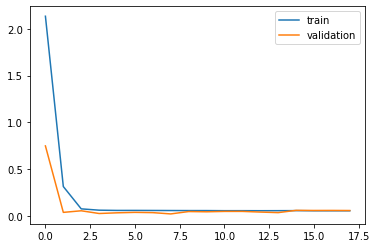


predict: [[34.23717392 22.14713961]]
real:      [[34.3 22.9]]

Train on 1760 samples, validate on 1 samples
Epoch 1/1000
 - 8s - loss: 1.8828 - mean_squared_error: 4.1694 - val_loss: 0.4098 - val_mean_squared_error: 0.2596
Epoch 2/1000
 - 1s - loss: 0.2039 - mean_squared_error: 0.0677 - val_loss: 0.0547 - val_mean_squared_error: 0.0042
Epoch 3/1000
 - 1s - loss: 0.0741 - mean_squared_error: 0.0089 - val_loss: 0.0372 - val_mean_squared_error: 0.0017
Epoch 4/1000
 - 1s - loss: 0.0615 - mean_squared_error: 0.0062 - val_loss: 0.0296 - val_mean_squared_error: 9.5006e-04
Epoch 5/1000
 - 1s - loss: 0.0588 - mean_squared_error: 0.0058 - val_loss: 0.0270 - val_mean_squared_error: 0.0011
Epoch 6/1000
 - 1s - loss: 0.0574 - mean_squared_error: 0.0055 - val_loss: 0.0248 - val_mean_squared_error: 0.0010
Epoch 7/1000
 - 1s - loss: 0.0566 - mean_squared_error: 0.0055 - val_loss: 0.0387 - val_mean_squared_error: 0.0018
Epoch 8/1000
 - 1s - loss: 0.0555 - mean_squared_error: 0.0054 - val_loss: 0.0351 

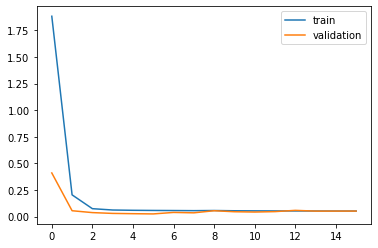


predict: [[34.46024834 23.08862094]]
real:      [[33.  22.3]]

Train on 1759 samples, validate on 1 samples
Epoch 1/1000
 - 8s - loss: 2.6600 - mean_squared_error: 7.4895 - val_loss: 1.6902 - val_mean_squared_error: 3.7500
Epoch 2/1000
 - 1s - loss: 0.8855 - mean_squared_error: 1.4553 - val_loss: 0.1329 - val_mean_squared_error: 0.0178
Epoch 3/1000
 - 1s - loss: 0.1105 - mean_squared_error: 0.0213 - val_loss: 0.0602 - val_mean_squared_error: 0.0066
Epoch 4/1000
 - 1s - loss: 0.0608 - mean_squared_error: 0.0066 - val_loss: 0.0583 - val_mean_squared_error: 0.0047
Epoch 5/1000
 - 1s - loss: 0.0560 - mean_squared_error: 0.0055 - val_loss: 0.0652 - val_mean_squared_error: 0.0048
Epoch 6/1000
 - 1s - loss: 0.0553 - mean_squared_error: 0.0054 - val_loss: 0.0736 - val_mean_squared_error: 0.0072
Epoch 7/1000
 - 1s - loss: 0.0556 - mean_squared_error: 0.0054 - val_loss: 0.0612 - val_mean_squared_error: 0.0061
Epoch 8/1000
 - 1s - loss: 0.0551 - mean_squared_error: 0.0054 - val_loss: 0.0775 - va

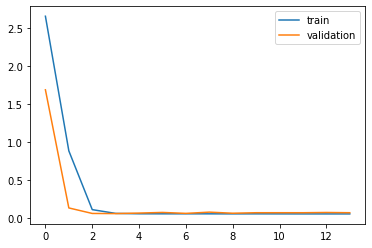


predict: [[34.51911428 22.64981637]]
real:      [[32.6 22.9]]

Train on 1758 samples, validate on 1 samples
Epoch 1/1000
 - 8s - loss: 2.3822 - mean_squared_error: 6.2279 - val_loss: 1.2246 - val_mean_squared_error: 1.8858
Epoch 2/1000
 - 1s - loss: 0.5512 - mean_squared_error: 0.6566 - val_loss: 0.2556 - val_mean_squared_error: 0.0841
Epoch 3/1000
 - 1s - loss: 0.0976 - mean_squared_error: 0.0155 - val_loss: 0.0859 - val_mean_squared_error: 0.0101
Epoch 4/1000
 - 1s - loss: 0.0596 - mean_squared_error: 0.0059 - val_loss: 0.0662 - val_mean_squared_error: 0.0056
Epoch 5/1000
 - 1s - loss: 0.0586 - mean_squared_error: 0.0058 - val_loss: 0.0873 - val_mean_squared_error: 0.0094
Epoch 6/1000
 - 1s - loss: 0.0588 - mean_squared_error: 0.0058 - val_loss: 0.0859 - val_mean_squared_error: 0.0087
Epoch 7/1000
 - 1s - loss: 0.0584 - mean_squared_error: 0.0058 - val_loss: 0.0855 - val_mean_squared_error: 0.0089
Epoch 8/1000
 - 1s - loss: 0.0578 - mean_squared_error: 0.0057 - val_loss: 0.0771 - va

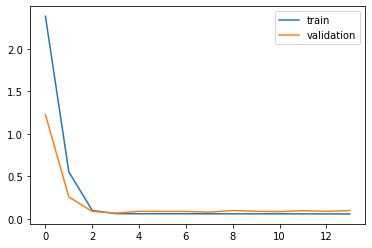


predict: [[36.21553935 23.17271537]]
real:      [[31.4 23.2]]

Train on 1757 samples, validate on 1 samples
Epoch 1/1000
 - 8s - loss: 2.3051 - mean_squared_error: 6.1002 - val_loss: 1.1482 - val_mean_squared_error: 1.6667
Epoch 2/1000
 - 1s - loss: 0.4329 - mean_squared_error: 0.4285 - val_loss: 0.1706 - val_mean_squared_error: 0.0312
Epoch 3/1000
 - 1s - loss: 0.0781 - mean_squared_error: 0.0098 - val_loss: 0.0448 - val_mean_squared_error: 0.0026
Epoch 4/1000
 - 1s - loss: 0.0630 - mean_squared_error: 0.0065 - val_loss: 0.0725 - val_mean_squared_error: 0.0070
Epoch 5/1000
 - 1s - loss: 0.0594 - mean_squared_error: 0.0059 - val_loss: 0.0672 - val_mean_squared_error: 0.0060
Epoch 6/1000
 - 1s - loss: 0.0578 - mean_squared_error: 0.0056 - val_loss: 0.0787 - val_mean_squared_error: 0.0062
Epoch 7/1000
 - 1s - loss: 0.0568 - mean_squared_error: 0.0054 - val_loss: 0.0718 - val_mean_squared_error: 0.0052
Epoch 8/1000
 - 1s - loss: 0.0555 - mean_squared_error: 0.0052 - val_loss: 0.0745 - va

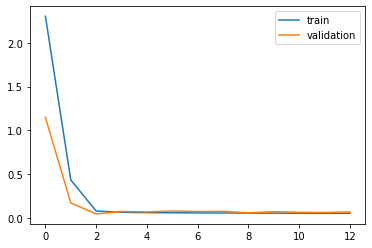


predict: [[34.55774278 22.95450203]]
real:      [[30.  21.3]]

Train on 1756 samples, validate on 1 samples
Epoch 1/1000
 - 8s - loss: 2.4919 - mean_squared_error: 6.9937 - val_loss: 1.1500 - val_mean_squared_error: 2.5724
Epoch 2/1000
 - 1s - loss: 0.4967 - mean_squared_error: 0.6308 - val_loss: 0.1061 - val_mean_squared_error: 0.0113
Epoch 3/1000
 - 1s - loss: 0.0873 - mean_squared_error: 0.0121 - val_loss: 0.0340 - val_mean_squared_error: 0.0019
Epoch 4/1000
 - 1s - loss: 0.0580 - mean_squared_error: 0.0058 - val_loss: 0.0338 - val_mean_squared_error: 0.0020
Epoch 5/1000
 - 1s - loss: 0.0565 - mean_squared_error: 0.0055 - val_loss: 0.0198 - val_mean_squared_error: 7.4299e-04
Epoch 6/1000
 - 1s - loss: 0.0579 - mean_squared_error: 0.0057 - val_loss: 0.0352 - val_mean_squared_error: 0.0013
Epoch 7/1000
 - 1s - loss: 0.0564 - mean_squared_error: 0.0055 - val_loss: 0.0301 - val_mean_squared_error: 0.0012
Epoch 8/1000
 - 1s - loss: 0.0566 - mean_squared_error: 0.0055 - val_loss: 0.0235 

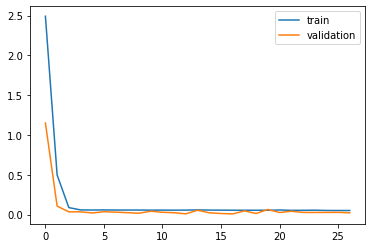


predict: [[34.57010531 23.42096443]]
real:      [[32.6 24.6]]

Train on 1755 samples, validate on 1 samples
Epoch 1/1000
 - 8s - loss: 1.7297 - mean_squared_error: 3.7633 - val_loss: 0.1075 - val_mean_squared_error: 0.0127
Epoch 2/1000
 - 1s - loss: 0.1720 - mean_squared_error: 0.0442 - val_loss: 0.0729 - val_mean_squared_error: 0.0064
Epoch 3/1000
 - 1s - loss: 0.0713 - mean_squared_error: 0.0085 - val_loss: 0.0487 - val_mean_squared_error: 0.0026
Epoch 4/1000
 - 1s - loss: 0.0604 - mean_squared_error: 0.0062 - val_loss: 0.0200 - val_mean_squared_error: 5.3529e-04
Epoch 5/1000
 - 1s - loss: 0.0564 - mean_squared_error: 0.0055 - val_loss: 0.0091 - val_mean_squared_error: 8.3870e-05
Epoch 6/1000
 - 1s - loss: 0.0565 - mean_squared_error: 0.0055 - val_loss: 0.0133 - val_mean_squared_error: 2.8628e-04
Epoch 7/1000
 - 1s - loss: 0.0559 - mean_squared_error: 0.0054 - val_loss: 0.0064 - val_mean_squared_error: 6.4532e-05
Epoch 8/1000
 - 1s - loss: 0.0534 - mean_squared_error: 0.0051 - val_l

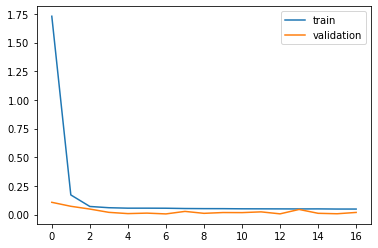


predict: [[35.5458532  22.61224272]]
real:      [[34.4 23.7]]

Train on 1754 samples, validate on 1 samples
Epoch 1/1000
 - 8s - loss: 2.8501 - mean_squared_error: 8.9615 - val_loss: 2.0982 - val_mean_squared_error: 6.1149
Epoch 2/1000
 - 1s - loss: 1.4261 - mean_squared_error: 3.7305 - val_loss: 0.7301 - val_mean_squared_error: 1.0458
Epoch 3/1000
 - 1s - loss: 0.3182 - mean_squared_error: 0.2502 - val_loss: 0.0935 - val_mean_squared_error: 0.0098
Epoch 4/1000
 - 1s - loss: 0.0752 - mean_squared_error: 0.0092 - val_loss: 0.0468 - val_mean_squared_error: 0.0023
Epoch 5/1000
 - 1s - loss: 0.0643 - mean_squared_error: 0.0068 - val_loss: 0.0328 - val_mean_squared_error: 0.0015
Epoch 6/1000
 - 1s - loss: 0.0606 - mean_squared_error: 0.0061 - val_loss: 0.0174 - val_mean_squared_error: 5.3266e-04
Epoch 7/1000
 - 1s - loss: 0.0596 - mean_squared_error: 0.0060 - val_loss: 0.0334 - val_mean_squared_error: 0.0012
Epoch 8/1000
 - 1s - loss: 0.0592 - mean_squared_error: 0.0059 - val_loss: 0.0085 

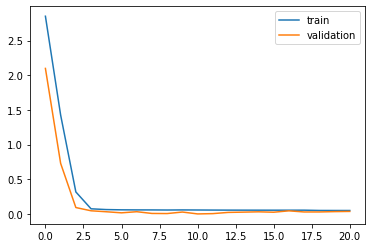


predict: [[34.18151798 23.04256456]]
real:      [[34.9 22.9]]

Train on 1753 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 2.7918 - mean_squared_error: 9.5187 - val_loss: 2.1563 - val_mean_squared_error: 8.8017
Epoch 2/1000
 - 1s - loss: 1.8671 - mean_squared_error: 6.5716 - val_loss: 1.5320 - val_mean_squared_error: 4.3387
Epoch 3/1000
 - 1s - loss: 1.2468 - mean_squared_error: 3.0022 - val_loss: 0.9520 - val_mean_squared_error: 1.7956
Epoch 4/1000
 - 1s - loss: 0.7535 - mean_squared_error: 1.1113 - val_loss: 0.4244 - val_mean_squared_error: 0.3457
Epoch 5/1000
 - 1s - loss: 0.1759 - mean_squared_error: 0.0806 - val_loss: 0.0245 - val_mean_squared_error: 6.0899e-04
Epoch 6/1000
 - 1s - loss: 0.0635 - mean_squared_error: 0.0068 - val_loss: 0.0107 - val_mean_squared_error: 2.2315e-04
Epoch 7/1000
 - 1s - loss: 0.0566 - mean_squared_error: 0.0056 - val_loss: 0.0089 - val_mean_squared_error: 1.1678e-04
Epoch 8/1000
 - 1s - loss: 0.0564 - mean_squared_error: 0.0057 - val_loss:

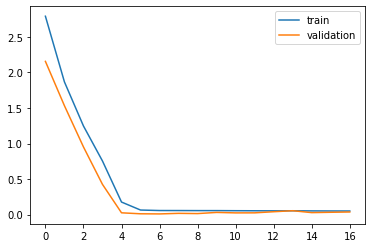


predict: [[34.91000917 22.75173799]]
real:      [[34.  22.8]]

Train on 1752 samples, validate on 1 samples
Epoch 1/1000
 - 8s - loss: 2.8242 - mean_squared_error: 8.1022 - val_loss: 2.2257 - val_mean_squared_error: 5.0283
Epoch 2/1000
 - 1s - loss: 1.4639 - mean_squared_error: 2.6162 - val_loss: 0.4221 - val_mean_squared_error: 0.2668
Epoch 3/1000
 - 1s - loss: 0.1871 - mean_squared_error: 0.0547 - val_loss: 0.0409 - val_mean_squared_error: 0.0017
Epoch 4/1000
 - 1s - loss: 0.0738 - mean_squared_error: 0.0089 - val_loss: 0.0557 - val_mean_squared_error: 0.0035
Epoch 5/1000
 - 1s - loss: 0.0644 - mean_squared_error: 0.0067 - val_loss: 0.0403 - val_mean_squared_error: 0.0017
Epoch 6/1000
 - 1s - loss: 0.0622 - mean_squared_error: 0.0064 - val_loss: 0.0494 - val_mean_squared_error: 0.0025
Epoch 7/1000
 - 1s - loss: 0.0618 - mean_squared_error: 0.0063 - val_loss: 0.0372 - val_mean_squared_error: 0.0016
Epoch 8/1000
 - 1s - loss: 0.0605 - mean_squared_error: 0.0061 - val_loss: 0.0260 - va

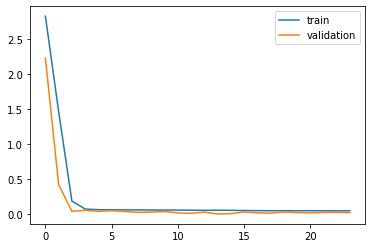


predict: [[36.39230624 23.22642481]]
real:      [[34.7 22.3]]

Train on 1751 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 2.9232 - mean_squared_error: 8.8553 - val_loss: 2.2310 - val_mean_squared_error: 5.3040
Epoch 2/1000
 - 1s - loss: 1.6442 - mean_squared_error: 3.6338 - val_loss: 0.9466 - val_mean_squared_error: 1.5066
Epoch 3/1000
 - 1s - loss: 0.6658 - mean_squared_error: 0.8234 - val_loss: 0.0926 - val_mean_squared_error: 0.0149
Epoch 4/1000
 - 1s - loss: 0.1022 - mean_squared_error: 0.0175 - val_loss: 0.0468 - val_mean_squared_error: 0.0040
Epoch 5/1000
 - 1s - loss: 0.0635 - mean_squared_error: 0.0068 - val_loss: 0.0943 - val_mean_squared_error: 0.0129
Epoch 6/1000
 - 1s - loss: 0.0582 - mean_squared_error: 0.0058 - val_loss: 0.1167 - val_mean_squared_error: 0.0194
Epoch 7/1000
 - 1s - loss: 0.0580 - mean_squared_error: 0.0058 - val_loss: 0.0985 - val_mean_squared_error: 0.0179
Epoch 8/1000
 - 1s - loss: 0.0577 - mean_squared_error: 0.0058 - val_loss: 0.1028 - va

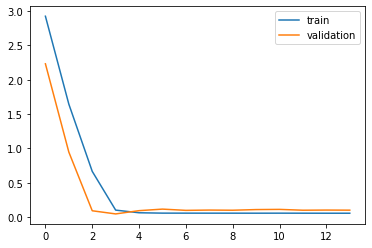


predict: [[31.58881761 23.48584809]]
real:      [[34.9 23.1]]

Train on 1750 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 2.2147 - mean_squared_error: 5.4482 - val_loss: 0.9182 - val_mean_squared_error: 0.8553
Epoch 2/1000
 - 1s - loss: 0.2827 - mean_squared_error: 0.1385 - val_loss: 0.1332 - val_mean_squared_error: 0.0285
Epoch 3/1000
 - 1s - loss: 0.0786 - mean_squared_error: 0.0103 - val_loss: 0.0120 - val_mean_squared_error: 1.5283e-04
Epoch 4/1000
 - 1s - loss: 0.0569 - mean_squared_error: 0.0056 - val_loss: 0.0399 - val_mean_squared_error: 0.0017
Epoch 5/1000
 - 1s - loss: 0.0561 - mean_squared_error: 0.0055 - val_loss: 0.0265 - val_mean_squared_error: 7.1835e-04
Epoch 6/1000
 - 1s - loss: 0.0556 - mean_squared_error: 0.0053 - val_loss: 0.0114 - val_mean_squared_error: 2.3955e-04
Epoch 7/1000
 - 1s - loss: 0.0557 - mean_squared_error: 0.0054 - val_loss: 0.0095 - val_mean_squared_error: 1.2474e-04
Epoch 8/1000
 - 1s - loss: 0.0552 - mean_squared_error: 0.0053 - val_l

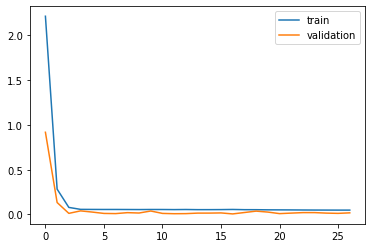


predict: [[34.97065943 23.01402372]]
real:      [[28.6 23.2]]

Train on 1749 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 1.9555 - mean_squared_error: 4.6725 - val_loss: 0.8353 - val_mean_squared_error: 0.9549
Epoch 2/1000
 - 1s - loss: 0.4299 - mean_squared_error: 0.3226 - val_loss: 0.0845 - val_mean_squared_error: 0.0090
Epoch 3/1000
 - 1s - loss: 0.0831 - mean_squared_error: 0.0112 - val_loss: 0.0284 - val_mean_squared_error: 9.3442e-04
Epoch 4/1000
 - 1s - loss: 0.0579 - mean_squared_error: 0.0058 - val_loss: 0.0089 - val_mean_squared_error: 9.4150e-05
Epoch 5/1000
 - 1s - loss: 0.0544 - mean_squared_error: 0.0052 - val_loss: 0.0321 - val_mean_squared_error: 0.0011
Epoch 6/1000
 - 1s - loss: 0.0535 - mean_squared_error: 0.0051 - val_loss: 0.0144 - val_mean_squared_error: 2.5142e-04
Epoch 7/1000
 - 1s - loss: 0.0539 - mean_squared_error: 0.0052 - val_loss: 0.0115 - val_mean_squared_error: 1.3288e-04
Epoch 8/1000
 - 1s - loss: 0.0522 - mean_squared_error: 0.0049 - val_l

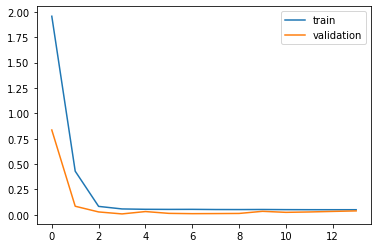


predict: [[34.74855871 22.71339746]]
real:      [[35.  23.2]]

Train on 1748 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 2.6394 - mean_squared_error: 7.6327 - val_loss: 1.7482 - val_mean_squared_error: 4.6642
Epoch 2/1000
 - 1s - loss: 1.2622 - mean_squared_error: 2.9471 - val_loss: 0.9764 - val_mean_squared_error: 1.7069
Epoch 3/1000
 - 1s - loss: 0.8049 - mean_squared_error: 1.1867 - val_loss: 0.6754 - val_mean_squared_error: 0.8791
Epoch 4/1000
 - 1s - loss: 0.5300 - mean_squared_error: 0.5201 - val_loss: 0.3630 - val_mean_squared_error: 0.2353
Epoch 5/1000
 - 1s - loss: 0.1714 - mean_squared_error: 0.0640 - val_loss: 0.0414 - val_mean_squared_error: 0.0024
Epoch 6/1000
 - 1s - loss: 0.0606 - mean_squared_error: 0.0063 - val_loss: 0.0413 - val_mean_squared_error: 0.0020
Epoch 7/1000
 - 1s - loss: 0.0558 - mean_squared_error: 0.0054 - val_loss: 0.0209 - val_mean_squared_error: 7.0110e-04
Epoch 8/1000
 - 1s - loss: 0.0545 - mean_squared_error: 0.0052 - val_loss: 0.0198 

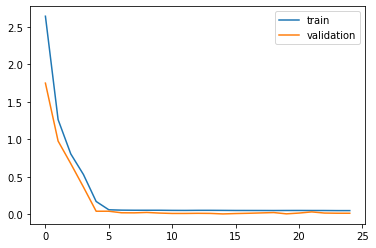


predict: [[35.69007928 23.57906338]]
real:      [[35.  22.7]]

Train on 1747 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 2.0324 - mean_squared_error: 4.8410 - val_loss: 0.4116 - val_mean_squared_error: 0.1697
Epoch 2/1000
 - 1s - loss: 0.1751 - mean_squared_error: 0.0441 - val_loss: 0.0104 - val_mean_squared_error: 1.8887e-04
Epoch 3/1000
 - 1s - loss: 0.0698 - mean_squared_error: 0.0080 - val_loss: 0.0551 - val_mean_squared_error: 0.0035
Epoch 4/1000
 - 1s - loss: 0.0606 - mean_squared_error: 0.0061 - val_loss: 0.0393 - val_mean_squared_error: 0.0021
Epoch 5/1000
 - 1s - loss: 0.0596 - mean_squared_error: 0.0059 - val_loss: 0.0465 - val_mean_squared_error: 0.0034
Epoch 6/1000
 - 1s - loss: 0.0591 - mean_squared_error: 0.0059 - val_loss: 0.0584 - val_mean_squared_error: 0.0040
Epoch 7/1000
 - 1s - loss: 0.0580 - mean_squared_error: 0.0057 - val_loss: 0.0366 - val_mean_squared_error: 0.0022
Epoch 8/1000
 - 1s - loss: 0.0572 - mean_squared_error: 0.0056 - val_loss: 0.0456 

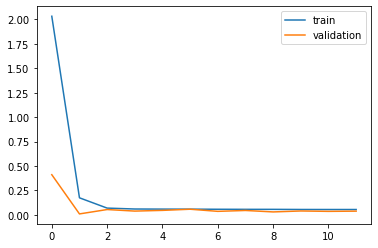


predict: [[35.41913934 20.6741877 ]]
real:      [[35.2 23.6]]

Train on 1746 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 1.6832 - mean_squared_error: 3.8990 - val_loss: 0.4164 - val_mean_squared_error: 0.1881
Epoch 2/1000
 - 1s - loss: 0.1693 - mean_squared_error: 0.0481 - val_loss: 0.0338 - val_mean_squared_error: 0.0018
Epoch 3/1000
 - 1s - loss: 0.0683 - mean_squared_error: 0.0077 - val_loss: 0.0122 - val_mean_squared_error: 2.0947e-04
Epoch 4/1000
 - 1s - loss: 0.0606 - mean_squared_error: 0.0064 - val_loss: 0.0458 - val_mean_squared_error: 0.0023
Epoch 5/1000
 - 1s - loss: 0.0595 - mean_squared_error: 0.0061 - val_loss: 0.0164 - val_mean_squared_error: 3.0525e-04
Epoch 6/1000
 - 1s - loss: 0.0568 - mean_squared_error: 0.0056 - val_loss: 0.0240 - val_mean_squared_error: 6.0104e-04
Epoch 7/1000
 - 1s - loss: 0.0558 - mean_squared_error: 0.0055 - val_loss: 0.0429 - val_mean_squared_error: 0.0018
Epoch 8/1000
 - 1s - loss: 0.0540 - mean_squared_error: 0.0052 - val_loss:

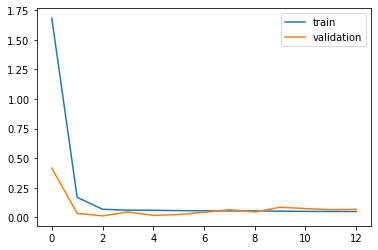


predict: [[36.05960672 22.3878448 ]]
real:      [[34.9 21.2]]

Train on 1745 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 2.5531 - mean_squared_error: 6.8104 - val_loss: 1.6214 - val_mean_squared_error: 2.6490
Epoch 2/1000
 - 1s - loss: 0.7128 - mean_squared_error: 0.7391 - val_loss: 0.3054 - val_mean_squared_error: 0.1291
Epoch 3/1000
 - 1s - loss: 0.1175 - mean_squared_error: 0.0270 - val_loss: 0.0897 - val_mean_squared_error: 0.0083
Epoch 4/1000
 - 1s - loss: 0.0622 - mean_squared_error: 0.0064 - val_loss: 0.0622 - val_mean_squared_error: 0.0045
Epoch 5/1000
 - 1s - loss: 0.0587 - mean_squared_error: 0.0058 - val_loss: 0.0431 - val_mean_squared_error: 0.0031
Epoch 6/1000
 - 1s - loss: 0.0569 - mean_squared_error: 0.0056 - val_loss: 0.0439 - val_mean_squared_error: 0.0031
Epoch 7/1000
 - 1s - loss: 0.0572 - mean_squared_error: 0.0056 - val_loss: 0.0378 - val_mean_squared_error: 0.0027
Epoch 8/1000
 - 1s - loss: 0.0563 - mean_squared_error: 0.0055 - val_loss: 0.0400 - va

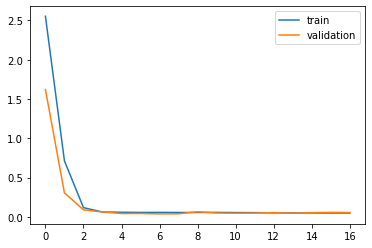


predict: [[35.06005584 23.07601223]]
real:      [[33.4 21.6]]

Train on 1744 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 2.0494 - mean_squared_error: 5.2958 - val_loss: 1.2586 - val_mean_squared_error: 2.4884
Epoch 2/1000
 - 1s - loss: 0.6646 - mean_squared_error: 0.9339 - val_loss: 0.1460 - val_mean_squared_error: 0.0222
Epoch 3/1000
 - 1s - loss: 0.0987 - mean_squared_error: 0.0162 - val_loss: 0.1105 - val_mean_squared_error: 0.0133
Epoch 4/1000
 - 1s - loss: 0.0633 - mean_squared_error: 0.0067 - val_loss: 0.0608 - val_mean_squared_error: 0.0050
Epoch 5/1000
 - 1s - loss: 0.0608 - mean_squared_error: 0.0062 - val_loss: 0.1130 - val_mean_squared_error: 0.0170
Epoch 6/1000
 - 1s - loss: 0.0595 - mean_squared_error: 0.0060 - val_loss: 0.0862 - val_mean_squared_error: 0.0094
Epoch 7/1000
 - 1s - loss: 0.0573 - mean_squared_error: 0.0057 - val_loss: 0.0857 - val_mean_squared_error: 0.0085
Epoch 8/1000
 - 1s - loss: 0.0560 - mean_squared_error: 0.0055 - val_loss: 0.1112 - va

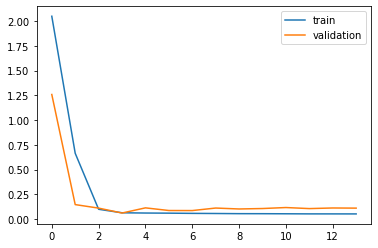


predict: [[33.41262622 23.08943074]]
real:      [[34.4 24.5]]

Train on 1743 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 1.5808 - mean_squared_error: 3.5045 - val_loss: 0.4442 - val_mean_squared_error: 0.3367
Epoch 2/1000
 - 1s - loss: 0.1751 - mean_squared_error: 0.0636 - val_loss: 0.1260 - val_mean_squared_error: 0.0204
Epoch 3/1000
 - 1s - loss: 0.0669 - mean_squared_error: 0.0076 - val_loss: 0.1103 - val_mean_squared_error: 0.0153
Epoch 4/1000
 - 1s - loss: 0.0603 - mean_squared_error: 0.0061 - val_loss: 0.0954 - val_mean_squared_error: 0.0112
Epoch 5/1000
 - 1s - loss: 0.0587 - mean_squared_error: 0.0059 - val_loss: 0.0898 - val_mean_squared_error: 0.0105
Epoch 6/1000
 - 1s - loss: 0.0582 - mean_squared_error: 0.0057 - val_loss: 0.0673 - val_mean_squared_error: 0.0066
Epoch 7/1000
 - 1s - loss: 0.0565 - mean_squared_error: 0.0055 - val_loss: 0.0715 - val_mean_squared_error: 0.0079
Epoch 8/1000
 - 1s - loss: 0.0569 - mean_squared_error: 0.0058 - val_loss: 0.0925 - va

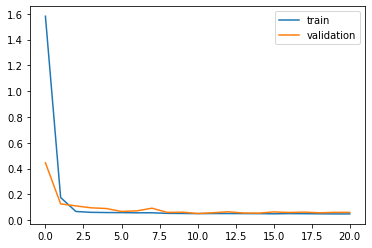


predict: [[36.41381545 23.31345223]]
real:      [[29.8 23.4]]

Train on 1742 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 1.7761 - mean_squared_error: 4.0368 - val_loss: 0.3740 - val_mean_squared_error: 0.1400
Epoch 2/1000
 - 1s - loss: 0.1813 - mean_squared_error: 0.0623 - val_loss: 0.0282 - val_mean_squared_error: 9.6968e-04
Epoch 3/1000
 - 1s - loss: 0.0671 - mean_squared_error: 0.0074 - val_loss: 0.0476 - val_mean_squared_error: 0.0024
Epoch 4/1000
 - 1s - loss: 0.0597 - mean_squared_error: 0.0060 - val_loss: 0.0444 - val_mean_squared_error: 0.0020
Epoch 5/1000
 - 1s - loss: 0.0584 - mean_squared_error: 0.0059 - val_loss: 0.0472 - val_mean_squared_error: 0.0024
Epoch 6/1000
 - 1s - loss: 0.0580 - mean_squared_error: 0.0057 - val_loss: 0.0416 - val_mean_squared_error: 0.0018
Epoch 7/1000
 - 1s - loss: 0.0569 - mean_squared_error: 0.0057 - val_loss: 0.0499 - val_mean_squared_error: 0.0025
Epoch 8/1000
 - 1s - loss: 0.0565 - mean_squared_error: 0.0055 - val_loss: 0.0482 

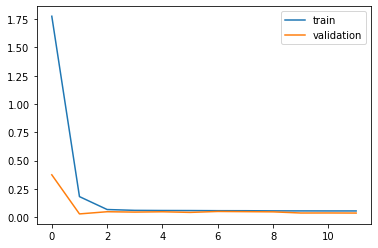


predict: [[35.21443334 25.29915928]]
real:      [[35.5 25.5]]

Train on 1741 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 2.5055 - mean_squared_error: 6.9952 - val_loss: 1.3981 - val_mean_squared_error: 2.7491
Epoch 2/1000
 - 1s - loss: 0.6314 - mean_squared_error: 0.8903 - val_loss: 0.1299 - val_mean_squared_error: 0.0242
Epoch 3/1000
 - 1s - loss: 0.0915 - mean_squared_error: 0.0133 - val_loss: 0.0331 - val_mean_squared_error: 0.0012
Epoch 4/1000
 - 1s - loss: 0.0577 - mean_squared_error: 0.0057 - val_loss: 0.0168 - val_mean_squared_error: 3.1986e-04
Epoch 5/1000
 - 1s - loss: 0.0537 - mean_squared_error: 0.0053 - val_loss: 0.0337 - val_mean_squared_error: 0.0011
Epoch 6/1000
 - 1s - loss: 0.0534 - mean_squared_error: 0.0053 - val_loss: 0.0202 - val_mean_squared_error: 5.8764e-04
Epoch 7/1000
 - 1s - loss: 0.0523 - mean_squared_error: 0.0051 - val_loss: 0.0306 - val_mean_squared_error: 9.3812e-04
Epoch 8/1000
 - 1s - loss: 0.0519 - mean_squared_error: 0.0050 - val_loss:

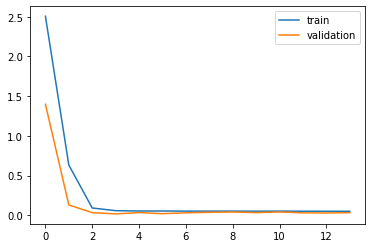


predict: [[37.06378829 24.50806908]]
real:      [[35.6 23.9]]

Train on 1740 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 2.1336 - mean_squared_error: 5.4063 - val_loss: 0.4757 - val_mean_squared_error: 0.2414
Epoch 2/1000
 - 1s - loss: 0.1866 - mean_squared_error: 0.0526 - val_loss: 0.0323 - val_mean_squared_error: 0.0016
Epoch 3/1000
 - 1s - loss: 0.0718 - mean_squared_error: 0.0085 - val_loss: 0.0247 - val_mean_squared_error: 6.1443e-04
Epoch 4/1000
 - 1s - loss: 0.0612 - mean_squared_error: 0.0061 - val_loss: 0.0128 - val_mean_squared_error: 2.0677e-04
Epoch 5/1000
 - 1s - loss: 0.0601 - mean_squared_error: 0.0060 - val_loss: 0.0255 - val_mean_squared_error: 9.0801e-04
Epoch 6/1000
 - 1s - loss: 0.0595 - mean_squared_error: 0.0059 - val_loss: 0.0185 - val_mean_squared_error: 3.6634e-04
Epoch 7/1000
 - 1s - loss: 0.0590 - mean_squared_error: 0.0058 - val_loss: 0.0135 - val_mean_squared_error: 1.8592e-04
Epoch 8/1000
 - 1s - loss: 0.0572 - mean_squared_error: 0.0056 - v

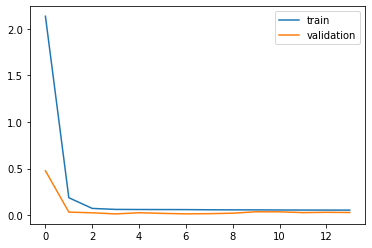


predict: [[36.71991584 24.56500154]]
real:      [[34.8 23. ]]

Train on 1739 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 2.5153 - mean_squared_error: 6.6688 - val_loss: 1.7117 - val_mean_squared_error: 3.3097
Epoch 2/1000
 - 1s - loss: 0.8426 - mean_squared_error: 1.1218 - val_loss: 0.2791 - val_mean_squared_error: 0.0918
Epoch 3/1000
 - 1s - loss: 0.1122 - mean_squared_error: 0.0200 - val_loss: 0.1119 - val_mean_squared_error: 0.0212
Epoch 4/1000
 - 1s - loss: 0.0643 - mean_squared_error: 0.0069 - val_loss: 0.0893 - val_mean_squared_error: 0.0101
Epoch 5/1000
 - 1s - loss: 0.0589 - mean_squared_error: 0.0059 - val_loss: 0.0930 - val_mean_squared_error: 0.0122
Epoch 6/1000
 - 1s - loss: 0.0566 - mean_squared_error: 0.0055 - val_loss: 0.0851 - val_mean_squared_error: 0.0102
Epoch 7/1000
 - 1s - loss: 0.0557 - mean_squared_error: 0.0054 - val_loss: 0.0845 - val_mean_squared_error: 0.0096
Epoch 8/1000
 - 1s - loss: 0.0550 - mean_squared_error: 0.0053 - val_loss: 0.0722 - v

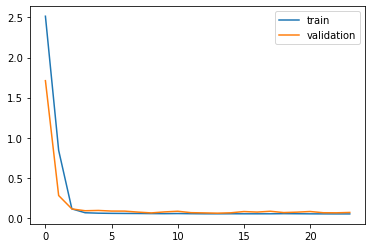


predict: [[33.0010615  21.09461281]]
real:      [[33.2 22.8]]

Train on 1738 samples, validate on 1 samples
Epoch 1/1000
 - 9s - loss: 1.8019 - mean_squared_error: 4.3165 - val_loss: 0.4272 - val_mean_squared_error: 0.2819
Epoch 2/1000
 - 1s - loss: 0.1767 - mean_squared_error: 0.0492 - val_loss: 0.0873 - val_mean_squared_error: 0.0081
Epoch 3/1000
 - 1s - loss: 0.0690 - mean_squared_error: 0.0079 - val_loss: 0.1079 - val_mean_squared_error: 0.0139
Epoch 4/1000
 - 1s - loss: 0.0591 - mean_squared_error: 0.0059 - val_loss: 0.1152 - val_mean_squared_error: 0.0156
Epoch 5/1000
 - 1s - loss: 0.0584 - mean_squared_error: 0.0059 - val_loss: 0.1191 - val_mean_squared_error: 0.0146
Epoch 6/1000
 - 1s - loss: 0.0562 - mean_squared_error: 0.0055 - val_loss: 0.0914 - val_mean_squared_error: 0.0087
Epoch 7/1000
 - 1s - loss: 0.0550 - mean_squared_error: 0.0053 - val_loss: 0.0838 - val_mean_squared_error: 0.0087
Epoch 8/1000
 - 1s - loss: 0.0537 - mean_squared_error: 0.0052 - val_loss: 0.0794 - va

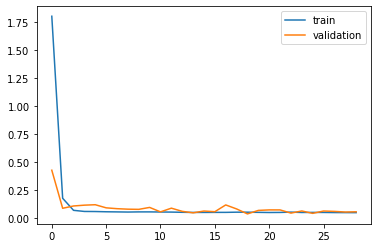


predict: [[33.81227833 22.73512332]]
real:      [[35.4 26.5]]

Train on 1737 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 2.1505 - mean_squared_error: 5.1744 - val_loss: 0.9288 - val_mean_squared_error: 1.6381
Epoch 2/1000
 - 1s - loss: 0.3334 - mean_squared_error: 0.2801 - val_loss: 0.2047 - val_mean_squared_error: 0.0466
Epoch 3/1000
 - 1s - loss: 0.0882 - mean_squared_error: 0.0119 - val_loss: 0.1331 - val_mean_squared_error: 0.0248
Epoch 4/1000
 - 1s - loss: 0.0634 - mean_squared_error: 0.0068 - val_loss: 0.1245 - val_mean_squared_error: 0.0190
Epoch 5/1000
 - 1s - loss: 0.0597 - mean_squared_error: 0.0060 - val_loss: 0.1251 - val_mean_squared_error: 0.0176
Epoch 6/1000
 - 1s - loss: 0.0585 - mean_squared_error: 0.0058 - val_loss: 0.1037 - val_mean_squared_error: 0.0153
Epoch 7/1000
 - 1s - loss: 0.0580 - mean_squared_error: 0.0058 - val_loss: 0.1030 - val_mean_squared_error: 0.0165
Epoch 8/1000
 - 1s - loss: 0.0562 - mean_squared_error: 0.0056 - val_loss: 0.1020 - v

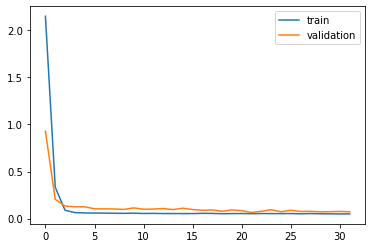


predict: [[34.39077074 23.23544865]]
real:      [[36.6 25.9]]

Train on 1736 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 2.8894 - mean_squared_error: 8.5405 - val_loss: 2.2457 - val_mean_squared_error: 5.0488
Epoch 2/1000
 - 1s - loss: 1.1760 - mean_squared_error: 1.8045 - val_loss: 0.0747 - val_mean_squared_error: 0.0074
Epoch 3/1000
 - 1s - loss: 0.1449 - mean_squared_error: 0.0397 - val_loss: 0.0674 - val_mean_squared_error: 0.0081
Epoch 4/1000
 - 1s - loss: 0.0611 - mean_squared_error: 0.0066 - val_loss: 0.0909 - val_mean_squared_error: 0.0112
Epoch 5/1000
 - 1s - loss: 0.0560 - mean_squared_error: 0.0054 - val_loss: 0.0895 - val_mean_squared_error: 0.0095
Epoch 6/1000
 - 1s - loss: 0.0565 - mean_squared_error: 0.0056 - val_loss: 0.0881 - val_mean_squared_error: 0.0130
Epoch 7/1000
 - 1s - loss: 0.0552 - mean_squared_error: 0.0054 - val_loss: 0.0758 - val_mean_squared_error: 0.0080
Epoch 8/1000
 - 1s - loss: 0.0559 - mean_squared_error: 0.0055 - val_loss: 0.0744 - v

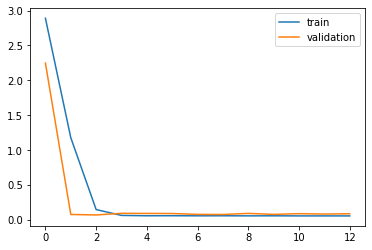


predict: [[35.32899997 22.77306822]]
real:      [[36.2 26.4]]

Train on 1735 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 1.5656 - mean_squared_error: 3.3014 - val_loss: 0.1512 - val_mean_squared_error: 0.0345
Epoch 2/1000
 - 1s - loss: 0.1430 - mean_squared_error: 0.0334 - val_loss: 0.0820 - val_mean_squared_error: 0.0098
Epoch 3/1000
 - 1s - loss: 0.0656 - mean_squared_error: 0.0072 - val_loss: 0.0986 - val_mean_squared_error: 0.0100
Epoch 4/1000
 - 1s - loss: 0.0598 - mean_squared_error: 0.0061 - val_loss: 0.0796 - val_mean_squared_error: 0.0067
Epoch 5/1000
 - 1s - loss: 0.0597 - mean_squared_error: 0.0061 - val_loss: 0.0843 - val_mean_squared_error: 0.0074
Epoch 6/1000
 - 1s - loss: 0.0582 - mean_squared_error: 0.0059 - val_loss: 0.0849 - val_mean_squared_error: 0.0079
Epoch 7/1000
 - 1s - loss: 0.0573 - mean_squared_error: 0.0058 - val_loss: 0.0811 - val_mean_squared_error: 0.0068
Epoch 8/1000
 - 1s - loss: 0.0560 - mean_squared_error: 0.0056 - val_loss: 0.0719 - v

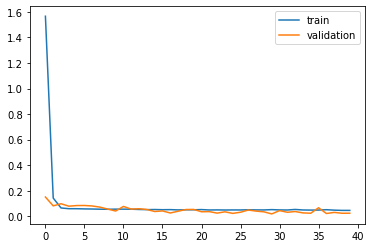


predict: [[32.83106526 21.67407628]]
real:      [[35.8 25.8]]

Train and validation time: 16.09 minutes

Maximum temperatures metrics
Test MEAN-SQUARED-ERROR ------------ 6.235
Test STANDART-DEVIATION ------------ 1.703
Test MEAN-ABSOLUTE-ERROR ----------- 1.827
Test MEDIAN-ABSOLUTE-ERROR --------- 1.462

Errors
2018-12-31 = 0.19604073749096784
2018-12-30 = 1.8459648397846635
2018-12-29 = 0.7341573719823771
2018-12-28 = 0.06282608229597031
2018-12-27 = 1.4602483371251438
2018-12-26 = 1.9191142791871059
2018-12-25 = 4.815539348106672
2018-12-24 = 4.557742781011747
2018-12-23 = 1.9701053090343876
2018-12-22 = 1.1458532003303787
2018-12-21 = 0.7184820183081584
2018-12-20 = 0.9100091732894668
2018-12-19 = 1.6923062391599402
2018-12-18 = 3.311182385175833
2018-12-17 = 6.370659432743221
2018-12-16 = 0.2514412892117761
2018-12-15 = 0.6900792793780184
2018-12-14 = 0.219139335209519
2018-12-13 = 1.1596067218947042
2018-12-12 = 1.6600558369671035
2018-12-11 = 0.9873737836904866
2018-12-10 = 6.6

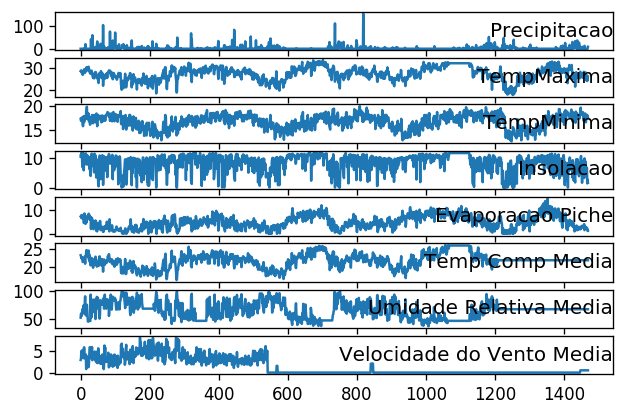

Train on 1409 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 2.1926 - mean_squared_error: 5.1878 - val_loss: 1.2036 - val_mean_squared_error: 1.4496
Epoch 2/1000
 - 0s - loss: 0.5070 - mean_squared_error: 0.3947 - val_loss: 0.2123 - val_mean_squared_error: 0.0529
Epoch 3/1000
 - 0s - loss: 0.1085 - mean_squared_error: 0.0184 - val_loss: 0.0889 - val_mean_squared_error: 0.0154
Epoch 4/1000
 - 0s - loss: 0.0826 - mean_squared_error: 0.0113 - val_loss: 0.0625 - val_mean_squared_error: 0.0062
Epoch 5/1000
 - 0s - loss: 0.0777 - mean_squared_error: 0.0099 - val_loss: 0.0581 - val_mean_squared_error: 0.0059
Epoch 6/1000
 - 0s - loss: 0.0775 - mean_squared_error: 0.0099 - val_loss: 0.0612 - val_mean_squared_error: 0.0065
Epoch 7/1000
 - 0s - loss: 0.0773 - mean_squared_error: 0.0099 - val_loss: 0.0572 - val_mean_squared_error: 0.0051
Epoch 8/1000
 - 0s - loss: 0.0771 - mean_squared_error: 0.0098 - val_loss: 0.0626 - val_mean_squared_error: 0.0071
Epoch 9/1000
 - 0s - loss: 0.0767 

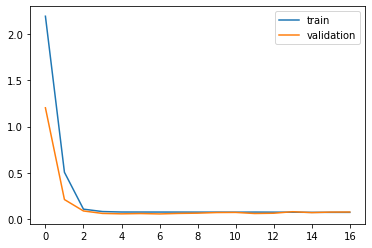


predict: [[26.47186981 16.45198161]]
real:      [[26.2 17.5]]

Train on 1408 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 1.1853 - mean_squared_error: 2.0411 - val_loss: 0.2726 - val_mean_squared_error: 0.0772
Epoch 2/1000
 - 0s - loss: 0.1616 - mean_squared_error: 0.0387 - val_loss: 0.1246 - val_mean_squared_error: 0.0220
Epoch 3/1000
 - 0s - loss: 0.0866 - mean_squared_error: 0.0125 - val_loss: 0.1079 - val_mean_squared_error: 0.0195
Epoch 4/1000
 - 0s - loss: 0.0782 - mean_squared_error: 0.0101 - val_loss: 0.1002 - val_mean_squared_error: 0.0117
Epoch 5/1000
 - 1s - loss: 0.0758 - mean_squared_error: 0.0096 - val_loss: 0.0999 - val_mean_squared_error: 0.0135
Epoch 6/1000
 - 1s - loss: 0.0758 - mean_squared_error: 0.0096 - val_loss: 0.1053 - val_mean_squared_error: 0.0149
Epoch 7/1000
 - 0s - loss: 0.0755 - mean_squared_error: 0.0096 - val_loss: 0.1029 - val_mean_squared_error: 0.0151
Epoch 8/1000
 - 0s - loss: 0.0758 - mean_squared_error: 0.0097 - val_loss: 0.1138 - v

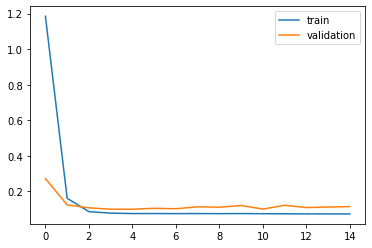


predict: [[26.80074976 15.94445357]]
real:      [[25.2 17.5]]

Train on 1407 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 2.4880 - mean_squared_error: 6.4300 - val_loss: 1.6392 - val_mean_squared_error: 2.7078
Epoch 2/1000
 - 0s - loss: 0.7437 - mean_squared_error: 0.8468 - val_loss: 0.3010 - val_mean_squared_error: 0.1107
Epoch 3/1000
 - 0s - loss: 0.1458 - mean_squared_error: 0.0372 - val_loss: 0.0659 - val_mean_squared_error: 0.0049
Epoch 4/1000
 - 0s - loss: 0.0916 - mean_squared_error: 0.0138 - val_loss: 0.0449 - val_mean_squared_error: 0.0024
Epoch 5/1000
 - 0s - loss: 0.0825 - mean_squared_error: 0.0113 - val_loss: 0.0568 - val_mean_squared_error: 0.0049
Epoch 6/1000
 - 0s - loss: 0.0791 - mean_squared_error: 0.0104 - val_loss: 0.0602 - val_mean_squared_error: 0.0038
Epoch 7/1000
 - 0s - loss: 0.0782 - mean_squared_error: 0.0104 - val_loss: 0.0542 - val_mean_squared_error: 0.0030
Epoch 8/1000
 - 0s - loss: 0.0780 - mean_squared_error: 0.0102 - val_loss: 0.0481 - v

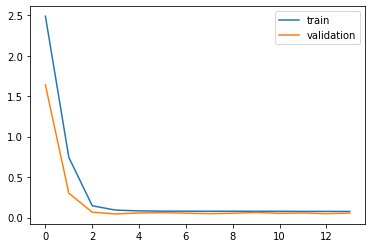


predict: [[27.32507281 17.53904335]]
real:      [[24.2 18.1]]

Train on 1406 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 1.6077 - mean_squared_error: 3.3501 - val_loss: 0.3236 - val_mean_squared_error: 0.1177
Epoch 2/1000
 - 0s - loss: 0.2028 - mean_squared_error: 0.0595 - val_loss: 0.0415 - val_mean_squared_error: 0.0029
Epoch 3/1000
 - 0s - loss: 0.0949 - mean_squared_error: 0.0146 - val_loss: 0.0345 - val_mean_squared_error: 0.0013
Epoch 4/1000
 - 0s - loss: 0.0794 - mean_squared_error: 0.0105 - val_loss: 0.0451 - val_mean_squared_error: 0.0021
Epoch 5/1000
 - 0s - loss: 0.0749 - mean_squared_error: 0.0095 - val_loss: 0.0561 - val_mean_squared_error: 0.0033
Epoch 6/1000
 - 0s - loss: 0.0753 - mean_squared_error: 0.0095 - val_loss: 0.0688 - val_mean_squared_error: 0.0055
Epoch 7/1000
 - 0s - loss: 0.0738 - mean_squared_error: 0.0092 - val_loss: 0.0723 - val_mean_squared_error: 0.0052
Epoch 8/1000
 - 0s - loss: 0.0734 - mean_squared_error: 0.0091 - val_loss: 0.0659 - v

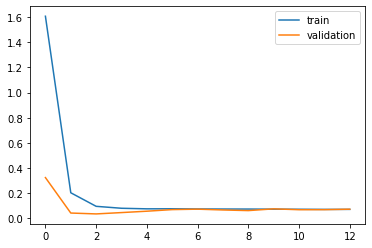


predict: [[26.90344432 17.6201381 ]]
real:      [[26.8 17.4]]

Train on 1405 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 2.0611 - mean_squared_error: 4.8833 - val_loss: 0.9513 - val_mean_squared_error: 1.4718
Epoch 2/1000
 - 0s - loss: 0.6185 - mean_squared_error: 0.6352 - val_loss: 0.2039 - val_mean_squared_error: 0.0428
Epoch 3/1000
 - 0s - loss: 0.1243 - mean_squared_error: 0.0238 - val_loss: 0.1539 - val_mean_squared_error: 0.0348
Epoch 4/1000
 - 0s - loss: 0.0866 - mean_squared_error: 0.0124 - val_loss: 0.0740 - val_mean_squared_error: 0.0089
Epoch 5/1000
 - 0s - loss: 0.0811 - mean_squared_error: 0.0106 - val_loss: 0.0952 - val_mean_squared_error: 0.0162
Epoch 6/1000
 - 0s - loss: 0.0812 - mean_squared_error: 0.0110 - val_loss: 0.0726 - val_mean_squared_error: 0.0091
Epoch 7/1000
 - 0s - loss: 0.0788 - mean_squared_error: 0.0103 - val_loss: 0.0694 - val_mean_squared_error: 0.0068
Epoch 8/1000
 - 0s - loss: 0.0778 - mean_squared_error: 0.0100 - val_loss: 0.0985 - v

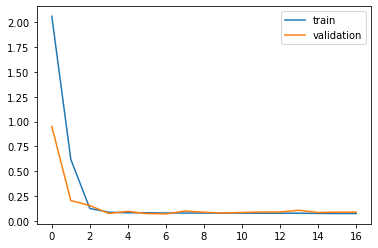


predict: [[26.32277006 16.33397217]]
real:      [[26.2 17.8]]

Train on 1404 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 1.6524 - mean_squared_error: 3.3416 - val_loss: 0.6043 - val_mean_squared_error: 0.3857
Epoch 2/1000
 - 0s - loss: 0.2180 - mean_squared_error: 0.0760 - val_loss: 0.1806 - val_mean_squared_error: 0.0349
Epoch 3/1000
 - 0s - loss: 0.0964 - mean_squared_error: 0.0147 - val_loss: 0.0942 - val_mean_squared_error: 0.0097
Epoch 4/1000
 - 0s - loss: 0.0785 - mean_squared_error: 0.0101 - val_loss: 0.0626 - val_mean_squared_error: 0.0074
Epoch 5/1000
 - 0s - loss: 0.0749 - mean_squared_error: 0.0093 - val_loss: 0.0447 - val_mean_squared_error: 0.0027
Epoch 6/1000
 - 0s - loss: 0.0752 - mean_squared_error: 0.0094 - val_loss: 0.0480 - val_mean_squared_error: 0.0034
Epoch 7/1000
 - 0s - loss: 0.0749 - mean_squared_error: 0.0094 - val_loss: 0.0692 - val_mean_squared_error: 0.0072
Epoch 8/1000
 - 0s - loss: 0.0735 - mean_squared_error: 0.0090 - val_loss: 0.0745 - v

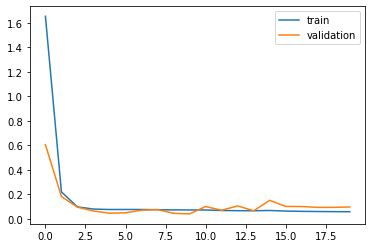


predict: [[27.53119823 16.41144772]]
real:      [[24.5 17.5]]

Train on 1403 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 1.5339 - mean_squared_error: 3.1517 - val_loss: 0.1900 - val_mean_squared_error: 0.0362
Epoch 2/1000
 - 0s - loss: 0.1884 - mean_squared_error: 0.0511 - val_loss: 0.0430 - val_mean_squared_error: 0.0022
Epoch 3/1000
 - 0s - loss: 0.0919 - mean_squared_error: 0.0136 - val_loss: 0.0155 - val_mean_squared_error: 2.5183e-04
Epoch 4/1000
 - 0s - loss: 0.0804 - mean_squared_error: 0.0109 - val_loss: 0.0320 - val_mean_squared_error: 0.0012
Epoch 5/1000
 - 0s - loss: 0.0783 - mean_squared_error: 0.0101 - val_loss: 0.0406 - val_mean_squared_error: 0.0017
Epoch 6/1000
 - 0s - loss: 0.0782 - mean_squared_error: 0.0101 - val_loss: 0.0425 - val_mean_squared_error: 0.0019
Epoch 7/1000
 - 0s - loss: 0.0780 - mean_squared_error: 0.0101 - val_loss: 0.0493 - val_mean_squared_error: 0.0027
Epoch 8/1000
 - 0s - loss: 0.0768 - mean_squared_error: 0.0097 - val_loss: 0.0423

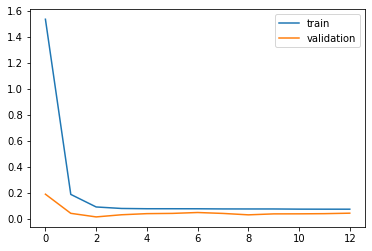


predict: [[26.9260194  17.75361829]]
real:      [[26.3 16.6]]

Train on 1402 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 2.1866 - mean_squared_error: 5.0542 - val_loss: 1.3189 - val_mean_squared_error: 1.7471
Epoch 2/1000
 - 0s - loss: 0.5298 - mean_squared_error: 0.4379 - val_loss: 0.1471 - val_mean_squared_error: 0.0362
Epoch 3/1000
 - 0s - loss: 0.1322 - mean_squared_error: 0.0277 - val_loss: 0.0105 - val_mean_squared_error: 1.1178e-04
Epoch 4/1000
 - 0s - loss: 0.0888 - mean_squared_error: 0.0128 - val_loss: 0.0300 - val_mean_squared_error: 0.0010
Epoch 5/1000
 - 0s - loss: 0.0803 - mean_squared_error: 0.0110 - val_loss: 0.0406 - val_mean_squared_error: 0.0017
Epoch 6/1000
 - 0s - loss: 0.0793 - mean_squared_error: 0.0106 - val_loss: 0.0626 - val_mean_squared_error: 0.0041
Epoch 7/1000
 - 0s - loss: 0.0778 - mean_squared_error: 0.0105 - val_loss: 0.0389 - val_mean_squared_error: 0.0028
Epoch 8/1000
 - 0s - loss: 0.0771 - mean_squared_error: 0.0102 - val_loss: 0.0359

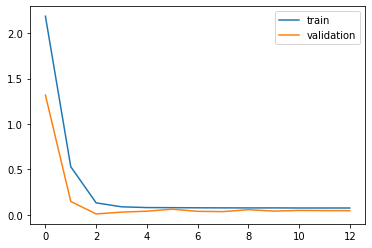


predict: [[26.39776067 17.47236771]]
real:      [[28.1 18.3]]

Train on 1401 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 2.4887 - mean_squared_error: 6.3919 - val_loss: 1.7397 - val_mean_squared_error: 3.0296
Epoch 2/1000
 - 0s - loss: 0.9286 - mean_squared_error: 1.1280 - val_loss: 0.2097 - val_mean_squared_error: 0.0541
Epoch 3/1000
 - 0s - loss: 0.1601 - mean_squared_error: 0.0370 - val_loss: 0.0833 - val_mean_squared_error: 0.0128
Epoch 4/1000
 - 0s - loss: 0.0893 - mean_squared_error: 0.0131 - val_loss: 0.0341 - val_mean_squared_error: 0.0021
Epoch 5/1000
 - 0s - loss: 0.0783 - mean_squared_error: 0.0101 - val_loss: 0.0185 - val_mean_squared_error: 5.5776e-04
Epoch 6/1000
 - 0s - loss: 0.0783 - mean_squared_error: 0.0102 - val_loss: 0.0291 - val_mean_squared_error: 9.1224e-04
Epoch 7/1000
 - 0s - loss: 0.0765 - mean_squared_error: 0.0097 - val_loss: 0.0300 - val_mean_squared_error: 0.0012
Epoch 8/1000
 - 0s - loss: 0.0763 - mean_squared_error: 0.0096 - val_loss: 0.

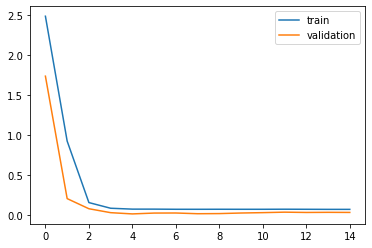


predict: [[27.5209353  16.93962592]]
real:      [[28.1 18.4]]

Train on 1400 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 1.8095 - mean_squared_error: 4.2881 - val_loss: 0.8865 - val_mean_squared_error: 1.1157
Epoch 2/1000
 - 0s - loss: 0.3526 - mean_squared_error: 0.2632 - val_loss: 0.1258 - val_mean_squared_error: 0.0205
Epoch 3/1000
 - 0s - loss: 0.1032 - mean_squared_error: 0.0170 - val_loss: 0.0771 - val_mean_squared_error: 0.0062
Epoch 4/1000
 - 0s - loss: 0.0831 - mean_squared_error: 0.0111 - val_loss: 0.0291 - val_mean_squared_error: 8.9237e-04
Epoch 5/1000
 - 0s - loss: 0.0787 - mean_squared_error: 0.0100 - val_loss: 0.0349 - val_mean_squared_error: 0.0017
Epoch 6/1000
 - 0s - loss: 0.0769 - mean_squared_error: 0.0095 - val_loss: 0.0631 - val_mean_squared_error: 0.0043
Epoch 7/1000
 - 0s - loss: 0.0755 - mean_squared_error: 0.0094 - val_loss: 0.0508 - val_mean_squared_error: 0.0026
Epoch 8/1000
 - 0s - loss: 0.0742 - mean_squared_error: 0.0092 - val_loss: 0.0644

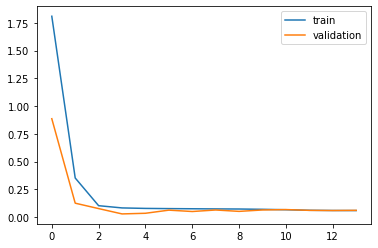


predict: [[30.31878008 16.8637947 ]]
real:      [[28.  18.1]]

Train on 1399 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 2.3787 - mean_squared_error: 6.3163 - val_loss: 1.0116 - val_mean_squared_error: 1.5873
Epoch 2/1000
 - 0s - loss: 0.4753 - mean_squared_error: 0.4667 - val_loss: 0.2162 - val_mean_squared_error: 0.0690
Epoch 3/1000
 - 0s - loss: 0.1314 - mean_squared_error: 0.0303 - val_loss: 0.0364 - val_mean_squared_error: 0.0022
Epoch 4/1000
 - 0s - loss: 0.0901 - mean_squared_error: 0.0136 - val_loss: 0.0387 - val_mean_squared_error: 0.0015
Epoch 5/1000
 - 0s - loss: 0.0818 - mean_squared_error: 0.0110 - val_loss: 0.0402 - val_mean_squared_error: 0.0017
Epoch 6/1000
 - 0s - loss: 0.0784 - mean_squared_error: 0.0103 - val_loss: 0.0542 - val_mean_squared_error: 0.0036
Epoch 7/1000
 - 0s - loss: 0.0783 - mean_squared_error: 0.0101 - val_loss: 0.0188 - val_mean_squared_error: 3.8200e-04
Epoch 8/1000
 - 0s - loss: 0.0771 - mean_squared_error: 0.0099 - val_loss: 0.0535

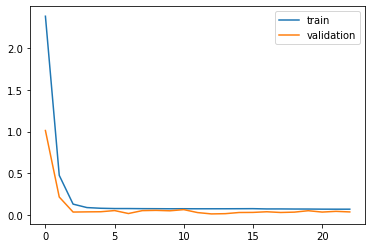


predict: [[27.10382117 17.54610794]]
real:      [[27.2 18.3]]

Train on 1398 samples, validate on 1 samples
Epoch 1/1000
 - 10s - loss: 2.9210 - mean_squared_error: 8.6770 - val_loss: 2.5363 - val_mean_squared_error: 6.7086
Epoch 2/1000
 - 0s - loss: 2.1363 - mean_squared_error: 6.0517 - val_loss: 1.8525 - val_mean_squared_error: 6.1243
Epoch 3/1000
 - 0s - loss: 1.6981 - mean_squared_error: 5.3256 - val_loss: 1.5778 - val_mean_squared_error: 4.8460
Epoch 4/1000
 - 0s - loss: 1.5089 - mean_squared_error: 4.2957 - val_loss: 1.3917 - val_mean_squared_error: 3.8246
Epoch 5/1000
 - 0s - loss: 1.3660 - mean_squared_error: 3.4979 - val_loss: 1.2931 - val_mean_squared_error: 3.2795
Epoch 6/1000
 - 0s - loss: 1.2766 - mean_squared_error: 3.0504 - val_loss: 1.1952 - val_mean_squared_error: 2.8514
Epoch 7/1000
 - 0s - loss: 1.1914 - mean_squared_error: 2.6454 - val_loss: 1.1134 - val_mean_squared_error: 2.4567
Epoch 8/1000
 - 0s - loss: 1.1065 - mean_squared_error: 2.2662 - val_loss: 1.0403 - v

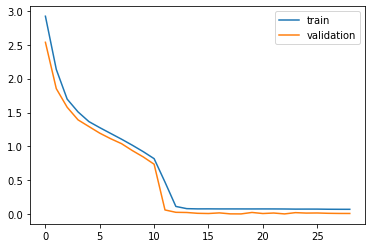


predict: [[27.27306676 16.63632658]]
real:      [[28.  18.1]]

Train on 1397 samples, validate on 1 samples
Epoch 1/1000
 - 11s - loss: 1.9353 - mean_squared_error: 4.0564 - val_loss: 0.8493 - val_mean_squared_error: 0.8324
Epoch 2/1000
 - 0s - loss: 0.3313 - mean_squared_error: 0.1943 - val_loss: 0.0652 - val_mean_squared_error: 0.0048
Epoch 3/1000
 - 0s - loss: 0.1037 - mean_squared_error: 0.0166 - val_loss: 0.0614 - val_mean_squared_error: 0.0065
Epoch 4/1000
 - 0s - loss: 0.0809 - mean_squared_error: 0.0108 - val_loss: 0.0808 - val_mean_squared_error: 0.0067
Epoch 5/1000
 - 0s - loss: 0.0764 - mean_squared_error: 0.0098 - val_loss: 0.0798 - val_mean_squared_error: 0.0064
Epoch 6/1000
 - 0s - loss: 0.0753 - mean_squared_error: 0.0096 - val_loss: 0.0732 - val_mean_squared_error: 0.0057
Epoch 7/1000
 - 0s - loss: 0.0751 - mean_squared_error: 0.0098 - val_loss: 0.0736 - val_mean_squared_error: 0.0055
Epoch 8/1000
 - 0s - loss: 0.0758 - mean_squared_error: 0.0098 - val_loss: 0.0823 - v

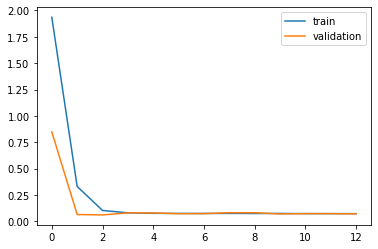


predict: [[28.91411522 16.82266552]]
real:      [[28.4 16.9]]

Train on 1396 samples, validate on 1 samples
Epoch 1/1000
 - 11s - loss: 2.4043 - mean_squared_error: 6.4224 - val_loss: 1.5423 - val_mean_squared_error: 4.1042
Epoch 2/1000
 - 0s - loss: 1.2233 - mean_squared_error: 2.6814 - val_loss: 0.9450 - val_mean_squared_error: 1.5991
Epoch 3/1000
 - 0s - loss: 0.5905 - mean_squared_error: 0.6652 - val_loss: 0.2456 - val_mean_squared_error: 0.1069
Epoch 4/1000
 - 0s - loss: 0.1207 - mean_squared_error: 0.0245 - val_loss: 0.1336 - val_mean_squared_error: 0.0179
Epoch 5/1000
 - 0s - loss: 0.0846 - mean_squared_error: 0.0117 - val_loss: 0.0319 - val_mean_squared_error: 0.0017
Epoch 6/1000
 - 0s - loss: 0.0775 - mean_squared_error: 0.0099 - val_loss: 0.0609 - val_mean_squared_error: 0.0038
Epoch 7/1000
 - 0s - loss: 0.0753 - mean_squared_error: 0.0095 - val_loss: 0.0593 - val_mean_squared_error: 0.0037
Epoch 8/1000
 - 0s - loss: 0.0747 - mean_squared_error: 0.0094 - val_loss: 0.0523 - v

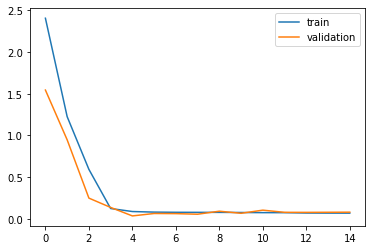


predict: [[26.57283016 16.97418424]]
real:      [[27.1 18.1]]

Train on 1395 samples, validate on 1 samples
Epoch 1/1000
 - 11s - loss: 1.8361 - mean_squared_error: 4.1145 - val_loss: 0.7746 - val_mean_squared_error: 0.8792
Epoch 2/1000
 - 0s - loss: 0.3889 - mean_squared_error: 0.2864 - val_loss: 0.2569 - val_mean_squared_error: 0.0869
Epoch 3/1000
 - 0s - loss: 0.1032 - mean_squared_error: 0.0181 - val_loss: 0.1466 - val_mean_squared_error: 0.0224
Epoch 4/1000
 - 0s - loss: 0.0790 - mean_squared_error: 0.0106 - val_loss: 0.1131 - val_mean_squared_error: 0.0131
Epoch 5/1000
 - 0s - loss: 0.0764 - mean_squared_error: 0.0097 - val_loss: 0.1169 - val_mean_squared_error: 0.0143
Epoch 6/1000
 - 0s - loss: 0.0754 - mean_squared_error: 0.0097 - val_loss: 0.1067 - val_mean_squared_error: 0.0118
Epoch 7/1000
 - 0s - loss: 0.0748 - mean_squared_error: 0.0093 - val_loss: 0.0984 - val_mean_squared_error: 0.0098
Epoch 8/1000
 - 0s - loss: 0.0742 - mean_squared_error: 0.0094 - val_loss: 0.1148 - v

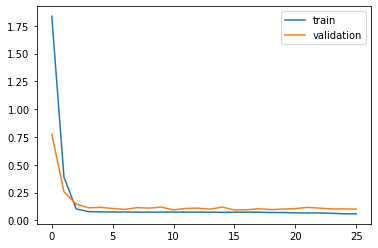


predict: [[28.62437459 17.47147369]]
real:      [[27.6 18.4]]

Train on 1394 samples, validate on 1 samples
Epoch 1/1000
 - 11s - loss: 2.8846 - mean_squared_error: 8.6568 - val_loss: 2.5085 - val_mean_squared_error: 6.8471
Epoch 2/1000
 - 0s - loss: 2.0286 - mean_squared_error: 5.4478 - val_loss: 1.3317 - val_mean_squared_error: 3.4259
Epoch 3/1000
 - 0s - loss: 0.6671 - mean_squared_error: 1.1193 - val_loss: 0.1528 - val_mean_squared_error: 0.0424
Epoch 4/1000
 - 0s - loss: 0.1293 - mean_squared_error: 0.0275 - val_loss: 0.0455 - val_mean_squared_error: 0.0039
Epoch 5/1000
 - 0s - loss: 0.0821 - mean_squared_error: 0.0110 - val_loss: 0.0623 - val_mean_squared_error: 0.0050
Epoch 6/1000
 - 0s - loss: 0.0791 - mean_squared_error: 0.0104 - val_loss: 0.0338 - val_mean_squared_error: 0.0017
Epoch 7/1000
 - 0s - loss: 0.0785 - mean_squared_error: 0.0101 - val_loss: 0.0719 - val_mean_squared_error: 0.0059
Epoch 8/1000
 - 0s - loss: 0.0771 - mean_squared_error: 0.0099 - val_loss: 0.0663 - v

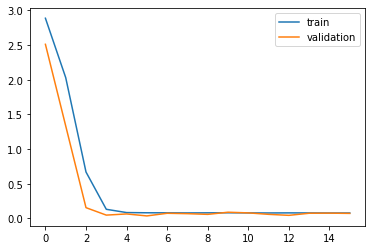


predict: [[27.02429877 17.26096724]]
real:      [[25.7 18.7]]

Train on 1393 samples, validate on 1 samples
Epoch 1/1000
 - 11s - loss: 2.8360 - mean_squared_error: 8.2452 - val_loss: 2.1304 - val_mean_squared_error: 4.5978
Epoch 2/1000
 - 0s - loss: 1.2353 - mean_squared_error: 1.9414 - val_loss: 0.2875 - val_mean_squared_error: 0.0828
Epoch 3/1000
 - 0s - loss: 0.1705 - mean_squared_error: 0.0462 - val_loss: 0.1284 - val_mean_squared_error: 0.0294
Epoch 4/1000
 - 0s - loss: 0.0916 - mean_squared_error: 0.0136 - val_loss: 0.0914 - val_mean_squared_error: 0.0087
Epoch 5/1000
 - 0s - loss: 0.0799 - mean_squared_error: 0.0107 - val_loss: 0.0982 - val_mean_squared_error: 0.0097
Epoch 6/1000
 - 0s - loss: 0.0787 - mean_squared_error: 0.0102 - val_loss: 0.0882 - val_mean_squared_error: 0.0079
Epoch 7/1000
 - 0s - loss: 0.0768 - mean_squared_error: 0.0098 - val_loss: 0.1008 - val_mean_squared_error: 0.0102
Epoch 8/1000
 - 0s - loss: 0.0768 - mean_squared_error: 0.0098 - val_loss: 0.0811 - v

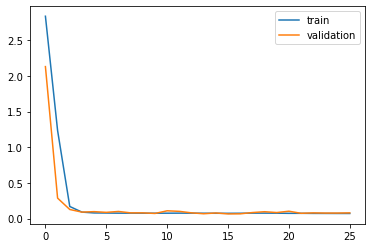


predict: [[27.90105935 17.30545576]]
real:      [[26.6 18.3]]

Train on 1392 samples, validate on 1 samples
Epoch 1/1000
 - 11s - loss: 1.3883 - mean_squared_error: 2.6416 - val_loss: 0.0680 - val_mean_squared_error: 0.0050
Epoch 2/1000
 - 0s - loss: 0.1969 - mean_squared_error: 0.0565 - val_loss: 0.0920 - val_mean_squared_error: 0.0103
Epoch 3/1000
 - 0s - loss: 0.0935 - mean_squared_error: 0.0139 - val_loss: 0.0628 - val_mean_squared_error: 0.0044
Epoch 4/1000
 - 0s - loss: 0.0814 - mean_squared_error: 0.0110 - val_loss: 0.0796 - val_mean_squared_error: 0.0071
Epoch 5/1000
 - 0s - loss: 0.0776 - mean_squared_error: 0.0099 - val_loss: 0.0853 - val_mean_squared_error: 0.0082
Epoch 6/1000
 - 0s - loss: 0.0768 - mean_squared_error: 0.0099 - val_loss: 0.0969 - val_mean_squared_error: 0.0095
Epoch 7/1000
 - 0s - loss: 0.0759 - mean_squared_error: 0.0097 - val_loss: 0.0784 - val_mean_squared_error: 0.0064
Epoch 8/1000
 - 0s - loss: 0.0754 - mean_squared_error: 0.0094 - val_loss: 0.0907 - v

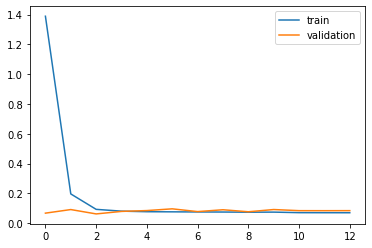


predict: [[27.21602286 17.41698057]]
real:      [[26.3 18.1]]

Train on 1391 samples, validate on 1 samples
Epoch 1/1000
 - 11s - loss: 2.3270 - mean_squared_error: 6.0740 - val_loss: 0.9278 - val_mean_squared_error: 1.1096
Epoch 2/1000
 - 0s - loss: 0.3638 - mean_squared_error: 0.2763 - val_loss: 0.2254 - val_mean_squared_error: 0.0557
Epoch 3/1000
 - 0s - loss: 0.1110 - mean_squared_error: 0.0195 - val_loss: 0.0981 - val_mean_squared_error: 0.0126
Epoch 4/1000
 - 0s - loss: 0.0851 - mean_squared_error: 0.0118 - val_loss: 0.0810 - val_mean_squared_error: 0.0066
Epoch 5/1000
 - 0s - loss: 0.0789 - mean_squared_error: 0.0107 - val_loss: 0.0825 - val_mean_squared_error: 0.0068
Epoch 6/1000
 - 0s - loss: 0.0768 - mean_squared_error: 0.0099 - val_loss: 0.0909 - val_mean_squared_error: 0.0083
Epoch 7/1000
 - 0s - loss: 0.0764 - mean_squared_error: 0.0100 - val_loss: 0.0798 - val_mean_squared_error: 0.0064
Epoch 8/1000
 - 0s - loss: 0.0773 - mean_squared_error: 0.0101 - val_loss: 0.0811 - v

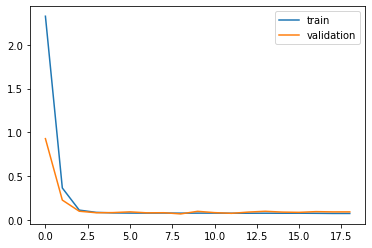


predict: [[27.2206112  16.92684183]]
real:      [[26.1 18.6]]

Train on 1390 samples, validate on 1 samples
Epoch 1/1000
 - 11s - loss: 0.9388 - mean_squared_error: 1.4330 - val_loss: 0.3230 - val_mean_squared_error: 0.1044
Epoch 2/1000
 - 0s - loss: 0.1495 - mean_squared_error: 0.0345 - val_loss: 0.0655 - val_mean_squared_error: 0.0080
Epoch 3/1000
 - 0s - loss: 0.0898 - mean_squared_error: 0.0134 - val_loss: 0.0805 - val_mean_squared_error: 0.0071
Epoch 4/1000
 - 0s - loss: 0.0780 - mean_squared_error: 0.0102 - val_loss: 0.0810 - val_mean_squared_error: 0.0071
Epoch 5/1000
 - 0s - loss: 0.0773 - mean_squared_error: 0.0100 - val_loss: 0.0638 - val_mean_squared_error: 0.0043
Epoch 6/1000
 - 0s - loss: 0.0765 - mean_squared_error: 0.0099 - val_loss: 0.0574 - val_mean_squared_error: 0.0040
Epoch 7/1000
 - 0s - loss: 0.0755 - mean_squared_error: 0.0096 - val_loss: 0.0867 - val_mean_squared_error: 0.0075
Epoch 8/1000
 - 0s - loss: 0.0747 - mean_squared_error: 0.0095 - val_loss: 0.0758 - v

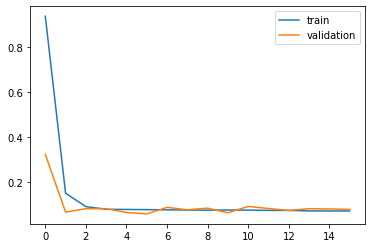


predict: [[26.57064115 16.43433178]]
real:      [[26.  18.7]]

Train on 1389 samples, validate on 1 samples
Epoch 1/1000
 - 11s - loss: 2.4768 - mean_squared_error: 7.3103 - val_loss: 1.8405 - val_mean_squared_error: 5.9258
Epoch 2/1000
 - 0s - loss: 1.5680 - mean_squared_error: 4.5851 - val_loss: 1.2221 - val_mean_squared_error: 2.8353
Epoch 3/1000
 - 0s - loss: 0.8571 - mean_squared_error: 1.4719 - val_loss: 0.3398 - val_mean_squared_error: 0.1573
Epoch 4/1000
 - 0s - loss: 0.1490 - mean_squared_error: 0.0432 - val_loss: 0.1058 - val_mean_squared_error: 0.0149
Epoch 5/1000
 - 0s - loss: 0.0858 - mean_squared_error: 0.0120 - val_loss: 0.0947 - val_mean_squared_error: 0.0129
Epoch 6/1000
 - 0s - loss: 0.0763 - mean_squared_error: 0.0100 - val_loss: 0.0967 - val_mean_squared_error: 0.0127
Epoch 7/1000
 - 0s - loss: 0.0759 - mean_squared_error: 0.0098 - val_loss: 0.0643 - val_mean_squared_error: 0.0055
Epoch 8/1000
 - 0s - loss: 0.0754 - mean_squared_error: 0.0097 - val_loss: 0.0947 - v

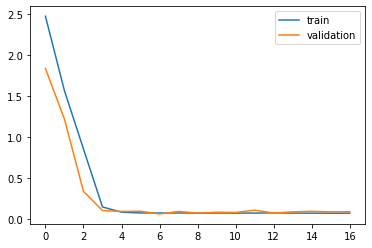


predict: [[27.3089777  18.01200278]]
real:      [[27.  18.6]]

Train on 1388 samples, validate on 1 samples
Epoch 1/1000
 - 11s - loss: 1.7068 - mean_squared_error: 3.8458 - val_loss: 0.9504 - val_mean_squared_error: 1.2999
Epoch 2/1000
 - 0s - loss: 0.6435 - mean_squared_error: 0.7045 - val_loss: 0.3209 - val_mean_squared_error: 0.1802
Epoch 3/1000
 - 0s - loss: 0.1638 - mean_squared_error: 0.0523 - val_loss: 0.0792 - val_mean_squared_error: 0.0068
Epoch 4/1000
 - 0s - loss: 0.0842 - mean_squared_error: 0.0117 - val_loss: 0.0413 - val_mean_squared_error: 0.0031
Epoch 5/1000
 - 0s - loss: 0.0787 - mean_squared_error: 0.0101 - val_loss: 0.0468 - val_mean_squared_error: 0.0037
Epoch 6/1000
 - 0s - loss: 0.0762 - mean_squared_error: 0.0097 - val_loss: 0.0479 - val_mean_squared_error: 0.0044
Epoch 7/1000
 - 0s - loss: 0.0759 - mean_squared_error: 0.0094 - val_loss: 0.0357 - val_mean_squared_error: 0.0025
Epoch 8/1000
 - 0s - loss: 0.0755 - mean_squared_error: 0.0096 - val_loss: 0.0296 - v

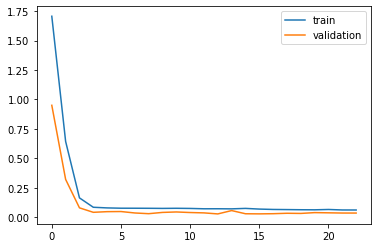


predict: [[27.33233345 16.51981472]]
real:      [[27.2 19.6]]

Train on 1387 samples, validate on 1 samples
Epoch 1/1000
 - 11s - loss: 1.9845 - mean_squared_error: 4.2449 - val_loss: 0.9866 - val_mean_squared_error: 0.9745
Epoch 2/1000
 - 0s - loss: 0.3763 - mean_squared_error: 0.2196 - val_loss: 0.1374 - val_mean_squared_error: 0.0194
Epoch 3/1000
 - 0s - loss: 0.1026 - mean_squared_error: 0.0165 - val_loss: 0.1181 - val_mean_squared_error: 0.0140
Epoch 4/1000
 - 0s - loss: 0.0795 - mean_squared_error: 0.0104 - val_loss: 0.0914 - val_mean_squared_error: 0.0086
Epoch 5/1000
 - 0s - loss: 0.0767 - mean_squared_error: 0.0098 - val_loss: 0.0769 - val_mean_squared_error: 0.0059
Epoch 6/1000
 - 0s - loss: 0.0756 - mean_squared_error: 0.0096 - val_loss: 0.0873 - val_mean_squared_error: 0.0076
Epoch 7/1000
 - 0s - loss: 0.0753 - mean_squared_error: 0.0096 - val_loss: 0.0878 - val_mean_squared_error: 0.0078
Epoch 8/1000
 - 0s - loss: 0.0758 - mean_squared_error: 0.0096 - val_loss: 0.0917 - v

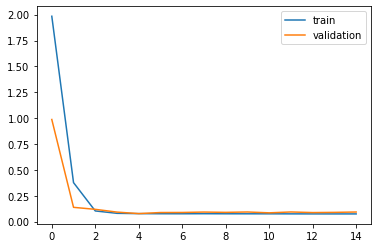


predict: [[26.79558686 16.29862374]]
real:      [[28.4 18.3]]

Train on 1386 samples, validate on 1 samples
Epoch 1/1000
 - 11s - loss: 1.4035 - mean_squared_error: 2.7817 - val_loss: 0.1681 - val_mean_squared_error: 0.0385
Epoch 2/1000
 - 0s - loss: 0.1476 - mean_squared_error: 0.0331 - val_loss: 0.0196 - val_mean_squared_error: 4.0182e-04
Epoch 3/1000
 - 0s - loss: 0.0874 - mean_squared_error: 0.0123 - val_loss: 0.0659 - val_mean_squared_error: 0.0056
Epoch 4/1000
 - 0s - loss: 0.0774 - mean_squared_error: 0.0099 - val_loss: 0.0774 - val_mean_squared_error: 0.0094
Epoch 5/1000
 - 0s - loss: 0.0747 - mean_squared_error: 0.0093 - val_loss: 0.0852 - val_mean_squared_error: 0.0095
Epoch 6/1000
 - 0s - loss: 0.0739 - mean_squared_error: 0.0092 - val_loss: 0.0815 - val_mean_squared_error: 0.0083
Epoch 7/1000
 - 0s - loss: 0.0733 - mean_squared_error: 0.0090 - val_loss: 0.0769 - val_mean_squared_error: 0.0104
Epoch 8/1000
 - 0s - loss: 0.0729 - mean_squared_error: 0.0090 - val_loss: 0.0822

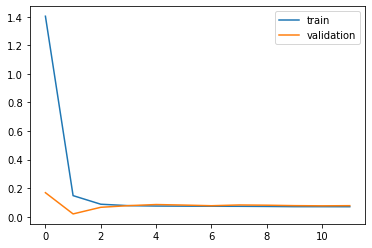


predict: [[23.08676022 18.10908433]]
real:      [[26.  18.5]]

Train on 1385 samples, validate on 1 samples
Epoch 1/1000
 - 11s - loss: 2.2760 - mean_squared_error: 5.5688 - val_loss: 1.5045 - val_mean_squared_error: 2.4823
Epoch 2/1000
 - 0s - loss: 0.8674 - mean_squared_error: 1.1815 - val_loss: 0.0963 - val_mean_squared_error: 0.0110
Epoch 3/1000
 - 0s - loss: 0.1332 - mean_squared_error: 0.0292 - val_loss: 0.0716 - val_mean_squared_error: 0.0084
Epoch 4/1000
 - 0s - loss: 0.0850 - mean_squared_error: 0.0119 - val_loss: 0.0639 - val_mean_squared_error: 0.0042
Epoch 5/1000
 - 0s - loss: 0.0773 - mean_squared_error: 0.0100 - val_loss: 0.0618 - val_mean_squared_error: 0.0046
Epoch 6/1000
 - 0s - loss: 0.0758 - mean_squared_error: 0.0097 - val_loss: 0.0643 - val_mean_squared_error: 0.0054
Epoch 7/1000
 - 0s - loss: 0.0756 - mean_squared_error: 0.0095 - val_loss: 0.0602 - val_mean_squared_error: 0.0053
Epoch 8/1000
 - 0s - loss: 0.0755 - mean_squared_error: 0.0096 - val_loss: 0.0538 - v

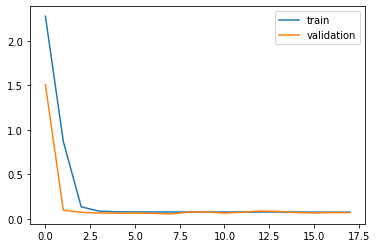


predict: [[27.30405782 17.08809768]]
real:      [[25.4 17.4]]

Train on 1384 samples, validate on 1 samples
Epoch 1/1000
 - 12s - loss: 2.5763 - mean_squared_error: 7.1050 - val_loss: 2.0160 - val_mean_squared_error: 4.7174
Epoch 2/1000
 - 0s - loss: 1.4878 - mean_squared_error: 3.3846 - val_loss: 0.9244 - val_mean_squared_error: 1.7006
Epoch 3/1000
 - 0s - loss: 0.6694 - mean_squared_error: 0.8762 - val_loss: 0.1686 - val_mean_squared_error: 0.0294
Epoch 4/1000
 - 0s - loss: 0.1256 - mean_squared_error: 0.0257 - val_loss: 0.0567 - val_mean_squared_error: 0.0064
Epoch 5/1000
 - 0s - loss: 0.0878 - mean_squared_error: 0.0127 - val_loss: 0.0931 - val_mean_squared_error: 0.0098
Epoch 6/1000
 - 0s - loss: 0.0784 - mean_squared_error: 0.0102 - val_loss: 0.1000 - val_mean_squared_error: 0.0109
Epoch 7/1000
 - 0s - loss: 0.0778 - mean_squared_error: 0.0100 - val_loss: 0.1002 - val_mean_squared_error: 0.0109
Epoch 8/1000
 - 0s - loss: 0.0776 - mean_squared_error: 0.0100 - val_loss: 0.0988 - v

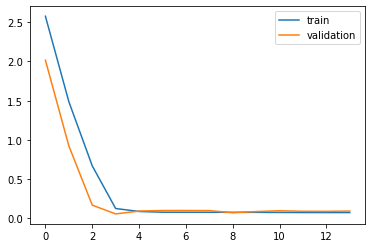


predict: [[24.15317595 15.90123367]]
real:      [[25.5 17.4]]

Train on 1383 samples, validate on 1 samples
Epoch 1/1000
 - 12s - loss: 1.5511 - mean_squared_error: 3.0043 - val_loss: 0.1264 - val_mean_squared_error: 0.0309
Epoch 2/1000
 - 0s - loss: 0.1773 - mean_squared_error: 0.0458 - val_loss: 0.0533 - val_mean_squared_error: 0.0029
Epoch 3/1000
 - 0s - loss: 0.0900 - mean_squared_error: 0.0134 - val_loss: 0.0352 - val_mean_squared_error: 0.0012
Epoch 4/1000
 - 0s - loss: 0.0766 - mean_squared_error: 0.0100 - val_loss: 0.0582 - val_mean_squared_error: 0.0034
Epoch 5/1000
 - 0s - loss: 0.0742 - mean_squared_error: 0.0093 - val_loss: 0.0613 - val_mean_squared_error: 0.0051
Epoch 6/1000
 - 0s - loss: 0.0759 - mean_squared_error: 0.0098 - val_loss: 0.0727 - val_mean_squared_error: 0.0059
Epoch 7/1000
 - 0s - loss: 0.0737 - mean_squared_error: 0.0091 - val_loss: 0.0656 - val_mean_squared_error: 0.0044
Epoch 8/1000
 - 0s - loss: 0.0731 - mean_squared_error: 0.0092 - val_loss: 0.0653 - v

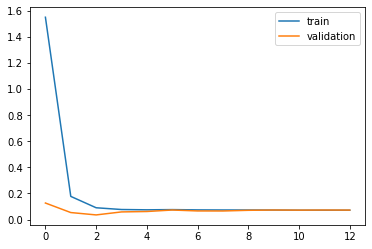


predict: [[26.63106379 16.93711542]]
real:      [[25.5 18.1]]

Train on 1382 samples, validate on 1 samples
Epoch 1/1000
 - 12s - loss: 2.0159 - mean_squared_error: 4.6029 - val_loss: 0.6437 - val_mean_squared_error: 0.4249
Epoch 2/1000
 - 0s - loss: 0.2528 - mean_squared_error: 0.0998 - val_loss: 0.0718 - val_mean_squared_error: 0.0089
Epoch 3/1000
 - 0s - loss: 0.1000 - mean_squared_error: 0.0161 - val_loss: 0.0804 - val_mean_squared_error: 0.0065
Epoch 4/1000
 - 0s - loss: 0.0812 - mean_squared_error: 0.0108 - val_loss: 0.0632 - val_mean_squared_error: 0.0048
Epoch 5/1000
 - 0s - loss: 0.0792 - mean_squared_error: 0.0103 - val_loss: 0.0511 - val_mean_squared_error: 0.0035
Epoch 6/1000
 - 0s - loss: 0.0787 - mean_squared_error: 0.0104 - val_loss: 0.0570 - val_mean_squared_error: 0.0042
Epoch 7/1000
 - 0s - loss: 0.0777 - mean_squared_error: 0.0100 - val_loss: 0.0660 - val_mean_squared_error: 0.0046
Epoch 8/1000
 - 0s - loss: 0.0775 - mean_squared_error: 0.0100 - val_loss: 0.0583 - v

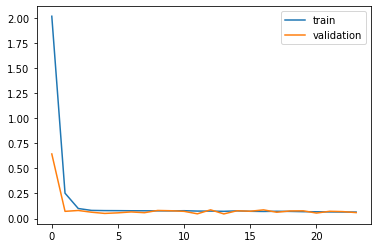


predict: [[27.00419463 18.07945713]]
real:      [[26.8 18.1]]

Train on 1381 samples, validate on 1 samples
Epoch 1/1000
 - 12s - loss: 2.0509 - mean_squared_error: 4.7077 - val_loss: 0.7126 - val_mean_squared_error: 0.6966
Epoch 2/1000
 - 0s - loss: 0.3037 - mean_squared_error: 0.1557 - val_loss: 0.0460 - val_mean_squared_error: 0.0028
Epoch 3/1000
 - 0s - loss: 0.1039 - mean_squared_error: 0.0167 - val_loss: 0.0663 - val_mean_squared_error: 0.0044
Epoch 4/1000
 - 0s - loss: 0.0829 - mean_squared_error: 0.0113 - val_loss: 0.0798 - val_mean_squared_error: 0.0090
Epoch 5/1000
 - 0s - loss: 0.0776 - mean_squared_error: 0.0100 - val_loss: 0.0563 - val_mean_squared_error: 0.0054
Epoch 6/1000
 - 0s - loss: 0.0757 - mean_squared_error: 0.0096 - val_loss: 0.0413 - val_mean_squared_error: 0.0033
Epoch 7/1000
 - 0s - loss: 0.0763 - mean_squared_error: 0.0097 - val_loss: 0.0514 - val_mean_squared_error: 0.0039
Epoch 8/1000
 - 0s - loss: 0.0740 - mean_squared_error: 0.0093 - val_loss: 0.0637 - v

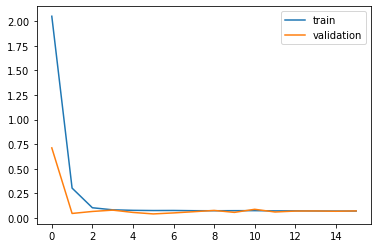


predict: [[27.07248714 16.57950596]]
real:      [[25.8 17.7]]

Train on 1380 samples, validate on 1 samples
Epoch 1/1000
 - 12s - loss: 1.8742 - mean_squared_error: 4.0974 - val_loss: 0.5270 - val_mean_squared_error: 0.3906
Epoch 2/1000
 - 0s - loss: 0.3104 - mean_squared_error: 0.1521 - val_loss: 0.1023 - val_mean_squared_error: 0.0106
Epoch 3/1000
 - 0s - loss: 0.1118 - mean_squared_error: 0.0199 - val_loss: 0.0536 - val_mean_squared_error: 0.0034
Epoch 4/1000
 - 0s - loss: 0.0824 - mean_squared_error: 0.0112 - val_loss: 0.0639 - val_mean_squared_error: 0.0041
Epoch 5/1000
 - 0s - loss: 0.0768 - mean_squared_error: 0.0101 - val_loss: 0.0335 - val_mean_squared_error: 0.0018
Epoch 6/1000
 - 0s - loss: 0.0762 - mean_squared_error: 0.0100 - val_loss: 0.0347 - val_mean_squared_error: 0.0015
Epoch 7/1000
 - 0s - loss: 0.0752 - mean_squared_error: 0.0095 - val_loss: 0.0423 - val_mean_squared_error: 0.0018
Epoch 8/1000
 - 0s - loss: 0.0743 - mean_squared_error: 0.0095 - val_loss: 0.0419 - v

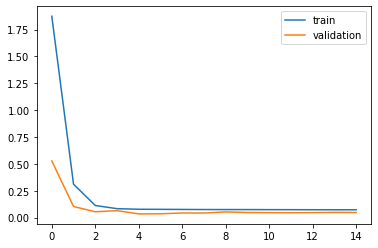


predict: [[28.03999564 17.6192902 ]]
real:      [[26.  17.3]]

Train and validation time: 17.12 minutes

Maximum temperatures metrics
Test MEAN-SQUARED-ERROR ------------ 2.078
Test STANDART-DEVIATION ------------ 0.8707
Test MEAN-ABSOLUTE-ERROR ----------- 1.149
Test MEDIAN-ABSOLUTE-ERROR --------- 1.072

Errors
2018-03-31 = 0.27186981259394116
2018-03-30 = 1.6007497619881086
2018-03-29 = 3.1250728089837665
2018-03-28 = 0.10344431935674336
2018-03-27 = 0.12277006173505711
2018-03-26 = 3.0311982280403065
2018-03-25 = 0.6260194034024451
2018-03-24 = 1.7022393286793083
2018-03-23 = 0.5790646986058476
2018-03-22 = 2.3187800840993624
2018-03-21 = 0.09617882667609834
2018-03-20 = 0.7269332374351407
2018-03-19 = 0.5141152235907711
2018-03-14 = 0.5271698368787412
2018-03-13 = 1.0243745916867795
2018-03-12 = 1.3242987711340888
2018-03-11 = 1.301059349021557
2018-03-10 = 0.9160228626043718
2018-03-09 = 1.1206112024514034
2018-03-08 = 0.5706411496475639
2018-03-07 = 0.3089776984749797
2018-03-0

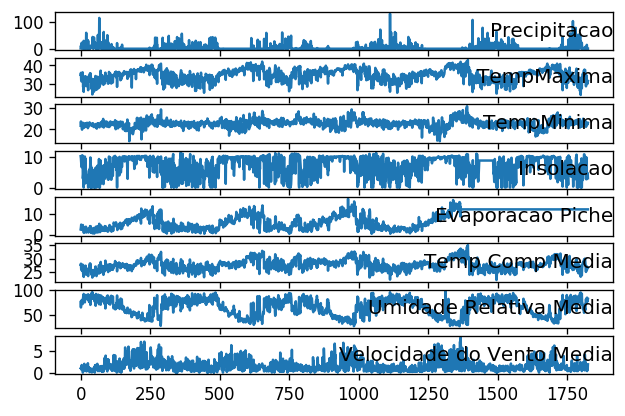

Train on 1764 samples, validate on 1 samples
Epoch 1/1000
 - 14s - loss: 1.9766 - mean_squared_error: 4.7219 - val_loss: 0.2597 - val_mean_squared_error: 0.0760
Epoch 2/1000
 - 1s - loss: 0.1808 - mean_squared_error: 0.0481 - val_loss: 0.1135 - val_mean_squared_error: 0.0146
Epoch 3/1000
 - 1s - loss: 0.0798 - mean_squared_error: 0.0104 - val_loss: 0.0331 - val_mean_squared_error: 0.0014
Epoch 4/1000
 - 1s - loss: 0.0665 - mean_squared_error: 0.0077 - val_loss: 0.0104 - val_mean_squared_error: 1.4758e-04
Epoch 5/1000
 - 1s - loss: 0.0653 - mean_squared_error: 0.0075 - val_loss: 0.0150 - val_mean_squared_error: 3.4508e-04
Epoch 6/1000
 - 1s - loss: 0.0644 - mean_squared_error: 0.0073 - val_loss: 0.0103 - val_mean_squared_error: 1.2064e-04
Epoch 7/1000
 - 1s - loss: 0.0638 - mean_squared_error: 0.0072 - val_loss: 0.0133 - val_mean_squared_error: 2.1219e-04
Epoch 8/1000
 - 1s - loss: 0.0613 - mean_squared_error: 0.0067 - val_loss: 0.0130 - val_mean_squared_error: 1.6976e-04
Epoch 9/1000
 

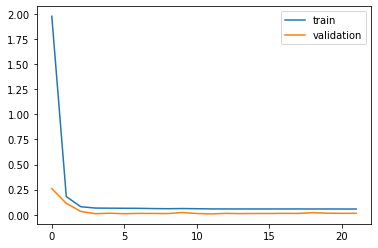


predict: [[33.04865552 22.96838998]]
real:      [[31.6 23.1]]

Train on 1763 samples, validate on 1 samples
Epoch 1/1000
 - 12s - loss: 2.3182 - mean_squared_error: 5.9804 - val_loss: 1.1903 - val_mean_squared_error: 1.8763
Epoch 2/1000
 - 1s - loss: 0.8455 - mean_squared_error: 1.0655 - val_loss: 0.5387 - val_mean_squared_error: 0.4803
Epoch 3/1000
 - 1s - loss: 0.3306 - mean_squared_error: 0.2183 - val_loss: 0.0599 - val_mean_squared_error: 0.0047
Epoch 4/1000
 - 1s - loss: 0.0780 - mean_squared_error: 0.0102 - val_loss: 0.0468 - val_mean_squared_error: 0.0027
Epoch 5/1000
 - 1s - loss: 0.0674 - mean_squared_error: 0.0078 - val_loss: 0.0738 - val_mean_squared_error: 0.0086
Epoch 6/1000
 - 1s - loss: 0.0658 - mean_squared_error: 0.0076 - val_loss: 0.0686 - val_mean_squared_error: 0.0057
Epoch 7/1000
 - 1s - loss: 0.0651 - mean_squared_error: 0.0074 - val_loss: 0.0613 - val_mean_squared_error: 0.0048
Epoch 8/1000
 - 1s - loss: 0.0646 - mean_squared_error: 0.0074 - val_loss: 0.0602 - v

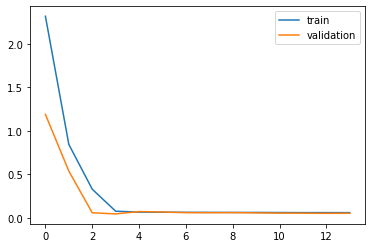


predict: [[33.36434318 23.02588966]]
real:      [[31.7 22.6]]

Train on 1762 samples, validate on 1 samples
Epoch 1/1000
 - 12s - loss: 1.7004 - mean_squared_error: 4.2118 - val_loss: 0.4907 - val_mean_squared_error: 0.4483
Epoch 2/1000
 - 1s - loss: 0.1929 - mean_squared_error: 0.0772 - val_loss: 0.1052 - val_mean_squared_error: 0.0218
Epoch 3/1000
 - 1s - loss: 0.0834 - mean_squared_error: 0.0119 - val_loss: 0.0162 - val_mean_squared_error: 2.6422e-04
Epoch 4/1000
 - 1s - loss: 0.0688 - mean_squared_error: 0.0081 - val_loss: 0.0300 - val_mean_squared_error: 9.0054e-04
Epoch 5/1000
 - 1s - loss: 0.0660 - mean_squared_error: 0.0074 - val_loss: 0.0198 - val_mean_squared_error: 4.4803e-04
Epoch 6/1000
 - 1s - loss: 0.0648 - mean_squared_error: 0.0073 - val_loss: 0.0362 - val_mean_squared_error: 0.0013
Epoch 7/1000
 - 1s - loss: 0.0637 - mean_squared_error: 0.0070 - val_loss: 0.0492 - val_mean_squared_error: 0.0024
Epoch 8/1000
 - 1s - loss: 0.0630 - mean_squared_error: 0.0069 - val_loss

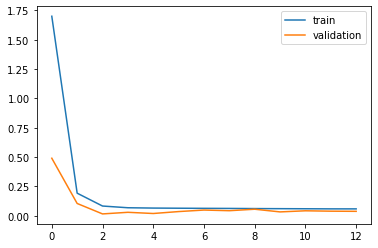


predict: [[36.99546869 22.25659073]]
real:      [[30.  22.8]]

Train on 1761 samples, validate on 1 samples
Epoch 1/1000
 - 12s - loss: 2.2247 - mean_squared_error: 5.8311 - val_loss: 0.8732 - val_mean_squared_error: 1.1225
Epoch 2/1000
 - 1s - loss: 0.3452 - mean_squared_error: 0.2509 - val_loss: 0.1477 - val_mean_squared_error: 0.0386
Epoch 3/1000
 - 1s - loss: 0.1039 - mean_squared_error: 0.0165 - val_loss: 0.1119 - val_mean_squared_error: 0.0194
Epoch 4/1000
 - 1s - loss: 0.0705 - mean_squared_error: 0.0083 - val_loss: 0.0379 - val_mean_squared_error: 0.0025
Epoch 5/1000
 - 1s - loss: 0.0648 - mean_squared_error: 0.0072 - val_loss: 0.0240 - val_mean_squared_error: 0.0010
Epoch 6/1000
 - 1s - loss: 0.0641 - mean_squared_error: 0.0071 - val_loss: 0.0353 - val_mean_squared_error: 0.0013
Epoch 7/1000
 - 1s - loss: 0.0631 - mean_squared_error: 0.0069 - val_loss: 0.0303 - val_mean_squared_error: 0.0011
Epoch 8/1000
 - 1s - loss: 0.0619 - mean_squared_error: 0.0067 - val_loss: 0.0233 - v

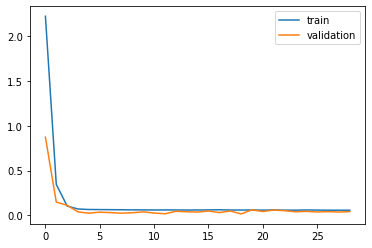


predict: [[32.04398951 21.92833705]]
real:      [[32. 22.]]

Train on 1760 samples, validate on 1 samples
Epoch 1/1000
 - 13s - loss: 2.0062 - mean_squared_error: 4.9542 - val_loss: 0.5238 - val_mean_squared_error: 0.4323
Epoch 2/1000
 - 1s - loss: 0.3016 - mean_squared_error: 0.1443 - val_loss: 0.1213 - val_mean_squared_error: 0.0204
Epoch 3/1000
 - 1s - loss: 0.0964 - mean_squared_error: 0.0153 - val_loss: 0.0119 - val_mean_squared_error: 1.4700e-04
Epoch 4/1000
 - 1s - loss: 0.0719 - mean_squared_error: 0.0089 - val_loss: 0.0194 - val_mean_squared_error: 5.7953e-04
Epoch 5/1000
 - 1s - loss: 0.0683 - mean_squared_error: 0.0081 - val_loss: 0.0413 - val_mean_squared_error: 0.0029
Epoch 6/1000
 - 1s - loss: 0.0661 - mean_squared_error: 0.0077 - val_loss: 0.0333 - val_mean_squared_error: 0.0014
Epoch 7/1000
 - 1s - loss: 0.0647 - mean_squared_error: 0.0074 - val_loss: 0.0487 - val_mean_squared_error: 0.0038
Epoch 8/1000
 - 1s - loss: 0.0641 - mean_squared_error: 0.0072 - val_loss: 0.04

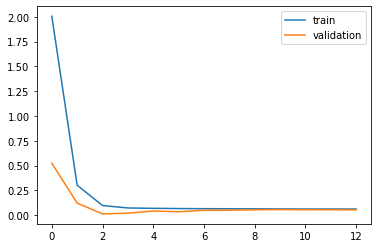


predict: [[35.52938894 23.7575449 ]]
real:      [[31. 22.]]

Train on 1759 samples, validate on 1 samples
Epoch 1/1000
 - 13s - loss: 1.9438 - mean_squared_error: 4.6132 - val_loss: 0.3754 - val_mean_squared_error: 0.2469
Epoch 2/1000
 - 1s - loss: 0.1873 - mean_squared_error: 0.0574 - val_loss: 0.1041 - val_mean_squared_error: 0.0149
Epoch 3/1000
 - 1s - loss: 0.0802 - mean_squared_error: 0.0104 - val_loss: 0.0124 - val_mean_squared_error: 2.1309e-04
Epoch 4/1000
 - 1s - loss: 0.0709 - mean_squared_error: 0.0085 - val_loss: 0.0158 - val_mean_squared_error: 2.7989e-04
Epoch 5/1000
 - 1s - loss: 0.0679 - mean_squared_error: 0.0079 - val_loss: 0.0186 - val_mean_squared_error: 3.4893e-04
Epoch 6/1000
 - 1s - loss: 0.0675 - mean_squared_error: 0.0077 - val_loss: 0.0115 - val_mean_squared_error: 1.6609e-04
Epoch 7/1000
 - 1s - loss: 0.0652 - mean_squared_error: 0.0073 - val_loss: 2.6333e-04 - val_mean_squared_error: 7.1539e-08
Epoch 8/1000
 - 1s - loss: 0.0646 - mean_squared_error: 0.0072 

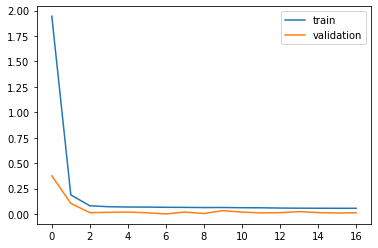


predict: [[34.82554561 22.8870907 ]]
real:      [[34.6 22.4]]

Train on 1758 samples, validate on 1 samples
Epoch 1/1000
 - 13s - loss: 2.5634 - mean_squared_error: 7.4379 - val_loss: 1.4900 - val_mean_squared_error: 4.0582
Epoch 2/1000
 - 1s - loss: 1.1888 - mean_squared_error: 2.6364 - val_loss: 0.6549 - val_mean_squared_error: 0.6903
Epoch 3/1000
 - 1s - loss: 0.2894 - mean_squared_error: 0.2101 - val_loss: 0.2059 - val_mean_squared_error: 0.0557
Epoch 4/1000
 - 1s - loss: 0.0793 - mean_squared_error: 0.0104 - val_loss: 0.1257 - val_mean_squared_error: 0.0203
Epoch 5/1000
 - 1s - loss: 0.0675 - mean_squared_error: 0.0078 - val_loss: 0.1011 - val_mean_squared_error: 0.0127
Epoch 6/1000
 - 1s - loss: 0.0649 - mean_squared_error: 0.0074 - val_loss: 0.1117 - val_mean_squared_error: 0.0139
Epoch 7/1000
 - 1s - loss: 0.0639 - mean_squared_error: 0.0073 - val_loss: 0.1026 - val_mean_squared_error: 0.0121
Epoch 8/1000
 - 1s - loss: 0.0627 - mean_squared_error: 0.0070 - val_loss: 0.1081 - v

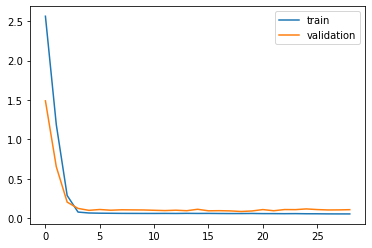


predict: [[34.93210493 21.99578933]]
real:      [[32.6 22.2]]

Train on 1757 samples, validate on 1 samples
Epoch 1/1000
 - 13s - loss: 2.5636 - mean_squared_error: 7.2859 - val_loss: 1.3155 - val_mean_squared_error: 2.7995
Epoch 2/1000
 - 1s - loss: 0.5700 - mean_squared_error: 0.8109 - val_loss: 0.1331 - val_mean_squared_error: 0.0180
Epoch 3/1000
 - 1s - loss: 0.1001 - mean_squared_error: 0.0158 - val_loss: 0.0783 - val_mean_squared_error: 0.0065
Epoch 4/1000
 - 1s - loss: 0.0700 - mean_squared_error: 0.0083 - val_loss: 0.0265 - val_mean_squared_error: 0.0011
Epoch 5/1000
 - 1s - loss: 0.0656 - mean_squared_error: 0.0075 - val_loss: 0.0442 - val_mean_squared_error: 0.0030
Epoch 6/1000
 - 1s - loss: 0.0646 - mean_squared_error: 0.0073 - val_loss: 0.0399 - val_mean_squared_error: 0.0021
Epoch 7/1000
 - 1s - loss: 0.0634 - mean_squared_error: 0.0070 - val_loss: 0.0343 - val_mean_squared_error: 0.0015
Epoch 8/1000
 - 1s - loss: 0.0624 - mean_squared_error: 0.0069 - val_loss: 0.0339 - v

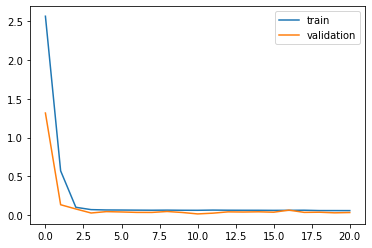


predict: [[36.96386653 22.47244744]]
real:      [[28.7 21.2]]

Train on 1756 samples, validate on 1 samples
Epoch 1/1000
 - 13s - loss: 2.3865 - mean_squared_error: 6.1430 - val_loss: 1.1711 - val_mean_squared_error: 1.3730
Epoch 2/1000
 - 1s - loss: 0.3421 - mean_squared_error: 0.2071 - val_loss: 0.1735 - val_mean_squared_error: 0.0333
Epoch 3/1000
 - 1s - loss: 0.0897 - mean_squared_error: 0.0136 - val_loss: 0.0846 - val_mean_squared_error: 0.0079
Epoch 4/1000
 - 1s - loss: 0.0682 - mean_squared_error: 0.0081 - val_loss: 0.0755 - val_mean_squared_error: 0.0057
Epoch 5/1000
 - 1s - loss: 0.0661 - mean_squared_error: 0.0076 - val_loss: 0.0552 - val_mean_squared_error: 0.0031
Epoch 6/1000
 - 1s - loss: 0.0667 - mean_squared_error: 0.0078 - val_loss: 0.0682 - val_mean_squared_error: 0.0050
Epoch 7/1000
 - 1s - loss: 0.0648 - mean_squared_error: 0.0074 - val_loss: 0.0632 - val_mean_squared_error: 0.0040
Epoch 8/1000
 - 1s - loss: 0.0642 - mean_squared_error: 0.0073 - val_loss: 0.0386 - v

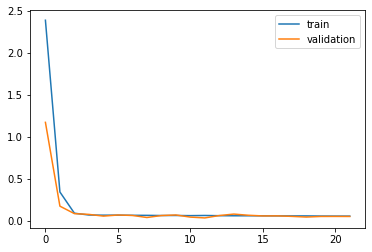


predict: [[36.09675293 22.71407592]]
real:      [[34.5 22.8]]

Train on 1755 samples, validate on 1 samples
Epoch 1/1000
 - 13s - loss: 1.1689 - mean_squared_error: 2.3337 - val_loss: 0.1454 - val_mean_squared_error: 0.0269
Epoch 2/1000
 - 1s - loss: 0.1169 - mean_squared_error: 0.0211 - val_loss: 0.1568 - val_mean_squared_error: 0.0286
Epoch 3/1000
 - 1s - loss: 0.0713 - mean_squared_error: 0.0085 - val_loss: 0.1055 - val_mean_squared_error: 0.0173
Epoch 4/1000
 - 1s - loss: 0.0644 - mean_squared_error: 0.0072 - val_loss: 0.1294 - val_mean_squared_error: 0.0212
Epoch 5/1000
 - 1s - loss: 0.0639 - mean_squared_error: 0.0071 - val_loss: 0.1365 - val_mean_squared_error: 0.0230
Epoch 6/1000
 - 1s - loss: 0.0626 - mean_squared_error: 0.0069 - val_loss: 0.0873 - val_mean_squared_error: 0.0107
Epoch 7/1000
 - 1s - loss: 0.0619 - mean_squared_error: 0.0068 - val_loss: 0.0682 - val_mean_squared_error: 0.0084
Epoch 8/1000
 - 1s - loss: 0.0614 - mean_squared_error: 0.0067 - val_loss: 0.1129 - v

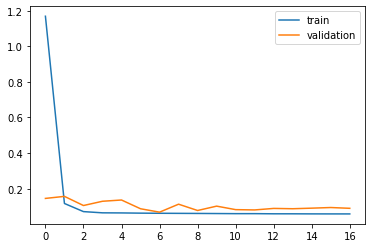


predict: [[36.72309055 23.18871938]]
real:      [[34.7 24. ]]

Train on 1754 samples, validate on 1 samples
Epoch 1/1000
 - 13s - loss: 2.5229 - mean_squared_error: 6.7616 - val_loss: 1.5577 - val_mean_squared_error: 2.7939
Epoch 2/1000
 - 1s - loss: 0.5272 - mean_squared_error: 0.5710 - val_loss: 0.0928 - val_mean_squared_error: 0.0124
Epoch 3/1000
 - 1s - loss: 0.0967 - mean_squared_error: 0.0153 - val_loss: 0.0942 - val_mean_squared_error: 0.0117
Epoch 4/1000
 - 1s - loss: 0.0666 - mean_squared_error: 0.0077 - val_loss: 0.0969 - val_mean_squared_error: 0.0120
Epoch 5/1000
 - 1s - loss: 0.0638 - mean_squared_error: 0.0072 - val_loss: 0.0819 - val_mean_squared_error: 0.0098
Epoch 6/1000
 - 1s - loss: 0.0633 - mean_squared_error: 0.0071 - val_loss: 0.0788 - val_mean_squared_error: 0.0082
Epoch 7/1000
 - 1s - loss: 0.0630 - mean_squared_error: 0.0070 - val_loss: 0.0921 - val_mean_squared_error: 0.0111
Epoch 8/1000
 - 1s - loss: 0.0620 - mean_squared_error: 0.0068 - val_loss: 0.0781 - v

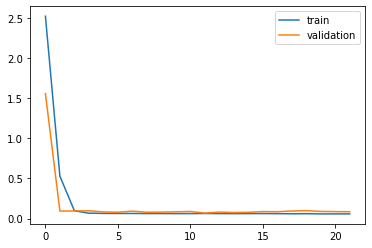


predict: [[35.70126041 23.21057479]]
real:      [[37.5 23.6]]

Train on 1753 samples, validate on 1 samples
Epoch 1/1000
 - 13s - loss: 1.9597 - mean_squared_error: 4.8861 - val_loss: 1.0346 - val_mean_squared_error: 1.7565
Epoch 2/1000
 - 1s - loss: 0.4954 - mean_squared_error: 0.5661 - val_loss: 0.1745 - val_mean_squared_error: 0.0325
Epoch 3/1000
 - 1s - loss: 0.1014 - mean_squared_error: 0.0172 - val_loss: 0.1137 - val_mean_squared_error: 0.0197
Epoch 4/1000
 - 1s - loss: 0.0720 - mean_squared_error: 0.0087 - val_loss: 0.0769 - val_mean_squared_error: 0.0079
Epoch 5/1000
 - 1s - loss: 0.0680 - mean_squared_error: 0.0080 - val_loss: 0.0813 - val_mean_squared_error: 0.0099
Epoch 6/1000
 - 1s - loss: 0.0654 - mean_squared_error: 0.0075 - val_loss: 0.0800 - val_mean_squared_error: 0.0102
Epoch 7/1000
 - 1s - loss: 0.0665 - mean_squared_error: 0.0077 - val_loss: 0.0809 - val_mean_squared_error: 0.0092
Epoch 8/1000
 - 1s - loss: 0.0664 - mean_squared_error: 0.0077 - val_loss: 0.0881 - v

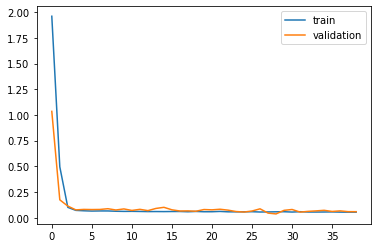


predict: [[36.3217392  23.55975606]]
real:      [[37.6 23.8]]

Train on 1752 samples, validate on 1 samples
Epoch 1/1000
 - 13s - loss: 1.7341 - mean_squared_error: 4.0659 - val_loss: 0.6316 - val_mean_squared_error: 0.5470
Epoch 2/1000
 - 1s - loss: 0.2065 - mean_squared_error: 0.0913 - val_loss: 0.1041 - val_mean_squared_error: 0.0162
Epoch 3/1000
 - 1s - loss: 0.0796 - mean_squared_error: 0.0106 - val_loss: 0.0886 - val_mean_squared_error: 0.0114
Epoch 4/1000
 - 1s - loss: 0.0686 - mean_squared_error: 0.0082 - val_loss: 0.0599 - val_mean_squared_error: 0.0041
Epoch 5/1000
 - 1s - loss: 0.0663 - mean_squared_error: 0.0077 - val_loss: 0.0795 - val_mean_squared_error: 0.0097
Epoch 6/1000
 - 1s - loss: 0.0651 - mean_squared_error: 0.0074 - val_loss: 0.0715 - val_mean_squared_error: 0.0087
Epoch 7/1000
 - 1s - loss: 0.0643 - mean_squared_error: 0.0073 - val_loss: 0.0827 - val_mean_squared_error: 0.0119
Epoch 8/1000
 - 1s - loss: 0.0639 - mean_squared_error: 0.0072 - val_loss: 0.0797 - v

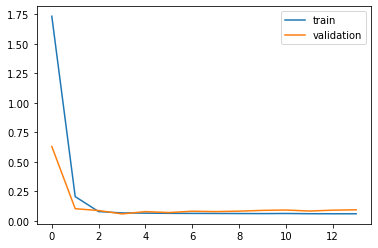


predict: [[37.2186061  22.84416528]]
real:      [[37.  23.4]]

Train on 1751 samples, validate on 1 samples
Epoch 1/1000
 - 13s - loss: 1.9750 - mean_squared_error: 5.0969 - val_loss: 0.9352 - val_mean_squared_error: 1.4882
Epoch 2/1000
 - 1s - loss: 0.4438 - mean_squared_error: 0.4432 - val_loss: 0.1065 - val_mean_squared_error: 0.0154
Epoch 3/1000
 - 1s - loss: 0.0898 - mean_squared_error: 0.0130 - val_loss: 0.0332 - val_mean_squared_error: 0.0019
Epoch 4/1000
 - 1s - loss: 0.0683 - mean_squared_error: 0.0081 - val_loss: 0.0514 - val_mean_squared_error: 0.0039
Epoch 5/1000
 - 1s - loss: 0.0653 - mean_squared_error: 0.0075 - val_loss: 0.0948 - val_mean_squared_error: 0.0107
Epoch 6/1000
 - 1s - loss: 0.0653 - mean_squared_error: 0.0075 - val_loss: 0.0655 - val_mean_squared_error: 0.0068
Epoch 7/1000
 - 1s - loss: 0.0630 - mean_squared_error: 0.0070 - val_loss: 0.0844 - val_mean_squared_error: 0.0104
Epoch 8/1000
 - 1s - loss: 0.0629 - mean_squared_error: 0.0070 - val_loss: 0.0719 - v

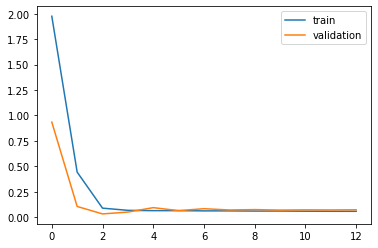


predict: [[35.81988651 23.6935956 ]]
real:      [[37.7 23.4]]

Train on 1750 samples, validate on 1 samples
Epoch 1/1000
 - 13s - loss: 1.7457 - mean_squared_error: 3.8998 - val_loss: 0.3070 - val_mean_squared_error: 0.1073
Epoch 2/1000
 - 1s - loss: 0.1575 - mean_squared_error: 0.0385 - val_loss: 0.0558 - val_mean_squared_error: 0.0035
Epoch 3/1000
 - 1s - loss: 0.0746 - mean_squared_error: 0.0093 - val_loss: 0.0824 - val_mean_squared_error: 0.0084
Epoch 4/1000
 - 1s - loss: 0.0659 - mean_squared_error: 0.0074 - val_loss: 0.0818 - val_mean_squared_error: 0.0100
Epoch 5/1000
 - 1s - loss: 0.0634 - mean_squared_error: 0.0070 - val_loss: 0.0634 - val_mean_squared_error: 0.0073
Epoch 6/1000
 - 1s - loss: 0.0631 - mean_squared_error: 0.0069 - val_loss: 0.0756 - val_mean_squared_error: 0.0090
Epoch 7/1000
 - 1s - loss: 0.0616 - mean_squared_error: 0.0066 - val_loss: 0.0797 - val_mean_squared_error: 0.0104
Epoch 8/1000
 - 1s - loss: 0.0607 - mean_squared_error: 0.0065 - val_loss: 0.0774 - v

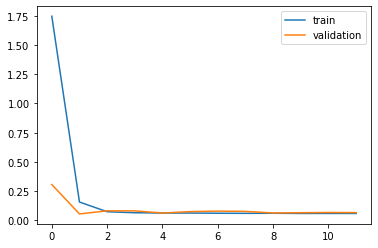


predict: [[35.27928232 21.7378638 ]]
real:      [[37.2 22.7]]

Train on 1749 samples, validate on 1 samples
Epoch 1/1000
 - 13s - loss: 0.8113 - mean_squared_error: 1.2190 - val_loss: 0.1915 - val_mean_squared_error: 0.0460
Epoch 2/1000
 - 1s - loss: 0.1037 - mean_squared_error: 0.0175 - val_loss: 0.0757 - val_mean_squared_error: 0.0072
Epoch 3/1000
 - 1s - loss: 0.0691 - mean_squared_error: 0.0081 - val_loss: 0.0626 - val_mean_squared_error: 0.0055
Epoch 4/1000
 - 1s - loss: 0.0645 - mean_squared_error: 0.0073 - val_loss: 0.0773 - val_mean_squared_error: 0.0088
Epoch 5/1000
 - 1s - loss: 0.0636 - mean_squared_error: 0.0070 - val_loss: 0.0766 - val_mean_squared_error: 0.0110
Epoch 6/1000
 - 1s - loss: 0.0630 - mean_squared_error: 0.0069 - val_loss: 0.0681 - val_mean_squared_error: 0.0066
Epoch 7/1000
 - 1s - loss: 0.0632 - mean_squared_error: 0.0069 - val_loss: 0.0566 - val_mean_squared_error: 0.0045
Epoch 8/1000
 - 1s - loss: 0.0621 - mean_squared_error: 0.0068 - val_loss: 0.0730 - v

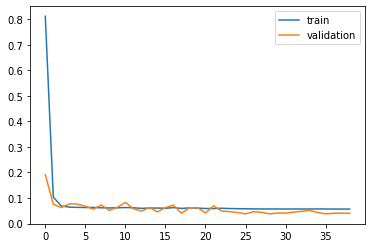


predict: [[34.22535542 22.63439431]]
real:      [[37.2 22.7]]

Train on 1748 samples, validate on 1 samples
Epoch 1/1000
 - 13s - loss: 1.8726 - mean_squared_error: 4.2404 - val_loss: 0.3884 - val_mean_squared_error: 0.2318
Epoch 2/1000
 - 1s - loss: 0.1875 - mean_squared_error: 0.0539 - val_loss: 0.1172 - val_mean_squared_error: 0.0147
Epoch 3/1000
 - 1s - loss: 0.0795 - mean_squared_error: 0.0103 - val_loss: 0.0511 - val_mean_squared_error: 0.0026
Epoch 4/1000
 - 1s - loss: 0.0670 - mean_squared_error: 0.0077 - val_loss: 0.0738 - val_mean_squared_error: 0.0055
Epoch 5/1000
 - 1s - loss: 0.0660 - mean_squared_error: 0.0076 - val_loss: 0.0640 - val_mean_squared_error: 0.0045
Epoch 6/1000
 - 1s - loss: 0.0646 - mean_squared_error: 0.0074 - val_loss: 0.0745 - val_mean_squared_error: 0.0058
Epoch 7/1000
 - 1s - loss: 0.0635 - mean_squared_error: 0.0071 - val_loss: 0.0818 - val_mean_squared_error: 0.0067
Epoch 8/1000
 - 1s - loss: 0.0633 - mean_squared_error: 0.0070 - val_loss: 0.0732 - v

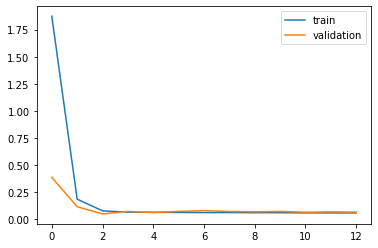


predict: [[35.1639154  23.34770051]]
real:      [[35.6 22.9]]

Train on 1747 samples, validate on 1 samples
Epoch 1/1000
 - 14s - loss: 1.8313 - mean_squared_error: 4.5328 - val_loss: 0.4589 - val_mean_squared_error: 0.3716
Epoch 2/1000
 - 1s - loss: 0.1696 - mean_squared_error: 0.0523 - val_loss: 0.0967 - val_mean_squared_error: 0.0121
Epoch 3/1000
 - 1s - loss: 0.0817 - mean_squared_error: 0.0108 - val_loss: 0.0927 - val_mean_squared_error: 0.0086
Epoch 4/1000
 - 1s - loss: 0.0712 - mean_squared_error: 0.0086 - val_loss: 0.0853 - val_mean_squared_error: 0.0079
Epoch 5/1000
 - 1s - loss: 0.0680 - mean_squared_error: 0.0079 - val_loss: 0.0931 - val_mean_squared_error: 0.0087
Epoch 6/1000
 - 1s - loss: 0.0668 - mean_squared_error: 0.0076 - val_loss: 0.0747 - val_mean_squared_error: 0.0057
Epoch 7/1000
 - 1s - loss: 0.0648 - mean_squared_error: 0.0073 - val_loss: 0.0642 - val_mean_squared_error: 0.0043
Epoch 8/1000
 - 1s - loss: 0.0643 - mean_squared_error: 0.0072 - val_loss: 0.0598 - v

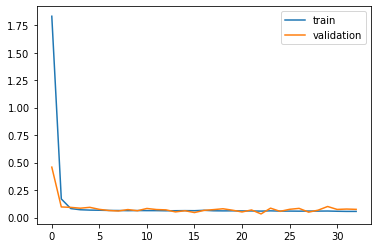


predict: [[34.93386975 23.35973714]]
real:      [[34.1 25. ]]

Train on 1746 samples, validate on 1 samples
Epoch 1/1000
 - 14s - loss: 1.6133 - mean_squared_error: 3.4286 - val_loss: 0.1614 - val_mean_squared_error: 0.0316
Epoch 2/1000
 - 1s - loss: 0.1766 - mean_squared_error: 0.0469 - val_loss: 0.0999 - val_mean_squared_error: 0.0102
Epoch 3/1000
 - 1s - loss: 0.0834 - mean_squared_error: 0.0113 - val_loss: 0.0382 - val_mean_squared_error: 0.0027
Epoch 4/1000
 - 1s - loss: 0.0675 - mean_squared_error: 0.0078 - val_loss: 0.0592 - val_mean_squared_error: 0.0036
Epoch 5/1000
 - 1s - loss: 0.0637 - mean_squared_error: 0.0071 - val_loss: 0.0657 - val_mean_squared_error: 0.0045
Epoch 6/1000
 - 1s - loss: 0.0616 - mean_squared_error: 0.0067 - val_loss: 0.0765 - val_mean_squared_error: 0.0059
Epoch 7/1000
 - 1s - loss: 0.0615 - mean_squared_error: 0.0066 - val_loss: 0.0526 - val_mean_squared_error: 0.0028
Epoch 8/1000
 - 1s - loss: 0.0603 - mean_squared_error: 0.0064 - val_loss: 0.0724 - v

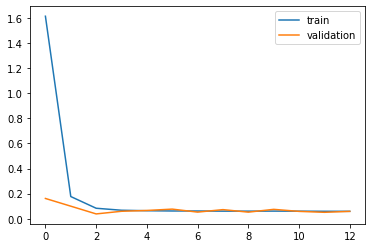


predict: [[35.10877572 21.64659303]]
real:      [[35.4 24.2]]

Train on 1745 samples, validate on 1 samples
Epoch 1/1000
 - 14s - loss: 1.2510 - mean_squared_error: 2.4976 - val_loss: 0.0739 - val_mean_squared_error: 0.0097
Epoch 2/1000
 - 1s - loss: 0.1302 - mean_squared_error: 0.0256 - val_loss: 0.1469 - val_mean_squared_error: 0.0237
Epoch 3/1000
 - 1s - loss: 0.0756 - mean_squared_error: 0.0097 - val_loss: 0.0314 - val_mean_squared_error: 0.0019
Epoch 4/1000
 - 1s - loss: 0.0653 - mean_squared_error: 0.0074 - val_loss: 0.0111 - val_mean_squared_error: 1.4807e-04
Epoch 5/1000
 - 1s - loss: 0.0650 - mean_squared_error: 0.0073 - val_loss: 0.0171 - val_mean_squared_error: 3.0383e-04
Epoch 6/1000
 - 1s - loss: 0.0628 - mean_squared_error: 0.0069 - val_loss: 0.0360 - val_mean_squared_error: 0.0014
Epoch 7/1000
 - 1s - loss: 0.0636 - mean_squared_error: 0.0070 - val_loss: 0.0208 - val_mean_squared_error: 4.4656e-04
Epoch 8/1000
 - 1s - loss: 0.0622 - mean_squared_error: 0.0068 - val_loss

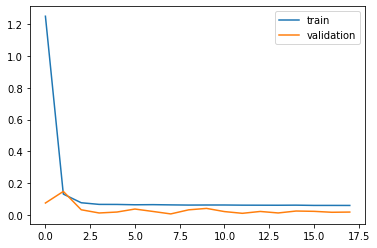


predict: [[32.78144766 23.93404076]]
real:      [[35.4 24. ]]

Train on 1744 samples, validate on 1 samples
Epoch 1/1000
 - 14s - loss: 1.9231 - mean_squared_error: 4.8298 - val_loss: 0.4529 - val_mean_squared_error: 0.2071
Epoch 2/1000
 - 1s - loss: 0.2075 - mean_squared_error: 0.0657 - val_loss: 0.1300 - val_mean_squared_error: 0.0213
Epoch 3/1000
 - 1s - loss: 0.0868 - mean_squared_error: 0.0122 - val_loss: 0.0334 - val_mean_squared_error: 0.0012
Epoch 4/1000
 - 1s - loss: 0.0712 - mean_squared_error: 0.0086 - val_loss: 0.0571 - val_mean_squared_error: 0.0043
Epoch 5/1000
 - 1s - loss: 0.0704 - mean_squared_error: 0.0085 - val_loss: 0.0569 - val_mean_squared_error: 0.0052
Epoch 6/1000
 - 1s - loss: 0.0673 - mean_squared_error: 0.0078 - val_loss: 0.0526 - val_mean_squared_error: 0.0055
Epoch 7/1000
 - 1s - loss: 0.0657 - mean_squared_error: 0.0075 - val_loss: 0.0465 - val_mean_squared_error: 0.0041
Epoch 8/1000
 - 1s - loss: 0.0646 - mean_squared_error: 0.0073 - val_loss: 0.0488 - v

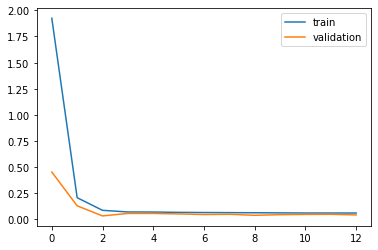


predict: [[34.70538962 22.34263296]]
real:      [[32.4 23.9]]

Train on 1743 samples, validate on 1 samples
Epoch 1/1000
 - 14s - loss: 1.4525 - mean_squared_error: 2.9878 - val_loss: 0.4775 - val_mean_squared_error: 0.2489
Epoch 2/1000
 - 1s - loss: 0.1169 - mean_squared_error: 0.0224 - val_loss: 0.1455 - val_mean_squared_error: 0.0369
Epoch 3/1000
 - 1s - loss: 0.0742 - mean_squared_error: 0.0093 - val_loss: 0.1095 - val_mean_squared_error: 0.0235
Epoch 4/1000
 - 1s - loss: 0.0684 - mean_squared_error: 0.0081 - val_loss: 0.1050 - val_mean_squared_error: 0.0181
Epoch 5/1000
 - 1s - loss: 0.0663 - mean_squared_error: 0.0077 - val_loss: 0.0976 - val_mean_squared_error: 0.0156
Epoch 6/1000
 - 1s - loss: 0.0674 - mean_squared_error: 0.0078 - val_loss: 0.0939 - val_mean_squared_error: 0.0152
Epoch 7/1000
 - 1s - loss: 0.0644 - mean_squared_error: 0.0073 - val_loss: 0.0981 - val_mean_squared_error: 0.0168
Epoch 8/1000
 - 1s - loss: 0.0631 - mean_squared_error: 0.0071 - val_loss: 0.0960 - v

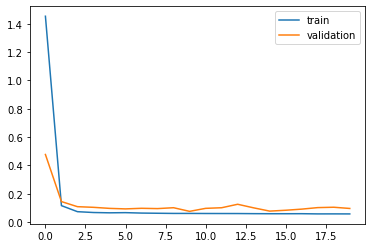


predict: [[30.79800382 22.31578462]]
real:      [[32.6 21.3]]

Train on 1742 samples, validate on 1 samples
Epoch 1/1000
 - 14s - loss: 2.3906 - mean_squared_error: 6.4367 - val_loss: 1.0503 - val_mean_squared_error: 1.8248
Epoch 2/1000
 - 1s - loss: 0.4256 - mean_squared_error: 0.4376 - val_loss: 0.1040 - val_mean_squared_error: 0.0126
Epoch 3/1000
 - 1s - loss: 0.0910 - mean_squared_error: 0.0131 - val_loss: 0.0310 - val_mean_squared_error: 0.0014
Epoch 4/1000
 - 1s - loss: 0.0720 - mean_squared_error: 0.0086 - val_loss: 0.0130 - val_mean_squared_error: 3.0219e-04
Epoch 5/1000
 - 1s - loss: 0.0666 - mean_squared_error: 0.0076 - val_loss: 0.0333 - val_mean_squared_error: 0.0014
Epoch 6/1000
 - 1s - loss: 0.0655 - mean_squared_error: 0.0074 - val_loss: 0.0411 - val_mean_squared_error: 0.0023
Epoch 7/1000
 - 1s - loss: 0.0658 - mean_squared_error: 0.0074 - val_loss: 0.0398 - val_mean_squared_error: 0.0016
Epoch 8/1000
 - 1s - loss: 0.0635 - mean_squared_error: 0.0070 - val_loss: 0.0218

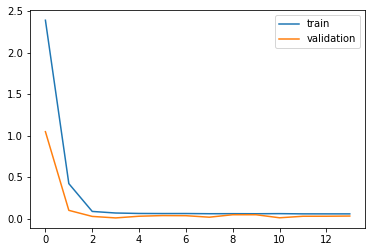


predict: [[36.60515858 22.56001287]]
real:      [[27.6 22.5]]

Train on 1741 samples, validate on 1 samples
Epoch 1/1000
 - 14s - loss: 3.1556 - mean_squared_error: 10.0974 - val_loss: 2.5866 - val_mean_squared_error: 6.8246
Epoch 2/1000
 - 1s - loss: 1.9252 - mean_squared_error: 4.5238 - val_loss: 1.1554 - val_mean_squared_error: 2.1448
Epoch 3/1000
 - 1s - loss: 0.4890 - mean_squared_error: 0.6045 - val_loss: 0.2211 - val_mean_squared_error: 0.0493
Epoch 4/1000
 - 1s - loss: 0.0961 - mean_squared_error: 0.0153 - val_loss: 0.1096 - val_mean_squared_error: 0.0138
Epoch 5/1000
 - 1s - loss: 0.0676 - mean_squared_error: 0.0078 - val_loss: 0.0481 - val_mean_squared_error: 0.0033
Epoch 6/1000
 - 1s - loss: 0.0653 - mean_squared_error: 0.0074 - val_loss: 0.0455 - val_mean_squared_error: 0.0022
Epoch 7/1000
 - 1s - loss: 0.0639 - mean_squared_error: 0.0072 - val_loss: 0.0499 - val_mean_squared_error: 0.0030
Epoch 8/1000
 - 1s - loss: 0.0649 - mean_squared_error: 0.0074 - val_loss: 0.0686 - 

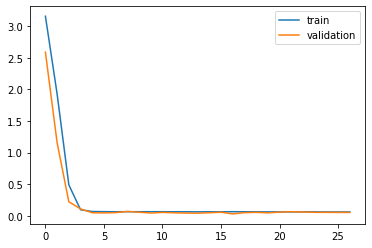


predict: [[32.62455633 22.91768741]]
real:      [[33.6 22.3]]

Train on 1740 samples, validate on 1 samples
Epoch 1/1000
 - 14s - loss: 2.9126 - mean_squared_error: 9.3988 - val_loss: 1.6712 - val_mean_squared_error: 3.9542
Epoch 2/1000
 - 1s - loss: 0.7973 - mean_squared_error: 1.3758 - val_loss: 0.2548 - val_mean_squared_error: 0.0848
Epoch 3/1000
 - 1s - loss: 0.1153 - mean_squared_error: 0.0233 - val_loss: 0.0643 - val_mean_squared_error: 0.0045
Epoch 4/1000
 - 1s - loss: 0.0718 - mean_squared_error: 0.0088 - val_loss: 0.0645 - val_mean_squared_error: 0.0060
Epoch 5/1000
 - 1s - loss: 0.0680 - mean_squared_error: 0.0080 - val_loss: 0.0816 - val_mean_squared_error: 0.0073
Epoch 6/1000
 - 1s - loss: 0.0667 - mean_squared_error: 0.0077 - val_loss: 0.0877 - val_mean_squared_error: 0.0078
Epoch 7/1000
 - 1s - loss: 0.0648 - mean_squared_error: 0.0074 - val_loss: 0.0720 - val_mean_squared_error: 0.0065
Epoch 8/1000
 - 1s - loss: 0.0631 - mean_squared_error: 0.0070 - val_loss: 0.0914 - v

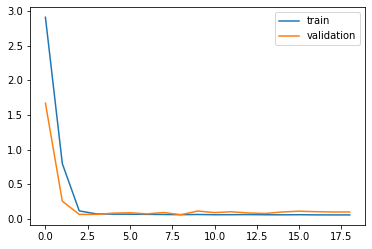


predict: [[30.20466159 22.14905468]]
real:      [[30.2 22.4]]

Train on 1739 samples, validate on 1 samples
Epoch 1/1000
 - 14s - loss: 3.1783 - mean_squared_error: 10.1971 - val_loss: 2.5628 - val_mean_squared_error: 6.6193
Epoch 2/1000
 - 1s - loss: 2.0151 - mean_squared_error: 4.7358 - val_loss: 0.7720 - val_mean_squared_error: 1.0210
Epoch 3/1000
 - 1s - loss: 0.3971 - mean_squared_error: 0.3746 - val_loss: 0.3115 - val_mean_squared_error: 0.1071
Epoch 4/1000
 - 1s - loss: 0.0889 - mean_squared_error: 0.0127 - val_loss: 0.2274 - val_mean_squared_error: 0.0781
Epoch 5/1000
 - 1s - loss: 0.0699 - mean_squared_error: 0.0081 - val_loss: 0.1993 - val_mean_squared_error: 0.0607
Epoch 6/1000
 - 1s - loss: 0.0668 - mean_squared_error: 0.0076 - val_loss: 0.2006 - val_mean_squared_error: 0.0631
Epoch 7/1000
 - 1s - loss: 0.0653 - mean_squared_error: 0.0074 - val_loss: 0.1863 - val_mean_squared_error: 0.0551
Epoch 8/1000
 - 1s - loss: 0.0645 - mean_squared_error: 0.0072 - val_loss: 0.1659 - 

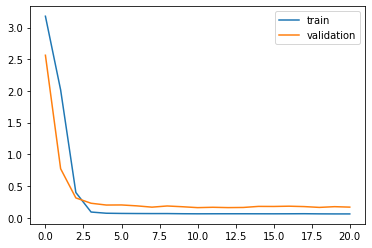


predict: [[32.05669177 22.88455081]]
real:      [[28.9 21.5]]

Train on 1738 samples, validate on 1 samples
Epoch 1/1000
 - 14s - loss: 2.8806 - mean_squared_error: 11.2027 - val_loss: 2.5480 - val_mean_squared_error: 11.7660
Epoch 2/1000
 - 1s - loss: 2.3969 - mean_squared_error: 10.8885 - val_loss: 2.2188 - val_mean_squared_error: 9.7473
Epoch 3/1000
 - 1s - loss: 2.2023 - mean_squared_error: 9.3427 - val_loss: 2.0291 - val_mean_squared_error: 8.1520
Epoch 4/1000
 - 1s - loss: 1.9735 - mean_squared_error: 7.5297 - val_loss: 1.7656 - val_mean_squared_error: 6.1242
Epoch 5/1000
 - 1s - loss: 1.5945 - mean_squared_error: 4.9316 - val_loss: 1.1036 - val_mean_squared_error: 2.3510
Epoch 6/1000
 - 1s - loss: 0.6622 - mean_squared_error: 0.9699 - val_loss: 0.0283 - val_mean_squared_error: 9.7492e-04
Epoch 7/1000
 - 1s - loss: 0.0939 - mean_squared_error: 0.0153 - val_loss: 0.0579 - val_mean_squared_error: 0.0039
Epoch 8/1000
 - 1s - loss: 0.0689 - mean_squared_error: 0.0080 - val_loss: 0.0

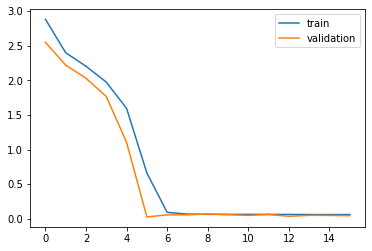


predict: [[34.12761655 23.63095071]]
real:      [[24.  22.5]]

Train on 1737 samples, validate on 1 samples
Epoch 1/1000
 - 14s - loss: 1.7567 - mean_squared_error: 4.0479 - val_loss: 0.7781 - val_mean_squared_error: 0.6178
Epoch 2/1000
 - 1s - loss: 0.2551 - mean_squared_error: 0.1250 - val_loss: 0.0923 - val_mean_squared_error: 0.0093
Epoch 3/1000
 - 1s - loss: 0.0741 - mean_squared_error: 0.0093 - val_loss: 0.1517 - val_mean_squared_error: 0.0287
Epoch 4/1000
 - 1s - loss: 0.0654 - mean_squared_error: 0.0074 - val_loss: 0.1710 - val_mean_squared_error: 0.0334
Epoch 5/1000
 - 1s - loss: 0.0639 - mean_squared_error: 0.0072 - val_loss: 0.1422 - val_mean_squared_error: 0.0221
Epoch 6/1000
 - 1s - loss: 0.0630 - mean_squared_error: 0.0070 - val_loss: 0.1725 - val_mean_squared_error: 0.0313
Epoch 7/1000
 - 1s - loss: 0.0634 - mean_squared_error: 0.0070 - val_loss: 0.1551 - val_mean_squared_error: 0.0260
Epoch 8/1000
 - 1s - loss: 0.0624 - mean_squared_error: 0.0069 - val_loss: 0.1218 - v

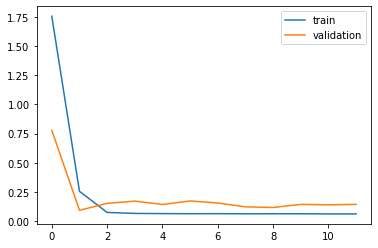


predict: [[29.1105257  21.48938785]]
real:      [[32.6 21.6]]

Train on 1736 samples, validate on 1 samples
Epoch 1/1000
 - 14s - loss: 2.2684 - mean_squared_error: 5.7205 - val_loss: 0.8331 - val_mean_squared_error: 1.3319
Epoch 2/1000
 - 1s - loss: 0.3869 - mean_squared_error: 0.3881 - val_loss: 0.1888 - val_mean_squared_error: 0.0462
Epoch 3/1000
 - 1s - loss: 0.0907 - mean_squared_error: 0.0137 - val_loss: 0.1601 - val_mean_squared_error: 0.0273
Epoch 4/1000
 - 1s - loss: 0.0687 - mean_squared_error: 0.0079 - val_loss: 0.1810 - val_mean_squared_error: 0.0417
Epoch 5/1000
 - 1s - loss: 0.0653 - mean_squared_error: 0.0073 - val_loss: 0.1624 - val_mean_squared_error: 0.0302
Epoch 6/1000
 - 1s - loss: 0.0643 - mean_squared_error: 0.0071 - val_loss: 0.1344 - val_mean_squared_error: 0.0234
Epoch 7/1000
 - 1s - loss: 0.0642 - mean_squared_error: 0.0071 - val_loss: 0.1451 - val_mean_squared_error: 0.0234
Epoch 8/1000
 - 1s - loss: 0.0648 - mean_squared_error: 0.0072 - val_loss: 0.1186 - v

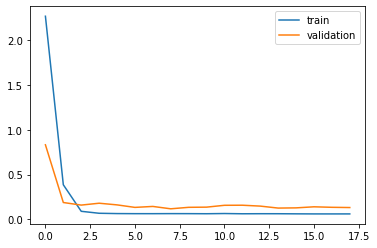


predict: [[31.28381377 22.66429497]]
real:      [[27.2 20.9]]

Train on 1735 samples, validate on 1 samples
Epoch 1/1000
 - 15s - loss: 1.7738 - mean_squared_error: 4.0611 - val_loss: 0.3583 - val_mean_squared_error: 0.1352
Epoch 2/1000
 - 1s - loss: 0.1948 - mean_squared_error: 0.0608 - val_loss: 0.1156 - val_mean_squared_error: 0.0211
Epoch 3/1000
 - 1s - loss: 0.0858 - mean_squared_error: 0.0122 - val_loss: 0.0470 - val_mean_squared_error: 0.0024
Epoch 4/1000
 - 1s - loss: 0.0710 - mean_squared_error: 0.0087 - val_loss: 0.0086 - val_mean_squared_error: 7.5791e-05
Epoch 5/1000
 - 1s - loss: 0.0681 - mean_squared_error: 0.0081 - val_loss: 0.0124 - val_mean_squared_error: 1.7359e-04
Epoch 6/1000
 - 1s - loss: 0.0670 - mean_squared_error: 0.0078 - val_loss: 0.0041 - val_mean_squared_error: 1.8875e-05
Epoch 7/1000
 - 1s - loss: 0.0655 - mean_squared_error: 0.0076 - val_loss: 0.0145 - val_mean_squared_error: 2.1006e-04
Epoch 8/1000
 - 1s - loss: 0.0659 - mean_squared_error: 0.0075 - val_

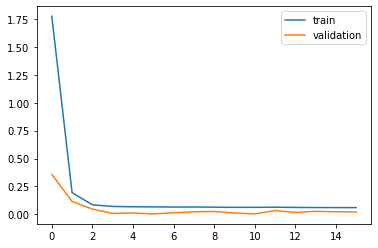


predict: [[34.15539091 23.82850783]]
real:      [[26.3 24.8]]

Train and validation time: 22.18 minutes

Maximum temperatures metrics
Test MEAN-SQUARED-ERROR ------------ 15.91
Test STANDART-DEVIATION ------------ 2.767
Test MEAN-ABSOLUTE-ERROR ----------- 2.873
Test MEDIAN-ABSOLUTE-ERROR --------- 1.9

Errors
2018-12-31 = 1.4486555221737234
2018-12-30 = 1.6643431750459143
2018-12-29 = 6.99546868563376
2018-12-28 = 0.04398951033262222
2018-12-27 = 4.529388942456734
2018-12-26 = 0.22554560708830707
2018-12-25 = 2.3321049308387742
2018-12-24 = 8.2638665336891
2018-12-23 = 1.5967529322318796
2018-12-22 = 2.0230905523436036
2018-12-21 = 1.7987395888539055
2018-12-20 = 1.2782607972319369
2018-12-19 = 0.21860610348623766
2018-12-18 = 1.8801134878296324
2018-12-17 = 1.9207176805571606
2018-12-16 = 2.9746445839881304
2018-12-15 = 0.43608459962374013
2018-12-14 = 0.8338697517461
2018-12-13 = 0.29122427636726655
2018-12-12 = 2.618552338140532
2018-12-11 = 2.3053896216985947
2018-12-10 = 1.80199

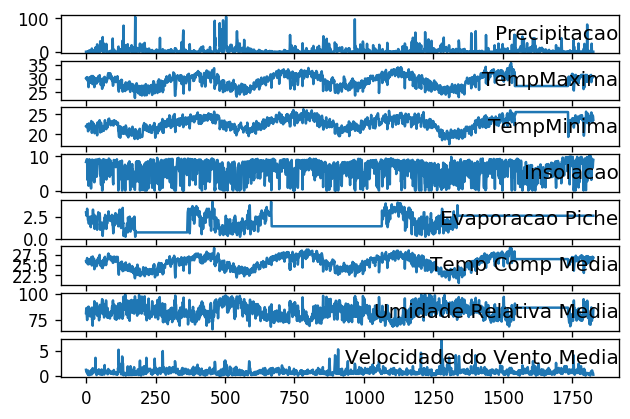

Train on 1764 samples, validate on 1 samples
Epoch 1/1000
 - 15s - loss: 2.6307 - mean_squared_error: 8.5505 - val_loss: 1.8532 - val_mean_squared_error: 6.8352
Epoch 2/1000
 - 1s - loss: 1.4601 - mean_squared_error: 4.0874 - val_loss: 0.9330 - val_mean_squared_error: 1.3955
Epoch 3/1000
 - 1s - loss: 0.3182 - mean_squared_error: 0.2757 - val_loss: 0.1066 - val_mean_squared_error: 0.0120
Epoch 4/1000
 - 1s - loss: 0.0768 - mean_squared_error: 0.0090 - val_loss: 0.1209 - val_mean_squared_error: 0.0169
Epoch 5/1000
 - 1s - loss: 0.0635 - mean_squared_error: 0.0061 - val_loss: 0.1130 - val_mean_squared_error: 0.0205
Epoch 6/1000
 - 1s - loss: 0.0623 - mean_squared_error: 0.0059 - val_loss: 0.1183 - val_mean_squared_error: 0.0180
Epoch 7/1000
 - 1s - loss: 0.0630 - mean_squared_error: 0.0060 - val_loss: 0.1100 - val_mean_squared_error: 0.0163
Epoch 8/1000
 - 1s - loss: 0.0621 - mean_squared_error: 0.0059 - val_loss: 0.1022 - val_mean_squared_error: 0.0122
Epoch 9/1000
 - 1s - loss: 0.0612 

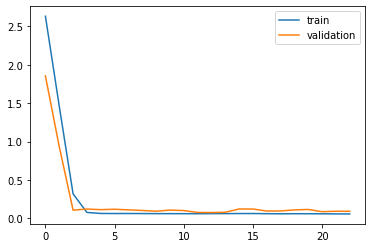


predict: [[30.86986403 23.39558027]]
real:      [[30.7 23.6]]

Train on 1763 samples, validate on 1 samples
Epoch 1/1000
 - 15s - loss: 2.3697 - mean_squared_error: 6.1513 - val_loss: 1.1042 - val_mean_squared_error: 1.3883
Epoch 2/1000
 - 1s - loss: 0.3473 - mean_squared_error: 0.2420 - val_loss: 0.1938 - val_mean_squared_error: 0.0426
Epoch 3/1000
 - 1s - loss: 0.0782 - mean_squared_error: 0.0096 - val_loss: 0.1620 - val_mean_squared_error: 0.0262
Epoch 4/1000
 - 1s - loss: 0.0634 - mean_squared_error: 0.0062 - val_loss: 0.1243 - val_mean_squared_error: 0.0156
Epoch 5/1000
 - 1s - loss: 0.0621 - mean_squared_error: 0.0059 - val_loss: 0.1133 - val_mean_squared_error: 0.0131
Epoch 6/1000
 - 1s - loss: 0.0610 - mean_squared_error: 0.0057 - val_loss: 0.1270 - val_mean_squared_error: 0.0163
Epoch 7/1000
 - 1s - loss: 0.0612 - mean_squared_error: 0.0056 - val_loss: 0.1330 - val_mean_squared_error: 0.0177
Epoch 8/1000
 - 1s - loss: 0.0610 - mean_squared_error: 0.0056 - val_loss: 0.1107 - v

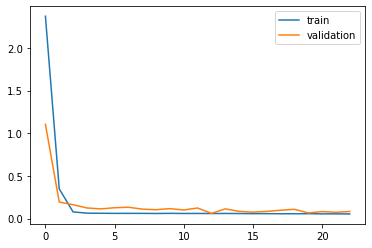


predict: [[31.15328221 24.15343982]]
real:      [[30.8 24.4]]

Train on 1762 samples, validate on 1 samples
Epoch 1/1000
 - 15s - loss: 1.6341 - mean_squared_error: 3.3612 - val_loss: 0.3779 - val_mean_squared_error: 0.2704
Epoch 2/1000
 - 1s - loss: 0.1575 - mean_squared_error: 0.0445 - val_loss: 0.1059 - val_mean_squared_error: 0.0115
Epoch 3/1000
 - 1s - loss: 0.0678 - mean_squared_error: 0.0071 - val_loss: 0.0954 - val_mean_squared_error: 0.0091
Epoch 4/1000
 - 1s - loss: 0.0612 - mean_squared_error: 0.0058 - val_loss: 0.1007 - val_mean_squared_error: 0.0103
Epoch 5/1000
 - 1s - loss: 0.0617 - mean_squared_error: 0.0059 - val_loss: 0.0896 - val_mean_squared_error: 0.0081
Epoch 6/1000
 - 1s - loss: 0.0608 - mean_squared_error: 0.0057 - val_loss: 0.0810 - val_mean_squared_error: 0.0069
Epoch 7/1000
 - 1s - loss: 0.0598 - mean_squared_error: 0.0055 - val_loss: 0.0805 - val_mean_squared_error: 0.0070
Epoch 8/1000
 - 1s - loss: 0.0609 - mean_squared_error: 0.0058 - val_loss: 0.1092 - v

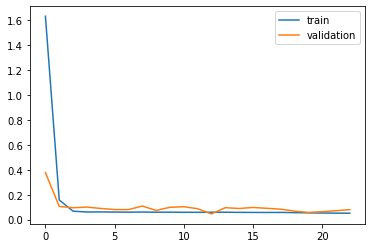


predict: [[31.52332212 23.44533173]]
real:      [[30.6 24.7]]

Train on 1761 samples, validate on 1 samples
Epoch 1/1000
 - 15s - loss: 1.5722 - mean_squared_error: 3.0314 - val_loss: 0.1512 - val_mean_squared_error: 0.0262
Epoch 2/1000
 - 1s - loss: 0.1472 - mean_squared_error: 0.0378 - val_loss: 0.0543 - val_mean_squared_error: 0.0031
Epoch 3/1000
 - 1s - loss: 0.0718 - mean_squared_error: 0.0080 - val_loss: 0.0968 - val_mean_squared_error: 0.0095
Epoch 4/1000
 - 1s - loss: 0.0622 - mean_squared_error: 0.0058 - val_loss: 0.0646 - val_mean_squared_error: 0.0042
Epoch 5/1000
 - 1s - loss: 0.0601 - mean_squared_error: 0.0054 - val_loss: 0.0660 - val_mean_squared_error: 0.0044
Epoch 6/1000
 - 1s - loss: 0.0601 - mean_squared_error: 0.0054 - val_loss: 0.0587 - val_mean_squared_error: 0.0036
Epoch 7/1000
 - 1s - loss: 0.0604 - mean_squared_error: 0.0055 - val_loss: 0.0742 - val_mean_squared_error: 0.0059
Epoch 8/1000
 - 1s - loss: 0.0587 - mean_squared_error: 0.0052 - val_loss: 0.0595 - v

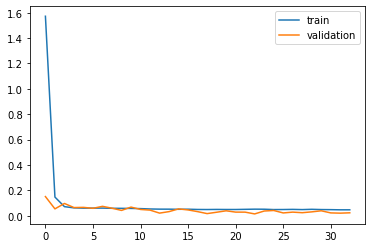


predict: [[31.22579933 23.00519107]]
real:      [[30.6 23.9]]

Train on 1760 samples, validate on 1 samples
Epoch 1/1000
 - 15s - loss: 1.4293 - mean_squared_error: 2.9890 - val_loss: 0.1669 - val_mean_squared_error: 0.0300
Epoch 2/1000
 - 1s - loss: 0.1447 - mean_squared_error: 0.0344 - val_loss: 0.1504 - val_mean_squared_error: 0.0242
Epoch 3/1000
 - 1s - loss: 0.0671 - mean_squared_error: 0.0069 - val_loss: 0.1113 - val_mean_squared_error: 0.0128
Epoch 4/1000
 - 1s - loss: 0.0633 - mean_squared_error: 0.0060 - val_loss: 0.1057 - val_mean_squared_error: 0.0124
Epoch 5/1000
 - 1s - loss: 0.0627 - mean_squared_error: 0.0059 - val_loss: 0.1031 - val_mean_squared_error: 0.0111
Epoch 6/1000
 - 1s - loss: 0.0617 - mean_squared_error: 0.0057 - val_loss: 0.0994 - val_mean_squared_error: 0.0114
Epoch 7/1000
 - 1s - loss: 0.0617 - mean_squared_error: 0.0058 - val_loss: 0.0873 - val_mean_squared_error: 0.0098
Epoch 8/1000
 - 1s - loss: 0.0606 - mean_squared_error: 0.0055 - val_loss: 0.0883 - v

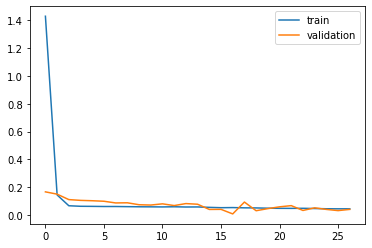


predict: [[31.168403   23.15148146]]
real:      [[30.2 23. ]]

Train on 1759 samples, validate on 1 samples
Epoch 1/1000
 - 15s - loss: 2.2092 - mean_squared_error: 5.6232 - val_loss: 0.8720 - val_mean_squared_error: 0.9453
Epoch 2/1000
 - 1s - loss: 0.2757 - mean_squared_error: 0.1559 - val_loss: 0.1997 - val_mean_squared_error: 0.0413
Epoch 3/1000
 - 1s - loss: 0.0731 - mean_squared_error: 0.0083 - val_loss: 0.1035 - val_mean_squared_error: 0.0110
Epoch 4/1000
 - 1s - loss: 0.0642 - mean_squared_error: 0.0063 - val_loss: 0.1224 - val_mean_squared_error: 0.0152
Epoch 5/1000
 - 1s - loss: 0.0627 - mean_squared_error: 0.0061 - val_loss: 0.1171 - val_mean_squared_error: 0.0140
Epoch 6/1000
 - 1s - loss: 0.0623 - mean_squared_error: 0.0060 - val_loss: 0.1204 - val_mean_squared_error: 0.0150
Epoch 7/1000
 - 1s - loss: 0.0617 - mean_squared_error: 0.0059 - val_loss: 0.1100 - val_mean_squared_error: 0.0123
Epoch 8/1000
 - 1s - loss: 0.0613 - mean_squared_error: 0.0058 - val_loss: 0.0919 - v

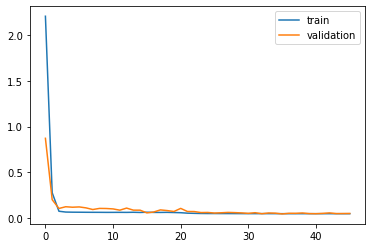


predict: [[30.94550422 23.88667652]]
real:      [[30.1 23.5]]

Train on 1758 samples, validate on 1 samples
Epoch 1/1000
 - 15s - loss: 2.9368 - mean_squared_error: 8.7575 - val_loss: 2.4152 - val_mean_squared_error: 5.9441
Epoch 2/1000
 - 1s - loss: 1.4990 - mean_squared_error: 2.7606 - val_loss: 0.4326 - val_mean_squared_error: 0.2569
Epoch 3/1000
 - 1s - loss: 0.1539 - mean_squared_error: 0.0404 - val_loss: 0.1153 - val_mean_squared_error: 0.0162
Epoch 4/1000
 - 1s - loss: 0.0689 - mean_squared_error: 0.0073 - val_loss: 0.0907 - val_mean_squared_error: 0.0124
Epoch 5/1000
 - 1s - loss: 0.0629 - mean_squared_error: 0.0059 - val_loss: 0.0840 - val_mean_squared_error: 0.0139
Epoch 6/1000
 - 1s - loss: 0.0625 - mean_squared_error: 0.0058 - val_loss: 0.0972 - val_mean_squared_error: 0.0142
Epoch 7/1000
 - 1s - loss: 0.0623 - mean_squared_error: 0.0057 - val_loss: 0.0832 - val_mean_squared_error: 0.0133
Epoch 8/1000
 - 1s - loss: 0.0617 - mean_squared_error: 0.0056 - val_loss: 0.1021 - v

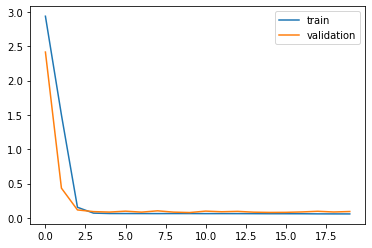


predict: [[30.16693501 23.27245145]]
real:      [[29.8 23.6]]

Train on 1757 samples, validate on 1 samples
Epoch 1/1000
 - 15s - loss: 1.7929 - mean_squared_error: 3.9004 - val_loss: 0.2592 - val_mean_squared_error: 0.0698
Epoch 2/1000
 - 1s - loss: 0.1638 - mean_squared_error: 0.0392 - val_loss: 0.0546 - val_mean_squared_error: 0.0032
Epoch 3/1000
 - 1s - loss: 0.0761 - mean_squared_error: 0.0089 - val_loss: 0.0782 - val_mean_squared_error: 0.0077
Epoch 4/1000
 - 1s - loss: 0.0657 - mean_squared_error: 0.0065 - val_loss: 0.1112 - val_mean_squared_error: 0.0131
Epoch 5/1000
 - 1s - loss: 0.0635 - mean_squared_error: 0.0060 - val_loss: 0.0890 - val_mean_squared_error: 0.0085
Epoch 6/1000
 - 1s - loss: 0.0617 - mean_squared_error: 0.0057 - val_loss: 0.0925 - val_mean_squared_error: 0.0091
Epoch 7/1000
 - 1s - loss: 0.0610 - mean_squared_error: 0.0056 - val_loss: 0.0946 - val_mean_squared_error: 0.0102
Epoch 8/1000
 - 1s - loss: 0.0601 - mean_squared_error: 0.0054 - val_loss: 0.1018 - v

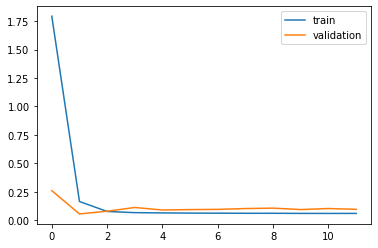


predict: [[30.43595403 21.82365741]]
real:      [[28.7 25.4]]

Train on 1756 samples, validate on 1 samples
Epoch 1/1000
 - 15s - loss: 2.6047 - mean_squared_error: 8.1533 - val_loss: 1.8689 - val_mean_squared_error: 6.2574
Epoch 2/1000
 - 1s - loss: 1.4918 - mean_squared_error: 4.2672 - val_loss: 1.1550 - val_mean_squared_error: 2.5289
Epoch 3/1000
 - 1s - loss: 1.0540 - mean_squared_error: 2.0832 - val_loss: 0.9840 - val_mean_squared_error: 1.9354
Epoch 4/1000
 - 1s - loss: 0.9249 - mean_squared_error: 1.5951 - val_loss: 0.8609 - val_mean_squared_error: 1.4635
Epoch 5/1000
 - 1s - loss: 0.7860 - mean_squared_error: 1.1400 - val_loss: 0.7098 - val_mean_squared_error: 1.0021
Epoch 6/1000
 - 1s - loss: 0.6278 - mean_squared_error: 0.7111 - val_loss: 0.5403 - val_mean_squared_error: 0.5641
Epoch 7/1000
 - 1s - loss: 0.4403 - mean_squared_error: 0.3359 - val_loss: 0.3392 - val_mean_squared_error: 0.2004
Epoch 8/1000
 - 1s - loss: 0.2111 - mean_squared_error: 0.0754 - val_loss: 0.0822 - v

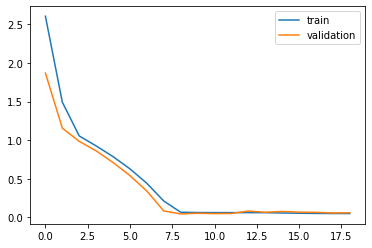


predict: [[29.8981186  22.61542366]]
real:      [[31.3 23.3]]

Train on 1755 samples, validate on 1 samples
Epoch 1/1000
 - 15s - loss: 2.2438 - mean_squared_error: 5.4419 - val_loss: 1.0990 - val_mean_squared_error: 1.2195
Epoch 2/1000
 - 1s - loss: 0.3353 - mean_squared_error: 0.1998 - val_loss: 0.2288 - val_mean_squared_error: 0.0542
Epoch 3/1000
 - 1s - loss: 0.0877 - mean_squared_error: 0.0119 - val_loss: 0.0535 - val_mean_squared_error: 0.0029
Epoch 4/1000
 - 1s - loss: 0.0663 - mean_squared_error: 0.0067 - val_loss: 0.1100 - val_mean_squared_error: 0.0121
Epoch 5/1000
 - 1s - loss: 0.0644 - mean_squared_error: 0.0062 - val_loss: 0.0809 - val_mean_squared_error: 0.0066
Epoch 6/1000
 - 1s - loss: 0.0629 - mean_squared_error: 0.0060 - val_loss: 0.1159 - val_mean_squared_error: 0.0136
Epoch 7/1000
 - 1s - loss: 0.0631 - mean_squared_error: 0.0060 - val_loss: 0.0788 - val_mean_squared_error: 0.0063
Epoch 8/1000
 - 1s - loss: 0.0624 - mean_squared_error: 0.0058 - val_loss: 0.0949 - v

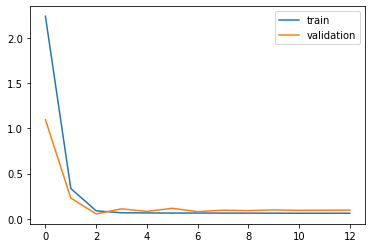


predict: [[29.53363809 23.69633339]]
real:      [[30.5 23.3]]

Train on 1754 samples, validate on 1 samples
Epoch 1/1000
 - 15s - loss: 2.2365 - mean_squared_error: 5.5729 - val_loss: 0.8112 - val_mean_squared_error: 0.7349
Epoch 2/1000
 - 1s - loss: 0.3631 - mean_squared_error: 0.2079 - val_loss: 0.1851 - val_mean_squared_error: 0.0343
Epoch 3/1000
 - 1s - loss: 0.0845 - mean_squared_error: 0.0109 - val_loss: 0.0863 - val_mean_squared_error: 0.0078
Epoch 4/1000
 - 1s - loss: 0.0623 - mean_squared_error: 0.0059 - val_loss: 0.0894 - val_mean_squared_error: 0.0093
Epoch 5/1000
 - 1s - loss: 0.0617 - mean_squared_error: 0.0057 - val_loss: 0.0879 - val_mean_squared_error: 0.0088
Epoch 6/1000
 - 1s - loss: 0.0612 - mean_squared_error: 0.0057 - val_loss: 0.0884 - val_mean_squared_error: 0.0089
Epoch 7/1000
 - 1s - loss: 0.0609 - mean_squared_error: 0.0057 - val_loss: 0.0755 - val_mean_squared_error: 0.0066
Epoch 8/1000
 - 1s - loss: 0.0599 - mean_squared_error: 0.0054 - val_loss: 0.0835 - v

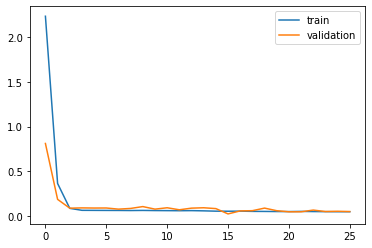


predict: [[30.73517962 23.76621743]]
real:      [[30.6 23.5]]

Train on 1753 samples, validate on 1 samples
Epoch 1/1000
 - 16s - loss: 2.2157 - mean_squared_error: 5.7997 - val_loss: 1.1873 - val_mean_squared_error: 2.3067
Epoch 2/1000
 - 1s - loss: 0.7231 - mean_squared_error: 0.9726 - val_loss: 0.1591 - val_mean_squared_error: 0.0277
Epoch 3/1000
 - 1s - loss: 0.1129 - mean_squared_error: 0.0194 - val_loss: 0.0761 - val_mean_squared_error: 0.0089
Epoch 4/1000
 - 1s - loss: 0.0705 - mean_squared_error: 0.0074 - val_loss: 0.0806 - val_mean_squared_error: 0.0065
Epoch 5/1000
 - 1s - loss: 0.0648 - mean_squared_error: 0.0062 - val_loss: 0.0840 - val_mean_squared_error: 0.0076
Epoch 6/1000
 - 1s - loss: 0.0625 - mean_squared_error: 0.0059 - val_loss: 0.0702 - val_mean_squared_error: 0.0052
Epoch 7/1000
 - 1s - loss: 0.0615 - mean_squared_error: 0.0056 - val_loss: 0.0904 - val_mean_squared_error: 0.0082
Epoch 8/1000
 - 1s - loss: 0.0609 - mean_squared_error: 0.0055 - val_loss: 0.0848 - v

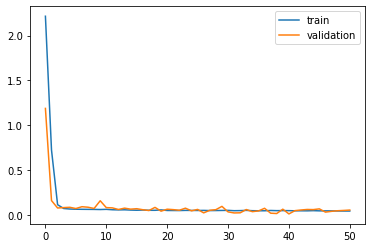


predict: [[30.27612044 23.68268275]]
real:      [[31.1 23.2]]

Train on 1752 samples, validate on 1 samples
Epoch 1/1000
 - 16s - loss: 1.4677 - mean_squared_error: 2.9588 - val_loss: 0.3611 - val_mean_squared_error: 0.1925
Epoch 2/1000
 - 1s - loss: 0.1512 - mean_squared_error: 0.0372 - val_loss: 0.1870 - val_mean_squared_error: 0.0369
Epoch 3/1000
 - 1s - loss: 0.0693 - mean_squared_error: 0.0075 - val_loss: 0.1497 - val_mean_squared_error: 0.0224
Epoch 4/1000
 - 1s - loss: 0.0636 - mean_squared_error: 0.0061 - val_loss: 0.1161 - val_mean_squared_error: 0.0135
Epoch 5/1000
 - 1s - loss: 0.0630 - mean_squared_error: 0.0060 - val_loss: 0.1305 - val_mean_squared_error: 0.0171
Epoch 6/1000
 - 1s - loss: 0.0625 - mean_squared_error: 0.0059 - val_loss: 0.1054 - val_mean_squared_error: 0.0112
Epoch 7/1000
 - 1s - loss: 0.0621 - mean_squared_error: 0.0059 - val_loss: 0.0897 - val_mean_squared_error: 0.0081
Epoch 8/1000
 - 1s - loss: 0.0613 - mean_squared_error: 0.0056 - val_loss: 0.0956 - v

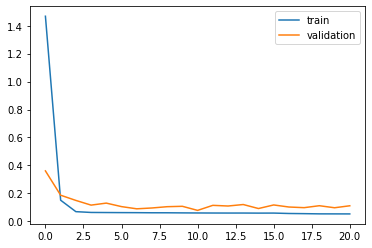


predict: [[29.17531316 23.88508047]]
real:      [[30.7 24.4]]

Train on 1751 samples, validate on 1 samples
Epoch 1/1000
 - 16s - loss: 1.6715 - mean_squared_error: 3.5188 - val_loss: 0.2823 - val_mean_squared_error: 0.0847
Epoch 2/1000
 - 1s - loss: 0.1639 - mean_squared_error: 0.0487 - val_loss: 0.0080 - val_mean_squared_error: 9.4658e-05
Epoch 3/1000
 - 1s - loss: 0.0652 - mean_squared_error: 0.0065 - val_loss: 0.0741 - val_mean_squared_error: 0.0061
Epoch 4/1000
 - 1s - loss: 0.0602 - mean_squared_error: 0.0055 - val_loss: 0.0797 - val_mean_squared_error: 0.0068
Epoch 5/1000
 - 1s - loss: 0.0598 - mean_squared_error: 0.0054 - val_loss: 0.0742 - val_mean_squared_error: 0.0059
Epoch 6/1000
 - 1s - loss: 0.0593 - mean_squared_error: 0.0053 - val_loss: 0.0648 - val_mean_squared_error: 0.0047
Epoch 7/1000
 - 1s - loss: 0.0596 - mean_squared_error: 0.0054 - val_loss: 0.0581 - val_mean_squared_error: 0.0036
Epoch 8/1000
 - 1s - loss: 0.0581 - mean_squared_error: 0.0052 - val_loss: 0.0781

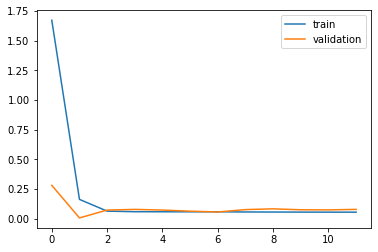


predict: [[32.60637132 24.09928489]]
real:      [[29.8 24.3]]

Train on 1750 samples, validate on 1 samples
Epoch 1/1000
 - 16s - loss: 2.2360 - mean_squared_error: 5.4025 - val_loss: 0.9792 - val_mean_squared_error: 0.9660
Epoch 2/1000
 - 1s - loss: 0.2804 - mean_squared_error: 0.1498 - val_loss: 0.1935 - val_mean_squared_error: 0.0376
Epoch 3/1000
 - 1s - loss: 0.0846 - mean_squared_error: 0.0110 - val_loss: 0.0448 - val_mean_squared_error: 0.0021
Epoch 4/1000
 - 1s - loss: 0.0659 - mean_squared_error: 0.0064 - val_loss: 0.0747 - val_mean_squared_error: 0.0056
Epoch 5/1000
 - 1s - loss: 0.0642 - mean_squared_error: 0.0061 - val_loss: 0.0687 - val_mean_squared_error: 0.0052
Epoch 6/1000
 - 1s - loss: 0.0628 - mean_squared_error: 0.0060 - val_loss: 0.0892 - val_mean_squared_error: 0.0092
Epoch 7/1000
 - 1s - loss: 0.0619 - mean_squared_error: 0.0059 - val_loss: 0.0568 - val_mean_squared_error: 0.0033
Epoch 8/1000
 - 1s - loss: 0.0615 - mean_squared_error: 0.0058 - val_loss: 0.0672 - v

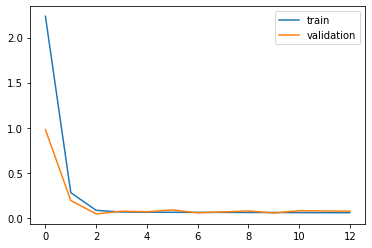


predict: [[30.84947653 22.79187054]]
real:      [[30.2 23.6]]

Train on 1749 samples, validate on 1 samples
Epoch 1/1000
 - 16s - loss: 1.5696 - mean_squared_error: 3.4161 - val_loss: 0.7606 - val_mean_squared_error: 1.0256
Epoch 2/1000
 - 1s - loss: 0.3931 - mean_squared_error: 0.3241 - val_loss: 0.1287 - val_mean_squared_error: 0.0166
Epoch 3/1000
 - 1s - loss: 0.0802 - mean_squared_error: 0.0100 - val_loss: 0.1852 - val_mean_squared_error: 0.0348
Epoch 4/1000
 - 1s - loss: 0.0650 - mean_squared_error: 0.0068 - val_loss: 0.1367 - val_mean_squared_error: 0.0189
Epoch 5/1000
 - 1s - loss: 0.0638 - mean_squared_error: 0.0065 - val_loss: 0.1236 - val_mean_squared_error: 0.0154
Epoch 6/1000
 - 1s - loss: 0.0611 - mean_squared_error: 0.0059 - val_loss: 0.1190 - val_mean_squared_error: 0.0142
Epoch 7/1000
 - 1s - loss: 0.0600 - mean_squared_error: 0.0057 - val_loss: 0.1130 - val_mean_squared_error: 0.0128
Epoch 8/1000
 - 1s - loss: 0.0610 - mean_squared_error: 0.0058 - val_loss: 0.0902 - v

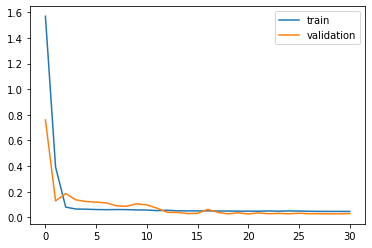


predict: [[29.59134118 23.14036501]]
real:      [[29.9 23.9]]

Train on 1748 samples, validate on 1 samples
Epoch 1/1000
 - 16s - loss: 2.7538 - mean_squared_error: 8.4858 - val_loss: 1.7871 - val_mean_squared_error: 4.3800
Epoch 2/1000
 - 1s - loss: 0.9022 - mean_squared_error: 1.6694 - val_loss: 0.0764 - val_mean_squared_error: 0.0066
Epoch 3/1000
 - 1s - loss: 0.1141 - mean_squared_error: 0.0232 - val_loss: 0.0868 - val_mean_squared_error: 0.0115
Epoch 4/1000
 - 1s - loss: 0.0652 - mean_squared_error: 0.0067 - val_loss: 0.1110 - val_mean_squared_error: 0.0124
Epoch 5/1000
 - 1s - loss: 0.0597 - mean_squared_error: 0.0056 - val_loss: 0.1098 - val_mean_squared_error: 0.0126
Epoch 6/1000
 - 1s - loss: 0.0599 - mean_squared_error: 0.0056 - val_loss: 0.1096 - val_mean_squared_error: 0.0121
Epoch 7/1000
 - 1s - loss: 0.0590 - mean_squared_error: 0.0055 - val_loss: 0.0822 - val_mean_squared_error: 0.0068
Epoch 8/1000
 - 1s - loss: 0.0581 - mean_squared_error: 0.0053 - val_loss: 0.1006 - v

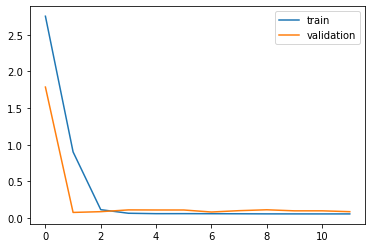


predict: [[31.99984539 25.25573635]]
real:      [[29.7 24. ]]

Train on 1747 samples, validate on 1 samples
Epoch 1/1000
 - 16s - loss: 1.1976 - mean_squared_error: 2.2203 - val_loss: 0.2300 - val_mean_squared_error: 0.0629
Epoch 2/1000
 - 1s - loss: 0.1249 - mean_squared_error: 0.0254 - val_loss: 0.0595 - val_mean_squared_error: 0.0041
Epoch 3/1000
 - 1s - loss: 0.0669 - mean_squared_error: 0.0068 - val_loss: 0.0712 - val_mean_squared_error: 0.0071
Epoch 4/1000
 - 1s - loss: 0.0618 - mean_squared_error: 0.0058 - val_loss: 0.1061 - val_mean_squared_error: 0.0134
Epoch 5/1000
 - 1s - loss: 0.0608 - mean_squared_error: 0.0056 - val_loss: 0.0783 - val_mean_squared_error: 0.0068
Epoch 6/1000
 - 1s - loss: 0.0593 - mean_squared_error: 0.0054 - val_loss: 0.0960 - val_mean_squared_error: 0.0103
Epoch 7/1000
 - 1s - loss: 0.0590 - mean_squared_error: 0.0054 - val_loss: 0.0741 - val_mean_squared_error: 0.0064
Epoch 8/1000
 - 1s - loss: 0.0575 - mean_squared_error: 0.0052 - val_loss: 0.0638 - v

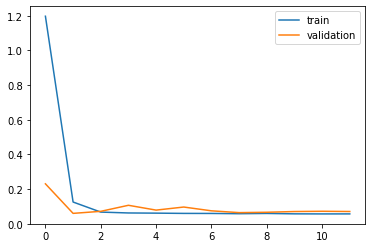


predict: [[31.09377299 21.90394193]]
real:      [[29.9 24.3]]

Train on 1746 samples, validate on 1 samples
Epoch 1/1000
 - 16s - loss: 0.6974 - mean_squared_error: 0.9767 - val_loss: 0.2647 - val_mean_squared_error: 0.0708
Epoch 2/1000
 - 1s - loss: 0.0923 - mean_squared_error: 0.0137 - val_loss: 0.0276 - val_mean_squared_error: 9.0675e-04
Epoch 3/1000
 - 1s - loss: 0.0654 - mean_squared_error: 0.0066 - val_loss: 0.0717 - val_mean_squared_error: 0.0052
Epoch 4/1000
 - 1s - loss: 0.0620 - mean_squared_error: 0.0058 - val_loss: 0.0802 - val_mean_squared_error: 0.0065
Epoch 5/1000
 - 1s - loss: 0.0606 - mean_squared_error: 0.0056 - val_loss: 0.0886 - val_mean_squared_error: 0.0079
Epoch 6/1000
 - 1s - loss: 0.0592 - mean_squared_error: 0.0054 - val_loss: 0.0786 - val_mean_squared_error: 0.0063
Epoch 7/1000
 - 1s - loss: 0.0561 - mean_squared_error: 0.0050 - val_loss: 0.0658 - val_mean_squared_error: 0.0049
Epoch 8/1000
 - 1s - loss: 0.0567 - mean_squared_error: 0.0051 - val_loss: 0.0626

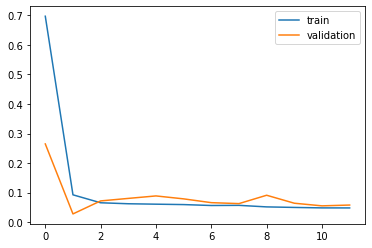


predict: [[32.10031216 25.52343619]]
real:      [[30.1 23.7]]

Train on 1745 samples, validate on 1 samples
Epoch 1/1000
 - 16s - loss: 2.4474 - mean_squared_error: 6.3144 - val_loss: 1.4845 - val_mean_squared_error: 2.2298
Epoch 2/1000
 - 1s - loss: 0.5422 - mean_squared_error: 0.4984 - val_loss: 0.1507 - val_mean_squared_error: 0.0372
Epoch 3/1000
 - 1s - loss: 0.0992 - mean_squared_error: 0.0150 - val_loss: 0.1456 - val_mean_squared_error: 0.0212
Epoch 4/1000
 - 1s - loss: 0.0659 - mean_squared_error: 0.0068 - val_loss: 0.1423 - val_mean_squared_error: 0.0210
Epoch 5/1000
 - 1s - loss: 0.0633 - mean_squared_error: 0.0063 - val_loss: 0.1479 - val_mean_squared_error: 0.0222
Epoch 6/1000
 - 1s - loss: 0.0624 - mean_squared_error: 0.0061 - val_loss: 0.1517 - val_mean_squared_error: 0.0238
Epoch 7/1000
 - 1s - loss: 0.0617 - mean_squared_error: 0.0060 - val_loss: 0.1263 - val_mean_squared_error: 0.0167
Epoch 8/1000
 - 1s - loss: 0.0614 - mean_squared_error: 0.0060 - val_loss: 0.1508 - v

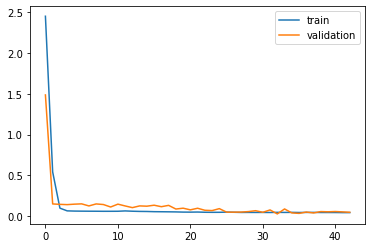


predict: [[30.34097981 23.50901208]]
real:      [[30.5 25.1]]

Train on 1744 samples, validate on 1 samples
Epoch 1/1000
 - 17s - loss: 2.9388 - mean_squared_error: 8.7622 - val_loss: 2.4072 - val_mean_squared_error: 5.8595
Epoch 2/1000
 - 1s - loss: 1.6880 - mean_squared_error: 3.1675 - val_loss: 0.5133 - val_mean_squared_error: 0.2809
Epoch 3/1000
 - 1s - loss: 0.1984 - mean_squared_error: 0.0630 - val_loss: 0.0706 - val_mean_squared_error: 0.0074
Epoch 4/1000
 - 1s - loss: 0.0753 - mean_squared_error: 0.0083 - val_loss: 0.0465 - val_mean_squared_error: 0.0023
Epoch 5/1000
 - 1s - loss: 0.0650 - mean_squared_error: 0.0061 - val_loss: 0.0393 - val_mean_squared_error: 0.0019
Epoch 6/1000
 - 1s - loss: 0.0621 - mean_squared_error: 0.0055 - val_loss: 0.0504 - val_mean_squared_error: 0.0032
Epoch 7/1000
 - 1s - loss: 0.0613 - mean_squared_error: 0.0055 - val_loss: 0.0409 - val_mean_squared_error: 0.0020
Epoch 8/1000
 - 1s - loss: 0.0615 - mean_squared_error: 0.0056 - val_loss: 0.0399 - v

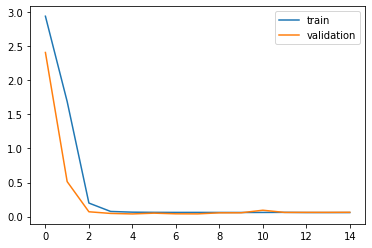


predict: [[29.16234453 22.67838162]]
real:      [[30.  24.2]]

Train on 1743 samples, validate on 1 samples
Epoch 1/1000
 - 17s - loss: 1.8509 - mean_squared_error: 4.2031 - val_loss: 0.8081 - val_mean_squared_error: 0.8350
Epoch 2/1000
 - 1s - loss: 0.2829 - mean_squared_error: 0.1571 - val_loss: 0.0638 - val_mean_squared_error: 0.0047
Epoch 3/1000
 - 1s - loss: 0.0714 - mean_squared_error: 0.0079 - val_loss: 0.0572 - val_mean_squared_error: 0.0063
Epoch 4/1000
 - 1s - loss: 0.0602 - mean_squared_error: 0.0056 - val_loss: 0.0463 - val_mean_squared_error: 0.0028
Epoch 5/1000
 - 1s - loss: 0.0579 - mean_squared_error: 0.0051 - val_loss: 0.0269 - val_mean_squared_error: 0.0012
Epoch 6/1000
 - 1s - loss: 0.0577 - mean_squared_error: 0.0051 - val_loss: 0.0407 - val_mean_squared_error: 0.0029
Epoch 7/1000
 - 1s - loss: 0.0573 - mean_squared_error: 0.0050 - val_loss: 0.0671 - val_mean_squared_error: 0.0048
Epoch 8/1000
 - 1s - loss: 0.0557 - mean_squared_error: 0.0048 - val_loss: 0.0428 - v

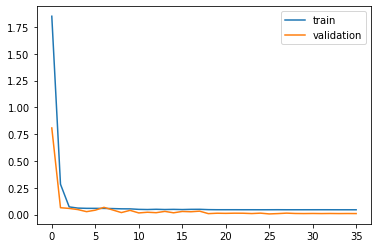


predict: [[30.01995268 22.55300934]]
real:      [[30.  23.2]]

Train on 1742 samples, validate on 1 samples
Epoch 1/1000
 - 16s - loss: 2.7462 - mean_squared_error: 7.8589 - val_loss: 1.8148 - val_mean_squared_error: 3.5426
Epoch 2/1000
 - 1s - loss: 0.7898 - mean_squared_error: 1.2126 - val_loss: 0.1895 - val_mean_squared_error: 0.0430
Epoch 3/1000
 - 1s - loss: 0.1143 - mean_squared_error: 0.0204 - val_loss: 0.0658 - val_mean_squared_error: 0.0052
Epoch 4/1000
 - 1s - loss: 0.0689 - mean_squared_error: 0.0070 - val_loss: 0.0751 - val_mean_squared_error: 0.0082
Epoch 5/1000
 - 1s - loss: 0.0636 - mean_squared_error: 0.0059 - val_loss: 0.0598 - val_mean_squared_error: 0.0042
Epoch 6/1000
 - 1s - loss: 0.0614 - mean_squared_error: 0.0055 - val_loss: 0.0729 - val_mean_squared_error: 0.0071
Epoch 7/1000
 - 1s - loss: 0.0596 - mean_squared_error: 0.0052 - val_loss: 0.0815 - val_mean_squared_error: 0.0069
Epoch 8/1000
 - 1s - loss: 0.0603 - mean_squared_error: 0.0054 - val_loss: 0.0831 - v

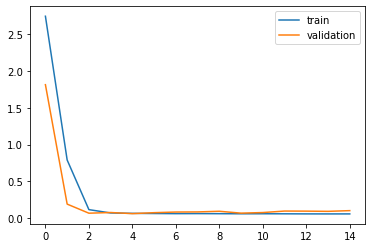


predict: [[29.97908123 22.45743745]]
real:      [[28.8 22.8]]

Train on 1741 samples, validate on 1 samples
Epoch 1/1000
 - 17s - loss: 2.2188 - mean_squared_error: 5.5025 - val_loss: 0.9253 - val_mean_squared_error: 1.0073
Epoch 2/1000
 - 1s - loss: 0.3074 - mean_squared_error: 0.1851 - val_loss: 0.1777 - val_mean_squared_error: 0.0327
Epoch 3/1000
 - 1s - loss: 0.0787 - mean_squared_error: 0.0094 - val_loss: 0.0630 - val_mean_squared_error: 0.0040
Epoch 4/1000
 - 1s - loss: 0.0636 - mean_squared_error: 0.0059 - val_loss: 0.1028 - val_mean_squared_error: 0.0110
Epoch 5/1000
 - 1s - loss: 0.0613 - mean_squared_error: 0.0055 - val_loss: 0.1191 - val_mean_squared_error: 0.0144
Epoch 6/1000
 - 1s - loss: 0.0593 - mean_squared_error: 0.0054 - val_loss: 0.1131 - val_mean_squared_error: 0.0132
Epoch 7/1000
 - 1s - loss: 0.0577 - mean_squared_error: 0.0051 - val_loss: 0.1230 - val_mean_squared_error: 0.0152
Epoch 8/1000
 - 1s - loss: 0.0540 - mean_squared_error: 0.0047 - val_loss: 0.1004 - v

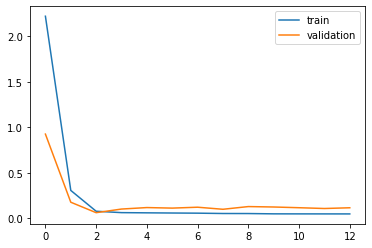


predict: [[28.9754926  23.87711957]]
real:      [[31.3 23.8]]

Train on 1740 samples, validate on 1 samples
Epoch 1/1000
 - 17s - loss: 1.7224 - mean_squared_error: 4.0843 - val_loss: 0.6845 - val_mean_squared_error: 0.9228
Epoch 2/1000
 - 1s - loss: 0.2744 - mean_squared_error: 0.1829 - val_loss: 0.0785 - val_mean_squared_error: 0.0100
Epoch 3/1000
 - 1s - loss: 0.0730 - mean_squared_error: 0.0083 - val_loss: 0.0967 - val_mean_squared_error: 0.0111
Epoch 4/1000
 - 1s - loss: 0.0611 - mean_squared_error: 0.0056 - val_loss: 0.1137 - val_mean_squared_error: 0.0131
Epoch 5/1000
 - 1s - loss: 0.0617 - mean_squared_error: 0.0058 - val_loss: 0.0962 - val_mean_squared_error: 0.0101
Epoch 6/1000
 - 1s - loss: 0.0594 - mean_squared_error: 0.0054 - val_loss: 0.1047 - val_mean_squared_error: 0.0114
Epoch 7/1000
 - 1s - loss: 0.0590 - mean_squared_error: 0.0053 - val_loss: 0.0708 - val_mean_squared_error: 0.0057
Epoch 8/1000
 - 1s - loss: 0.0611 - mean_squared_error: 0.0057 - val_loss: 0.1521 - v

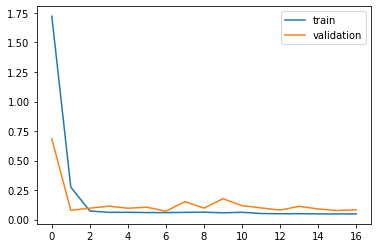


predict: [[29.7211345  23.26141814]]
real:      [[30.8 24.8]]

Train on 1739 samples, validate on 1 samples
Epoch 1/1000
 - 17s - loss: 2.3668 - mean_squared_error: 6.2382 - val_loss: 1.2933 - val_mean_squared_error: 3.3247
Epoch 2/1000
 - 1s - loss: 0.7884 - mean_squared_error: 1.2273 - val_loss: 0.1663 - val_mean_squared_error: 0.0448
Epoch 3/1000
 - 1s - loss: 0.0972 - mean_squared_error: 0.0144 - val_loss: 0.1400 - val_mean_squared_error: 0.0242
Epoch 4/1000
 - 1s - loss: 0.0661 - mean_squared_error: 0.0065 - val_loss: 0.1327 - val_mean_squared_error: 0.0188
Epoch 5/1000
 - 1s - loss: 0.0625 - mean_squared_error: 0.0058 - val_loss: 0.1307 - val_mean_squared_error: 0.0181
Epoch 6/1000
 - 1s - loss: 0.0607 - mean_squared_error: 0.0055 - val_loss: 0.1180 - val_mean_squared_error: 0.0149
Epoch 7/1000
 - 1s - loss: 0.0614 - mean_squared_error: 0.0057 - val_loss: 0.1280 - val_mean_squared_error: 0.0170
Epoch 8/1000
 - 1s - loss: 0.0602 - mean_squared_error: 0.0054 - val_loss: 0.1273 - v

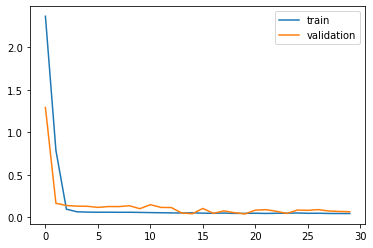


predict: [[31.08536482 23.82055319]]
real:      [[30.9 24.8]]

Train on 1738 samples, validate on 1 samples
Epoch 1/1000
 - 17s - loss: 2.6673 - mean_squared_error: 7.3005 - val_loss: 1.8678 - val_mean_squared_error: 3.5630
Epoch 2/1000
 - 1s - loss: 0.9787 - mean_squared_error: 1.4302 - val_loss: 0.1617 - val_mean_squared_error: 0.0274
Epoch 3/1000
 - 1s - loss: 0.1207 - mean_squared_error: 0.0218 - val_loss: 0.0224 - val_mean_squared_error: 6.3239e-04
Epoch 4/1000
 - 1s - loss: 0.0650 - mean_squared_error: 0.0064 - val_loss: 0.0235 - val_mean_squared_error: 5.8803e-04
Epoch 5/1000
 - 1s - loss: 0.0615 - mean_squared_error: 0.0056 - val_loss: 0.0297 - val_mean_squared_error: 9.8304e-04
Epoch 6/1000
 - 1s - loss: 0.0607 - mean_squared_error: 0.0055 - val_loss: 0.0156 - val_mean_squared_error: 3.7335e-04
Epoch 7/1000
 - 1s - loss: 0.0608 - mean_squared_error: 0.0055 - val_loss: 0.0265 - val_mean_squared_error: 8.3459e-04
Epoch 8/1000
 - 1s - loss: 0.0610 - mean_squared_error: 0.0055 - 

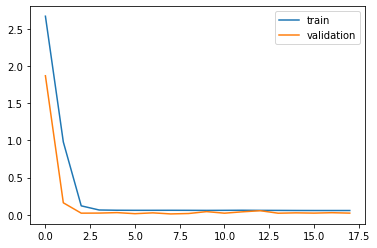


predict: [[28.91380141 22.4194994 ]]
real:      [[29.9 25.6]]

Train on 1737 samples, validate on 1 samples
Epoch 1/1000
 - 17s - loss: 1.9711 - mean_squared_error: 4.6195 - val_loss: 0.4845 - val_mean_squared_error: 0.3956
Epoch 2/1000
 - 1s - loss: 0.1855 - mean_squared_error: 0.0610 - val_loss: 0.2269 - val_mean_squared_error: 0.0522
Epoch 3/1000
 - 1s - loss: 0.0705 - mean_squared_error: 0.0077 - val_loss: 0.1453 - val_mean_squared_error: 0.0214
Epoch 4/1000
 - 1s - loss: 0.0612 - mean_squared_error: 0.0058 - val_loss: 0.1479 - val_mean_squared_error: 0.0225
Epoch 5/1000
 - 1s - loss: 0.0603 - mean_squared_error: 0.0056 - val_loss: 0.1493 - val_mean_squared_error: 0.0229
Epoch 6/1000
 - 1s - loss: 0.0601 - mean_squared_error: 0.0056 - val_loss: 0.1530 - val_mean_squared_error: 0.0249
Epoch 7/1000
 - 1s - loss: 0.0595 - mean_squared_error: 0.0055 - val_loss: 0.1396 - val_mean_squared_error: 0.0198
Epoch 8/1000
 - 1s - loss: 0.0596 - mean_squared_error: 0.0055 - val_loss: 0.1450 - v

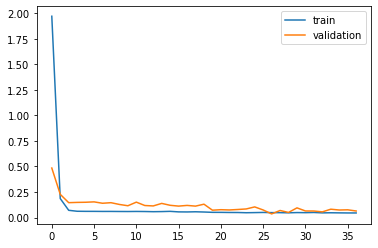


predict: [[31.09822662 23.32381328]]
real:      [[28.9 23.3]]

Train on 1736 samples, validate on 1 samples
Epoch 1/1000
 - 17s - loss: 3.0589 - mean_squared_error: 9.4467 - val_loss: 2.4860 - val_mean_squared_error: 6.3089
Epoch 2/1000
 - 1s - loss: 1.4631 - mean_squared_error: 2.7557 - val_loss: 0.6454 - val_mean_squared_error: 0.5973
Epoch 3/1000
 - 1s - loss: 0.2219 - mean_squared_error: 0.0999 - val_loss: 0.1517 - val_mean_squared_error: 0.0232
Epoch 4/1000
 - 1s - loss: 0.0748 - mean_squared_error: 0.0088 - val_loss: 0.0506 - val_mean_squared_error: 0.0040
Epoch 5/1000
 - 1s - loss: 0.0631 - mean_squared_error: 0.0058 - val_loss: 0.0679 - val_mean_squared_error: 0.0051
Epoch 6/1000
 - 1s - loss: 0.0612 - mean_squared_error: 0.0056 - val_loss: 0.0658 - val_mean_squared_error: 0.0050
Epoch 7/1000
 - 1s - loss: 0.0590 - mean_squared_error: 0.0051 - val_loss: 0.0652 - val_mean_squared_error: 0.0043
Epoch 8/1000
 - 1s - loss: 0.0591 - mean_squared_error: 0.0053 - val_loss: 0.0714 - v

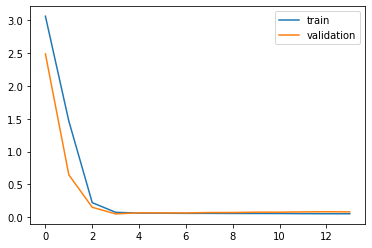


predict: [[30.02632106 22.70096255]]
real:      [[31.3 24.1]]

Train on 1735 samples, validate on 1 samples
Epoch 1/1000
 - 17s - loss: 1.9099 - mean_squared_error: 4.8929 - val_loss: 0.5971 - val_mean_squared_error: 0.6704
Epoch 2/1000
 - 1s - loss: 0.1920 - mean_squared_error: 0.0868 - val_loss: 0.1834 - val_mean_squared_error: 0.0420
Epoch 3/1000
 - 1s - loss: 0.0720 - mean_squared_error: 0.0083 - val_loss: 0.1194 - val_mean_squared_error: 0.0145
Epoch 4/1000
 - 1s - loss: 0.0615 - mean_squared_error: 0.0060 - val_loss: 0.1185 - val_mean_squared_error: 0.0149
Epoch 5/1000
 - 1s - loss: 0.0608 - mean_squared_error: 0.0058 - val_loss: 0.1260 - val_mean_squared_error: 0.0161
Epoch 6/1000
 - 1s - loss: 0.0588 - mean_squared_error: 0.0054 - val_loss: 0.1193 - val_mean_squared_error: 0.0151
Epoch 7/1000
 - 1s - loss: 0.0579 - mean_squared_error: 0.0052 - val_loss: 0.1446 - val_mean_squared_error: 0.0213
Epoch 8/1000
 - 1s - loss: 0.0587 - mean_squared_error: 0.0054 - val_loss: 0.1272 - v

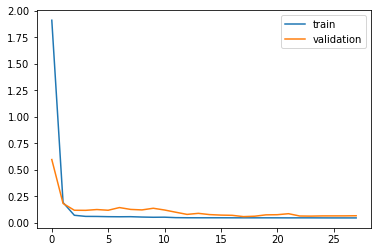


predict: [[30.40111449 23.59779355]]
real:      [[30.1 24. ]]

Train and validation time: 26.44 minutes

Maximum temperatures metrics
Test MEAN-SQUARED-ERROR ------------ 1.582
Test STANDART-DEVIATION ------------ 0.734
Test MEAN-ABSOLUTE-ERROR ----------- 1.021
Test MEDIAN-ABSOLUTE-ERROR --------- 0.9448

Errors
2018-12-31 = 0.16986402820186797
2018-12-30 = 0.35328220736230165
2018-12-29 = 0.9233221178641529
2018-12-28 = 0.6257993263091635
2018-12-27 = 0.9684029950880699
2018-12-26 = 0.8455042189618993
2018-12-25 = 0.3669350110088381
2018-12-24 = 1.735954025005718
2018-12-23 = 1.401881399529536
2018-12-22 = 0.9663619051849182
2018-12-21 = 0.13517962029033015
2018-12-20 = 0.8238795551304072
2018-12-19 = 1.5246868379175709
2018-12-18 = 2.806371317553346
2018-12-17 = 0.649476533133484
2018-12-16 = 0.30865881939379136
2018-12-15 = 2.299845389265709
2018-12-14 = 1.1937729924675509
2018-12-13 = 2.000312160364956
2018-12-12 = 0.1590201899611543
2018-12-11 = 0.8376554728971044
2018-12-10 = 0

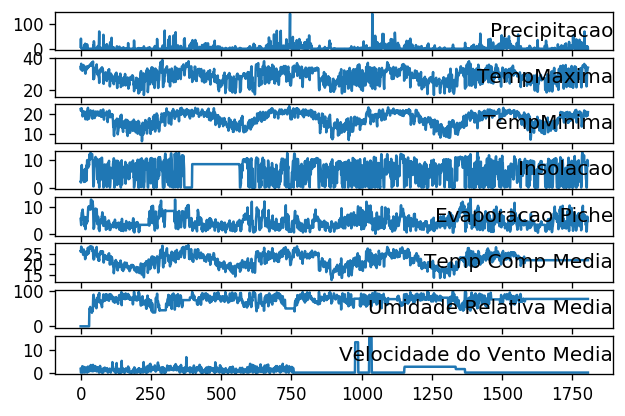

Train on 1744 samples, validate on 1 samples
Epoch 1/1000
 - 17s - loss: 1.4163 - mean_squared_error: 2.6964 - val_loss: 0.1747 - val_mean_squared_error: 0.0316
Epoch 2/1000
 - 1s - loss: 0.1785 - mean_squared_error: 0.0513 - val_loss: 0.0262 - val_mean_squared_error: 0.0011
Epoch 3/1000
 - 1s - loss: 0.1311 - mean_squared_error: 0.0296 - val_loss: 0.0634 - val_mean_squared_error: 0.0056
Epoch 4/1000
 - 1s - loss: 0.1256 - mean_squared_error: 0.0269 - val_loss: 0.0552 - val_mean_squared_error: 0.0031
Epoch 5/1000
 - 1s - loss: 0.1271 - mean_squared_error: 0.0278 - val_loss: 0.0547 - val_mean_squared_error: 0.0050
Epoch 6/1000
 - 1s - loss: 0.1240 - mean_squared_error: 0.0269 - val_loss: 0.0733 - val_mean_squared_error: 0.0073
Epoch 7/1000
 - 1s - loss: 0.1202 - mean_squared_error: 0.0252 - val_loss: 0.0710 - val_mean_squared_error: 0.0080
Epoch 8/1000
 - 1s - loss: 0.1097 - mean_squared_error: 0.0211 - val_loss: 0.0540 - val_mean_squared_error: 0.0029
Epoch 9/1000
 - 1s - loss: 0.1078 

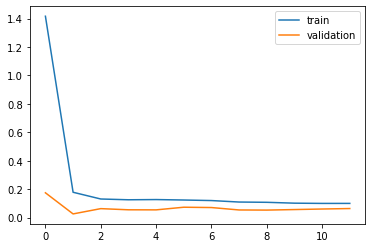


predict: [[31.40156982 18.59804883]]
real:      [[34.2 20.7]]

Train on 1743 samples, validate on 1 samples
Epoch 1/1000
 - 17s - loss: 0.9619 - mean_squared_error: 1.5225 - val_loss: 0.1775 - val_mean_squared_error: 0.0378
Epoch 2/1000
 - 1s - loss: 0.1709 - mean_squared_error: 0.0461 - val_loss: 0.0770 - val_mean_squared_error: 0.0060
Epoch 3/1000
 - 1s - loss: 0.1363 - mean_squared_error: 0.0313 - val_loss: 0.0906 - val_mean_squared_error: 0.0087
Epoch 4/1000
 - 1s - loss: 0.1330 - mean_squared_error: 0.0294 - val_loss: 0.0582 - val_mean_squared_error: 0.0036
Epoch 5/1000
 - 1s - loss: 0.1283 - mean_squared_error: 0.0280 - val_loss: 0.0547 - val_mean_squared_error: 0.0035
Epoch 6/1000
 - 1s - loss: 0.1266 - mean_squared_error: 0.0271 - val_loss: 0.0858 - val_mean_squared_error: 0.0075
Epoch 7/1000
 - 1s - loss: 0.1248 - mean_squared_error: 0.0264 - val_loss: 0.0665 - val_mean_squared_error: 0.0050
Epoch 8/1000
 - 1s - loss: 0.1231 - mean_squared_error: 0.0257 - val_loss: 0.0438 - v

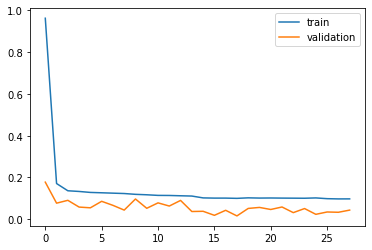


predict: [[31.88982526 18.83438844]]
real:      [[33.7 19. ]]

Train on 1742 samples, validate on 1 samples
Epoch 1/1000
 - 17s - loss: 2.6574 - mean_squared_error: 7.2753 - val_loss: 1.9253 - val_mean_squared_error: 3.9711
Epoch 2/1000
 - 1s - loss: 1.0364 - mean_squared_error: 1.5610 - val_loss: 0.7213 - val_mean_squared_error: 0.6536
Epoch 3/1000
 - 1s - loss: 0.2289 - mean_squared_error: 0.0966 - val_loss: 0.1079 - val_mean_squared_error: 0.0223
Epoch 4/1000
 - 1s - loss: 0.1340 - mean_squared_error: 0.0305 - val_loss: 0.0686 - val_mean_squared_error: 0.0048
Epoch 5/1000
 - 1s - loss: 0.1273 - mean_squared_error: 0.0282 - val_loss: 0.0695 - val_mean_squared_error: 0.0048
Epoch 6/1000
 - 1s - loss: 0.1237 - mean_squared_error: 0.0262 - val_loss: 0.0183 - val_mean_squared_error: 6.4097e-04
Epoch 7/1000
 - 1s - loss: 0.1179 - mean_squared_error: 0.0246 - val_loss: 0.0207 - val_mean_squared_error: 7.7722e-04
Epoch 8/1000
 - 1s - loss: 0.1154 - mean_squared_error: 0.0235 - val_loss: 0.

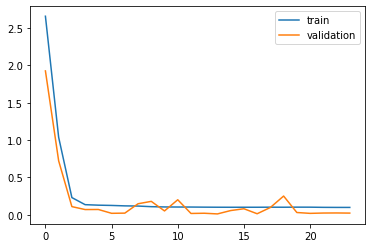


predict: [[31.9054101 20.0319544]]
real:      [[32.2 19.3]]

Train on 1741 samples, validate on 1 samples
Epoch 1/1000
 - 17s - loss: 2.0289 - mean_squared_error: 5.3295 - val_loss: 0.9894 - val_mean_squared_error: 1.7922
Epoch 2/1000
 - 1s - loss: 0.6596 - mean_squared_error: 0.8289 - val_loss: 0.1540 - val_mean_squared_error: 0.0294
Epoch 3/1000
 - 1s - loss: 0.2144 - mean_squared_error: 0.0726 - val_loss: 0.1139 - val_mean_squared_error: 0.0221
Epoch 4/1000
 - 1s - loss: 0.1323 - mean_squared_error: 0.0300 - val_loss: 0.1591 - val_mean_squared_error: 0.0321
Epoch 5/1000
 - 1s - loss: 0.1260 - mean_squared_error: 0.0272 - val_loss: 0.1463 - val_mean_squared_error: 0.0381
Epoch 6/1000
 - 1s - loss: 0.1216 - mean_squared_error: 0.0261 - val_loss: 0.1446 - val_mean_squared_error: 0.0351
Epoch 7/1000
 - 1s - loss: 0.1173 - mean_squared_error: 0.0249 - val_loss: 0.1457 - val_mean_squared_error: 0.0283
Epoch 8/1000
 - 1s - loss: 0.1103 - mean_squared_error: 0.0226 - val_loss: 0.1472 - val

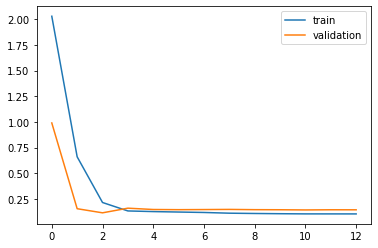


predict: [[27.93793351 18.99883246]]
real:      [[32.  19.7]]

Train on 1740 samples, validate on 1 samples
Epoch 1/1000
 - 17s - loss: 1.7935 - mean_squared_error: 3.9188 - val_loss: 0.7645 - val_mean_squared_error: 0.6619
Epoch 2/1000
 - 1s - loss: 0.2325 - mean_squared_error: 0.1062 - val_loss: 0.2572 - val_mean_squared_error: 0.0668
Epoch 3/1000
 - 1s - loss: 0.1406 - mean_squared_error: 0.0342 - val_loss: 0.2084 - val_mean_squared_error: 0.0489
Epoch 4/1000
 - 1s - loss: 0.1319 - mean_squared_error: 0.0297 - val_loss: 0.1747 - val_mean_squared_error: 0.0401
Epoch 5/1000
 - 1s - loss: 0.1294 - mean_squared_error: 0.0287 - val_loss: 0.1955 - val_mean_squared_error: 0.0566
Epoch 6/1000
 - 1s - loss: 0.1265 - mean_squared_error: 0.0278 - val_loss: 0.1704 - val_mean_squared_error: 0.0421
Epoch 7/1000
 - 1s - loss: 0.1253 - mean_squared_error: 0.0272 - val_loss: 0.1764 - val_mean_squared_error: 0.0447
Epoch 8/1000
 - 1s - loss: 0.1228 - mean_squared_error: 0.0264 - val_loss: 0.1658 - v

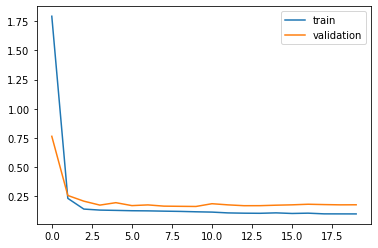


predict: [[28.63590365 16.48255752]]
real:      [[23.2 19.3]]

Train on 1739 samples, validate on 1 samples
Epoch 1/1000
 - 18s - loss: 2.2614 - mean_squared_error: 5.8803 - val_loss: 0.9734 - val_mean_squared_error: 1.1005
Epoch 2/1000
 - 1s - loss: 0.3612 - mean_squared_error: 0.2564 - val_loss: 0.0433 - val_mean_squared_error: 0.0032
Epoch 3/1000
 - 1s - loss: 0.1410 - mean_squared_error: 0.0327 - val_loss: 0.0606 - val_mean_squared_error: 0.0062
Epoch 4/1000
 - 1s - loss: 0.1311 - mean_squared_error: 0.0292 - val_loss: 0.0583 - val_mean_squared_error: 0.0037
Epoch 5/1000
 - 1s - loss: 0.1287 - mean_squared_error: 0.0284 - val_loss: 0.0638 - val_mean_squared_error: 0.0059
Epoch 6/1000
 - 1s - loss: 0.1279 - mean_squared_error: 0.0279 - val_loss: 0.0536 - val_mean_squared_error: 0.0036
Epoch 7/1000
 - 1s - loss: 0.1261 - mean_squared_error: 0.0272 - val_loss: 0.0510 - val_mean_squared_error: 0.0026
Epoch 8/1000
 - 1s - loss: 0.1256 - mean_squared_error: 0.0269 - val_loss: 0.0610 - v

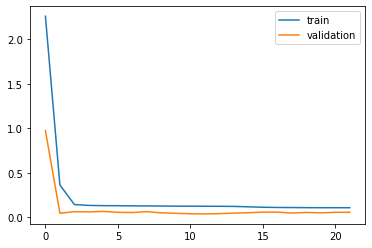


predict: [[29.42017556 18.45403557]]
real:      [[22.4 20.1]]

Train on 1738 samples, validate on 1 samples
Epoch 1/1000
 - 18s - loss: 2.2367 - mean_squared_error: 5.3149 - val_loss: 1.3291 - val_mean_squared_error: 1.9090
Epoch 2/1000
 - 1s - loss: 0.4977 - mean_squared_error: 0.4415 - val_loss: 0.1133 - val_mean_squared_error: 0.0189
Epoch 3/1000
 - 1s - loss: 0.1573 - mean_squared_error: 0.0397 - val_loss: 0.0861 - val_mean_squared_error: 0.0075
Epoch 4/1000
 - 1s - loss: 0.1387 - mean_squared_error: 0.0327 - val_loss: 0.0346 - val_mean_squared_error: 0.0015
Epoch 5/1000
 - 1s - loss: 0.1327 - mean_squared_error: 0.0306 - val_loss: 0.0450 - val_mean_squared_error: 0.0029
Epoch 6/1000
 - 1s - loss: 0.1302 - mean_squared_error: 0.0295 - val_loss: 0.0625 - val_mean_squared_error: 0.0049
Epoch 7/1000
 - 1s - loss: 0.1288 - mean_squared_error: 0.0286 - val_loss: 0.0334 - val_mean_squared_error: 0.0015
Epoch 8/1000
 - 1s - loss: 0.1283 - mean_squared_error: 0.0285 - val_loss: 0.0387 - v

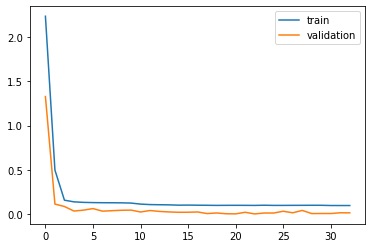


predict: [[30.22566368 19.40296663]]
real:      [[28.2 18.6]]

Train on 1737 samples, validate on 1 samples
Epoch 1/1000
 - 18s - loss: 1.9408 - mean_squared_error: 5.8336 - val_loss: 1.5031 - val_mean_squared_error: 3.9057
Epoch 2/1000
 - 1s - loss: 0.9511 - mean_squared_error: 1.7591 - val_loss: 0.3896 - val_mean_squared_error: 0.2952
Epoch 3/1000
 - 1s - loss: 0.1858 - mean_squared_error: 0.0648 - val_loss: 0.1396 - val_mean_squared_error: 0.0262
Epoch 4/1000
 - 1s - loss: 0.1375 - mean_squared_error: 0.0311 - val_loss: 0.0812 - val_mean_squared_error: 0.0068
Epoch 5/1000
 - 1s - loss: 0.1230 - mean_squared_error: 0.0261 - val_loss: 0.1362 - val_mean_squared_error: 0.0186
Epoch 6/1000
 - 1s - loss: 0.1106 - mean_squared_error: 0.0216 - val_loss: 0.0108 - val_mean_squared_error: 1.4770e-04
Epoch 7/1000
 - 1s - loss: 0.1050 - mean_squared_error: 0.0199 - val_loss: 0.0071 - val_mean_squared_error: 6.3337e-05
Epoch 8/1000
 - 1s - loss: 0.1048 - mean_squared_error: 0.0198 - val_loss: 0.

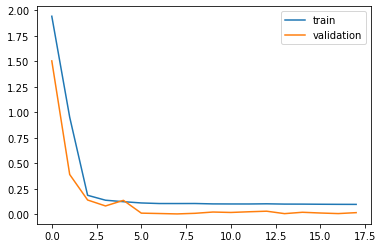


predict: [[30.54221625 19.49828364]]
real:      [[30.8 20.1]]

Train on 1736 samples, validate on 1 samples
Epoch 1/1000
 - 18s - loss: 2.4346 - mean_squared_error: 6.5840 - val_loss: 1.7470 - val_mean_squared_error: 3.9904
Epoch 2/1000
 - 1s - loss: 0.8941 - mean_squared_error: 1.5211 - val_loss: 0.2533 - val_mean_squared_error: 0.0694
Epoch 3/1000
 - 1s - loss: 0.1649 - mean_squared_error: 0.0446 - val_loss: 0.2027 - val_mean_squared_error: 0.0450
Epoch 4/1000
 - 1s - loss: 0.1275 - mean_squared_error: 0.0283 - val_loss: 0.1753 - val_mean_squared_error: 0.0409
Epoch 5/1000
 - 1s - loss: 0.1213 - mean_squared_error: 0.0254 - val_loss: 0.1500 - val_mean_squared_error: 0.0266
Epoch 6/1000
 - 1s - loss: 0.1175 - mean_squared_error: 0.0237 - val_loss: 0.1222 - val_mean_squared_error: 0.0165
Epoch 7/1000
 - 1s - loss: 0.1078 - mean_squared_error: 0.0202 - val_loss: 0.0986 - val_mean_squared_error: 0.0121
Epoch 8/1000
 - 1s - loss: 0.1052 - mean_squared_error: 0.0191 - val_loss: 0.0965 - v

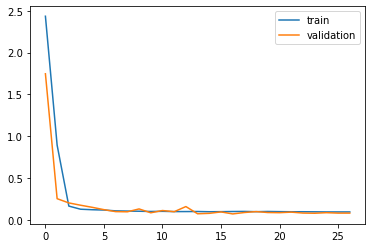


predict: [[31.859704   19.96888765]]
real:      [[32.2 20.3]]

Train on 1735 samples, validate on 1 samples
Epoch 1/1000
 - 18s - loss: 1.5389 - mean_squared_error: 3.1662 - val_loss: 0.8723 - val_mean_squared_error: 1.0006
Epoch 2/1000
 - 1s - loss: 0.5181 - mean_squared_error: 0.4283 - val_loss: 0.1523 - val_mean_squared_error: 0.0315
Epoch 3/1000
 - 1s - loss: 0.1455 - mean_squared_error: 0.0350 - val_loss: 0.0831 - val_mean_squared_error: 0.0096
Epoch 4/1000
 - 1s - loss: 0.1297 - mean_squared_error: 0.0291 - val_loss: 0.0822 - val_mean_squared_error: 0.0068
Epoch 5/1000
 - 1s - loss: 0.1231 - mean_squared_error: 0.0267 - val_loss: 0.1770 - val_mean_squared_error: 0.0314
Epoch 6/1000
 - 1s - loss: 0.1259 - mean_squared_error: 0.0266 - val_loss: 0.0813 - val_mean_squared_error: 0.0078
Epoch 7/1000
 - 1s - loss: 0.1092 - mean_squared_error: 0.0215 - val_loss: 0.0718 - val_mean_squared_error: 0.0063
Epoch 8/1000
 - 1s - loss: 0.1051 - mean_squared_error: 0.0191 - val_loss: 0.0399 - v

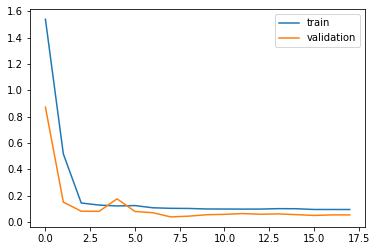


predict: [[31.88366238 20.22053933]]
real:      [[35.7 21.1]]

Train on 1734 samples, validate on 1 samples
Epoch 1/1000
 - 18s - loss: 1.9194 - mean_squared_error: 4.8792 - val_loss: 1.3548 - val_mean_squared_error: 3.0862
Epoch 2/1000
 - 1s - loss: 0.9204 - mean_squared_error: 1.4864 - val_loss: 0.4335 - val_mean_squared_error: 0.3084
Epoch 3/1000
 - 1s - loss: 0.1857 - mean_squared_error: 0.0595 - val_loss: 0.0989 - val_mean_squared_error: 0.0189
Epoch 4/1000
 - 1s - loss: 0.1350 - mean_squared_error: 0.0309 - val_loss: 0.1059 - val_mean_squared_error: 0.0125
Epoch 5/1000
 - 1s - loss: 0.1283 - mean_squared_error: 0.0284 - val_loss: 0.0901 - val_mean_squared_error: 0.0130
Epoch 6/1000
 - 1s - loss: 0.1238 - mean_squared_error: 0.0261 - val_loss: 0.0941 - val_mean_squared_error: 0.0097
Epoch 7/1000
 - 1s - loss: 0.1147 - mean_squared_error: 0.0226 - val_loss: 0.0853 - val_mean_squared_error: 0.0079
Epoch 8/1000
 - 1s - loss: 0.1086 - mean_squared_error: 0.0205 - val_loss: 0.0793 - v

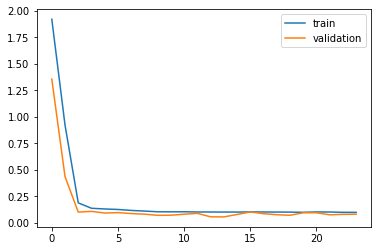


predict: [[31.96002701 19.39354637]]
real:      [[34.1 19.7]]

Train on 1733 samples, validate on 1 samples
Epoch 1/1000
 - 18s - loss: 1.7930 - mean_squared_error: 4.0640 - val_loss: 0.3012 - val_mean_squared_error: 0.0987
Epoch 2/1000
 - 1s - loss: 0.2086 - mean_squared_error: 0.0681 - val_loss: 0.2169 - val_mean_squared_error: 0.0495
Epoch 3/1000
 - 1s - loss: 0.1394 - mean_squared_error: 0.0334 - val_loss: 0.1568 - val_mean_squared_error: 0.0247
Epoch 4/1000
 - 1s - loss: 0.1280 - mean_squared_error: 0.0283 - val_loss: 0.1367 - val_mean_squared_error: 0.0198
Epoch 5/1000
 - 1s - loss: 0.1255 - mean_squared_error: 0.0279 - val_loss: 0.1939 - val_mean_squared_error: 0.0378
Epoch 6/1000
 - 1s - loss: 0.1286 - mean_squared_error: 0.0273 - val_loss: 0.1394 - val_mean_squared_error: 0.0202
Epoch 7/1000
 - 1s - loss: 0.1193 - mean_squared_error: 0.0255 - val_loss: 0.1641 - val_mean_squared_error: 0.0284
Epoch 8/1000
 - 1s - loss: 0.1106 - mean_squared_error: 0.0217 - val_loss: 0.0764 - v

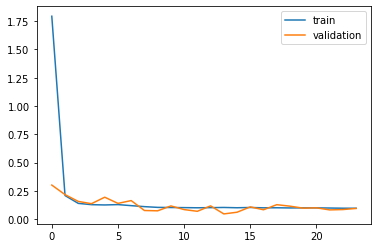


predict: [[33.11067535 21.22950371]]
real:      [[34.4 19.3]]

Train on 1732 samples, validate on 1 samples
Epoch 1/1000
 - 18s - loss: 2.2372 - mean_squared_error: 5.5777 - val_loss: 1.2894 - val_mean_squared_error: 2.6952
Epoch 2/1000
 - 1s - loss: 0.7674 - mean_squared_error: 1.0695 - val_loss: 0.3338 - val_mean_squared_error: 0.1777
Epoch 3/1000
 - 1s - loss: 0.1673 - mean_squared_error: 0.0483 - val_loss: 0.2012 - val_mean_squared_error: 0.0452
Epoch 4/1000
 - 1s - loss: 0.1366 - mean_squared_error: 0.0322 - val_loss: 0.1451 - val_mean_squared_error: 0.0214
Epoch 5/1000
 - 1s - loss: 0.1338 - mean_squared_error: 0.0311 - val_loss: 0.1521 - val_mean_squared_error: 0.0231
Epoch 6/1000
 - 1s - loss: 0.1319 - mean_squared_error: 0.0304 - val_loss: 0.1376 - val_mean_squared_error: 0.0192
Epoch 7/1000
 - 1s - loss: 0.1286 - mean_squared_error: 0.0292 - val_loss: 0.1371 - val_mean_squared_error: 0.0195
Epoch 8/1000
 - 1s - loss: 0.1217 - mean_squared_error: 0.0258 - val_loss: 0.1131 - v

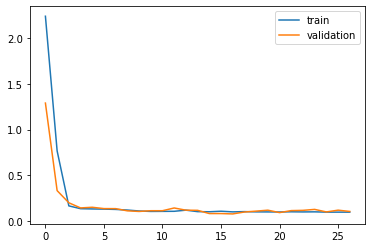


predict: [[33.32911454 19.86909343]]
real:      [[35.4 21.1]]

Train on 1731 samples, validate on 1 samples
Epoch 1/1000
 - 18s - loss: 1.2549 - mean_squared_error: 2.2697 - val_loss: 0.1216 - val_mean_squared_error: 0.0153
Epoch 2/1000
 - 1s - loss: 0.1807 - mean_squared_error: 0.0520 - val_loss: 0.1247 - val_mean_squared_error: 0.0168
Epoch 3/1000
 - 1s - loss: 0.1342 - mean_squared_error: 0.0309 - val_loss: 0.1292 - val_mean_squared_error: 0.0169
Epoch 4/1000
 - 1s - loss: 0.1262 - mean_squared_error: 0.0273 - val_loss: 0.1053 - val_mean_squared_error: 0.0133
Epoch 5/1000
 - 1s - loss: 0.1189 - mean_squared_error: 0.0241 - val_loss: 0.0690 - val_mean_squared_error: 0.0088
Epoch 6/1000
 - 1s - loss: 0.1095 - mean_squared_error: 0.0215 - val_loss: 0.0710 - val_mean_squared_error: 0.0084
Epoch 7/1000
 - 1s - loss: 0.1051 - mean_squared_error: 0.0198 - val_loss: 0.0871 - val_mean_squared_error: 0.0085
Epoch 8/1000
 - 1s - loss: 0.1033 - mean_squared_error: 0.0189 - val_loss: 0.0868 - v

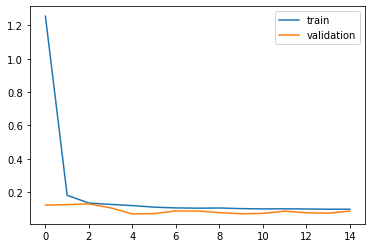


predict: [[30.44041382 20.46616585]]
real:      [[36.5 21.5]]

Train on 1730 samples, validate on 1 samples
Epoch 1/1000
 - 19s - loss: 2.5917 - mean_squared_error: 6.9062 - val_loss: 2.0435 - val_mean_squared_error: 4.1770
Epoch 2/1000
 - 1s - loss: 0.9058 - mean_squared_error: 1.1779 - val_loss: 0.0661 - val_mean_squared_error: 0.0060
Epoch 3/1000
 - 1s - loss: 0.1841 - mean_squared_error: 0.0542 - val_loss: 0.1521 - val_mean_squared_error: 0.0240
Epoch 4/1000
 - 1s - loss: 0.1417 - mean_squared_error: 0.0358 - val_loss: 0.1818 - val_mean_squared_error: 0.0332
Epoch 5/1000
 - 1s - loss: 0.1369 - mean_squared_error: 0.0323 - val_loss: 0.1562 - val_mean_squared_error: 0.0253
Epoch 6/1000
 - 1s - loss: 0.1350 - mean_squared_error: 0.0314 - val_loss: 0.1546 - val_mean_squared_error: 0.0253
Epoch 7/1000
 - 1s - loss: 0.1327 - mean_squared_error: 0.0298 - val_loss: 0.1361 - val_mean_squared_error: 0.0220
Epoch 8/1000
 - 1s - loss: 0.1277 - mean_squared_error: 0.0285 - val_loss: 0.0964 - v

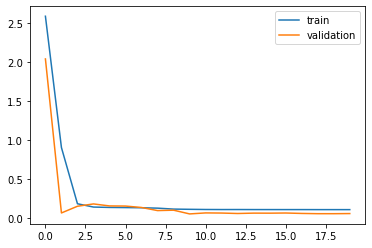


predict: [[32.15072342 20.36479452]]
real:      [[35.4 20.7]]

Train on 1729 samples, validate on 1 samples
Epoch 1/1000
 - 18s - loss: 2.7170 - mean_squared_error: 7.5966 - val_loss: 1.9585 - val_mean_squared_error: 4.0189
Epoch 2/1000
 - 1s - loss: 0.9296 - mean_squared_error: 1.2432 - val_loss: 0.3999 - val_mean_squared_error: 0.1886
Epoch 3/1000
 - 1s - loss: 0.1984 - mean_squared_error: 0.0695 - val_loss: 0.0605 - val_mean_squared_error: 0.0041
Epoch 4/1000
 - 1s - loss: 0.1316 - mean_squared_error: 0.0309 - val_loss: 0.1214 - val_mean_squared_error: 0.0182
Epoch 5/1000
 - 1s - loss: 0.1333 - mean_squared_error: 0.0295 - val_loss: 0.0799 - val_mean_squared_error: 0.0086
Epoch 6/1000
 - 1s - loss: 0.1337 - mean_squared_error: 0.0313 - val_loss: 0.0736 - val_mean_squared_error: 0.0094
Epoch 7/1000
 - 1s - loss: 0.1270 - mean_squared_error: 0.0286 - val_loss: 0.1114 - val_mean_squared_error: 0.0185
Epoch 8/1000
 - 1s - loss: 0.1295 - mean_squared_error: 0.0279 - val_loss: 0.0867 - v

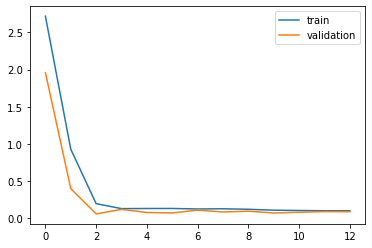


predict: [[31.55932135 17.40458909]]
real:      [[35.2 20.3]]

Train on 1728 samples, validate on 1 samples
Epoch 1/1000
 - 19s - loss: 1.5635 - mean_squared_error: 3.4998 - val_loss: 0.1901 - val_mean_squared_error: 0.0549
Epoch 2/1000
 - 1s - loss: 0.1697 - mean_squared_error: 0.0491 - val_loss: 0.0689 - val_mean_squared_error: 0.0051
Epoch 3/1000
 - 1s - loss: 0.1326 - mean_squared_error: 0.0299 - val_loss: 0.1063 - val_mean_squared_error: 0.0121
Epoch 4/1000
 - 1s - loss: 0.1248 - mean_squared_error: 0.0263 - val_loss: 0.1496 - val_mean_squared_error: 0.0224
Epoch 5/1000
 - 1s - loss: 0.1163 - mean_squared_error: 0.0233 - val_loss: 0.1516 - val_mean_squared_error: 0.0252
Epoch 6/1000
 - 1s - loss: 0.1074 - mean_squared_error: 0.0204 - val_loss: 0.1543 - val_mean_squared_error: 0.0241
Epoch 7/1000
 - 1s - loss: 0.1018 - mean_squared_error: 0.0182 - val_loss: 0.1423 - val_mean_squared_error: 0.0203
Epoch 8/1000
 - 1s - loss: 0.1035 - mean_squared_error: 0.0188 - val_loss: 0.1327 - v

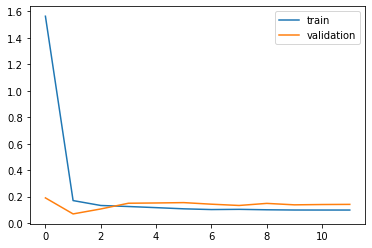


predict: [[30.27301111 15.15907657]]
real:      [[35.6 19. ]]

Train on 1727 samples, validate on 1 samples
Epoch 1/1000
 - 19s - loss: 1.1457 - mean_squared_error: 2.1705 - val_loss: 0.1904 - val_mean_squared_error: 0.0531
Epoch 2/1000
 - 1s - loss: 0.1492 - mean_squared_error: 0.0368 - val_loss: 0.1159 - val_mean_squared_error: 0.0171
Epoch 3/1000
 - 1s - loss: 0.1288 - mean_squared_error: 0.0284 - val_loss: 0.0796 - val_mean_squared_error: 0.0125
Epoch 4/1000
 - 1s - loss: 0.1229 - mean_squared_error: 0.0270 - val_loss: 0.0893 - val_mean_squared_error: 0.0131
Epoch 5/1000
 - 1s - loss: 0.1188 - mean_squared_error: 0.0251 - val_loss: 0.0987 - val_mean_squared_error: 0.0142
Epoch 6/1000
 - 1s - loss: 0.1161 - mean_squared_error: 0.0242 - val_loss: 0.1189 - val_mean_squared_error: 0.0196
Epoch 7/1000
 - 1s - loss: 0.1129 - mean_squared_error: 0.0231 - val_loss: 0.1034 - val_mean_squared_error: 0.0144
Epoch 8/1000
 - 1s - loss: 0.1088 - mean_squared_error: 0.0213 - val_loss: 0.1218 - v

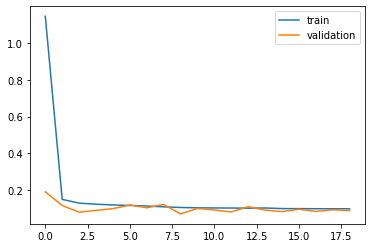


predict: [[32.62581498 19.55687644]]
real:      [[35.  17.4]]

Train on 1726 samples, validate on 1 samples
Epoch 1/1000
 - 19s - loss: 1.8456 - mean_squared_error: 4.2435 - val_loss: 0.7010 - val_mean_squared_error: 0.8048
Epoch 2/1000
 - 1s - loss: 0.3074 - mean_squared_error: 0.1882 - val_loss: 0.1046 - val_mean_squared_error: 0.0147
Epoch 3/1000
 - 1s - loss: 0.1389 - mean_squared_error: 0.0325 - val_loss: 0.1265 - val_mean_squared_error: 0.0262
Epoch 4/1000
 - 1s - loss: 0.1267 - mean_squared_error: 0.0278 - val_loss: 0.1048 - val_mean_squared_error: 0.0183
Epoch 5/1000
 - 1s - loss: 0.1233 - mean_squared_error: 0.0266 - val_loss: 0.1197 - val_mean_squared_error: 0.0201
Epoch 6/1000
 - 1s - loss: 0.1210 - mean_squared_error: 0.0258 - val_loss: 0.0886 - val_mean_squared_error: 0.0157
Epoch 7/1000
 - 1s - loss: 0.1184 - mean_squared_error: 0.0248 - val_loss: 0.0951 - val_mean_squared_error: 0.0165
Epoch 8/1000
 - 1s - loss: 0.1157 - mean_squared_error: 0.0241 - val_loss: 0.1102 - v

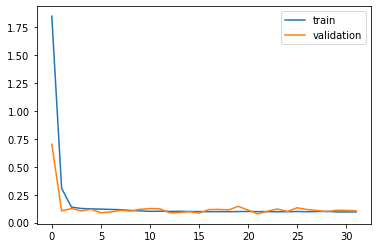


predict: [[31.43017317 18.97633019]]
real:      [[35.2 18.8]]

Train on 1725 samples, validate on 1 samples
Epoch 1/1000
 - 19s - loss: 2.3582 - mean_squared_error: 7.5458 - val_loss: 1.5546 - val_mean_squared_error: 4.5425
Epoch 2/1000
 - 1s - loss: 0.8856 - mean_squared_error: 1.6090 - val_loss: 0.1677 - val_mean_squared_error: 0.0311
Epoch 3/1000
 - 1s - loss: 0.1767 - mean_squared_error: 0.0516 - val_loss: 0.1479 - val_mean_squared_error: 0.0275
Epoch 4/1000
 - 1s - loss: 0.1360 - mean_squared_error: 0.0319 - val_loss: 0.1015 - val_mean_squared_error: 0.0123
Epoch 5/1000
 - 1s - loss: 0.1302 - mean_squared_error: 0.0293 - val_loss: 0.1367 - val_mean_squared_error: 0.0192
Epoch 6/1000
 - 1s - loss: 0.1194 - mean_squared_error: 0.0255 - val_loss: 0.1144 - val_mean_squared_error: 0.0135
Epoch 7/1000
 - 1s - loss: 0.1101 - mean_squared_error: 0.0215 - val_loss: 0.1104 - val_mean_squared_error: 0.0130
Epoch 8/1000
 - 1s - loss: 0.1059 - mean_squared_error: 0.0197 - val_loss: 0.1249 - v

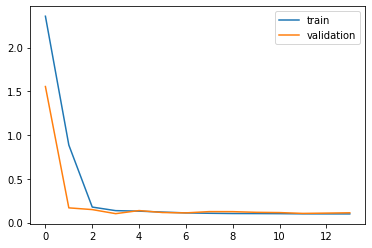


predict: [[30.39467667 16.09800585]]
real:      [[35.4 18.6]]

Train on 1724 samples, validate on 1 samples
Epoch 1/1000
 - 19s - loss: 2.0532 - mean_squared_error: 5.0727 - val_loss: 1.0323 - val_mean_squared_error: 1.9685
Epoch 2/1000
 - 1s - loss: 0.4827 - mean_squared_error: 0.5286 - val_loss: 0.2196 - val_mean_squared_error: 0.0592
Epoch 3/1000
 - 1s - loss: 0.1463 - mean_squared_error: 0.0356 - val_loss: 0.1108 - val_mean_squared_error: 0.0228
Epoch 4/1000
 - 1s - loss: 0.1264 - mean_squared_error: 0.0273 - val_loss: 0.1363 - val_mean_squared_error: 0.0218
Epoch 5/1000
 - 1s - loss: 0.1184 - mean_squared_error: 0.0249 - val_loss: 0.1152 - val_mean_squared_error: 0.0173
Epoch 6/1000
 - 1s - loss: 0.1130 - mean_squared_error: 0.0230 - val_loss: 0.1061 - val_mean_squared_error: 0.0121
Epoch 7/1000
 - 1s - loss: 0.1084 - mean_squared_error: 0.0211 - val_loss: 0.1412 - val_mean_squared_error: 0.0260
Epoch 8/1000
 - 1s - loss: 0.1072 - mean_squared_error: 0.0209 - val_loss: 0.1585 - v

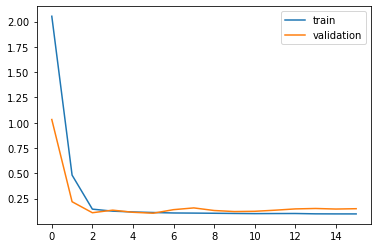


predict: [[30.60737876 18.60378287]]
real:      [[33.7 16.7]]

Train on 1723 samples, validate on 1 samples
Epoch 1/1000
 - 19s - loss: 2.4191 - mean_squared_error: 6.3151 - val_loss: 1.0748 - val_mean_squared_error: 1.5174
Epoch 2/1000
 - 1s - loss: 0.5139 - mean_squared_error: 0.5276 - val_loss: 0.2402 - val_mean_squared_error: 0.0627
Epoch 3/1000
 - 1s - loss: 0.1477 - mean_squared_error: 0.0372 - val_loss: 0.1956 - val_mean_squared_error: 0.0420
Epoch 4/1000
 - 1s - loss: 0.1316 - mean_squared_error: 0.0298 - val_loss: 0.2194 - val_mean_squared_error: 0.0583
Epoch 5/1000
 - 1s - loss: 0.1272 - mean_squared_error: 0.0284 - val_loss: 0.2318 - val_mean_squared_error: 0.0643
Epoch 6/1000
 - 1s - loss: 0.1211 - mean_squared_error: 0.0261 - val_loss: 0.2707 - val_mean_squared_error: 0.0969
Epoch 7/1000
 - 1s - loss: 0.1136 - mean_squared_error: 0.0230 - val_loss: 0.2548 - val_mean_squared_error: 0.0813
Epoch 8/1000
 - 1s - loss: 0.1084 - mean_squared_error: 0.0210 - val_loss: 0.2687 - v

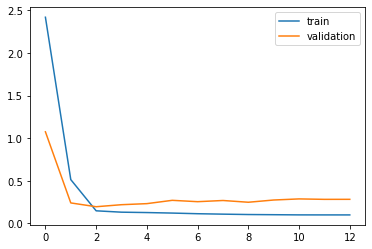


predict: [[29.32771345 16.95473486]]
real:      [[30.8 14.5]]

Train on 1722 samples, validate on 1 samples
Epoch 1/1000
 - 19s - loss: 1.3813 - mean_squared_error: 2.7003 - val_loss: 0.2695 - val_mean_squared_error: 0.0786
Epoch 2/1000
 - 1s - loss: 0.1968 - mean_squared_error: 0.0647 - val_loss: 0.1809 - val_mean_squared_error: 0.0615
Epoch 3/1000
 - 1s - loss: 0.1336 - mean_squared_error: 0.0309 - val_loss: 0.2069 - val_mean_squared_error: 0.0530
Epoch 4/1000
 - 1s - loss: 0.1282 - mean_squared_error: 0.0289 - val_loss: 0.1805 - val_mean_squared_error: 0.0429
Epoch 5/1000
 - 1s - loss: 0.1260 - mean_squared_error: 0.0279 - val_loss: 0.1827 - val_mean_squared_error: 0.0501
Epoch 6/1000
 - 1s - loss: 0.1234 - mean_squared_error: 0.0269 - val_loss: 0.1922 - val_mean_squared_error: 0.0562
Epoch 7/1000
 - 1s - loss: 0.1225 - mean_squared_error: 0.0265 - val_loss: 0.1943 - val_mean_squared_error: 0.0514
Epoch 8/1000
 - 1s - loss: 0.1208 - mean_squared_error: 0.0257 - val_loss: 0.1809 - v

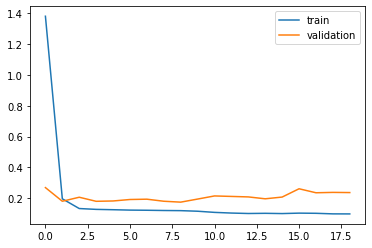


predict: [[30.54578105 20.07169096]]
real:      [[26.8 13.6]]

Train on 1721 samples, validate on 1 samples
Epoch 1/1000
 - 19s - loss: 2.0949 - mean_squared_error: 5.3788 - val_loss: 1.0182 - val_mean_squared_error: 1.9234
Epoch 2/1000
 - 1s - loss: 0.5269 - mean_squared_error: 0.6512 - val_loss: 0.2341 - val_mean_squared_error: 0.0552
Epoch 3/1000
 - 1s - loss: 0.1553 - mean_squared_error: 0.0403 - val_loss: 0.1605 - val_mean_squared_error: 0.0400
Epoch 4/1000
 - 1s - loss: 0.1340 - mean_squared_error: 0.0311 - val_loss: 0.1543 - val_mean_squared_error: 0.0384
Epoch 5/1000
 - 1s - loss: 0.1275 - mean_squared_error: 0.0282 - val_loss: 0.1277 - val_mean_squared_error: 0.0315
Epoch 6/1000
 - 1s - loss: 0.1223 - mean_squared_error: 0.0263 - val_loss: 0.1109 - val_mean_squared_error: 0.0216
Epoch 7/1000
 - 1s - loss: 0.1147 - mean_squared_error: 0.0235 - val_loss: 0.1561 - val_mean_squared_error: 0.0386
Epoch 8/1000
 - 1s - loss: 0.1140 - mean_squared_error: 0.0228 - val_loss: 0.1769 - v

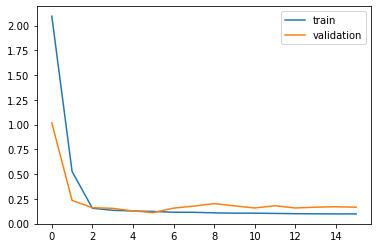


predict: [[29.9585107  18.50759228]]
real:      [[21.8 17.4]]

Train on 1720 samples, validate on 1 samples
Epoch 1/1000
 - 19s - loss: 1.7724 - mean_squared_error: 4.1161 - val_loss: 0.1349 - val_mean_squared_error: 0.0320
Epoch 2/1000
 - 1s - loss: 0.2170 - mean_squared_error: 0.0736 - val_loss: 0.0757 - val_mean_squared_error: 0.0064
Epoch 3/1000
 - 1s - loss: 0.1347 - mean_squared_error: 0.0315 - val_loss: 0.0367 - val_mean_squared_error: 0.0027
Epoch 4/1000
 - 1s - loss: 0.1243 - mean_squared_error: 0.0267 - val_loss: 0.0501 - val_mean_squared_error: 0.0045
Epoch 5/1000
 - 1s - loss: 0.1200 - mean_squared_error: 0.0253 - val_loss: 0.0416 - val_mean_squared_error: 0.0024
Epoch 6/1000
 - 1s - loss: 0.1116 - mean_squared_error: 0.0220 - val_loss: 0.0326 - val_mean_squared_error: 0.0012
Epoch 7/1000
 - 1s - loss: 0.1066 - mean_squared_error: 0.0201 - val_loss: 0.0549 - val_mean_squared_error: 0.0032
Epoch 8/1000
 - 1s - loss: 0.1018 - mean_squared_error: 0.0185 - val_loss: 0.0287 - v

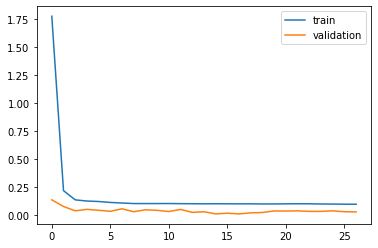


predict: [[30.47845642 20.84003003]]
real:      [[23.  18.4]]

Train on 1719 samples, validate on 1 samples
Epoch 1/1000
 - 19s - loss: 2.2925 - mean_squared_error: 5.5963 - val_loss: 1.6349 - val_mean_squared_error: 2.8534
Epoch 2/1000
 - 1s - loss: 0.6815 - mean_squared_error: 0.7933 - val_loss: 0.1682 - val_mean_squared_error: 0.0284
Epoch 3/1000
 - 1s - loss: 0.1650 - mean_squared_error: 0.0451 - val_loss: 0.0865 - val_mean_squared_error: 0.0087
Epoch 4/1000
 - 1s - loss: 0.1311 - mean_squared_error: 0.0300 - val_loss: 0.0837 - val_mean_squared_error: 0.0098
Epoch 5/1000
 - 1s - loss: 0.1281 - mean_squared_error: 0.0287 - val_loss: 0.0735 - val_mean_squared_error: 0.0072
Epoch 6/1000
 - 1s - loss: 0.1253 - mean_squared_error: 0.0275 - val_loss: 0.0867 - val_mean_squared_error: 0.0120
Epoch 7/1000
 - 1s - loss: 0.1185 - mean_squared_error: 0.0245 - val_loss: 0.0786 - val_mean_squared_error: 0.0077
Epoch 8/1000
 - 1s - loss: 0.1104 - mean_squared_error: 0.0215 - val_loss: 0.0717 - v

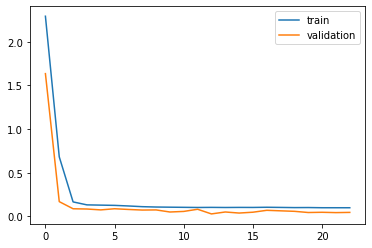


predict: [[31.23392921 19.51040741]]
real:      [[29.2 20.5]]

Train on 1718 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 1.4842 - mean_squared_error: 3.2910 - val_loss: 0.2779 - val_mean_squared_error: 0.0773
Epoch 2/1000
 - 1s - loss: 0.2005 - mean_squared_error: 0.0627 - val_loss: 0.0287 - val_mean_squared_error: 0.0015
Epoch 3/1000
 - 1s - loss: 0.1323 - mean_squared_error: 0.0304 - val_loss: 0.0607 - val_mean_squared_error: 0.0038
Epoch 4/1000
 - 1s - loss: 0.1219 - mean_squared_error: 0.0263 - val_loss: 0.0521 - val_mean_squared_error: 0.0027
Epoch 5/1000
 - 1s - loss: 0.1148 - mean_squared_error: 0.0231 - val_loss: 0.0622 - val_mean_squared_error: 0.0047
Epoch 6/1000
 - 1s - loss: 0.1107 - mean_squared_error: 0.0218 - val_loss: 0.1096 - val_mean_squared_error: 0.0129
Epoch 7/1000
 - 1s - loss: 0.1099 - mean_squared_error: 0.0208 - val_loss: 0.0528 - val_mean_squared_error: 0.0028
Epoch 8/1000
 - 1s - loss: 0.1049 - mean_squared_error: 0.0195 - val_loss: 0.0695 - v

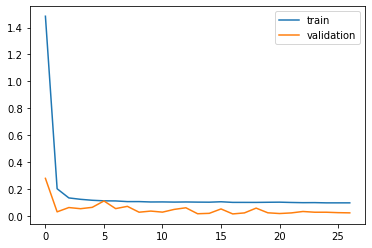


predict: [[31.84112614 20.61427564]]
real:      [[33.9 19.9]]

Train on 1717 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 1.0161 - mean_squared_error: 1.9636 - val_loss: 0.0666 - val_mean_squared_error: 0.0058
Epoch 2/1000
 - 1s - loss: 0.1569 - mean_squared_error: 0.0391 - val_loss: 0.0730 - val_mean_squared_error: 0.0073
Epoch 3/1000
 - 1s - loss: 0.1269 - mean_squared_error: 0.0279 - val_loss: 0.0853 - val_mean_squared_error: 0.0099
Epoch 4/1000
 - 1s - loss: 0.1161 - mean_squared_error: 0.0242 - val_loss: 0.0737 - val_mean_squared_error: 0.0065
Epoch 5/1000
 - 1s - loss: 0.1067 - mean_squared_error: 0.0204 - val_loss: 0.0979 - val_mean_squared_error: 0.0149
Epoch 6/1000
 - 1s - loss: 0.1012 - mean_squared_error: 0.0184 - val_loss: 0.0543 - val_mean_squared_error: 0.0052
Epoch 7/1000
 - 1s - loss: 0.1005 - mean_squared_error: 0.0181 - val_loss: 0.0713 - val_mean_squared_error: 0.0088
Epoch 8/1000
 - 1s - loss: 0.0989 - mean_squared_error: 0.0175 - val_loss: 0.0626 - v

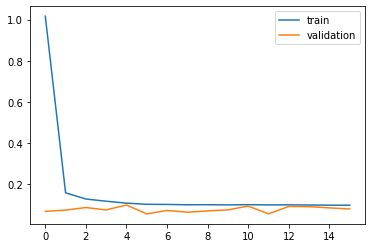


predict: [[30.24584555 19.57883057]]
real:      [[31. 19.]]

Train on 1716 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 1.9994 - mean_squared_error: 4.5605 - val_loss: 0.7508 - val_mean_squared_error: 1.0319
Epoch 2/1000
 - 1s - loss: 0.2908 - mean_squared_error: 0.1835 - val_loss: 0.1102 - val_mean_squared_error: 0.0150
Epoch 3/1000
 - 1s - loss: 0.1405 - mean_squared_error: 0.0332 - val_loss: 0.0508 - val_mean_squared_error: 0.0028
Epoch 4/1000
 - 1s - loss: 0.1340 - mean_squared_error: 0.0303 - val_loss: 0.0572 - val_mean_squared_error: 0.0037
Epoch 5/1000
 - 1s - loss: 0.1305 - mean_squared_error: 0.0292 - val_loss: 0.0452 - val_mean_squared_error: 0.0026
Epoch 6/1000
 - 1s - loss: 0.1284 - mean_squared_error: 0.0286 - val_loss: 0.0366 - val_mean_squared_error: 0.0026
Epoch 7/1000
 - 1s - loss: 0.1259 - mean_squared_error: 0.0278 - val_loss: 0.0613 - val_mean_squared_error: 0.0072
Epoch 8/1000
 - 1s - loss: 0.1233 - mean_squared_error: 0.0264 - val_loss: 0.0539 - val

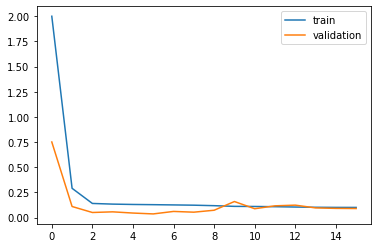


predict: [[29.36996285 19.17280486]]
real:      [[27.2 19.4]]

Train on 1715 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 1.4493 - mean_squared_error: 3.1193 - val_loss: 0.1547 - val_mean_squared_error: 0.0373
Epoch 2/1000
 - 1s - loss: 0.2029 - mean_squared_error: 0.0641 - val_loss: 0.0704 - val_mean_squared_error: 0.0061
Epoch 3/1000
 - 1s - loss: 0.1409 - mean_squared_error: 0.0343 - val_loss: 0.0364 - val_mean_squared_error: 0.0015
Epoch 4/1000
 - 1s - loss: 0.1276 - mean_squared_error: 0.0282 - val_loss: 0.0460 - val_mean_squared_error: 0.0034
Epoch 5/1000
 - 1s - loss: 0.1197 - mean_squared_error: 0.0255 - val_loss: 0.0154 - val_mean_squared_error: 2.3760e-04
Epoch 6/1000
 - 1s - loss: 0.1171 - mean_squared_error: 0.0247 - val_loss: 0.0457 - val_mean_squared_error: 0.0036
Epoch 7/1000
 - 1s - loss: 0.1121 - mean_squared_error: 0.0232 - val_loss: 0.0542 - val_mean_squared_error: 0.0029
Epoch 8/1000
 - 1s - loss: 0.1084 - mean_squared_error: 0.0213 - val_loss: 0.0248

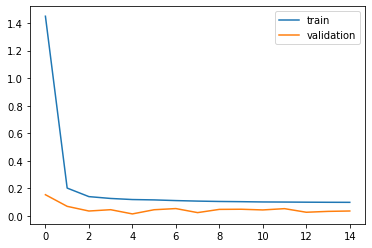


predict: [[30.71145315 21.01947502]]
real:      [[29.2 21. ]]

Train and validation time: 28.72 minutes

Maximum temperatures metrics
Test MEAN-SQUARED-ERROR ------------ 14.46
Test STANDART-DEVIATION ------------ 2.093
Test MEAN-ABSOLUTE-ERROR ----------- 3.175
Test MEDIAN-ABSOLUTE-ERROR --------- 2.586

Errors
2018-12-31 = 2.7984301773775755
2018-12-30 = 1.8101747426817525
2018-12-29 = 0.29458990069027635
2018-12-28 = 4.0620664887921905
2018-12-27 = 5.435903652631637
2018-12-26 = 7.0201755631356555
2018-12-25 = 2.0256636837274833
2018-12-24 = 0.2577837469581432
2018-12-23 = 0.34029600037525753
2018-12-22 = 3.816337619899496
2018-12-21 = 2.1399729874265603
2018-12-20 = 1.2893246493914958
2018-12-19 = 2.0708854623123685
2018-12-18 = 6.059586183953542
2018-12-17 = 3.24927658207217
2018-12-16 = 3.6406786514069154
2018-12-15 = 5.326988889579816
2018-12-14 = 2.3741850179655373
2018-12-13 = 3.76982683040443
2018-12-12 = 5.005323330658232
2018-12-11 = 3.0926212431915303
2018-12-10 = 1.47228

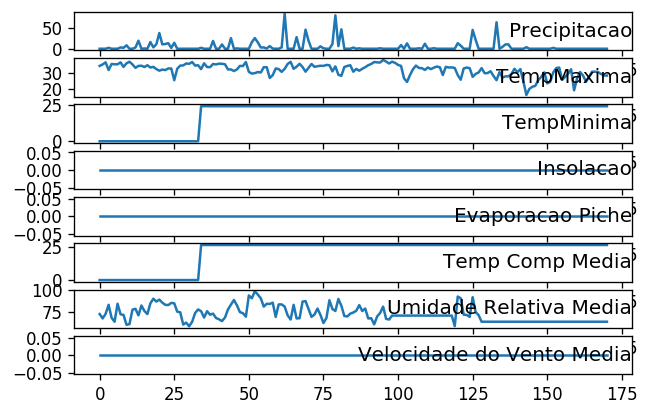

Train on 109 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 3.6304 - mean_squared_error: 13.2280 - val_loss: 3.4146 - val_mean_squared_error: 11.6990
Epoch 2/1000
 - 0s - loss: 3.4279 - mean_squared_error: 11.8259 - val_loss: 3.2564 - val_mean_squared_error: 10.6700
Epoch 3/1000
 - 0s - loss: 3.2895 - mean_squared_error: 10.9253 - val_loss: 3.1839 - val_mean_squared_error: 10.2369
Epoch 4/1000
 - 0s - loss: 3.2151 - mean_squared_error: 10.4821 - val_loss: 3.0979 - val_mean_squared_error: 9.7448
Epoch 5/1000
 - 0s - loss: 3.1277 - mean_squared_error: 9.9838 - val_loss: 3.0035 - val_mean_squared_error: 9.2317
Epoch 6/1000
 - 0s - loss: 3.0348 - mean_squared_error: 9.4809 - val_loss: 2.9191 - val_mean_squared_error: 8.7944
Epoch 7/1000
 - 0s - loss: 2.9540 - mean_squared_error: 9.0598 - val_loss: 2.8490 - val_mean_squared_error: 8.4442
Epoch 8/1000
 - 0s - loss: 2.8823 - mean_squared_error: 8.6997 - val_loss: 2.7752 - val_mean_squared_error: 8.0938
Epoch 9/1000
 - 0s - loss: 2

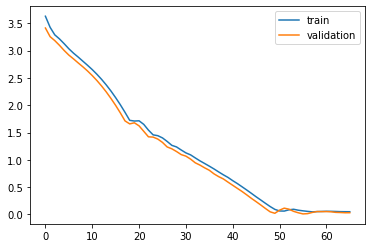


predict: [[34.85019624 24.13105082]]
real:      [[28.2 24. ]]

Train on 108 samples, validate on 1 samples
Epoch 1/1000
 - 19s - loss: 3.2177 - mean_squared_error: 10.4258 - val_loss: 2.9673 - val_mean_squared_error: 8.8971
Epoch 2/1000
 - 0s - loss: 2.9253 - mean_squared_error: 8.6610 - val_loss: 2.6925 - val_mean_squared_error: 7.3948
Epoch 3/1000
 - 0s - loss: 2.6704 - mean_squared_error: 7.2840 - val_loss: 2.4667 - val_mean_squared_error: 6.2928
Epoch 4/1000
 - 0s - loss: 2.4488 - mean_squared_error: 6.2090 - val_loss: 2.2748 - val_mean_squared_error: 5.4443
Epoch 5/1000
 - 0s - loss: 2.2584 - mean_squared_error: 5.3722 - val_loss: 2.0794 - val_mean_squared_error: 4.6717
Epoch 6/1000
 - 0s - loss: 2.0659 - mean_squared_error: 4.6196 - val_loss: 1.8773 - val_mean_squared_error: 3.9761
Epoch 7/1000
 - 0s - loss: 1.8693 - mean_squared_error: 3.9531 - val_loss: 1.6765 - val_mean_squared_error: 3.4024
Epoch 8/1000
 - 0s - loss: 1.6669 - mean_squared_error: 3.3810 - val_loss: 1.4679 - v

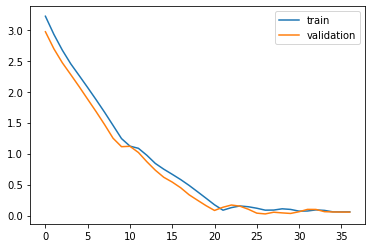


predict: [[27.97180839 23.27147925]]
real:      [[28.2 24. ]]

Train on 107 samples, validate on 1 samples
Epoch 1/1000
 - 19s - loss: 3.1781 - mean_squared_error: 10.1238 - val_loss: 2.9292 - val_mean_squared_error: 8.5800
Epoch 2/1000
 - 0s - loss: 2.9292 - mean_squared_error: 8.5931 - val_loss: 2.7787 - val_mean_squared_error: 7.7297
Epoch 3/1000
 - 0s - loss: 2.7731 - mean_squared_error: 7.7117 - val_loss: 2.6315 - val_mean_squared_error: 6.9445
Epoch 4/1000
 - 0s - loss: 2.6256 - mean_squared_error: 6.9256 - val_loss: 2.4856 - val_mean_squared_error: 6.2036
Epoch 5/1000
 - 0s - loss: 2.4779 - mean_squared_error: 6.1793 - val_loss: 2.3318 - val_mean_squared_error: 5.4695
Epoch 6/1000
 - 0s - loss: 2.3207 - mean_squared_error: 5.4329 - val_loss: 2.1717 - val_mean_squared_error: 4.7583
Epoch 7/1000
 - 0s - loss: 2.1561 - mean_squared_error: 4.7065 - val_loss: 2.0070 - val_mean_squared_error: 4.0832
Epoch 8/1000
 - 0s - loss: 1.9874 - mean_squared_error: 4.0217 - val_loss: 1.8385 - v

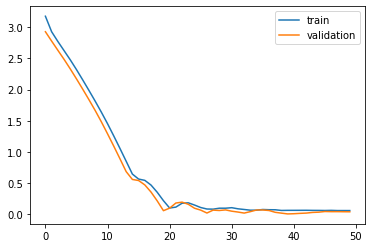


predict: [[30.26765811 24.13010415]]
real:      [[29.2 24. ]]

Train on 106 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 3.2888 - mean_squared_error: 10.8464 - val_loss: 3.1740 - val_mean_squared_error: 10.0800
Epoch 2/1000
 - 0s - loss: 3.1257 - mean_squared_error: 9.7886 - val_loss: 3.0028 - val_mean_squared_error: 9.0184
Epoch 3/1000
 - 0s - loss: 2.9567 - mean_squared_error: 8.7558 - val_loss: 2.8321 - val_mean_squared_error: 8.0211
Epoch 4/1000
 - 0s - loss: 2.7911 - mean_squared_error: 7.8031 - val_loss: 2.6710 - val_mean_squared_error: 7.1350
Epoch 5/1000
 - 0s - loss: 2.6332 - mean_squared_error: 6.9458 - val_loss: 2.5117 - val_mean_squared_error: 6.3095
Epoch 6/1000
 - 0s - loss: 2.4770 - mean_squared_error: 6.1490 - val_loss: 2.3581 - val_mean_squared_error: 5.5618
Epoch 7/1000
 - 0s - loss: 2.3261 - mean_squared_error: 5.4242 - val_loss: 2.2107 - val_mean_squared_error: 4.8882
Epoch 8/1000
 - 0s - loss: 2.1804 - mean_squared_error: 4.7674 - val_loss: 2.0688 - 

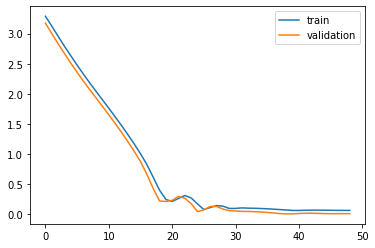


predict: [[30.35713903 24.14660412]]
real:      [[30.4 24. ]]

Train on 105 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 3.2715 - mean_squared_error: 10.7845 - val_loss: 3.1081 - val_mean_squared_error: 9.7811
Epoch 2/1000
 - 0s - loss: 3.1001 - mean_squared_error: 9.7748 - val_loss: 2.8979 - val_mean_squared_error: 8.5866
Epoch 3/1000
 - 0s - loss: 2.8945 - mean_squared_error: 8.6075 - val_loss: 2.6874 - val_mean_squared_error: 7.4694
Epoch 4/1000
 - 0s - loss: 2.6766 - mean_squared_error: 7.4556 - val_loss: 2.4663 - val_mean_squared_error: 6.3931
Epoch 5/1000
 - 0s - loss: 2.4453 - mean_squared_error: 6.3344 - val_loss: 2.2457 - val_mean_squared_error: 5.4194
Epoch 6/1000
 - 0s - loss: 2.2162 - mean_squared_error: 5.3326 - val_loss: 2.0338 - val_mean_squared_error: 4.5696
Epoch 7/1000
 - 0s - loss: 2.0021 - mean_squared_error: 4.4915 - val_loss: 1.8257 - val_mean_squared_error: 3.8284
Epoch 8/1000
 - 0s - loss: 1.7968 - mean_squared_error: 3.7826 - val_loss: 1.6199 - v

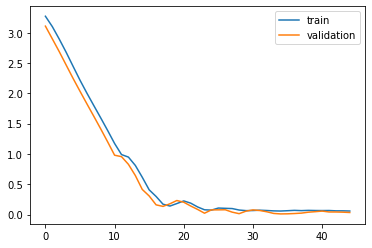


predict: [[30.56093219 24.40635094]]
real:      [[30.6 24. ]]

Train on 104 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 3.1707 - mean_squared_error: 10.3133 - val_loss: 2.8194 - val_mean_squared_error: 8.0947
Epoch 2/1000
 - 0s - loss: 2.8378 - mean_squared_error: 8.2618 - val_loss: 2.5224 - val_mean_squared_error: 6.4668
Epoch 3/1000
 - 0s - loss: 2.5089 - mean_squared_error: 6.4483 - val_loss: 2.1964 - val_mean_squared_error: 4.8859
Epoch 4/1000
 - 0s - loss: 2.1795 - mean_squared_error: 4.8398 - val_loss: 1.8624 - val_mean_squared_error: 3.4850
Epoch 5/1000
 - 0s - loss: 1.8596 - mean_squared_error: 3.4972 - val_loss: 1.5435 - val_mean_squared_error: 2.3826
Epoch 6/1000
 - 0s - loss: 1.5544 - mean_squared_error: 2.4348 - val_loss: 1.2452 - val_mean_squared_error: 1.5561
Epoch 7/1000
 - 0s - loss: 1.2560 - mean_squared_error: 1.5958 - val_loss: 0.9506 - val_mean_squared_error: 0.9312
Epoch 8/1000
 - 0s - loss: 0.9611 - mean_squared_error: 0.9536 - val_loss: 0.6565 - v

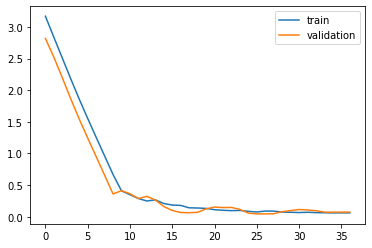


predict: [[28.19897444 22.61277191]]
real:      [[30.6 24. ]]

Train on 103 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 3.4485 - mean_squared_error: 12.1432 - val_loss: 3.1815 - val_mean_squared_error: 10.1613
Epoch 2/1000
 - 0s - loss: 3.2923 - mean_squared_error: 10.9608 - val_loss: 3.0453 - val_mean_squared_error: 9.2774
Epoch 3/1000
 - 0s - loss: 3.1560 - mean_squared_error: 10.0080 - val_loss: 2.9390 - val_mean_squared_error: 8.6379
Epoch 4/1000
 - 0s - loss: 3.0558 - mean_squared_error: 9.3655 - val_loss: 2.8635 - val_mean_squared_error: 8.2005
Epoch 5/1000
 - 0s - loss: 2.9726 - mean_squared_error: 8.8650 - val_loss: 2.7855 - val_mean_squared_error: 7.7601
Epoch 6/1000
 - 0s - loss: 2.8858 - mean_squared_error: 8.3563 - val_loss: 2.6767 - val_mean_squared_error: 7.1649
Epoch 7/1000
 - 0s - loss: 2.7723 - mean_squared_error: 7.7072 - val_loss: 2.5496 - val_mean_squared_error: 6.5033
Epoch 8/1000
 - 0s - loss: 2.6433 - mean_squared_error: 7.0010 - val_loss: 2.4140 

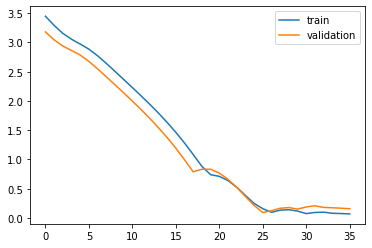


predict: [[27.43154791 22.73087953]]
real:      [[27.4 24. ]]

Train on 102 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 3.5427 - mean_squared_error: 12.5752 - val_loss: 3.3114 - val_mean_squared_error: 10.9664
Epoch 2/1000
 - 0s - loss: 3.3245 - mean_squared_error: 11.0681 - val_loss: 3.1598 - val_mean_squared_error: 9.9848
Epoch 3/1000
 - 0s - loss: 3.1788 - mean_squared_error: 10.1204 - val_loss: 3.0360 - val_mean_squared_error: 9.2208
Epoch 4/1000
 - 0s - loss: 3.0634 - mean_squared_error: 9.4080 - val_loss: 2.9329 - val_mean_squared_error: 8.6149
Epoch 5/1000
 - 0s - loss: 2.9659 - mean_squared_error: 8.8354 - val_loss: 2.8488 - val_mean_squared_error: 8.1507
Epoch 6/1000
 - 0s - loss: 2.8678 - mean_squared_error: 8.2855 - val_loss: 2.7690 - val_mean_squared_error: 7.7302
Epoch 7/1000
 - 0s - loss: 2.7671 - mean_squared_error: 7.7450 - val_loss: 2.6601 - val_mean_squared_error: 7.1601
Epoch 8/1000
 - 0s - loss: 2.6682 - mean_squared_error: 7.2393 - val_loss: 2.5501 

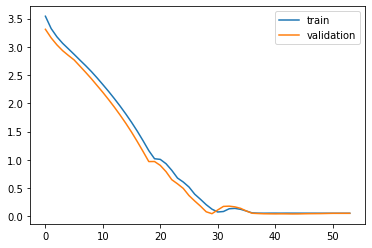


predict: [[30.71284433 23.95304144]]
real:      [[24.3 24. ]]

Train on 101 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 3.2130 - mean_squared_error: 10.6277 - val_loss: 2.9449 - val_mean_squared_error: 8.9513
Epoch 2/1000
 - 0s - loss: 2.9234 - mean_squared_error: 8.8579 - val_loss: 2.6660 - val_mean_squared_error: 7.3882
Epoch 3/1000
 - 0s - loss: 2.6398 - mean_squared_error: 7.2813 - val_loss: 2.3785 - val_mean_squared_error: 5.9316
Epoch 4/1000
 - 0s - loss: 2.3484 - mean_squared_error: 5.8193 - val_loss: 2.0880 - val_mean_squared_error: 4.6178
Epoch 5/1000
 - 0s - loss: 2.0630 - mean_squared_error: 4.5373 - val_loss: 1.8415 - val_mean_squared_error: 3.5984
Epoch 6/1000
 - 0s - loss: 1.8180 - mean_squared_error: 3.5307 - val_loss: 1.5958 - val_mean_squared_error: 2.6938
Epoch 7/1000
 - 0s - loss: 1.5685 - mean_squared_error: 2.6247 - val_loss: 1.3456 - val_mean_squared_error: 1.9011
Epoch 8/1000
 - 0s - loss: 1.3199 - mean_squared_error: 1.8512 - val_loss: 1.1270 - v

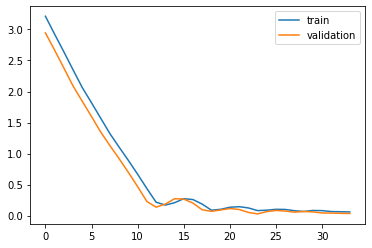


predict: [[29.81267291 25.11901525]]
real:      [[28.2 24. ]]

Train on 100 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 3.9203 - mean_squared_error: 15.3860 - val_loss: 3.5921 - val_mean_squared_error: 12.9067
Epoch 2/1000
 - 0s - loss: 3.6056 - mean_squared_error: 13.0158 - val_loss: 3.2844 - val_mean_squared_error: 10.7906
Epoch 3/1000
 - 0s - loss: 3.3078 - mean_squared_error: 10.9538 - val_loss: 3.0959 - val_mean_squared_error: 9.5881
Epoch 4/1000
 - 0s - loss: 3.1310 - mean_squared_error: 9.8147 - val_loss: 2.9220 - val_mean_squared_error: 8.5425
Epoch 5/1000
 - 0s - loss: 2.9542 - mean_squared_error: 8.7405 - val_loss: 2.6918 - val_mean_squared_error: 7.2544
Epoch 6/1000
 - 0s - loss: 2.7219 - mean_squared_error: 7.4231 - val_loss: 2.4534 - val_mean_squared_error: 6.0389
Epoch 7/1000
 - 0s - loss: 2.4936 - mean_squared_error: 6.2378 - val_loss: 2.2317 - val_mean_squared_error: 5.0218
Epoch 8/1000
 - 0s - loss: 2.2789 - mean_squared_error: 5.2242 - val_loss: 2.0227

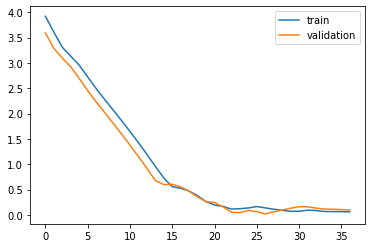


predict: [[25.67976113 24.34459274]]
real:      [[30.4 24. ]]

Train on 99 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 3.6358 - mean_squared_error: 13.2422 - val_loss: 3.2239 - val_mean_squared_error: 10.4151
Epoch 2/1000
 - 0s - loss: 3.4182 - mean_squared_error: 11.7065 - val_loss: 3.0043 - val_mean_squared_error: 9.0591
Epoch 3/1000
 - 0s - loss: 3.2156 - mean_squared_error: 10.3582 - val_loss: 2.8477 - val_mean_squared_error: 8.1671
Epoch 4/1000
 - 0s - loss: 3.0648 - mean_squared_error: 9.4071 - val_loss: 2.7221 - val_mean_squared_error: 7.4709
Epoch 5/1000
 - 0s - loss: 2.9389 - mean_squared_error: 8.6512 - val_loss: 2.6017 - val_mean_squared_error: 6.8435
Epoch 6/1000
 - 0s - loss: 2.8170 - mean_squared_error: 7.9509 - val_loss: 2.4698 - val_mean_squared_error: 6.1900
Epoch 7/1000
 - 0s - loss: 2.6864 - mean_squared_error: 7.2348 - val_loss: 2.3249 - val_mean_squared_error: 5.5278
Epoch 8/1000
 - 0s - loss: 2.5464 - mean_squared_error: 6.5079 - val_loss: 2.1858 -

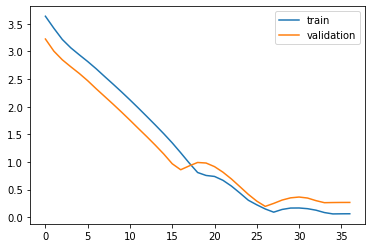


predict: [[27.59607804 23.60676212]]
real:      [[26.4 24. ]]

Train on 98 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 3.4866 - mean_squared_error: 12.2232 - val_loss: 3.2015 - val_mean_squared_error: 10.2816
Epoch 2/1000
 - 0s - loss: 3.1765 - mean_squared_error: 10.1361 - val_loss: 2.9390 - val_mean_squared_error: 8.6468
Epoch 3/1000
 - 0s - loss: 2.9047 - mean_squared_error: 8.4665 - val_loss: 2.6928 - val_mean_squared_error: 7.2516
Epoch 4/1000
 - 0s - loss: 2.6501 - mean_squared_error: 7.0440 - val_loss: 2.4717 - val_mean_squared_error: 6.1113
Epoch 5/1000
 - 0s - loss: 2.3996 - mean_squared_error: 5.7897 - val_loss: 2.1840 - val_mean_squared_error: 4.7844
Epoch 6/1000
 - 0s - loss: 2.1025 - mean_squared_error: 4.4705 - val_loss: 1.8982 - val_mean_squared_error: 3.6379
Epoch 7/1000
 - 0s - loss: 1.8195 - mean_squared_error: 3.3859 - val_loss: 1.6190 - val_mean_squared_error: 2.6820
Epoch 8/1000
 - 0s - loss: 1.5531 - mean_squared_error: 2.5108 - val_loss: 1.3501 - 

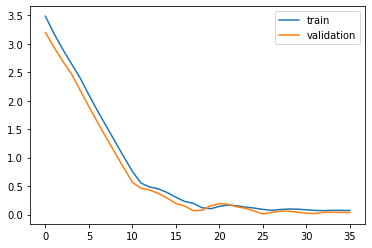


predict: [[31.49837104 23.92141733]]
real:      [[19. 24.]]

Train on 97 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 3.2500 - mean_squared_error: 10.8165 - val_loss: 3.0113 - val_mean_squared_error: 9.2890
Epoch 2/1000
 - 0s - loss: 2.9980 - mean_squared_error: 9.2777 - val_loss: 2.8165 - val_mean_squared_error: 8.1789
Epoch 3/1000
 - 0s - loss: 2.8031 - mean_squared_error: 8.1439 - val_loss: 2.6280 - val_mean_squared_error: 7.1592
Epoch 4/1000
 - 0s - loss: 2.6180 - mean_squared_error: 7.1412 - val_loss: 2.4389 - val_mean_squared_error: 6.2025
Epoch 5/1000
 - 0s - loss: 2.4314 - mean_squared_error: 6.2005 - val_loss: 2.2472 - val_mean_squared_error: 5.3062
Epoch 6/1000
 - 0s - loss: 2.2467 - mean_squared_error: 5.3398 - val_loss: 2.0788 - val_mean_squared_error: 4.6038
Epoch 7/1000
 - 0s - loss: 2.0785 - mean_squared_error: 4.6434 - val_loss: 1.9173 - val_mean_squared_error: 4.0003
Epoch 8/1000
 - 0s - loss: 1.9130 - mean_squared_error: 4.0276 - val_loss: 1.7484 - val_

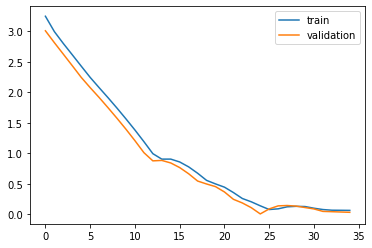


predict: [[28.70539185 23.86108093]]
real:      [[32.1 24. ]]

Train on 96 samples, validate on 1 samples
Epoch 1/1000
 - 20s - loss: 2.8594 - mean_squared_error: 8.2550 - val_loss: 2.4908 - val_mean_squared_error: 6.2377
Epoch 2/1000
 - 0s - loss: 2.5383 - mean_squared_error: 6.5195 - val_loss: 2.2217 - val_mean_squared_error: 4.9705
Epoch 3/1000
 - 0s - loss: 2.2776 - mean_squared_error: 5.2657 - val_loss: 1.9629 - val_mean_squared_error: 3.8977
Epoch 4/1000
 - 0s - loss: 2.0153 - mean_squared_error: 4.1543 - val_loss: 1.6993 - val_mean_squared_error: 2.9435
Epoch 5/1000
 - 0s - loss: 1.7472 - mean_squared_error: 3.1633 - val_loss: 1.4352 - val_mean_squared_error: 2.1369
Epoch 6/1000
 - 0s - loss: 1.4808 - mean_squared_error: 2.3282 - val_loss: 1.1639 - val_mean_squared_error: 1.4637
Epoch 7/1000
 - 0s - loss: 1.2072 - mean_squared_error: 1.6267 - val_loss: 0.8911 - val_mean_squared_error: 0.9336
Epoch 8/1000
 - 0s - loss: 0.9293 - mean_squared_error: 1.0697 - val_loss: 0.6133 - val

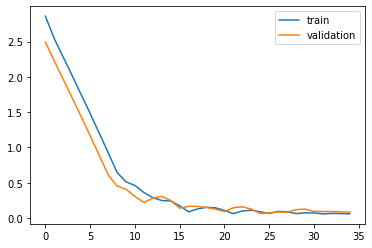


predict: [[30.7200129  23.97221139]]
real:      [[29.4 24. ]]

Train on 95 samples, validate on 1 samples
Epoch 1/1000
 - 21s - loss: 3.5244 - mean_squared_error: 12.7468 - val_loss: 3.2172 - val_mean_squared_error: 10.5647
Epoch 2/1000
 - 0s - loss: 3.2728 - mean_squared_error: 11.0062 - val_loss: 2.9842 - val_mean_squared_error: 9.1183
Epoch 3/1000
 - 0s - loss: 3.0352 - mean_squared_error: 9.4909 - val_loss: 2.7634 - val_mean_squared_error: 7.8109
Epoch 4/1000
 - 0s - loss: 2.7994 - mean_squared_error: 8.0643 - val_loss: 2.5577 - val_mean_squared_error: 6.6376
Epoch 5/1000
 - 0s - loss: 2.5569 - mean_squared_error: 6.7528 - val_loss: 2.3628 - val_mean_squared_error: 5.7050
Epoch 6/1000
 - 0s - loss: 2.3803 - mean_squared_error: 5.9132 - val_loss: 2.1536 - val_mean_squared_error: 4.8417
Epoch 7/1000
 - 0s - loss: 2.2208 - mean_squared_error: 5.2217 - val_loss: 1.9753 - val_mean_squared_error: 4.1578
Epoch 8/1000
 - 0s - loss: 2.0489 - mean_squared_error: 4.5342 - val_loss: 1.7935 - 

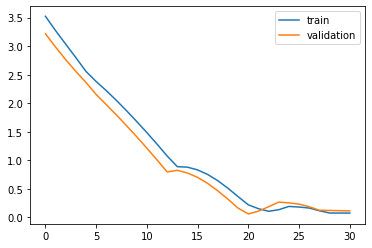


predict: [[23.31403772 22.26357823]]
real:      [[27.4 24. ]]

Train on 94 samples, validate on 1 samples
Epoch 1/1000
 - 22s - loss: 3.7071 - mean_squared_error: 13.8490 - val_loss: 3.6132 - val_mean_squared_error: 13.1507
Epoch 2/1000
 - 0s - loss: 3.5742 - mean_squared_error: 12.8667 - val_loss: 3.4679 - val_mean_squared_error: 12.1051
Epoch 3/1000
 - 0s - loss: 3.4299 - mean_squared_error: 11.8402 - val_loss: 3.3221 - val_mean_squared_error: 11.0991
Epoch 4/1000
 - 0s - loss: 3.2905 - mean_squared_error: 10.8859 - val_loss: 3.2491 - val_mean_squared_error: 10.6109
Epoch 5/1000
 - 0s - loss: 3.2057 - mean_squared_error: 10.3219 - val_loss: 3.1672 - val_mean_squared_error: 10.0695
Epoch 6/1000
 - 0s - loss: 3.1233 - mean_squared_error: 9.7835 - val_loss: 3.0849 - val_mean_squared_error: 9.5296
Epoch 7/1000
 - 0s - loss: 3.0403 - mean_squared_error: 9.2570 - val_loss: 3.0082 - val_mean_squared_error: 9.0517
Epoch 8/1000
 - 0s - loss: 2.9672 - mean_squared_error: 8.8150 - val_loss: 2.

Epoch 69/1000
 - 0s - loss: 0.0495 - mean_squared_error: 0.0107 - val_loss: 0.0078 - val_mean_squared_error: 1.1143e-04
Epoch 70/1000
 - 0s - loss: 0.0495 - mean_squared_error: 0.0107 - val_loss: 0.0079 - val_mean_squared_error: 1.1206e-04
Epoch 71/1000
 - 0s - loss: 0.0495 - mean_squared_error: 0.0107 - val_loss: 0.0079 - val_mean_squared_error: 1.1311e-04
Epoch 72/1000
 - 0s - loss: 0.0495 - mean_squared_error: 0.0107 - val_loss: 0.0079 - val_mean_squared_error: 1.1388e-04
Epoch 73/1000
 - 0s - loss: 0.0495 - mean_squared_error: 0.0107 - val_loss: 0.0078 - val_mean_squared_error: 1.1432e-04

Epoch 00073: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 74/1000
 - 0s - loss: 0.0495 - mean_squared_error: 0.0107 - val_loss: 0.0078 - val_mean_squared_error: 1.1442e-04
Epoch 75/1000
 - 0s - loss: 0.0495 - mean_squared_error: 0.0107 - val_loss: 0.0078 - val_mean_squared_error: 1.1455e-04
Epoch 76/1000
 - 0s - loss: 0.0495 - mean_squared_error: 0.0107 - val_loss: 0.

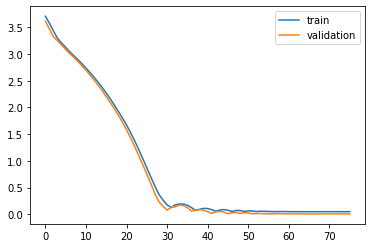


predict: [[32.74548904 23.88650445]]
real:      [[25.5 24. ]]

Train on 93 samples, validate on 1 samples
Epoch 1/1000
 - 23s - loss: 3.8808 - mean_squared_error: 15.0795 - val_loss: 3.7098 - val_mean_squared_error: 13.7778
Epoch 2/1000
 - 0s - loss: 3.6559 - mean_squared_error: 13.3891 - val_loss: 3.5361 - val_mean_squared_error: 12.5112
Epoch 3/1000
 - 0s - loss: 3.4890 - mean_squared_error: 12.1884 - val_loss: 3.4075 - val_mean_squared_error: 11.6130
Epoch 4/1000
 - 0s - loss: 3.3551 - mean_squared_error: 11.2699 - val_loss: 3.2717 - val_mean_squared_error: 10.7044
Epoch 5/1000
 - 0s - loss: 3.2283 - mean_squared_error: 10.4328 - val_loss: 3.2167 - val_mean_squared_error: 10.3470
Epoch 6/1000
 - 0s - loss: 3.1824 - mean_squared_error: 10.1396 - val_loss: 3.1745 - val_mean_squared_error: 10.0773
Epoch 7/1000
 - 0s - loss: 3.1390 - mean_squared_error: 9.8662 - val_loss: 3.1280 - val_mean_squared_error: 9.7852
Epoch 8/1000
 - 0s - loss: 3.0916 - mean_squared_error: 9.5726 - val_loss: 

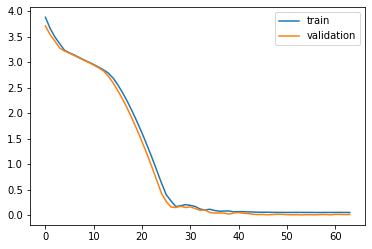


predict: [[32.90764124 23.8744922 ]]
real:      [[33.2 24. ]]

Train on 92 samples, validate on 1 samples
Epoch 1/1000
 - 23s - loss: 3.3405 - mean_squared_error: 11.1758 - val_loss: 3.1226 - val_mean_squared_error: 9.8000
Epoch 2/1000
 - 0s - loss: 3.1295 - mean_squared_error: 9.8360 - val_loss: 2.9455 - val_mean_squared_error: 8.7805
Epoch 3/1000
 - 0s - loss: 2.9692 - mean_squared_error: 8.9089 - val_loss: 2.8203 - val_mean_squared_error: 8.1413
Epoch 4/1000
 - 0s - loss: 2.8388 - mean_squared_error: 8.2315 - val_loss: 2.7023 - val_mean_squared_error: 7.6064
Epoch 5/1000
 - 0s - loss: 2.7154 - mean_squared_error: 7.6596 - val_loss: 2.5895 - val_mean_squared_error: 7.1455
Epoch 6/1000
 - 0s - loss: 2.5989 - mean_squared_error: 7.1756 - val_loss: 2.4793 - val_mean_squared_error: 6.7370
Epoch 7/1000
 - 0s - loss: 2.4857 - mean_squared_error: 6.7513 - val_loss: 2.3694 - val_mean_squared_error: 6.3723
Epoch 8/1000
 - 0s - loss: 2.3737 - mean_squared_error: 6.3766 - val_loss: 2.2562 - va

Epoch 71/1000
 - 0s - loss: 0.0520 - mean_squared_error: 0.0119 - val_loss: 0.0599 - val_mean_squared_error: 0.0061
Epoch 72/1000
 - 0s - loss: 0.0571 - mean_squared_error: 0.0129 - val_loss: 0.0605 - val_mean_squared_error: 0.0069
Epoch 73/1000
 - 0s - loss: 0.0541 - mean_squared_error: 0.0131 - val_loss: 0.0408 - val_mean_squared_error: 0.0033
Epoch 74/1000
 - 0s - loss: 0.0510 - mean_squared_error: 0.0109 - val_loss: 0.0270 - val_mean_squared_error: 0.0013

Epoch 00074: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 75/1000
 - 0s - loss: 0.0522 - mean_squared_error: 0.0101 - val_loss: 0.0268 - val_mean_squared_error: 0.0013
Epoch 76/1000
 - 0s - loss: 0.0524 - mean_squared_error: 0.0101 - val_loss: 0.0265 - val_mean_squared_error: 0.0012
Epoch 77/1000
 - 0s - loss: 0.0524 - mean_squared_error: 0.0101 - val_loss: 0.0264 - val_mean_squared_error: 0.0013


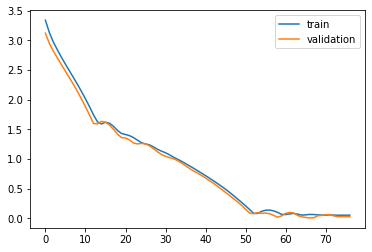


predict: [[29.52302601 23.99873196]]
real:      [[32.8 24. ]]

Train on 91 samples, validate on 1 samples
Epoch 1/1000
 - 21s - loss: 2.9221 - mean_squared_error: 8.8139 - val_loss: 2.5725 - val_mean_squared_error: 6.7486
Epoch 2/1000
 - 0s - loss: 2.6646 - mean_squared_error: 7.3452 - val_loss: 2.3789 - val_mean_squared_error: 5.8066
Epoch 3/1000
 - 0s - loss: 2.4794 - mean_squared_error: 6.4174 - val_loss: 2.1831 - val_mean_squared_error: 4.9312
Epoch 4/1000
 - 0s - loss: 2.2807 - mean_squared_error: 5.4974 - val_loss: 1.9745 - val_mean_squared_error: 4.0768
Epoch 5/1000
 - 0s - loss: 2.0703 - mean_squared_error: 4.5989 - val_loss: 1.7570 - val_mean_squared_error: 3.2734
Epoch 6/1000
 - 0s - loss: 1.8498 - mean_squared_error: 3.7417 - val_loss: 1.5392 - val_mean_squared_error: 2.5622
Epoch 7/1000
 - 0s - loss: 1.6292 - mean_squared_error: 2.9787 - val_loss: 1.3242 - val_mean_squared_error: 1.9614
Epoch 8/1000
 - 0s - loss: 1.4088 - mean_squared_error: 2.3261 - val_loss: 1.0974 - val

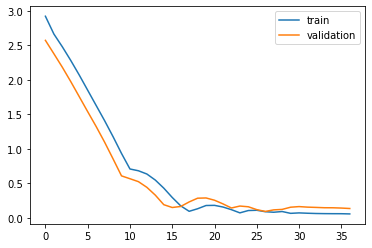


predict: [[28.57073028 23.2756866 ]]
real:      [[30.1 24. ]]

Train on 90 samples, validate on 1 samples
Epoch 1/1000
 - 23s - loss: 3.0346 - mean_squared_error: 9.2874 - val_loss: 2.7093 - val_mean_squared_error: 7.3484
Epoch 2/1000
 - 0s - loss: 2.8494 - mean_squared_error: 8.1921 - val_loss: 2.5363 - val_mean_squared_error: 6.4370
Epoch 3/1000
 - 0s - loss: 2.6706 - mean_squared_error: 7.1930 - val_loss: 2.3694 - val_mean_squared_error: 5.6156
Epoch 4/1000
 - 0s - loss: 2.5013 - mean_squared_error: 6.3079 - val_loss: 2.2012 - val_mean_squared_error: 4.8455
Epoch 5/1000
 - 0s - loss: 2.3302 - mean_squared_error: 5.4750 - val_loss: 2.0292 - val_mean_squared_error: 4.1176
Epoch 6/1000
 - 0s - loss: 2.1554 - mean_squared_error: 4.6846 - val_loss: 1.8537 - val_mean_squared_error: 3.4362
Epoch 7/1000
 - 0s - loss: 1.9760 - mean_squared_error: 3.9379 - val_loss: 1.6634 - val_mean_squared_error: 2.7673
Epoch 8/1000
 - 0s - loss: 1.7838 - mean_squared_error: 3.2107 - val_loss: 1.4641 - val

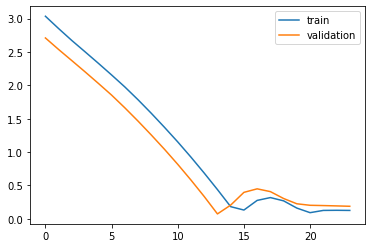


predict: [[23.41089955 20.28700698]]
real:      [[24.3 24. ]]

Train on 89 samples, validate on 1 samples
Epoch 1/1000
 - 21s - loss: 3.2198 - mean_squared_error: 10.3963 - val_loss: 2.9635 - val_mean_squared_error: 8.8077
Epoch 2/1000
 - 0s - loss: 2.9492 - mean_squared_error: 8.7350 - val_loss: 2.7425 - val_mean_squared_error: 7.5593
Epoch 3/1000
 - 0s - loss: 2.7272 - mean_squared_error: 7.4841 - val_loss: 2.5551 - val_mean_squared_error: 6.5845
Epoch 4/1000
 - 0s - loss: 2.5497 - mean_squared_error: 6.5636 - val_loss: 2.4172 - val_mean_squared_error: 5.9220
Epoch 5/1000
 - 0s - loss: 2.4080 - mean_squared_error: 5.8859 - val_loss: 2.2537 - val_mean_squared_error: 5.1942
Epoch 6/1000
 - 0s - loss: 2.2503 - mean_squared_error: 5.1825 - val_loss: 2.0747 - val_mean_squared_error: 4.4664
Epoch 7/1000
 - 0s - loss: 2.0737 - mean_squared_error: 4.4648 - val_loss: 1.8828 - val_mean_squared_error: 3.7702
Epoch 8/1000
 - 0s - loss: 1.8783 - mean_squared_error: 3.7550 - val_loss: 1.6794 - va

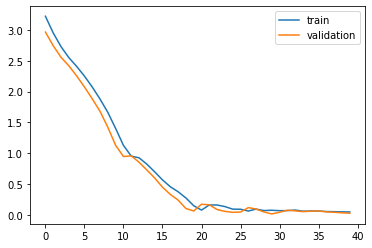


predict: [[30.20446815 22.96428731]]
real:      [[23.3 24. ]]

Train on 88 samples, validate on 1 samples
Epoch 1/1000
 - 24s - loss: 2.8678 - mean_squared_error: 8.2837 - val_loss: 2.6098 - val_mean_squared_error: 6.8120
Epoch 2/1000
 - 0s - loss: 2.6526 - mean_squared_error: 7.0547 - val_loss: 2.4439 - val_mean_squared_error: 5.9757
Epoch 3/1000
 - 0s - loss: 2.4591 - mean_squared_error: 6.0608 - val_loss: 2.2481 - val_mean_squared_error: 5.0617
Epoch 4/1000
 - 0s - loss: 2.2681 - mean_squared_error: 5.1602 - val_loss: 2.0524 - val_mean_squared_error: 4.2239
Epoch 5/1000
 - 0s - loss: 2.0762 - mean_squared_error: 4.3283 - val_loss: 1.8511 - val_mean_squared_error: 3.4432
Epoch 6/1000
 - 0s - loss: 1.8803 - mean_squared_error: 3.5555 - val_loss: 1.6478 - val_mean_squared_error: 2.7387
Epoch 7/1000
 - 0s - loss: 1.6823 - mean_squared_error: 2.8533 - val_loss: 1.4398 - val_mean_squared_error: 2.1030
Epoch 8/1000
 - 0s - loss: 1.4751 - mean_squared_error: 2.2043 - val_loss: 1.2290 - val

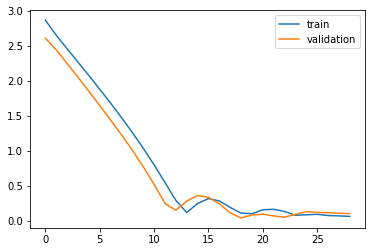


predict: [[28.16433331 22.79424173]]
real:      [[30.2 24. ]]

Train on 87 samples, validate on 1 samples
Epoch 1/1000
 - 24s - loss: 3.1444 - mean_squared_error: 10.0497 - val_loss: 2.8301 - val_mean_squared_error: 8.2044
Epoch 2/1000
 - 0s - loss: 2.9261 - mean_squared_error: 8.8605 - val_loss: 2.6125 - val_mean_squared_error: 7.1863
Epoch 3/1000
 - 0s - loss: 2.7242 - mean_squared_error: 7.9003 - val_loss: 2.4368 - val_mean_squared_error: 6.4579
Epoch 4/1000
 - 0s - loss: 2.5448 - mean_squared_error: 7.1551 - val_loss: 2.2698 - val_mean_squared_error: 5.8504
Epoch 5/1000
 - 0s - loss: 2.3742 - mean_squared_error: 6.5183 - val_loss: 2.0949 - val_mean_squared_error: 5.2975
Epoch 6/1000
 - 0s - loss: 2.1961 - mean_squared_error: 5.9431 - val_loss: 1.9109 - val_mean_squared_error: 4.8186
Epoch 7/1000
 - 0s - loss: 2.0087 - mean_squared_error: 5.4437 - val_loss: 1.7188 - val_mean_squared_error: 4.4361
Epoch 8/1000
 - 0s - loss: 1.8137 - mean_squared_error: 5.0458 - val_loss: 1.5210 - va

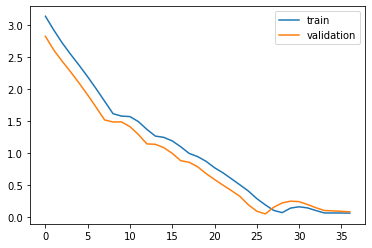


predict: [[26.90138871 25.02442675]]
real:      [[27.4 24. ]]

Train on 86 samples, validate on 1 samples
Epoch 1/1000
 - 22s - loss: 3.4413 - mean_squared_error: 11.8707 - val_loss: 3.0550 - val_mean_squared_error: 9.3352
Epoch 2/1000
 - 0s - loss: 3.2044 - mean_squared_error: 10.3013 - val_loss: 2.8276 - val_mean_squared_error: 7.9959
Epoch 3/1000
 - 0s - loss: 2.9802 - mean_squared_error: 8.9226 - val_loss: 2.6462 - val_mean_squared_error: 7.0024
Epoch 4/1000
 - 0s - loss: 2.8040 - mean_squared_error: 7.9081 - val_loss: 2.4992 - val_mean_squared_error: 6.2462
Epoch 5/1000
 - 0s - loss: 2.6625 - mean_squared_error: 7.1389 - val_loss: 2.3565 - val_mean_squared_error: 5.5538
Epoch 6/1000
 - 0s - loss: 2.5188 - mean_squared_error: 6.4004 - val_loss: 2.2089 - val_mean_squared_error: 4.8811
Epoch 7/1000
 - 0s - loss: 2.3700 - mean_squared_error: 5.6805 - val_loss: 2.0593 - val_mean_squared_error: 4.2439
Epoch 8/1000
 - 0s - loss: 2.2194 - mean_squared_error: 4.9998 - val_loss: 1.9079 - v

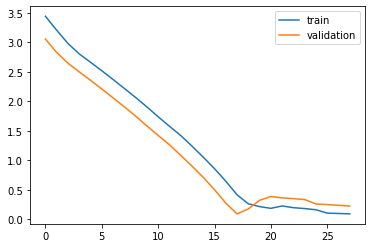


predict: [[18.920057   25.45541752]]
real:      [[25.4 24. ]]

Train on 85 samples, validate on 1 samples
Epoch 1/1000
 - 24s - loss: 3.4961 - mean_squared_error: 12.3057 - val_loss: 3.2023 - val_mean_squared_error: 10.2611
Epoch 2/1000
 - 0s - loss: 3.3779 - mean_squared_error: 11.5130 - val_loss: 3.0798 - val_mean_squared_error: 9.4941
Epoch 3/1000
 - 0s - loss: 3.2560 - mean_squared_error: 10.7059 - val_loss: 2.9623 - val_mean_squared_error: 8.7845
Epoch 4/1000
 - 0s - loss: 3.1432 - mean_squared_error: 9.9780 - val_loss: 2.8812 - val_mean_squared_error: 8.3197
Epoch 5/1000
 - 0s - loss: 3.0616 - mean_squared_error: 9.4920 - val_loss: 2.7949 - val_mean_squared_error: 7.8447
Epoch 6/1000
 - 0s - loss: 2.9755 - mean_squared_error: 9.0049 - val_loss: 2.7040 - val_mean_squared_error: 7.3655
Epoch 7/1000
 - 0s - loss: 2.8848 - mean_squared_error: 8.5129 - val_loss: 2.6098 - val_mean_squared_error: 6.8918
Epoch 8/1000
 - 0s - loss: 2.7905 - mean_squared_error: 8.0246 - val_loss: 2.5146 -

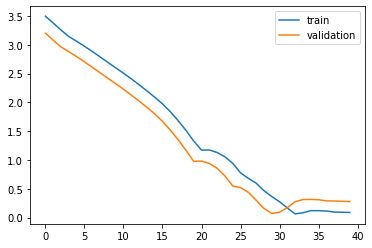


predict: [[19.21773293 26.26165012]]
real:      [[21.8 24. ]]

Train on 84 samples, validate on 1 samples
Epoch 1/1000
 - 22s - loss: 3.3583 - mean_squared_error: 11.3000 - val_loss: 2.9042 - val_mean_squared_error: 8.4514
Epoch 2/1000
 - 0s - loss: 3.1097 - mean_squared_error: 9.6873 - val_loss: 2.7149 - val_mean_squared_error: 7.3894
Epoch 3/1000
 - 0s - loss: 2.9263 - mean_squared_error: 8.5795 - val_loss: 2.5582 - val_mean_squared_error: 6.5690
Epoch 4/1000
 - 0s - loss: 2.7711 - mean_squared_error: 7.6927 - val_loss: 2.4055 - val_mean_squared_error: 5.8162
Epoch 5/1000
 - 0s - loss: 2.6206 - mean_squared_error: 6.8779 - val_loss: 2.2585 - val_mean_squared_error: 5.1355
Epoch 6/1000
 - 0s - loss: 2.4755 - mean_squared_error: 6.1374 - val_loss: 2.1195 - val_mean_squared_error: 4.5319
Epoch 7/1000
 - 0s - loss: 2.3379 - mean_squared_error: 5.4744 - val_loss: 1.9870 - val_mean_squared_error: 3.9922
Epoch 8/1000
 - 0s - loss: 2.2058 - mean_squared_error: 4.8743 - val_loss: 1.8581 - va

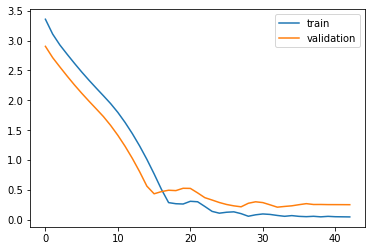


predict: [[30.39986425 23.91829812]]
real:      [[21.2 24. ]]

Train on 83 samples, validate on 1 samples
Epoch 1/1000
 - 22s - loss: 3.1330 - mean_squared_error: 9.8272 - val_loss: 2.5413 - val_mean_squared_error: 6.5569
Epoch 2/1000
 - 0s - loss: 2.8899 - mean_squared_error: 8.3621 - val_loss: 2.2015 - val_mean_squared_error: 4.9265
Epoch 3/1000
 - 0s - loss: 2.5464 - mean_squared_error: 6.4947 - val_loss: 1.8909 - val_mean_squared_error: 3.6321
Epoch 4/1000
 - 0s - loss: 2.2103 - mean_squared_error: 4.9020 - val_loss: 1.5791 - val_mean_squared_error: 2.5333
Epoch 5/1000
 - 0s - loss: 1.8880 - mean_squared_error: 3.5888 - val_loss: 1.2640 - val_mean_squared_error: 1.6258
Epoch 6/1000
 - 0s - loss: 1.5647 - mean_squared_error: 2.4826 - val_loss: 0.9273 - val_mean_squared_error: 0.8748
Epoch 7/1000
 - 0s - loss: 1.2204 - mean_squared_error: 1.5426 - val_loss: 0.5888 - val_mean_squared_error: 0.3515
Epoch 8/1000
 - 0s - loss: 0.8743 - mean_squared_error: 0.8454 - val_loss: 0.2420 - val

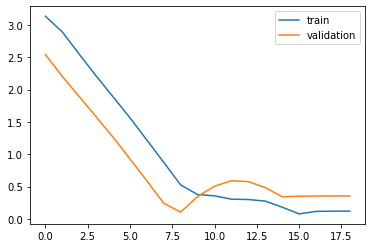


predict: [[17.31741802 29.10720205]]
real:      [[19.9 24. ]]

Train on 82 samples, validate on 1 samples
Epoch 1/1000
 - 24s - loss: 3.6127 - mean_squared_error: 13.3352 - val_loss: 3.3056 - val_mean_squared_error: 11.2633
Epoch 2/1000
 - 0s - loss: 3.3642 - mean_squared_error: 11.5085 - val_loss: 3.0619 - val_mean_squared_error: 9.6099
Epoch 3/1000
 - 0s - loss: 3.1546 - mean_squared_error: 10.0789 - val_loss: 2.8436 - val_mean_squared_error: 8.2416
Epoch 4/1000
 - 0s - loss: 2.9613 - mean_squared_error: 8.8328 - val_loss: 2.6771 - val_mean_squared_error: 7.2717
Epoch 5/1000
 - 0s - loss: 2.7722 - mean_squared_error: 7.7106 - val_loss: 2.5149 - val_mean_squared_error: 6.3954
Epoch 6/1000
 - 0s - loss: 2.6130 - mean_squared_error: 6.8409 - val_loss: 2.3467 - val_mean_squared_error: 5.5516
Epoch 7/1000
 - 0s - loss: 2.4484 - mean_squared_error: 6.0023 - val_loss: 2.1711 - val_mean_squared_error: 4.7399
Epoch 8/1000
 - 0s - loss: 2.2733 - mean_squared_error: 5.1739 - val_loss: 1.9861 -

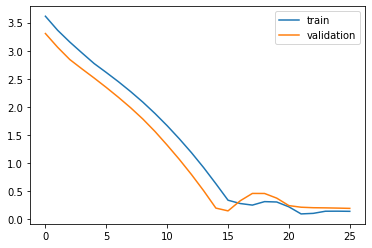


predict: [[23.24982903 31.30024347]]
real:      [[16.1 24. ]]

Train on 81 samples, validate on 1 samples
Epoch 1/1000
 - 22s - loss: 3.4506 - mean_squared_error: 11.9481 - val_loss: 3.3428 - val_mean_squared_error: 11.1749
Epoch 2/1000
 - 0s - loss: 3.3250 - mean_squared_error: 11.0612 - val_loss: 3.2006 - val_mean_squared_error: 10.2507
Epoch 3/1000
 - 0s - loss: 3.1830 - mean_squared_error: 10.1486 - val_loss: 3.0662 - val_mean_squared_error: 9.4173
Epoch 4/1000
 - 0s - loss: 3.0434 - mean_squared_error: 9.2926 - val_loss: 2.9188 - val_mean_squared_error: 8.5465
Epoch 5/1000
 - 0s - loss: 2.8939 - mean_squared_error: 8.4213 - val_loss: 2.7684 - val_mean_squared_error: 7.7011
Epoch 6/1000
 - 0s - loss: 2.7434 - mean_squared_error: 7.5821 - val_loss: 2.6171 - val_mean_squared_error: 6.8888
Epoch 7/1000
 - 0s - loss: 2.5924 - mean_squared_error: 6.7800 - val_loss: 2.4614 - val_mean_squared_error: 6.1032
Epoch 8/1000
 - 0s - loss: 2.4376 - mean_squared_error: 6.0072 - val_loss: 2.3038 

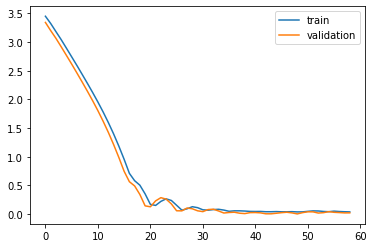


predict: [[32.04609308 23.97369394]]
real:      [[24.5 24. ]]

Train on 80 samples, validate on 1 samples
Epoch 1/1000
 - 24s - loss: 3.4694 - mean_squared_error: 12.1888 - val_loss: 3.2219 - val_mean_squared_error: 10.6046
Epoch 2/1000
 - 0s - loss: 3.2466 - mean_squared_error: 10.7194 - val_loss: 3.1218 - val_mean_squared_error: 10.0276
Epoch 3/1000
 - 0s - loss: 3.1384 - mean_squared_error: 10.0790 - val_loss: 3.0303 - val_mean_squared_error: 9.5309
Epoch 4/1000
 - 0s - loss: 3.0487 - mean_squared_error: 9.5887 - val_loss: 2.9363 - val_mean_squared_error: 9.0199
Epoch 5/1000
 - 0s - loss: 2.9553 - mean_squared_error: 9.0963 - val_loss: 2.8437 - val_mean_squared_error: 8.5422
Epoch 6/1000
 - 0s - loss: 2.8625 - mean_squared_error: 8.6237 - val_loss: 2.7471 - val_mean_squared_error: 8.0720
Epoch 7/1000
 - 0s - loss: 2.7652 - mean_squared_error: 8.1508 - val_loss: 2.6463 - val_mean_squared_error: 7.6221
Epoch 8/1000
 - 0s - loss: 2.6644 - mean_squared_error: 7.6988 - val_loss: 2.5400 

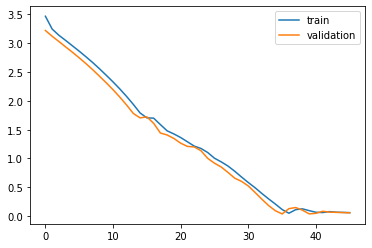


predict: [[32.60129986 24.10127171]]
real:      [[32.2 24. ]]

Train and validation time: 27.83 minutes

Maximum temperatures metrics
Test MEAN-SQUARED-ERROR ------------ 22.38
Test STANDART-DEVIATION ------------ 3.208
Test MEAN-ABSOLUTE-ERROR ----------- 3.477
Test MEDIAN-ABSOLUTE-ERROR --------- 2.492

Errors
2014-06-28 = 6.650196241267405
2014-06-27 = 0.2281916109706188
2014-06-26 = 1.067658112593552
2014-06-25 = 0.04286097380484932
2014-06-24 = 0.03906781355014388
2014-06-23 = 2.401025555798089
2014-06-21 = 0.03154791098693366
2014-06-20 = 6.412844328549255
2014-06-18 = 1.6126729120602725
2014-06-17 = 4.720238873827569
2014-06-16 = 1.1960780420723935
2014-06-14 = 12.4983710389726
2014-06-12 = 3.3946081463074123
2014-06-11 = 1.320012901499389
2014-06-10 = 4.085962283936254
2014-06-09 = 7.2454890382442585
2014-06-06 = 0.29235876289448726
2014-06-05 = 3.276973989498451
2014-06-04 = 1.5292697154594315
2014-06-03 = 0.8891004466019723
2014-06-02 = 6.904468151806547
2014-05-31 = 2.03566

In [16]:
def main():
    input_paths = getFileNameIn('../data_in/')
    input_paths = input_paths[0:10]
    y_hatss = []
    for path in input_paths:
        output_path = format_dataset(path)
        dataset = load_dataset(output_path)
        values = dataset.values
        plot_columns(dataset, values)

        # to get index the last 30 days
        days_to_predict = list(dataset.index[-30:])

        values_scaled = np.log1p(values)
        dataset_scaled = DataFrame(values_scaled)
        dataset_scaled.index = dataset.index
        dataset_scaled.columns = dataset.columns

        inicio = time.time()
        result = NCV(dataset_scaled, days_to_predict)
        fim = time.time()
        print('Train and validation time: {} minutes\n'.format(round((fim - inicio)/60,2)))

        y_hats = result[0]
        y_tests = result[1]

        y_hatss += y_hats

        metrics(y_hats, y_tests, days_to_predict)

        results = [y_hatss, y_tests]
    
if __name__ == "__main__":
    main()